# Assignment 4

The objective of this assignment is to introduce you to federated learning, with a particular focus on the challenges posed by data heterogeneity. Specifically, you will explore well-known approaches for addressing statistical heterogeneity, approaching the problem from multiple angles.

You have been provided with a manual that includes detailed descriptions of each task. Follow the instructions in the manual carefully, and add your answers and implementations directly in this notebook.

Note: In this assignment, we concentrate on one common type of statistical heterogeneity: label skew. While feature skew is another significant aspect of heterogeneity, it will not be the focus of this assignment.

In [1]:
import os
import torch
from torchvision import datasets, transforms
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from collections import defaultdict
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import Subset
import random

In [2]:
# Check if GPU is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


Using device: cuda


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Calculate sizes for training and testing datasets
print(f"Dataset size: {len(dataset)}")
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Define fixed indices for train and test splits
train_indices = list(range(train_size))
test_indices = list(range(train_size, len(dataset)))

# Create Subsets based on these indices
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_images = dataset.data[train_dataset.indices].numpy()
train_labels = dataset.targets[train_dataset.indices].numpy()
test_images = dataset.data[test_dataset.indices].numpy()
test_labels = dataset.targets[test_dataset.indices].numpy()


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 316kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.94MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.85MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Dataset size: 60000


In [4]:
def partition_data(train_data, train_targets, test_data, test_targets, num_clients, dirichlet_alpha=0.5, batch_size=32):
    num_classes = len(np.unique(train_targets))
    client_data_indices = defaultdict(list)
    client_test_indices = defaultdict(list)

    # Partition Train Data and Capture Proportions
    client_proportions = []
    for c in range(num_classes):
        class_indices = np.where(train_targets == c)[0]
        proportions = np.random.dirichlet([dirichlet_alpha] * num_clients)
        client_proportions.append(proportions)

        # Calculate split sizes and assign indices to each client
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_data_indices[i].extend(indices)

    # Partition Test Data Using the Same Proportions as Train Data
    for c, proportions in enumerate(client_proportions):
        class_indices = np.where(test_targets == c)[0]
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_test_indices[i].extend(indices)

    # Create Federated Loaders
    federated_train_loaders, federated_test_loaders = [], []
    for i in range(num_clients):
        client_train_data = torch.tensor(train_data[client_data_indices[i]], dtype=torch.float32).unsqueeze(1)
        client_train_targets = torch.tensor(train_targets[client_data_indices[i]], dtype=torch.long)
        train_loader = DataLoader(TensorDataset(client_train_data, client_train_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_train_loaders.append(train_loader)

        client_test_data = torch.tensor(test_data[client_test_indices[i]], dtype=torch.float32).unsqueeze(1)
        client_test_targets = torch.tensor(test_targets[client_test_indices[i]], dtype=torch.long)
        test_loader = DataLoader(TensorDataset(client_test_data, client_test_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_test_loaders.append(test_loader)

    # Create Centralized Loader by combining data from federated loaders
    centralized_data, centralized_targets = [], []
    for train_loader in federated_train_loaders:
        for images, targets in train_loader:
            centralized_data.append(images)
            centralized_targets.append(targets)

    centralized_data = torch.cat(centralized_data)
    centralized_targets = torch.cat(centralized_targets)
    train_centralized_loader = DataLoader(TensorDataset(centralized_data, centralized_targets), batch_size=batch_size, shuffle=False, drop_last=False)

    centralized_test_data = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1)
    centralized_test_targets = torch.tensor(test_targets, dtype=torch.long)
    test_centralized_loader = DataLoader(TensorDataset(centralized_test_data, centralized_test_targets), batch_size=batch_size, shuffle=False)

    return federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader


In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 500)
        self.fc2 = nn.Linear(500,10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

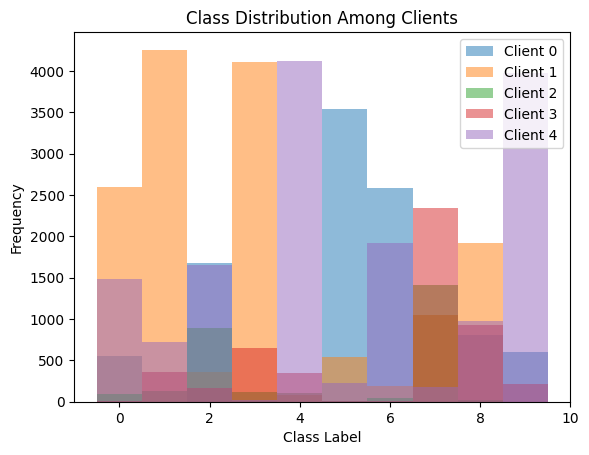

In [ ]:
import matplotlib.pyplot as plt

num_clients = 5  # Example number of clients
federated_train_loaders, _, _, _ = partition_data(train_images, train_labels, test_images, test_labels, num_clients)

for i, loader in enumerate(federated_train_loaders):
    labels = []
    for _, target in loader:
        labels.extend(target.numpy())
    plt.hist(labels, bins=np.arange(11)-0.5, alpha=0.5, label=f'Client {i}')
plt.legend()
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Class Distribution Among Clients')
plt.show()


# Task 1: Centralized Vs Federated Scenario

In this task, you will analyze the theoretical equivalence between FedSGD and a centralized training scenario. The code for both implementations has been provided. To minimize differences caused by floating-point precision, a batch size of 1 is used, along with full-batch gradient descent. You may change the device to cpu if you wish, as gpu will not be utilized for batch size of 1.

Since we are working with batch size 1 and full-batch gradient descent, accuracy is not the focus here. Instead, you will monitor gradient divergence by tracking the sum or magnitude of the gradients at each round and observe how they evolve in both settings.

Theoretically, FedSGD and centralized training should yield equivalent results. However, in this task, you may observe discrepancies. Your objective is to understand the code and identify the error that causes this divergence. You may want to review why FedSGD and full-batch centralized gradient descent are theoretically equivalent by revisiting the gradient descent steps on the global objective, as covered in class. Finally, assess whether the code aligns with these theoretical steps. If you believe they should not be equivalent, provide a reasoned justification.

In [ ]:
num_clients = 5
dirichlet_alpha = 0.8
batch_size = 1

# Partition data and create loaders
federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader = partition_data(
    train_images / 255.0, train_labels, test_images / 255.0, test_labels, num_clients, dirichlet_alpha, batch_size
)

In [ ]:
def fedsgd_training(global_model, train_loaders, num_clients, rounds, lr):
    round_avg_updates = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model.to(device)
    print(f"Using device: {device}")

    client_data_counts = [len(train_loader.dataset) for train_loader in train_loaders]
    total_data_count = 0
    for count in client_data_counts:
        total_data_count += count

    for round_num in range(rounds):
        client_updates = []
        print(f"Round {round_num + 1}/{rounds}")

        for client_id in range(num_clients):
            overall_update = local_train(global_model, train_loaders[client_id], lr)
            client_update_device = {name: update.to(device) for name, update in overall_update.items()}
            client_updates.append(client_update_device)

            client_update_sum = 0
            for update in client_update_device.values():
                client_update_sum += update.abs().sum().item()
            print(f"Client {client_id + 1} Update Sum at Round {round_num + 1}: {client_update_sum}")

        avg_update = {}
        for name in global_model.state_dict():
            grad_sum = torch.zeros_like(global_model.state_dict()[name], device=device)
            for client_id in range(num_clients):
                grad_sum += client_updates[client_id][name]
            avg_update[name] = grad_sum

        round_avg_updates.append(avg_update)

        avg_update_sum = 0
        for update in avg_update.values():
            avg_update_sum += update.abs().sum().item()
        print(f"Averaged Update Sum at Round {round_num + 1}: {avg_update_sum}")

        with torch.no_grad():
            for name, param in global_model.named_parameters():
                param -= avg_update[name]

    return round_avg_updates



def local_train(model, train_loader, lr):
    local_model = SimpleCNN()
    local_model.load_state_dict(model.state_dict())
    local_model.train()

    optimizer = optim.SGD(local_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(reduction="sum")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    local_model.to(device)

    initial_weights = {name: param.clone() for name, param in local_model.named_parameters()}

    for epoch in range(1):
        print(f"Epoch {epoch + 1}/{1} for local client")
        optimizer.zero_grad()
        batch_iterator = tqdm(train_loader, desc=f"Training Batches (Epoch {epoch + 1})")

        # Loop over batches
        for x_train, y_train in batch_iterator:
            x_train, y_train = x_train.to(device), y_train.to(device)
            outputs = local_model(x_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            batch_iterator.set_postfix(loss=loss.item())

        optimizer.step()

    overall_update = {name: initial_weights[name] - param for name, param in local_model.named_parameters()}

    return overall_update


In [ ]:
def centralized_training_updates(global_model, train_loader, epochs, lr):
    centralized_model = SimpleCNN()
    centralized_model.load_state_dict(global_model.state_dict())
    centralized_model.train()

    optimizer = optim.SGD(centralized_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(reduction="sum")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    centralized_model.to(device)

    epoch_updates = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        epoch_initial_weights = {name: param.clone() for name, param in centralized_model.named_parameters()}
        optimizer.zero_grad()
        batch_iterator = tqdm(train_loader, desc=f"Training Batches (Epoch {epoch + 1})")

        for x_train, y_train in batch_iterator:
            x_train, y_train = x_train.to(device), y_train.to(device)
            outputs = centralized_model(x_train)
            loss = criterion(outputs, y_train)
            loss.backward()

            batch_iterator.set_postfix(loss=loss.item())

        optimizer.step()

        epoch_update = {name: param - epoch_initial_weights[name]  for name, param in centralized_model.named_parameters()}
        epoch_updates.append(epoch_update)

        epoch_update_sum = 0
        for update in epoch_update.values():
            epoch_update_sum += update.abs().sum().item()

        print(f"Epoch {epoch + 1} Update Sum: {epoch_update_sum}")

    global_model.load_state_dict(centralized_model.state_dict())

    return epoch_updates


In [ ]:
# Initialize model and parameters
rounds = 4
lr = 1e-4
initial_model = SimpleCNN()

In [ ]:
# Centralized Training
global_model_centralized = SimpleCNN()
global_model_centralized.load_state_dict(initial_model.state_dict())
centralized_updates = centralized_training_updates(global_model_centralized, train_centralized_loader, epochs=rounds, lr=lr)

In [ ]:
# Fedsgd
global_model_fedsgd = SimpleCNN()
global_model_fedsgd.load_state_dict(initial_model.state_dict())
fedsgd_avg_updates = fedsgd_training(global_model_fedsgd, federated_train_loaders, num_clients, rounds=rounds, lr=lr)

In [ ]:
# Calculate update magnitudes for each round
centralized_magnitudes = [sum(param.norm().item() for param in round_update.values()) for round_update in centralized_updates]
fedsgd_magnitudes = [sum(param.norm().item() for param in update.values()) for update in fedsgd_avg_updates]

# Plot update magnitudes
x_labels = range(1, rounds + 1)
width = 0.25

plt.bar([x - width for x in x_labels], centralized_magnitudes, width=width, label="Centralized")
plt.bar(x_labels, fedsgd_magnitudes, width=width, label="FedSGD")
plt.xlabel("Round")
plt.ylabel("Average Update Magnitude")
plt.title("Update Magnitude Comparison Across Methods")
plt.legend()
plt.show()

# Check if the gradients are approximately the same
tolerance = 1e-2
success = all(abs(c - f) <= tolerance for c, f in zip(centralized_magnitudes, fedsgd_magnitudes))

if success:
    print("Success! The gradients are approximately the same.")
else:
    print("Keep trying")

# Task 2: FedAvg

Implement the fedavg_training function to perform Federated Averaging (FedAvg) over multiple communication rounds. Each round, collect updates from clients by training locally on their data and average these updates to form a new global model.

Additionally, implement the local_train function to handle client-side training. You are not restricted to using full-batch gradient descent; feel free to use mini-batch gradient descent instead. Make sure your implementation aligns with the provided code to plot the accuracies, as you should not modify that code.

In [9]:
def evaluate_model(global_model, test_loaders):
    global_model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model.to(device)

    client_accuracies = []
    total_correct, total_samples = 0, 0

    with torch.no_grad():
        for client_id, test_loader in enumerate(test_loaders):
            client_correct, client_total = 0, 0
            print(f"\nEvaluating Client {client_id}")

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = global_model(images)
                _, predicted = torch.max(outputs, 1)

                client_correct += (predicted == labels).sum().item()
                client_total += labels.size(0)

            client_accuracy = (client_correct / client_total) * 100
            client_accuracies.append(client_accuracy)

            print(f"Client {client_id} Accuracy: {client_accuracy:.2f}%")

            total_correct += client_correct
            total_samples += client_total

    total_accuracy = (total_correct / total_samples) * 100
    print(f"Total Accuracy: {total_accuracy:.2f}%")
    return client_accuracies, total_accuracy



In [ ]:
# def fedavg_training(global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders):
#     round_avg_updates = []
#     round_accuracies = []
#     # To Do
#     return round_avg_updates, round_accuracies



# def local_train(model, train_loader, epochs, lr):
#     overall_update = {name: torch.zeros_like(param) for name, param in model.state_dict().items()}
#     #To Do
#     return overall_update
from copy import deepcopy
def FedAvg(global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders):
    round_avg_updates = []
    round_accuracies = []
    conflict_counts = []
    clientacc = []

    # Set the model to the device
    global_model.to(device)

    for round_num in range(rounds):
        print(f"\n--- Federated Round {round_num + 1}/{rounds} ---")
        client_updates = []

        for client_id in range(num_clients):
            # print(f"\nClient {client_id + 1}/{num_clients}")
            client_model = deepcopy(global_model)
            train_loader = train_loaders[client_id]
            optimizer = optim.SGD(client_model.parameters(), lr=lr)
            criterion = nn.CrossEntropyLoss()

            # Train the client model
            for epoch in range(epochs):
                client_model.train()
                epoch_loss = 0.0
                progress_bar = tqdm(train_loader, desc=f"Round {round_num + 1} - Epoch {epoch + 1}/{epochs}", leave=False)

                for data, targets in progress_bar:
                    data, targets = data.to(device), targets.to(device)
                    optimizer.zero_grad()
                    outputs = client_model(data)
                    loss = criterion(outputs, targets)
                    loss.backward()
                    optimizer.step()

                    epoch_loss += loss.item()
                    progress_bar.set_postfix({"Loss": epoch_loss / len(train_loader)})

                # print(f"Client Training: Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

            # Compute the client update
            client_update = {name: param - global_model.state_dict()[name] for name, param in client_model.state_dict().items()}
            client_updates.append(client_update)

        # Aggregate updates
        aggregated_update = {name: torch.zeros_like(param) for name, param in global_model.state_dict().items()}
        for update in client_updates:
            for name in aggregated_update:
                aggregated_update[name] += update[name] / num_clients

        # Update the global model
        global_model_state = global_model.state_dict()
        for name in global_model_state:
            global_model_state[name] += aggregated_update[name]

        global_model.load_state_dict(global_model_state)

        # Evaluate the global model
        client_accuracies, accuracy = evaluate_model(global_model, test_loaders)
        round_accuracies.append(accuracy)
        clientacc.append(client_accuracies)

        print(f"Round {round_num + 1} Accuracy: {accuracy :.2f}%")

    return clientacc, round_accuracies

In the following code you may change the learning rate or the batch size

In [ ]:
# Parameters
num_clients = 5
batch_size = 128
rounds = 3
epochs = 20
lr = 0.001
dirichlet_alphas = [2, 0.5, 0.1]

def run_fedavg(alpha):
    train_loaders, test_loaders,_,_ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)
    global_model_fedavg = SimpleCNN()
    clientaccs, round_accuracies = FedAvg(global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)
    return round_accuracies, clientaccs

accuracies_per_alpha_fedavg = []
clientacc_fedavg = []

for alpha in dirichlet_alphas:
    round_accuracies, clientacc = run_fedavg(alpha)
    accuracies_per_alpha_fedavg.append(round_accuracies)
    clientacc_fedavg.append(clientacc)



--- Federated Round 1/3 ---



Evaluating Client 0
Client 0 Accuracy: 27.42%

Evaluating Client 1
Client 1 Accuracy: 28.82%

Evaluating Client 2
Client 2 Accuracy: 21.51%

Evaluating Client 3
Client 3 Accuracy: 25.97%

Evaluating Client 4
Client 4 Accuracy: 14.47%
Total Accuracy: 22.40%
Round 1 Accuracy: 22.40%

--- Federated Round 2/3 ---



Evaluating Client 0
Client 0 Accuracy: 69.07%

Evaluating Client 1
Client 1 Accuracy: 71.42%

Evaluating Client 2
Client 2 Accuracy: 59.89%

Evaluating Client 3
Client 3 Accuracy: 60.23%

Evaluating Client 4
Client 4 Accuracy: 58.16%
Total Accuracy: 62.59%
Round 2 Accuracy: 62.59%

--- Federated Round 3/3 ---



Evaluating Client 0
Client 0 Accuracy: 69.92%

Evaluating Client 1
Client 1 Accuracy: 71.73%

Evaluating Client 2
Client 2 Accuracy: 67.08%

Evaluating Client 3
Client 3 Accuracy: 58.46%

Evaluating Client 4
Client 4 Accuracy: 73.13%
Total Accuracy: 68.17%
Round 3 Accuracy: 68.17%

--- Federated Round 1/3 ---



Evaluating Client 0
Client 0 Accuracy: 16.58%

Evaluating Client 1
Client 1 Accuracy: 24.96%

Evaluating Client 2
Client 2 Accuracy: 0.69%

Evaluating Client 3
Client 3 Accuracy: 12.91%

Evaluating Client 4
Client 4 Accuracy: 2.37%
Total Accuracy: 11.48%
Round 1 Accuracy: 11.48%

--- Federated Round 2/3 ---



Evaluating Client 0
Client 0 Accuracy: 55.87%

Evaluating Client 1
Client 1 Accuracy: 45.33%

Evaluating Client 2
Client 2 Accuracy: 21.66%

Evaluating Client 3
Client 3 Accuracy: 46.85%

Evaluating Client 4
Client 4 Accuracy: 51.20%
Total Accuracy: 44.35%
Round 2 Accuracy: 44.35%

--- Federated Round 3/3 ---



Evaluating Client 0
Client 0 Accuracy: 74.48%

Evaluating Client 1
Client 1 Accuracy: 56.19%

Evaluating Client 2
Client 2 Accuracy: 35.30%

Evaluating Client 3
Client 3 Accuracy: 59.81%

Evaluating Client 4
Client 4 Accuracy: 71.02%
Total Accuracy: 59.78%
Round 3 Accuracy: 59.78%

--- Federated Round 1/3 ---



Evaluating Client 0
Client 0 Accuracy: 26.56%

Evaluating Client 1
Client 1 Accuracy: 0.00%

Evaluating Client 2
Client 2 Accuracy: 100.00%

Evaluating Client 3
Client 3 Accuracy: 1.23%

Evaluating Client 4
Client 4 Accuracy: 1.86%
Total Accuracy: 10.81%
Round 1 Accuracy: 10.81%

--- Federated Round 2/3 ---



Evaluating Client 0
Client 0 Accuracy: 26.56%

Evaluating Client 1
Client 1 Accuracy: 2.99%

Evaluating Client 2
Client 2 Accuracy: 100.00%

Evaluating Client 3
Client 3 Accuracy: 1.23%

Evaluating Client 4
Client 4 Accuracy: 3.47%
Total Accuracy: 11.85%
Round 2 Accuracy: 11.85%

--- Federated Round 3/3 ---



Evaluating Client 0
Client 0 Accuracy: 27.22%

Evaluating Client 1
Client 1 Accuracy: 39.80%

Evaluating Client 2
Client 2 Accuracy: 100.00%

Evaluating Client 3
Client 3 Accuracy: 4.29%

Evaluating Client 4
Client 4 Accuracy: 22.70%
Total Accuracy: 25.65%
Round 3 Accuracy: 25.65%


In [ ]:
# # Plotting accuracy per round for each alpha value
# plt.figure()
# for idx, alpha in enumerate(dirichlet_alphas):
#     plt.plot(range(1, rounds + 1), accuracies_per_alpha[idx], marker='o', label=f'Alpha = {alpha}')

# plt.xlabel('Rounds')
# plt.ylabel('Accuracy (%)')
# plt.legend()
# plt.title('FedAvg Accuracy per Round across Different Dirichlet Alphas')
# plt.show()

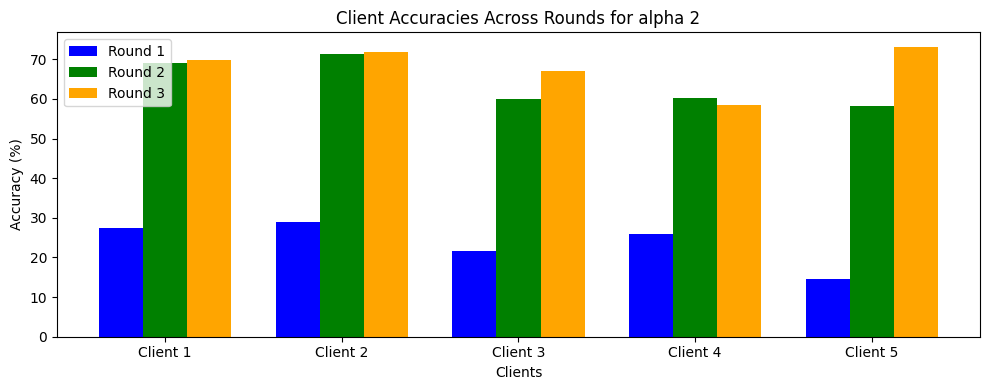

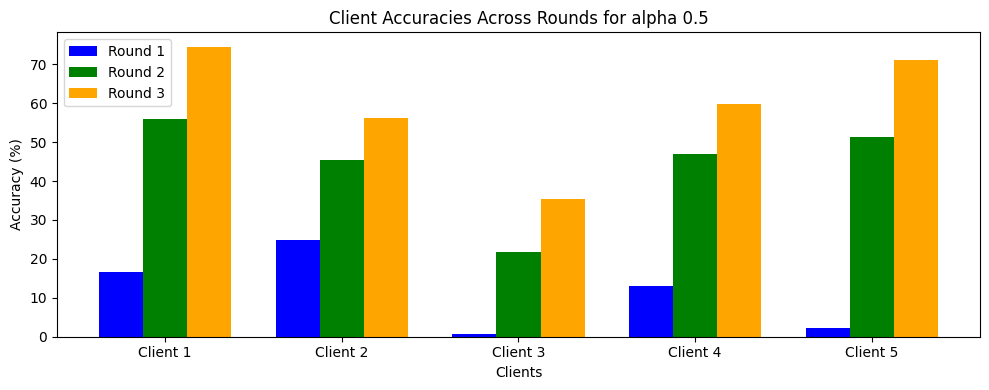

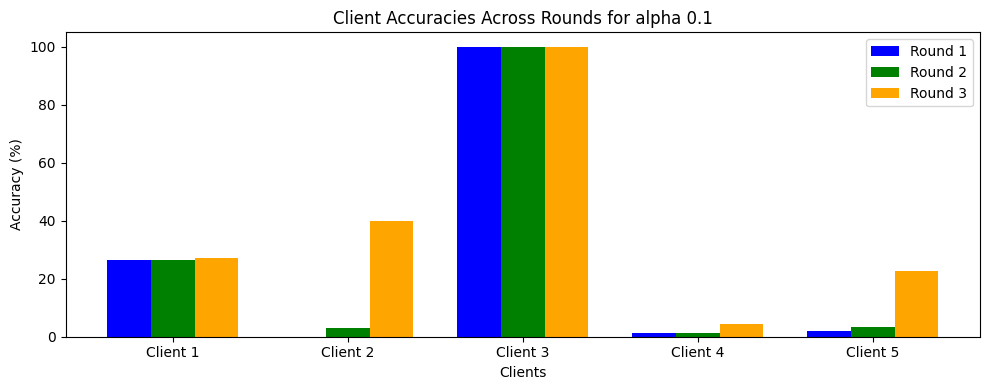

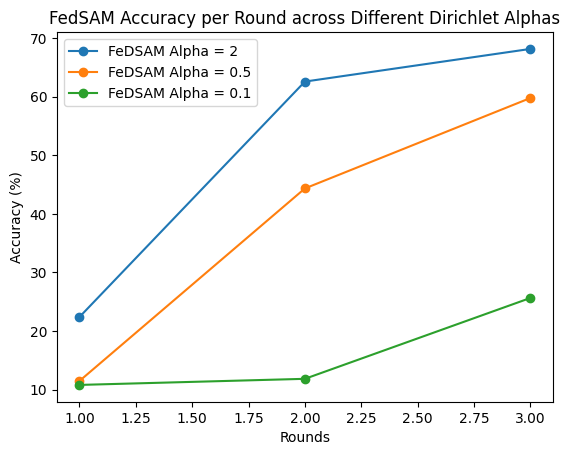

In [ ]:
# print(sam_client_accuracies[0][2])
# Extract the number of clients and rounds
for i in range(len(dirichlet_alphas)):
  num_clients = len(clientacc_fedavg[i][0])

  rounds = len(clientacc_fedavg[0])

  # Plotting the bar plots for each round
  x = np.arange(num_clients)  # Client indices
  width = 0.25  # Width of each bar

  fig, ax = plt.subplots(figsize=(10, 4))

  # Colors for each round
  colors = ['blue', 'green', 'orange']

  # Add bars for each round
  for round_idx in range(rounds):
      ax.bar(
          x + round_idx * width - (rounds - 1) * width / 2,  # Offset for bars
          clientacc_fedavg[i][round_idx],  # Accuracy data for the round
          width,  # Width of the bar
          label=f'Round {round_idx + 1}',
          color=colors[round_idx]
      )

  # Add labels, title, and legend
  ax.set_xlabel("Clients")
  ax.set_ylabel("Accuracy (%)")
  ax.set_title(f"Client Accuracies Across Rounds for alpha {dirichlet_alphas[i]}")
  ax.set_xticks(x)
  ax.set_xticklabels([f"Client {i+1}" for i in range(num_clients)])
  ax.legend()

  # Display the plot
  plt.tight_layout()
  plt.show()

plt.figure()
for idx, alpha in enumerate(dirichlet_alphas):
    plt.plot(range(1, rounds + 1), accuracies_per_alpha_fedavg[idx], marker='o', label=f'FeDSAM Alpha = {alpha}')

plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('FedSAM Accuracy per Round across Different Dirichlet Alphas')
plt.show()


# Task 3: Scaffold

In this task, you will implement the SCAFFOLD algorithm, which addresses client heterogeneity through variance reduction. We will evaluate the implementation in a 0.1 Dirichlet heterogeneous setting, and accuracy plotting code is provided.

The implementation of SCAFFOLD is similar to FedAvg, with only a few additional steps at both the server and client side. For reference, you may consult the SCAFFOLD paper to understand these adjustments in detail.

In [ ]:
from tqdm import tqdm

In [ ]:
# def local_train_scaffold(model, train_loader, c_global, c_local, epochs, lr):
#     overall_update = {name: torch.zeros_like(param) for name, param in model.state_dict().items()}
#     new_c_local = {name: torch.zeros_like(param) for name, param in model.state_dict().items()}
#     # To Do
#     return overall_update, new_c_local
def local_train_scaffold(model, train_loader, c_global, c_local, epochs, lr, mu):
    model.to(device)

    # Initialize updates and new local control variates
    overall_update = {name: torch.zeros_like(param, device=device) for name, param in model.state_dict().items()}
    new_c_local = {name: torch.zeros_like(param, device=device) for name, param in model.state_dict().items()}

    optimizer = optim.SGD(model.parameters(), lr=lr)

    for epoch in range(epochs):
        epoch_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for data, targets in progress_bar:
            data, targets = data.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = F.cross_entropy(outputs, targets)

            loss.backward()

            # Adjust gradients using control variates
            for name, param in model.named_parameters():
                if param.grad is not None:
                    param.grad += mu * (c_global[name] - c_local[name])

            # # Check for exploding gradients
            # for name, param in model.named_parameters():
            #     if param.grad is not None and not torch.isfinite(param.grad).all():
            #         print(f"Gradient exploded in {name}, resetting.")
            #         param.grad = torch.zeros_like(param.grad)

            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix({"Batch Loss": loss.item()})

        print(f"Client Training: Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

    # Compute overall update and new control variate
    for name, param in model.state_dict().items():
        overall_update[name] = param.clone() - c_local[name]
        new_c_local[name] = c_local[name] + mu * overall_update[name]

    return overall_update, new_c_local



# def federated_scaffold(global_model, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr):
#     round_accuracies = []
#     # To Do
#     return round_accuracies
def federated_scaffold(global_model, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr, mu):
    global_model.to(device)

    c_global = {name: torch.zeros_like(param, device=device) for name, param in global_model.state_dict().items()}
    c_locals = [{name: torch.zeros_like(param, device=device) for name, param in global_model.state_dict().items()} for _ in range(num_clients)]

    round_accuracies = []

    for round_num in range(rounds):
        print(f"\n--- Federated Round {round_num + 1}/{rounds} ---")
        client_updates = []

        for client_id in range(num_clients):
            print(f"\nClient {client_id + 1}/{num_clients}")
            client_model = SimpleCNN().to(device)
            client_model.load_state_dict(global_model.state_dict())
            train_loader = train_loaders[client_id]

            update, new_c_local = local_train_scaffold(client_model, train_loader, c_global, c_locals[client_id], epochs, local_lr, mu)
            client_updates.append(update)
            c_locals[client_id] = new_c_local

        # Aggregate updates
        aggregated_update = {name: torch.zeros_like(param, device=device) for name, param in global_model.state_dict().items()}
        for update in client_updates:
            for name in aggregated_update:
                aggregated_update[name] += update[name] / num_clients

        # Update global model and control variate
        global_model_state = global_model.state_dict()
        for name in global_model_state:
            global_model_state[name] += aggregated_update[name]
            c_global[name] += aggregated_update[name] / num_clients

        global_model.load_state_dict(global_model_state)

        # Evaluate global model
        clientaccs, accuracy = evaluate_model(global_model, test_loaders)
        round_accuracies.append(accuracy)
        print(f"Round {round_num + 1} Accuracy: {accuracy:.2f}%")

    return round_accuracies



In [ ]:
def evaluate_model(global_model, test_loaders):
    global_model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model.to(device)

    client_accuracies = []
    total_correct, total_samples = 0, 0

    with torch.no_grad():
        for client_id, test_loader in enumerate(test_loaders):
            client_correct, client_total = 0, 0
            print(f"\nEvaluating Client {client_id}")

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = global_model(images)
                _, predicted = torch.max(outputs, 1)

                client_correct += (predicted == labels).sum().item()
                client_total += labels.size(0)

            client_accuracy = (client_correct / client_total) * 100
            client_accuracies.append(client_accuracy)

            print(f"Client {client_id} Accuracy: {client_accuracy:.2f}%")

            total_correct += client_correct
            total_samples += client_total

    total_accuracy = (total_correct / total_samples) * 100
    # print(f"Total Accuracy: {total_accuracy:.2f}%")
    return client_accuracies, total_accuracy



In [ ]:
num_clients = 5
rounds = 3
epochs = 20
lr = 0.01
mu = 0.001
batch_size = 128
dirichlet_alphas = [2]

# Run federated SCAFFOLD with 0.1 Dirichlet and plot accuracy per round
def run_scaffold(alpha):
    # Partition data with a Dirichlet alpha of 0.1
    train_loaders, test_loaders,_,_ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)
    global_model_scaffold = SimpleCNN()
    round_accuracies = federated_scaffold(global_model_scaffold, train_loaders, test_loaders, num_clients, rounds, epochs, lr, mu)
    return round_accuracies

# Run SCAFFOLD and get accuracy per round
# scaffold_accuracies = run_scaffold()

accuracies_per_alpha = []

for alpha in dirichlet_alphas:
    round_accuracies = run_scaffold(alpha)
    accuracies_per_alpha.append(round_accuracies)


--- Federated Round 1/3 ---

Client 1/5


Client Training: Epoch 1/20, Loss: 2.0036


Client Training: Epoch 2/20, Loss: 2.0721


Client Training: Epoch 3/20, Loss: 1.7181


Client Training: Epoch 4/20, Loss: 1.2957


Client Training: Epoch 5/20, Loss: 0.9738


Client Training: Epoch 6/20, Loss: 0.7718


Client Training: Epoch 7/20, Loss: 0.6465


Client Training: Epoch 8/20, Loss: 0.5705


Client Training: Epoch 9/20, Loss: 0.5233


Client Training: Epoch 10/20, Loss: 0.4933


Client Training: Epoch 11/20, Loss: 0.4726


Client Training: Epoch 12/20, Loss: 0.4575


Client Training: Epoch 13/20, Loss: 0.4493


Client Training: Epoch 14/20, Loss: 0.4443


Client Training: Epoch 15/20, Loss: 0.4418


Client Training: Epoch 16/20, Loss: 0.4354


Client Training: Epoch 17/20, Loss: 0.4281


Client Training: Epoch 18/20, Loss: 0.4210


Client Training: Epoch 19/20, Loss: 0.4140


Client Training: Epoch 20/20, Loss: 0.4043

Client 2/5


Client Training: Epoch 1/20, Loss: 1.7977


Client Training: Epoch 2/20, Loss: 1.7923


Client Training: Epoch 3/20, Loss: 1.4967


Client Training: Epoch 4/20, Loss: 1.1696


Client Training: Epoch 5/20, Loss: 0.8891


Client Training: Epoch 6/20, Loss: 0.6963


Client Training: Epoch 7/20, Loss: 0.5797


Client Training: Epoch 8/20, Loss: 0.5086


Client Training: Epoch 9/20, Loss: 0.4630


Client Training: Epoch 10/20, Loss: 0.4330


Client Training: Epoch 11/20, Loss: 0.4114


Client Training: Epoch 12/20, Loss: 0.3984


Client Training: Epoch 13/20, Loss: 0.3890


Client Training: Epoch 14/20, Loss: 0.3793


Client Training: Epoch 15/20, Loss: 0.3711


Client Training: Epoch 16/20, Loss: 0.3654


Client Training: Epoch 17/20, Loss: 0.3605


Client Training: Epoch 18/20, Loss: 0.3567


Client Training: Epoch 19/20, Loss: 0.3517


Client Training: Epoch 20/20, Loss: 0.3445

Client 3/5


Client Training: Epoch 1/20, Loss: 1.8923


Client Training: Epoch 2/20, Loss: 1.9536


Client Training: Epoch 3/20, Loss: 1.7205


Client Training: Epoch 4/20, Loss: 1.4283


Client Training: Epoch 5/20, Loss: 1.1151


Client Training: Epoch 6/20, Loss: 0.8694


Client Training: Epoch 7/20, Loss: 0.6887


Client Training: Epoch 8/20, Loss: 0.5757


Client Training: Epoch 9/20, Loss: 0.5114


Client Training: Epoch 10/20, Loss: 0.4731


Client Training: Epoch 11/20, Loss: 0.4503


Client Training: Epoch 12/20, Loss: 0.4364


Client Training: Epoch 13/20, Loss: 0.4269


Client Training: Epoch 14/20, Loss: 0.4197


Client Training: Epoch 15/20, Loss: 0.4138


Client Training: Epoch 16/20, Loss: 0.4069


Client Training: Epoch 17/20, Loss: 0.3989


Client Training: Epoch 18/20, Loss: 0.3893


Client Training: Epoch 19/20, Loss: 0.3802


Client Training: Epoch 20/20, Loss: 0.3704

Client 4/5


Client Training: Epoch 1/20, Loss: 2.1237


Client Training: Epoch 2/20, Loss: 2.0882


Client Training: Epoch 3/20, Loss: 1.9539


Client Training: Epoch 4/20, Loss: 1.7420


Client Training: Epoch 5/20, Loss: 1.4730


Client Training: Epoch 6/20, Loss: 1.2002


Client Training: Epoch 7/20, Loss: 0.9768


Client Training: Epoch 8/20, Loss: 0.8218


Client Training: Epoch 9/20, Loss: 0.7217


Client Training: Epoch 10/20, Loss: 0.6581


Client Training: Epoch 11/20, Loss: 0.6156


Client Training: Epoch 12/20, Loss: 0.5856


Client Training: Epoch 13/20, Loss: 0.5647


Client Training: Epoch 14/20, Loss: 0.5491


Client Training: Epoch 15/20, Loss: 0.5373


Client Training: Epoch 16/20, Loss: 0.5265


Client Training: Epoch 17/20, Loss: 0.5153


Client Training: Epoch 18/20, Loss: 0.5038


Client Training: Epoch 19/20, Loss: 0.4918


Client Training: Epoch 20/20, Loss: 0.4805

Client 5/5


Client Training: Epoch 1/20, Loss: 2.2072


Client Training: Epoch 2/20, Loss: 2.1893


Client Training: Epoch 3/20, Loss: 2.1393


Client Training: Epoch 4/20, Loss: 2.0282


Client Training: Epoch 5/20, Loss: 1.8035


Client Training: Epoch 6/20, Loss: 1.4535


Client Training: Epoch 7/20, Loss: 1.1291


Client Training: Epoch 8/20, Loss: 0.9068


Client Training: Epoch 9/20, Loss: 0.7741


Client Training: Epoch 10/20, Loss: 0.6940


Client Training: Epoch 11/20, Loss: 0.6449


Client Training: Epoch 12/20, Loss: 0.6130


Client Training: Epoch 13/20, Loss: 0.5923


Client Training: Epoch 14/20, Loss: 0.5791


Client Training: Epoch 15/20, Loss: 0.5709


Client Training: Epoch 16/20, Loss: 0.5651


Client Training: Epoch 17/20, Loss: 0.5578


Client Training: Epoch 18/20, Loss: 0.5503


Client Training: Epoch 19/20, Loss: 0.5414


Client Training: Epoch 20/20, Loss: 0.5284

Evaluating Client 0
Client 0 Accuracy: 61.97%

Evaluating Client 1
Client 1 Accuracy: 63.02%

Evaluating Client 2
Client 2 Accuracy: 57.58%

Evaluating Client 3
Client 3 Accuracy: 58.15%

Evaluating Client 4
Client 4 Accuracy: 57.61%
Round 1 Accuracy: 59.96%

--- Federated Round 2/3 ---

Client 1/5


Client Training: Epoch 1/20, Loss: 0.3605


Client Training: Epoch 2/20, Loss: 0.3074


Client Training: Epoch 3/20, Loss: 0.2853


Client Training: Epoch 4/20, Loss: 0.2731


Client Training: Epoch 5/20, Loss: 0.2625


Client Training: Epoch 6/20, Loss: 0.2526


Client Training: Epoch 7/20, Loss: 0.2437


Client Training: Epoch 8/20, Loss: 0.2347


Client Training: Epoch 9/20, Loss: 0.2272


Client Training: Epoch 10/20, Loss: 0.2202


Client Training: Epoch 11/20, Loss: 0.2136


Client Training: Epoch 12/20, Loss: 0.2069


Client Training: Epoch 13/20, Loss: 0.2001


Client Training: Epoch 14/20, Loss: 0.1930


Client Training: Epoch 15/20, Loss: 0.1863


Client Training: Epoch 16/20, Loss: 0.1798


Client Training: Epoch 17/20, Loss: 0.1737


Client Training: Epoch 18/20, Loss: 0.1677


Client Training: Epoch 19/20, Loss: 0.1619


Client Training: Epoch 20/20, Loss: 0.1563

Client 2/5


Client Training: Epoch 1/20, Loss: 0.3316


Client Training: Epoch 2/20, Loss: 0.2779


Client Training: Epoch 3/20, Loss: 0.2614


Client Training: Epoch 4/20, Loss: 0.2479


Client Training: Epoch 5/20, Loss: 0.2377


Client Training: Epoch 6/20, Loss: 0.2274


Client Training: Epoch 7/20, Loss: 0.2177


Client Training: Epoch 8/20, Loss: 0.2086


Client Training: Epoch 9/20, Loss: 0.2003


Client Training: Epoch 10/20, Loss: 0.1929


Client Training: Epoch 11/20, Loss: 0.1862


Client Training: Epoch 12/20, Loss: 0.1793


Client Training: Epoch 13/20, Loss: 0.1728


Client Training: Epoch 14/20, Loss: 0.1663


Client Training: Epoch 15/20, Loss: 0.1601


Client Training: Epoch 16/20, Loss: 0.1542


Client Training: Epoch 17/20, Loss: 0.1488


Client Training: Epoch 18/20, Loss: 0.1437


Client Training: Epoch 19/20, Loss: 0.1385


Client Training: Epoch 20/20, Loss: 0.1336

Client 3/5


Client Training: Epoch 1/20, Loss: 0.3449


Client Training: Epoch 2/20, Loss: 0.2867


Client Training: Epoch 3/20, Loss: 0.2805


Client Training: Epoch 4/20, Loss: 0.2648


Client Training: Epoch 5/20, Loss: 0.2534


Client Training: Epoch 6/20, Loss: 0.2445


Client Training: Epoch 7/20, Loss: 0.2360


Client Training: Epoch 8/20, Loss: 0.2288


Client Training: Epoch 9/20, Loss: 0.2219


Client Training: Epoch 10/20, Loss: 0.2142


Client Training: Epoch 11/20, Loss: 0.2066


Client Training: Epoch 12/20, Loss: 0.1994


Client Training: Epoch 13/20, Loss: 0.1926


Client Training: Epoch 14/20, Loss: 0.1859


Client Training: Epoch 15/20, Loss: 0.1790


Client Training: Epoch 16/20, Loss: 0.1724


Client Training: Epoch 17/20, Loss: 0.1661


Client Training: Epoch 18/20, Loss: 0.1597


Client Training: Epoch 19/20, Loss: 0.1538


Client Training: Epoch 20/20, Loss: 0.1481

Client 4/5


Client Training: Epoch 1/20, Loss: 0.4622


Client Training: Epoch 2/20, Loss: 0.3733


Client Training: Epoch 3/20, Loss: 0.3525


Client Training: Epoch 4/20, Loss: 0.3368


Client Training: Epoch 5/20, Loss: 0.3198


Client Training: Epoch 6/20, Loss: 0.3040


Client Training: Epoch 7/20, Loss: 0.2899


Client Training: Epoch 8/20, Loss: 0.2768


Client Training: Epoch 9/20, Loss: 0.2646


Client Training: Epoch 10/20, Loss: 0.2530


Client Training: Epoch 11/20, Loss: 0.2421


Client Training: Epoch 12/20, Loss: 0.2318


Client Training: Epoch 13/20, Loss: 0.2224


Client Training: Epoch 14/20, Loss: 0.2136


Client Training: Epoch 15/20, Loss: 0.2050


Client Training: Epoch 16/20, Loss: 0.1971


Client Training: Epoch 17/20, Loss: 0.1896


Client Training: Epoch 18/20, Loss: 0.1825


Client Training: Epoch 19/20, Loss: 0.1758


Client Training: Epoch 20/20, Loss: 0.1694

Client 5/5


Client Training: Epoch 1/20, Loss: 0.4642


Client Training: Epoch 2/20, Loss: 0.4151


Client Training: Epoch 3/20, Loss: 0.3610


Client Training: Epoch 4/20, Loss: 0.3434


Client Training: Epoch 5/20, Loss: 0.3266


Client Training: Epoch 6/20, Loss: 0.3115


Client Training: Epoch 7/20, Loss: 0.2983


Client Training: Epoch 8/20, Loss: 0.2863


Client Training: Epoch 9/20, Loss: 0.2763


Client Training: Epoch 10/20, Loss: 0.2668


Client Training: Epoch 11/20, Loss: 0.2585


Client Training: Epoch 12/20, Loss: 0.2503


Client Training: Epoch 13/20, Loss: 0.2422


Client Training: Epoch 14/20, Loss: 0.2344


Client Training: Epoch 15/20, Loss: 0.2271


Client Training: Epoch 16/20, Loss: 0.2197


Client Training: Epoch 17/20, Loss: 0.2125


Client Training: Epoch 18/20, Loss: 0.2056


Client Training: Epoch 19/20, Loss: 0.1990


Client Training: Epoch 20/20, Loss: 0.1925

Evaluating Client 0
Client 0 Accuracy: 80.70%

Evaluating Client 1
Client 1 Accuracy: 80.02%

Evaluating Client 2
Client 2 Accuracy: 78.25%

Evaluating Client 3
Client 3 Accuracy: 81.63%

Evaluating Client 4
Client 4 Accuracy: 83.29%
Round 2 Accuracy: 80.49%

--- Federated Round 3/3 ---

Client 1/5


Client Training: Epoch 1/20, Loss: 1.7050


Client Training: Epoch 2/20, Loss: 0.6120


Client Training: Epoch 3/20, Loss: 0.2826


Client Training: Epoch 4/20, Loss: 0.1838


Client Training: Epoch 5/20, Loss: 0.1415


Client Training: Epoch 6/20, Loss: 0.1179


Client Training: Epoch 7/20, Loss: 0.1031


Client Training: Epoch 8/20, Loss: 0.0919


Client Training: Epoch 9/20, Loss: 0.0832


Client Training: Epoch 10/20, Loss: 0.0761


Client Training: Epoch 11/20, Loss: 0.0698


Client Training: Epoch 12/20, Loss: 0.0644


Client Training: Epoch 13/20, Loss: 0.0596


Client Training: Epoch 14/20, Loss: 0.0554


Client Training: Epoch 15/20, Loss: 0.0515


Client Training: Epoch 16/20, Loss: 0.0482


Client Training: Epoch 17/20, Loss: 0.0451


Client Training: Epoch 18/20, Loss: 0.0423


Client Training: Epoch 19/20, Loss: 0.0398


Client Training: Epoch 20/20, Loss: 0.0375

Client 2/5


Client Training: Epoch 1/20, Loss: 2.7674


Client Training: Epoch 2/20, Loss: 0.5453


Client Training: Epoch 3/20, Loss: 0.2788


Client Training: Epoch 4/20, Loss: 0.2165


Client Training: Epoch 5/20, Loss: 0.1775


Client Training: Epoch 6/20, Loss: 0.1522


Client Training: Epoch 7/20, Loss: 0.1345


Client Training: Epoch 8/20, Loss: 0.1224


Client Training: Epoch 9/20, Loss: 0.1116


Client Training: Epoch 10/20, Loss: 0.1021


Client Training: Epoch 11/20, Loss: 0.0933


Client Training: Epoch 12/20, Loss: 0.0857


Client Training: Epoch 13/20, Loss: 0.0793


Client Training: Epoch 14/20, Loss: 0.0735


Client Training: Epoch 15/20, Loss: 0.0683


Client Training: Epoch 16/20, Loss: 0.0636


Client Training: Epoch 17/20, Loss: 0.0595


Client Training: Epoch 18/20, Loss: 0.0558


Client Training: Epoch 19/20, Loss: 0.0525


Client Training: Epoch 20/20, Loss: 0.0496

Client 3/5


Client Training: Epoch 1/20, Loss: 2.6645


Client Training: Epoch 2/20, Loss: 0.4503


Client Training: Epoch 3/20, Loss: 0.2795


Client Training: Epoch 4/20, Loss: 0.2091


Client Training: Epoch 5/20, Loss: 0.1743


Client Training: Epoch 6/20, Loss: 0.1512


Client Training: Epoch 7/20, Loss: 0.1340


Client Training: Epoch 8/20, Loss: 0.1203


Client Training: Epoch 9/20, Loss: 0.1090


Client Training: Epoch 10/20, Loss: 0.0993


Client Training: Epoch 11/20, Loss: 0.0913


Client Training: Epoch 12/20, Loss: 0.0839


Client Training: Epoch 13/20, Loss: 0.0774


Client Training: Epoch 14/20, Loss: 0.0715


Client Training: Epoch 15/20, Loss: 0.0662


Client Training: Epoch 16/20, Loss: 0.0613


Client Training: Epoch 17/20, Loss: 0.0569


Client Training: Epoch 18/20, Loss: 0.0531


Client Training: Epoch 19/20, Loss: 0.0497


Client Training: Epoch 20/20, Loss: 0.0465

Client 4/5


Client Training: Epoch 1/20, Loss: 3.0823


Client Training: Epoch 2/20, Loss: 0.7515


Client Training: Epoch 3/20, Loss: 0.2690


Client Training: Epoch 4/20, Loss: 0.2007


Client Training: Epoch 5/20, Loss: 0.1659


Client Training: Epoch 6/20, Loss: 0.1414


Client Training: Epoch 7/20, Loss: 0.1231


Client Training: Epoch 8/20, Loss: 0.1081


Client Training: Epoch 9/20, Loss: 0.0963


Client Training: Epoch 10/20, Loss: 0.0863


Client Training: Epoch 11/20, Loss: 0.0782


Client Training: Epoch 12/20, Loss: 0.0711


Client Training: Epoch 13/20, Loss: 0.0650


Client Training: Epoch 14/20, Loss: 0.0596


Client Training: Epoch 15/20, Loss: 0.0546


Client Training: Epoch 16/20, Loss: 0.0504


Client Training: Epoch 17/20, Loss: 0.0462


Client Training: Epoch 18/20, Loss: 0.0429


Client Training: Epoch 19/20, Loss: 0.0397


Client Training: Epoch 20/20, Loss: 0.0371

Client 5/5


Client Training: Epoch 1/20, Loss: 2.9683


Client Training: Epoch 2/20, Loss: 0.5475


Client Training: Epoch 3/20, Loss: 0.3001


Client Training: Epoch 4/20, Loss: 0.2161


Client Training: Epoch 5/20, Loss: 0.1725


Client Training: Epoch 6/20, Loss: 0.1456


Client Training: Epoch 7/20, Loss: 0.1268


Client Training: Epoch 8/20, Loss: 0.1127


Client Training: Epoch 9/20, Loss: 0.1012


Client Training: Epoch 10/20, Loss: 0.0921


Client Training: Epoch 11/20, Loss: 0.0842


Client Training: Epoch 12/20, Loss: 0.0775


Client Training: Epoch 13/20, Loss: 0.0713


Client Training: Epoch 14/20, Loss: 0.0656


Client Training: Epoch 15/20, Loss: 0.0605


Client Training: Epoch 16/20, Loss: 0.0561


Client Training: Epoch 17/20, Loss: 0.0520


Client Training: Epoch 18/20, Loss: 0.0484


Client Training: Epoch 19/20, Loss: 0.0453


Client Training: Epoch 20/20, Loss: 0.0424

Evaluating Client 0
Client 0 Accuracy: 89.72%

Evaluating Client 1
Client 1 Accuracy: 90.45%

Evaluating Client 2
Client 2 Accuracy: 89.06%

Evaluating Client 3
Client 3 Accuracy: 89.46%

Evaluating Client 4
Client 4 Accuracy: 91.59%
Round 3 Accuracy: 89.99%


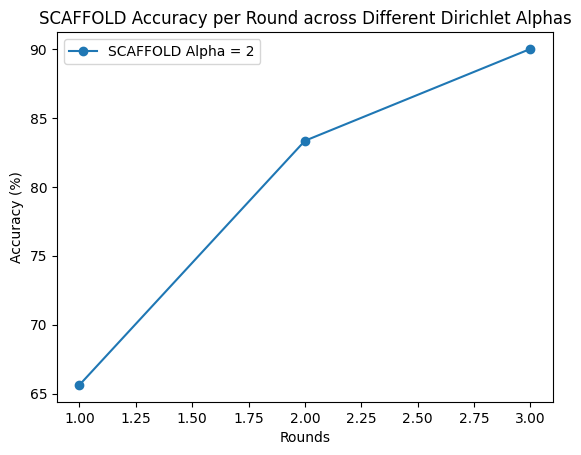

In [ ]:
# plt.figure()
# plt.plot(range(1, rounds + 1), scaffold_accuracies, marker='o', label='SCAFFOLD Alpha = 0.1')
# plt.xlabel('Rounds')
# plt.ylabel('Accuracy (%)')
# plt.title('SCAFFOLD Accuracy per Round (Dirichlet Alpha = 0.1)')
# plt.legend()
# plt.show()
plt.figure()
for idx, alpha in enumerate(dirichlet_alphas):
    plt.plot(range(1, rounds + 1), accuracies_per_alpha[idx], marker='o', label=f'SCAFFOLD Alpha = {alpha}')

plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('SCAFFOLD Accuracy per Round across Different Dirichlet Alphas')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from collections import defaultdict
import numpy as np
from tqdm import tqdm

# Define local training function for SCAFFOLD
def local_train_scaffold(model, train_loader, c_global, c_local, epochs, lr, mu):
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    overall_update = {name: torch.zeros_like(param).to(device) for name, param in model.state_dict().items()}
    new_c_local = {name: torch.zeros_like(param).to(device) for name, param in model.state_dict().items()}

    for epoch in range(epochs):
        running_loss = 0.0
        for data, target in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            # Forward pass
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            running_loss += loss.item()

            # Update weights with control variates adjustment
            with torch.no_grad():
                for name, param in model.named_parameters():
                    update = param.grad + mu*(c_global[name] - c_local[name])
                    param -= lr * (update)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")


    for name, param in model.state_dict().items():
        overall_update[name] = param.clone() - c_local[name]
        new_c_local[name] = c_local[name] - c_global[name] + (mu / (epochs * lr)) * overall_update[name]

    return overall_update, new_c_local

def federated_scaffold(global_model, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr, mu):
    round_accuracies = []
    clientacc = []
    c_global = {name: torch.zeros_like(param).to(device) for name, param in global_model.state_dict().items()}
    c_locals = [
        {name: torch.zeros_like(param).to(device) for name, param in global_model.state_dict().items()}
        for _ in range(num_clients)
    ]

    for round in range(rounds):
        print(f"\nStarting Round {round + 1}/{rounds}")
        # Local training for each client
        local_updates = []
        client_sample_counts = []

        for client_idx in range(num_clients):
            print(f"\nClient {client_idx + 1}/{num_clients}")
            local_model = SimpleCNN().to(device)
            local_model.load_state_dict(global_model.state_dict())

            # Get sample count for weighted aggregation
            num_samples = len(train_loaders[client_idx].dataset)
            client_sample_counts.append(num_samples)

            overall_update, new_c_local = local_train_scaffold(
                local_model, train_loaders[client_idx], c_global, c_locals[client_idx], epochs, local_lr, mu
            )
            local_updates.append(overall_update)
            c_locals[client_idx] = new_c_local

        # Compute total samples for weighting
        total_samples = sum(client_sample_counts)
        client_weights = [count / total_samples for count in client_sample_counts]

        # Aggregating updates from all clients using weights
        with torch.no_grad():
            for name in global_model.state_dict():
                weighted_update = sum(
                    client_weights[client_idx] * local_updates[client_idx][name]
                    for client_idx in range(num_clients)
                )
                global_model.state_dict()[name].add_(weighted_update)
                c_global[name].add_(weighted_update / num_clients)

        # Evaluate the global model
        acc, round_accuracy = evaluate_model(global_model, test_loaders)
        round_accuracies.append(round_accuracy)
        clientacc.append(acc)
        print(f"Round {round + 1}/{rounds}, Accuracy: {round_accuracy:.4f}")

    return round_accuracies, clientacc


# Run federated SCAFFOLD with specified Dirichlet alphas
num_clients = 5
rounds = 3
epochs = 20
lr = 0.01
mu = 0.001
batch_size = 128
dirichlet_alphas = [2, 0.5, 0.1]

accuracies_per_alpha = []
clinet_scaf_acc_per_alpha = []
for alpha in dirichlet_alphas:
    train_loaders, test_loaders, _, _ = partition_data(
        train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size
    )
    global_model_scaffold = SimpleCNN().to(device)
    round_accuracies, client_accs = federated_scaffold(global_model_scaffold, train_loaders, test_loaders, num_clients, rounds, epochs, lr, mu)
    accuracies_per_alpha.append(round_accuracies)
    clinet_scaf_acc_per_alpha.append(client_accs)

# # Plot accuracies per round for different alphas
# import matplotlib.pyplot as plt
# for idx, alpha in enumerate(dirichlet_alphas):
#     plt.plot(range(1, rounds + 1), accuracies_per_alpha[idx], label=f'Alpha = {alpha}')

# plt.xlabel('Rounds')
# plt.ylabel('Accuracy')
# plt.title('Accuracy per Round for Different Dirichlet Alphas (SCAFFOLD)')
# plt.legend()
# plt.show()



Starting Round 1/3

Client 1/5


Epoch 1/20: 100%|██████████| 75/75 [00:00<00:00, 228.28it/s]


Epoch 1/20, Loss: 1.8560


Epoch 2/20: 100%|██████████| 75/75 [00:00<00:00, 250.19it/s]


Epoch 2/20, Loss: 1.7922


Epoch 3/20: 100%|██████████| 75/75 [00:00<00:00, 261.60it/s]


Epoch 3/20, Loss: 1.5605


Epoch 4/20: 100%|██████████| 75/75 [00:00<00:00, 263.32it/s]


Epoch 4/20, Loss: 1.2943


Epoch 5/20: 100%|██████████| 75/75 [00:00<00:00, 271.63it/s]


Epoch 5/20, Loss: 1.0579


Epoch 6/20: 100%|██████████| 75/75 [00:00<00:00, 259.53it/s]


Epoch 6/20, Loss: 0.8704


Epoch 7/20: 100%|██████████| 75/75 [00:00<00:00, 273.39it/s]


Epoch 7/20, Loss: 0.7347


Epoch 8/20: 100%|██████████| 75/75 [00:00<00:00, 271.02it/s]


Epoch 8/20, Loss: 0.6367


Epoch 9/20: 100%|██████████| 75/75 [00:00<00:00, 252.04it/s]


Epoch 9/20, Loss: 0.5639


Epoch 10/20: 100%|██████████| 75/75 [00:00<00:00, 270.35it/s]


Epoch 10/20, Loss: 0.5157


Epoch 11/20: 100%|██████████| 75/75 [00:00<00:00, 271.81it/s]


Epoch 11/20, Loss: 0.4835


Epoch 12/20: 100%|██████████| 75/75 [00:00<00:00, 269.51it/s]


Epoch 12/20, Loss: 0.4624


Epoch 13/20: 100%|██████████| 75/75 [00:00<00:00, 257.81it/s]


Epoch 13/20, Loss: 0.4423


Epoch 14/20: 100%|██████████| 75/75 [00:00<00:00, 275.50it/s]


Epoch 14/20, Loss: 0.4257


Epoch 15/20: 100%|██████████| 75/75 [00:00<00:00, 271.50it/s]


Epoch 15/20, Loss: 0.4111


Epoch 16/20: 100%|██████████| 75/75 [00:00<00:00, 241.43it/s]


Epoch 16/20, Loss: 0.3994


Epoch 17/20: 100%|██████████| 75/75 [00:00<00:00, 206.59it/s]


Epoch 17/20, Loss: 0.3907


Epoch 18/20: 100%|██████████| 75/75 [00:00<00:00, 213.06it/s]


Epoch 18/20, Loss: 0.3820


Epoch 19/20: 100%|██████████| 75/75 [00:00<00:00, 202.26it/s]


Epoch 19/20, Loss: 0.3713


Epoch 20/20: 100%|██████████| 75/75 [00:00<00:00, 203.36it/s]


Epoch 20/20, Loss: 0.3605

Client 2/5


Epoch 1/20: 100%|██████████| 76/76 [00:00<00:00, 189.23it/s]


Epoch 1/20, Loss: 2.0487


Epoch 2/20: 100%|██████████| 76/76 [00:00<00:00, 181.05it/s]


Epoch 2/20, Loss: 2.0284


Epoch 3/20: 100%|██████████| 76/76 [00:00<00:00, 252.23it/s]


Epoch 3/20, Loss: 1.8608


Epoch 4/20: 100%|██████████| 76/76 [00:00<00:00, 250.61it/s]


Epoch 4/20, Loss: 1.5629


Epoch 5/20: 100%|██████████| 76/76 [00:00<00:00, 243.38it/s]


Epoch 5/20, Loss: 1.2628


Epoch 6/20: 100%|██████████| 76/76 [00:00<00:00, 270.59it/s]


Epoch 6/20, Loss: 1.0176


Epoch 7/20: 100%|██████████| 76/76 [00:00<00:00, 265.02it/s]


Epoch 7/20, Loss: 0.8338


Epoch 8/20: 100%|██████████| 76/76 [00:00<00:00, 249.04it/s]


Epoch 8/20, Loss: 0.7100


Epoch 9/20: 100%|██████████| 76/76 [00:00<00:00, 274.47it/s]


Epoch 9/20, Loss: 0.6258


Epoch 10/20: 100%|██████████| 76/76 [00:00<00:00, 267.58it/s]


Epoch 10/20, Loss: 0.5692


Epoch 11/20: 100%|██████████| 76/76 [00:00<00:00, 259.39it/s]


Epoch 11/20, Loss: 0.5297


Epoch 12/20: 100%|██████████| 76/76 [00:00<00:00, 261.09it/s]


Epoch 12/20, Loss: 0.4993


Epoch 13/20: 100%|██████████| 76/76 [00:00<00:00, 274.34it/s]


Epoch 13/20, Loss: 0.4761


Epoch 14/20: 100%|██████████| 76/76 [00:00<00:00, 265.10it/s]


Epoch 14/20, Loss: 0.4603


Epoch 15/20: 100%|██████████| 76/76 [00:00<00:00, 259.22it/s]


Epoch 15/20, Loss: 0.4464


Epoch 16/20: 100%|██████████| 76/76 [00:00<00:00, 272.91it/s]


Epoch 16/20, Loss: 0.4333


Epoch 17/20: 100%|██████████| 76/76 [00:00<00:00, 263.20it/s]


Epoch 17/20, Loss: 0.4214


Epoch 18/20: 100%|██████████| 76/76 [00:00<00:00, 257.30it/s]


Epoch 18/20, Loss: 0.4091


Epoch 19/20: 100%|██████████| 76/76 [00:00<00:00, 258.69it/s]


Epoch 19/20, Loss: 0.3985


Epoch 20/20: 100%|██████████| 76/76 [00:00<00:00, 268.52it/s]


Epoch 20/20, Loss: 0.3885

Client 3/5


Epoch 1/20: 100%|██████████| 75/75 [00:00<00:00, 245.96it/s]


Epoch 1/20, Loss: 2.0654


Epoch 2/20: 100%|██████████| 75/75 [00:00<00:00, 262.84it/s]


Epoch 2/20, Loss: 2.1779


Epoch 3/20: 100%|██████████| 75/75 [00:00<00:00, 269.43it/s]


Epoch 3/20, Loss: 1.9749


Epoch 4/20: 100%|██████████| 75/75 [00:00<00:00, 271.00it/s]


Epoch 4/20, Loss: 1.6356


Epoch 5/20: 100%|██████████| 75/75 [00:00<00:00, 260.29it/s]


Epoch 5/20, Loss: 1.2631


Epoch 6/20: 100%|██████████| 75/75 [00:00<00:00, 264.35it/s]


Epoch 6/20, Loss: 0.9943


Epoch 7/20: 100%|██████████| 75/75 [00:00<00:00, 268.11it/s]


Epoch 7/20, Loss: 0.7976


Epoch 8/20: 100%|██████████| 75/75 [00:00<00:00, 253.05it/s]


Epoch 8/20, Loss: 0.6681


Epoch 9/20: 100%|██████████| 75/75 [00:00<00:00, 264.21it/s]


Epoch 9/20, Loss: 0.5878


Epoch 10/20: 100%|██████████| 75/75 [00:00<00:00, 270.00it/s]


Epoch 10/20, Loss: 0.5372


Epoch 11/20: 100%|██████████| 75/75 [00:00<00:00, 263.82it/s]


Epoch 11/20, Loss: 0.5033


Epoch 12/20: 100%|██████████| 75/75 [00:00<00:00, 262.90it/s]


Epoch 12/20, Loss: 0.4768


Epoch 13/20: 100%|██████████| 75/75 [00:00<00:00, 263.28it/s]


Epoch 13/20, Loss: 0.4585


Epoch 14/20: 100%|██████████| 75/75 [00:00<00:00, 266.63it/s]


Epoch 14/20, Loss: 0.4450


Epoch 15/20: 100%|██████████| 75/75 [00:00<00:00, 251.39it/s]


Epoch 15/20, Loss: 0.4331


Epoch 16/20: 100%|██████████| 75/75 [00:00<00:00, 226.80it/s]


Epoch 16/20, Loss: 0.4231


Epoch 17/20: 100%|██████████| 75/75 [00:00<00:00, 206.71it/s]


Epoch 17/20, Loss: 0.4135


Epoch 18/20: 100%|██████████| 75/75 [00:00<00:00, 206.49it/s]


Epoch 18/20, Loss: 0.4041


Epoch 19/20: 100%|██████████| 75/75 [00:00<00:00, 215.25it/s]


Epoch 19/20, Loss: 0.3946


Epoch 20/20: 100%|██████████| 75/75 [00:00<00:00, 200.97it/s]


Epoch 20/20, Loss: 0.3858

Client 4/5


Epoch 1/20: 100%|██████████| 57/57 [00:00<00:00, 185.52it/s]


Epoch 1/20, Loss: 2.0932


Epoch 2/20: 100%|██████████| 57/57 [00:00<00:00, 181.15it/s]


Epoch 2/20, Loss: 2.0112


Epoch 3/20: 100%|██████████| 57/57 [00:00<00:00, 218.35it/s]


Epoch 3/20, Loss: 1.9586


Epoch 4/20: 100%|██████████| 57/57 [00:00<00:00, 239.98it/s]


Epoch 4/20, Loss: 1.8272


Epoch 5/20: 100%|██████████| 57/57 [00:00<00:00, 268.35it/s]


Epoch 5/20, Loss: 1.6286


Epoch 6/20: 100%|██████████| 57/57 [00:00<00:00, 253.40it/s]


Epoch 6/20, Loss: 1.3929


Epoch 7/20: 100%|██████████| 57/57 [00:00<00:00, 262.78it/s]


Epoch 7/20, Loss: 1.1765


Epoch 8/20: 100%|██████████| 57/57 [00:00<00:00, 246.06it/s]


Epoch 8/20, Loss: 1.0032


Epoch 9/20: 100%|██████████| 57/57 [00:00<00:00, 269.82it/s]


Epoch 9/20, Loss: 0.8745


Epoch 10/20: 100%|██████████| 57/57 [00:00<00:00, 258.55it/s]


Epoch 10/20, Loss: 0.7834


Epoch 11/20: 100%|██████████| 57/57 [00:00<00:00, 263.81it/s]


Epoch 11/20, Loss: 0.7193


Epoch 12/20: 100%|██████████| 57/57 [00:00<00:00, 257.51it/s]


Epoch 12/20, Loss: 0.6719


Epoch 13/20: 100%|██████████| 57/57 [00:00<00:00, 258.72it/s]


Epoch 13/20, Loss: 0.6337


Epoch 14/20: 100%|██████████| 57/57 [00:00<00:00, 258.77it/s]


Epoch 14/20, Loss: 0.6047


Epoch 15/20: 100%|██████████| 57/57 [00:00<00:00, 248.18it/s]


Epoch 15/20, Loss: 0.5834


Epoch 16/20: 100%|██████████| 57/57 [00:00<00:00, 270.36it/s]


Epoch 16/20, Loss: 0.5654


Epoch 17/20: 100%|██████████| 57/57 [00:00<00:00, 239.76it/s]


Epoch 17/20, Loss: 0.5468


Epoch 18/20: 100%|██████████| 57/57 [00:00<00:00, 268.81it/s]


Epoch 18/20, Loss: 0.5290


Epoch 19/20: 100%|██████████| 57/57 [00:00<00:00, 251.00it/s]


Epoch 19/20, Loss: 0.5132


Epoch 20/20: 100%|██████████| 57/57 [00:00<00:00, 250.11it/s]


Epoch 20/20, Loss: 0.4946

Client 5/5


Epoch 1/20: 100%|██████████| 94/94 [00:00<00:00, 250.92it/s]


Epoch 1/20, Loss: 1.7499


Epoch 2/20: 100%|██████████| 94/94 [00:00<00:00, 263.97it/s]


Epoch 2/20, Loss: 1.6694


Epoch 3/20: 100%|██████████| 94/94 [00:00<00:00, 261.80it/s]


Epoch 3/20, Loss: 1.3652


Epoch 4/20: 100%|██████████| 94/94 [00:00<00:00, 257.92it/s]


Epoch 4/20, Loss: 1.0852


Epoch 5/20: 100%|██████████| 94/94 [00:00<00:00, 260.30it/s]


Epoch 5/20, Loss: 0.8627


Epoch 6/20: 100%|██████████| 94/94 [00:00<00:00, 260.73it/s]


Epoch 6/20, Loss: 0.7097


Epoch 7/20: 100%|██████████| 94/94 [00:00<00:00, 270.03it/s]


Epoch 7/20, Loss: 0.6084


Epoch 8/20: 100%|██████████| 94/94 [00:00<00:00, 257.39it/s]


Epoch 8/20, Loss: 0.5425


Epoch 9/20: 100%|██████████| 94/94 [00:00<00:00, 256.27it/s]


Epoch 9/20, Loss: 0.4942


Epoch 10/20: 100%|██████████| 94/94 [00:00<00:00, 267.68it/s]


Epoch 10/20, Loss: 0.4599


Epoch 11/20: 100%|██████████| 94/94 [00:00<00:00, 250.30it/s]


Epoch 11/20, Loss: 0.4343


Epoch 12/20: 100%|██████████| 94/94 [00:00<00:00, 251.70it/s]


Epoch 12/20, Loss: 0.4163


Epoch 13/20: 100%|██████████| 94/94 [00:00<00:00, 265.66it/s]


Epoch 13/20, Loss: 0.4017


Epoch 14/20: 100%|██████████| 94/94 [00:00<00:00, 250.92it/s]


Epoch 14/20, Loss: 0.3898


Epoch 15/20: 100%|██████████| 94/94 [00:00<00:00, 265.71it/s]


Epoch 15/20, Loss: 0.3799


Epoch 16/20: 100%|██████████| 94/94 [00:00<00:00, 258.76it/s]


Epoch 16/20, Loss: 0.3702


Epoch 17/20: 100%|██████████| 94/94 [00:00<00:00, 193.66it/s]


Epoch 17/20, Loss: 0.3618


Epoch 18/20: 100%|██████████| 94/94 [00:00<00:00, 210.20it/s]


Epoch 18/20, Loss: 0.3540


Epoch 19/20: 100%|██████████| 94/94 [00:00<00:00, 200.60it/s]


Epoch 19/20, Loss: 0.3466


Epoch 20/20: 100%|██████████| 94/94 [00:00<00:00, 192.68it/s]


Epoch 20/20, Loss: 0.3391

Evaluating Client 0
Client 0 Accuracy: 63.76%

Evaluating Client 1
Client 1 Accuracy: 60.22%

Evaluating Client 2
Client 2 Accuracy: 57.76%

Evaluating Client 3
Client 3 Accuracy: 60.80%

Evaluating Client 4
Client 4 Accuracy: 61.85%
Total Accuracy: 60.92%
Round 1/3, Accuracy: 60.9250

Starting Round 2/3

Client 1/5


Epoch 1/20: 100%|██████████| 75/75 [00:00<00:00, 230.45it/s]


Epoch 1/20, Loss: 0.3117


Epoch 2/20: 100%|██████████| 75/75 [00:00<00:00, 249.44it/s]


Epoch 2/20, Loss: 0.2680


Epoch 3/20: 100%|██████████| 75/75 [00:00<00:00, 246.47it/s]


Epoch 3/20, Loss: 0.2406


Epoch 4/20: 100%|██████████| 75/75 [00:00<00:00, 260.91it/s]


Epoch 4/20, Loss: 0.2253


Epoch 5/20: 100%|██████████| 75/75 [00:00<00:00, 267.08it/s]


Epoch 5/20, Loss: 0.2120


Epoch 6/20: 100%|██████████| 75/75 [00:00<00:00, 260.16it/s]


Epoch 6/20, Loss: 0.2002


Epoch 7/20: 100%|██████████| 75/75 [00:00<00:00, 255.29it/s]


Epoch 7/20, Loss: 0.1900


Epoch 8/20: 100%|██████████| 75/75 [00:00<00:00, 265.79it/s]


Epoch 8/20, Loss: 0.1807


Epoch 9/20: 100%|██████████| 75/75 [00:00<00:00, 262.66it/s]


Epoch 9/20, Loss: 0.1725


Epoch 10/20: 100%|██████████| 75/75 [00:00<00:00, 248.03it/s]


Epoch 10/20, Loss: 0.1648


Epoch 11/20: 100%|██████████| 75/75 [00:00<00:00, 271.40it/s]


Epoch 11/20, Loss: 0.1578


Epoch 12/20: 100%|██████████| 75/75 [00:00<00:00, 270.49it/s]


Epoch 12/20, Loss: 0.1514


Epoch 13/20: 100%|██████████| 75/75 [00:00<00:00, 254.85it/s]


Epoch 13/20, Loss: 0.1454


Epoch 14/20: 100%|██████████| 75/75 [00:00<00:00, 251.55it/s]


Epoch 14/20, Loss: 0.1399


Epoch 15/20: 100%|██████████| 75/75 [00:00<00:00, 266.25it/s]


Epoch 15/20, Loss: 0.1348


Epoch 16/20: 100%|██████████| 75/75 [00:00<00:00, 266.54it/s]


Epoch 16/20, Loss: 0.1299


Epoch 17/20: 100%|██████████| 75/75 [00:00<00:00, 247.14it/s]


Epoch 17/20, Loss: 0.1253


Epoch 18/20: 100%|██████████| 75/75 [00:00<00:00, 267.01it/s]


Epoch 18/20, Loss: 0.1209


Epoch 19/20: 100%|██████████| 75/75 [00:00<00:00, 257.64it/s]


Epoch 19/20, Loss: 0.1168


Epoch 20/20: 100%|██████████| 75/75 [00:00<00:00, 236.94it/s]


Epoch 20/20, Loss: 0.1130

Client 2/5


Epoch 1/20: 100%|██████████| 76/76 [00:00<00:00, 252.64it/s]


Epoch 1/20, Loss: 0.3093


Epoch 2/20: 100%|██████████| 76/76 [00:00<00:00, 268.07it/s]


Epoch 2/20, Loss: 0.2865


Epoch 3/20: 100%|██████████| 76/76 [00:00<00:00, 263.85it/s]


Epoch 3/20, Loss: 0.2651


Epoch 4/20: 100%|██████████| 76/76 [00:00<00:00, 253.37it/s]


Epoch 4/20, Loss: 0.2487


Epoch 5/20: 100%|██████████| 76/76 [00:00<00:00, 266.89it/s]


Epoch 5/20, Loss: 0.2336


Epoch 6/20: 100%|██████████| 76/76 [00:00<00:00, 253.98it/s]


Epoch 6/20, Loss: 0.2203


Epoch 7/20: 100%|██████████| 76/76 [00:00<00:00, 120.91it/s]


Epoch 7/20, Loss: 0.2089


Epoch 8/20: 100%|██████████| 76/76 [00:00<00:00, 263.33it/s]


Epoch 8/20, Loss: 0.1988


Epoch 9/20: 100%|██████████| 76/76 [00:00<00:00, 119.40it/s]


Epoch 9/20, Loss: 0.1894


Epoch 10/20: 100%|██████████| 76/76 [00:00<00:00, 259.06it/s]


Epoch 10/20, Loss: 0.1807


Epoch 11/20: 100%|██████████| 76/76 [00:00<00:00, 124.68it/s]


Epoch 11/20, Loss: 0.1727


Epoch 12/20: 100%|██████████| 76/76 [00:00<00:00, 133.96it/s]


Epoch 12/20, Loss: 0.1654


Epoch 13/20: 100%|██████████| 76/76 [00:00<00:00, 202.05it/s]


Epoch 13/20, Loss: 0.1589


Epoch 14/20: 100%|██████████| 76/76 [00:00<00:00, 204.76it/s]


Epoch 14/20, Loss: 0.1528


Epoch 15/20: 100%|██████████| 76/76 [00:00<00:00, 192.64it/s]


Epoch 15/20, Loss: 0.1471


Epoch 16/20: 100%|██████████| 76/76 [00:00<00:00, 192.53it/s]


Epoch 16/20, Loss: 0.1414


Epoch 17/20: 100%|██████████| 76/76 [00:00<00:00, 239.64it/s]


Epoch 17/20, Loss: 0.1361


Epoch 18/20: 100%|██████████| 76/76 [00:00<00:00, 250.64it/s]


Epoch 18/20, Loss: 0.1312


Epoch 19/20: 100%|██████████| 76/76 [00:00<00:00, 261.88it/s]


Epoch 19/20, Loss: 0.1265


Epoch 20/20: 100%|██████████| 76/76 [00:00<00:00, 266.41it/s]


Epoch 20/20, Loss: 0.1220

Client 3/5


Epoch 1/20: 100%|██████████| 75/75 [00:00<00:00, 254.10it/s]


Epoch 1/20, Loss: 0.3856


Epoch 2/20: 100%|██████████| 75/75 [00:00<00:00, 261.60it/s]


Epoch 2/20, Loss: 0.3121


Epoch 3/20: 100%|██████████| 75/75 [00:00<00:00, 256.89it/s]


Epoch 3/20, Loss: 0.2861


Epoch 4/20: 100%|██████████| 75/75 [00:00<00:00, 261.41it/s]


Epoch 4/20, Loss: 0.2657


Epoch 5/20: 100%|██████████| 75/75 [00:00<00:00, 264.27it/s]


Epoch 5/20, Loss: 0.2485


Epoch 6/20: 100%|██████████| 75/75 [00:00<00:00, 267.36it/s]


Epoch 6/20, Loss: 0.2341


Epoch 7/20: 100%|██████████| 75/75 [00:00<00:00, 268.60it/s]


Epoch 7/20, Loss: 0.2212


Epoch 8/20: 100%|██████████| 75/75 [00:00<00:00, 254.14it/s]


Epoch 8/20, Loss: 0.2101


Epoch 9/20: 100%|██████████| 75/75 [00:00<00:00, 245.71it/s]


Epoch 9/20, Loss: 0.2000


Epoch 10/20: 100%|██████████| 75/75 [00:00<00:00, 265.98it/s]


Epoch 10/20, Loss: 0.1906


Epoch 11/20: 100%|██████████| 75/75 [00:00<00:00, 248.27it/s]


Epoch 11/20, Loss: 0.1814


Epoch 12/20: 100%|██████████| 75/75 [00:00<00:00, 268.60it/s]


Epoch 12/20, Loss: 0.1730


Epoch 13/20: 100%|██████████| 75/75 [00:00<00:00, 260.41it/s]


Epoch 13/20, Loss: 0.1651


Epoch 14/20: 100%|██████████| 75/75 [00:00<00:00, 261.10it/s]


Epoch 14/20, Loss: 0.1576


Epoch 15/20: 100%|██████████| 75/75 [00:00<00:00, 258.62it/s]


Epoch 15/20, Loss: 0.1505


Epoch 16/20: 100%|██████████| 75/75 [00:00<00:00, 266.12it/s]


Epoch 16/20, Loss: 0.1440


Epoch 17/20: 100%|██████████| 75/75 [00:00<00:00, 269.73it/s]


Epoch 17/20, Loss: 0.1377


Epoch 18/20: 100%|██████████| 75/75 [00:00<00:00, 251.93it/s]


Epoch 18/20, Loss: 0.1317


Epoch 19/20: 100%|██████████| 75/75 [00:00<00:00, 270.31it/s]


Epoch 19/20, Loss: 0.1263


Epoch 20/20: 100%|██████████| 75/75 [00:00<00:00, 264.42it/s]


Epoch 20/20, Loss: 0.1210

Client 4/5


Epoch 1/20: 100%|██████████| 57/57 [00:00<00:00, 265.14it/s]


Epoch 1/20, Loss: 0.4857


Epoch 2/20: 100%|██████████| 57/57 [00:00<00:00, 249.63it/s]


Epoch 2/20, Loss: 0.3460


Epoch 3/20: 100%|██████████| 57/57 [00:00<00:00, 271.71it/s]


Epoch 3/20, Loss: 0.3236


Epoch 4/20: 100%|██████████| 57/57 [00:00<00:00, 257.88it/s]


Epoch 4/20, Loss: 0.3009


Epoch 5/20: 100%|██████████| 57/57 [00:00<00:00, 263.67it/s]


Epoch 5/20, Loss: 0.2824


Epoch 6/20: 100%|██████████| 57/57 [00:00<00:00, 250.61it/s]


Epoch 6/20, Loss: 0.2663


Epoch 7/20: 100%|██████████| 57/57 [00:00<00:00, 263.37it/s]


Epoch 7/20, Loss: 0.2524


Epoch 8/20: 100%|██████████| 57/57 [00:00<00:00, 261.12it/s]


Epoch 8/20, Loss: 0.2402


Epoch 9/20: 100%|██████████| 57/57 [00:00<00:00, 262.18it/s]


Epoch 9/20, Loss: 0.2296


Epoch 10/20: 100%|██████████| 57/57 [00:00<00:00, 258.08it/s]


Epoch 10/20, Loss: 0.2198


Epoch 11/20: 100%|██████████| 57/57 [00:00<00:00, 254.68it/s]


Epoch 11/20, Loss: 0.2108


Epoch 12/20: 100%|██████████| 57/57 [00:00<00:00, 264.86it/s]


Epoch 12/20, Loss: 0.2024


Epoch 13/20: 100%|██████████| 57/57 [00:00<00:00, 254.82it/s]


Epoch 13/20, Loss: 0.1947


Epoch 14/20: 100%|██████████| 57/57 [00:00<00:00, 185.73it/s]


Epoch 14/20, Loss: 0.1873


Epoch 15/20: 100%|██████████| 57/57 [00:00<00:00, 199.59it/s]


Epoch 15/20, Loss: 0.1803


Epoch 16/20: 100%|██████████| 57/57 [00:00<00:00, 202.99it/s]


Epoch 16/20, Loss: 0.1736


Epoch 17/20: 100%|██████████| 57/57 [00:00<00:00, 208.73it/s]


Epoch 17/20, Loss: 0.1674


Epoch 18/20: 100%|██████████| 57/57 [00:00<00:00, 203.50it/s]


Epoch 18/20, Loss: 0.1617


Epoch 19/20: 100%|██████████| 57/57 [00:00<00:00, 198.94it/s]


Epoch 19/20, Loss: 0.1563


Epoch 20/20: 100%|██████████| 57/57 [00:00<00:00, 183.96it/s]


Epoch 20/20, Loss: 0.1512

Client 5/5


Epoch 1/20: 100%|██████████| 94/94 [00:00<00:00, 212.66it/s]


Epoch 1/20, Loss: 0.3704


Epoch 2/20: 100%|██████████| 94/94 [00:00<00:00, 264.92it/s]


Epoch 2/20, Loss: 0.2779


Epoch 3/20: 100%|██████████| 94/94 [00:00<00:00, 249.07it/s]


Epoch 3/20, Loss: 0.2527


Epoch 4/20: 100%|██████████| 94/94 [00:00<00:00, 264.04it/s]


Epoch 4/20, Loss: 0.2337


Epoch 5/20: 100%|██████████| 94/94 [00:00<00:00, 256.46it/s]


Epoch 5/20, Loss: 0.2184


Epoch 6/20: 100%|██████████| 94/94 [00:00<00:00, 254.31it/s]


Epoch 6/20, Loss: 0.2053


Epoch 7/20: 100%|██████████| 94/94 [00:00<00:00, 272.41it/s]


Epoch 7/20, Loss: 0.1938


Epoch 8/20: 100%|██████████| 94/94 [00:00<00:00, 257.30it/s]


Epoch 8/20, Loss: 0.1837


Epoch 9/20: 100%|██████████| 94/94 [00:00<00:00, 257.34it/s]


Epoch 9/20, Loss: 0.1744


Epoch 10/20: 100%|██████████| 94/94 [00:00<00:00, 273.17it/s]


Epoch 10/20, Loss: 0.1657


Epoch 11/20: 100%|██████████| 94/94 [00:00<00:00, 260.41it/s]


Epoch 11/20, Loss: 0.1577


Epoch 12/20: 100%|██████████| 94/94 [00:00<00:00, 260.76it/s]


Epoch 12/20, Loss: 0.1505


Epoch 13/20: 100%|██████████| 94/94 [00:00<00:00, 271.25it/s]


Epoch 13/20, Loss: 0.1440


Epoch 14/20: 100%|██████████| 94/94 [00:00<00:00, 255.13it/s]


Epoch 14/20, Loss: 0.1378


Epoch 15/20: 100%|██████████| 94/94 [00:00<00:00, 272.54it/s]


Epoch 15/20, Loss: 0.1321


Epoch 16/20: 100%|██████████| 94/94 [00:00<00:00, 269.73it/s]


Epoch 16/20, Loss: 0.1267


Epoch 17/20: 100%|██████████| 94/94 [00:00<00:00, 254.94it/s]


Epoch 17/20, Loss: 0.1217


Epoch 18/20: 100%|██████████| 94/94 [00:00<00:00, 275.47it/s]


Epoch 18/20, Loss: 0.1170


Epoch 19/20: 100%|██████████| 94/94 [00:00<00:00, 269.69it/s]


Epoch 19/20, Loss: 0.1125


Epoch 20/20: 100%|██████████| 94/94 [00:00<00:00, 253.52it/s]


Epoch 20/20, Loss: 0.1084

Evaluating Client 0
Client 0 Accuracy: 84.81%

Evaluating Client 1
Client 1 Accuracy: 79.49%

Evaluating Client 2
Client 2 Accuracy: 79.67%

Evaluating Client 3
Client 3 Accuracy: 80.71%

Evaluating Client 4
Client 4 Accuracy: 84.30%
Total Accuracy: 81.97%
Round 2/3, Accuracy: 81.9667

Starting Round 3/3

Client 1/5


Epoch 1/20: 100%|██████████| 75/75 [00:00<00:00, 272.91it/s]


Epoch 1/20, Loss: 2.0900


Epoch 2/20: 100%|██████████| 75/75 [00:00<00:00, 252.92it/s]


Epoch 2/20, Loss: 0.7806


Epoch 3/20: 100%|██████████| 75/75 [00:00<00:00, 258.91it/s]


Epoch 3/20, Loss: 0.2303


Epoch 4/20: 100%|██████████| 75/75 [00:00<00:00, 270.89it/s]


Epoch 4/20, Loss: 0.1690


Epoch 5/20: 100%|██████████| 75/75 [00:00<00:00, 259.24it/s]


Epoch 5/20, Loss: 0.1373


Epoch 6/20: 100%|██████████| 75/75 [00:00<00:00, 244.93it/s]


Epoch 6/20, Loss: 0.1167


Epoch 7/20: 100%|██████████| 75/75 [00:00<00:00, 265.69it/s]


Epoch 7/20, Loss: 0.1018


Epoch 8/20: 100%|██████████| 75/75 [00:00<00:00, 263.05it/s]


Epoch 8/20, Loss: 0.0901


Epoch 9/20: 100%|██████████| 75/75 [00:00<00:00, 247.37it/s]


Epoch 9/20, Loss: 0.0805


Epoch 10/20: 100%|██████████| 75/75 [00:00<00:00, 203.24it/s]


Epoch 10/20, Loss: 0.0724


Epoch 11/20: 100%|██████████| 75/75 [00:00<00:00, 209.26it/s]


Epoch 11/20, Loss: 0.0654


Epoch 12/20: 100%|██████████| 75/75 [00:00<00:00, 203.40it/s]


Epoch 12/20, Loss: 0.0594


Epoch 13/20: 100%|██████████| 75/75 [00:00<00:00, 217.60it/s]


Epoch 13/20, Loss: 0.0542


Epoch 14/20: 100%|██████████| 75/75 [00:00<00:00, 194.65it/s]


Epoch 14/20, Loss: 0.0495


Epoch 15/20: 100%|██████████| 75/75 [00:00<00:00, 188.58it/s]


Epoch 15/20, Loss: 0.0456


Epoch 16/20: 100%|██████████| 75/75 [00:00<00:00, 204.72it/s]


Epoch 16/20, Loss: 0.0421


Epoch 17/20: 100%|██████████| 75/75 [00:00<00:00, 256.92it/s]


Epoch 17/20, Loss: 0.0389


Epoch 18/20: 100%|██████████| 75/75 [00:00<00:00, 256.56it/s]


Epoch 18/20, Loss: 0.0360


Epoch 19/20: 100%|██████████| 75/75 [00:00<00:00, 271.80it/s]


Epoch 19/20, Loss: 0.0333


Epoch 20/20: 100%|██████████| 75/75 [00:00<00:00, 260.81it/s]


Epoch 20/20, Loss: 0.0309

Client 2/5


Epoch 1/20: 100%|██████████| 76/76 [00:00<00:00, 251.33it/s]


Epoch 1/20, Loss: 2.0498


Epoch 2/20: 100%|██████████| 76/76 [00:00<00:00, 274.99it/s]


Epoch 2/20, Loss: 0.5180


Epoch 3/20: 100%|██████████| 76/76 [00:00<00:00, 264.57it/s]


Epoch 3/20, Loss: 0.2541


Epoch 4/20: 100%|██████████| 76/76 [00:00<00:00, 253.43it/s]


Epoch 4/20, Loss: 0.1799


Epoch 5/20: 100%|██████████| 76/76 [00:00<00:00, 265.42it/s]


Epoch 5/20, Loss: 0.1423


Epoch 6/20: 100%|██████████| 76/76 [00:00<00:00, 268.46it/s]


Epoch 6/20, Loss: 0.1179


Epoch 7/20: 100%|██████████| 76/76 [00:00<00:00, 264.72it/s]


Epoch 7/20, Loss: 0.0999


Epoch 8/20: 100%|██████████| 76/76 [00:00<00:00, 250.09it/s]


Epoch 8/20, Loss: 0.0861


Epoch 9/20: 100%|██████████| 76/76 [00:00<00:00, 267.80it/s]


Epoch 9/20, Loss: 0.0750


Epoch 10/20: 100%|██████████| 76/76 [00:00<00:00, 264.57it/s]


Epoch 10/20, Loss: 0.0661


Epoch 11/20: 100%|██████████| 76/76 [00:00<00:00, 258.27it/s]


Epoch 11/20, Loss: 0.0589


Epoch 12/20: 100%|██████████| 76/76 [00:00<00:00, 261.40it/s]


Epoch 12/20, Loss: 0.0530


Epoch 13/20: 100%|██████████| 76/76 [00:00<00:00, 265.77it/s]


Epoch 13/20, Loss: 0.0482


Epoch 14/20: 100%|██████████| 76/76 [00:00<00:00, 237.66it/s]


Epoch 14/20, Loss: 0.0438


Epoch 15/20: 100%|██████████| 76/76 [00:00<00:00, 249.42it/s]


Epoch 15/20, Loss: 0.0400


Epoch 16/20: 100%|██████████| 76/76 [00:00<00:00, 256.08it/s]


Epoch 16/20, Loss: 0.0367


Epoch 17/20: 100%|██████████| 76/76 [00:00<00:00, 258.92it/s]


Epoch 17/20, Loss: 0.0337


Epoch 18/20: 100%|██████████| 76/76 [00:00<00:00, 259.82it/s]


Epoch 18/20, Loss: 0.0311


Epoch 19/20: 100%|██████████| 76/76 [00:00<00:00, 274.00it/s]


Epoch 19/20, Loss: 0.0288


Epoch 20/20: 100%|██████████| 76/76 [00:00<00:00, 263.26it/s]


Epoch 20/20, Loss: 0.0266

Client 3/5


Epoch 1/20: 100%|██████████| 75/75 [00:00<00:00, 248.16it/s]


Epoch 1/20, Loss: 3.0195


Epoch 2/20: 100%|██████████| 75/75 [00:00<00:00, 261.86it/s]


Epoch 2/20, Loss: 0.5453


Epoch 3/20: 100%|██████████| 75/75 [00:00<00:00, 266.59it/s]


Epoch 3/20, Loss: 0.2430


Epoch 4/20: 100%|██████████| 75/75 [00:00<00:00, 256.43it/s]


Epoch 4/20, Loss: 0.1989


Epoch 5/20: 100%|██████████| 75/75 [00:00<00:00, 261.80it/s]


Epoch 5/20, Loss: 0.1706


Epoch 6/20: 100%|██████████| 75/75 [00:00<00:00, 262.79it/s]


Epoch 6/20, Loss: 0.1489


Epoch 7/20: 100%|██████████| 75/75 [00:00<00:00, 258.66it/s]


Epoch 7/20, Loss: 0.1321


Epoch 8/20: 100%|██████████| 75/75 [00:00<00:00, 259.94it/s]


Epoch 8/20, Loss: 0.1172


Epoch 9/20: 100%|██████████| 75/75 [00:00<00:00, 260.04it/s]


Epoch 9/20, Loss: 0.1049


Epoch 10/20: 100%|██████████| 75/75 [00:00<00:00, 193.66it/s]


Epoch 10/20, Loss: 0.0939


Epoch 11/20: 100%|██████████| 75/75 [00:00<00:00, 203.37it/s]


Epoch 11/20, Loss: 0.0849


Epoch 12/20: 100%|██████████| 75/75 [00:00<00:00, 211.65it/s]


Epoch 12/20, Loss: 0.0770


Epoch 13/20: 100%|██████████| 75/75 [00:00<00:00, 207.39it/s]


Epoch 13/20, Loss: 0.0698


Epoch 14/20: 100%|██████████| 75/75 [00:00<00:00, 199.94it/s]


Epoch 14/20, Loss: 0.0636


Epoch 15/20: 100%|██████████| 75/75 [00:00<00:00, 189.40it/s]


Epoch 15/20, Loss: 0.0584


Epoch 16/20: 100%|██████████| 75/75 [00:00<00:00, 205.31it/s]


Epoch 16/20, Loss: 0.0537


Epoch 17/20: 100%|██████████| 75/75 [00:00<00:00, 259.72it/s]


Epoch 17/20, Loss: 0.0494


Epoch 18/20: 100%|██████████| 75/75 [00:00<00:00, 268.67it/s]


Epoch 18/20, Loss: 0.0456


Epoch 19/20: 100%|██████████| 75/75 [00:00<00:00, 254.17it/s]


Epoch 19/20, Loss: 0.0423


Epoch 20/20: 100%|██████████| 75/75 [00:00<00:00, 271.87it/s]


Epoch 20/20, Loss: 0.0393

Client 4/5


Epoch 1/20: 100%|██████████| 57/57 [00:00<00:00, 258.53it/s]


Epoch 1/20, Loss: 3.9122


Epoch 2/20: 100%|██████████| 57/57 [00:00<00:00, 258.41it/s]


Epoch 2/20, Loss: 0.5711


Epoch 3/20: 100%|██████████| 57/57 [00:00<00:00, 248.74it/s]


Epoch 3/20, Loss: 0.3095


Epoch 4/20: 100%|██████████| 57/57 [00:00<00:00, 270.03it/s]


Epoch 4/20, Loss: 0.2433


Epoch 5/20: 100%|██████████| 57/57 [00:00<00:00, 266.00it/s]


Epoch 5/20, Loss: 0.2073


Epoch 6/20: 100%|██████████| 57/57 [00:00<00:00, 253.76it/s]


Epoch 6/20, Loss: 0.1815


Epoch 7/20: 100%|██████████| 57/57 [00:00<00:00, 231.40it/s]


Epoch 7/20, Loss: 0.1612


Epoch 8/20: 100%|██████████| 57/57 [00:00<00:00, 258.35it/s]


Epoch 8/20, Loss: 0.1446


Epoch 9/20: 100%|██████████| 57/57 [00:00<00:00, 267.53it/s]


Epoch 9/20, Loss: 0.1311


Epoch 10/20: 100%|██████████| 57/57 [00:00<00:00, 249.42it/s]


Epoch 10/20, Loss: 0.1195


Epoch 11/20: 100%|██████████| 57/57 [00:00<00:00, 260.31it/s]


Epoch 11/20, Loss: 0.1090


Epoch 12/20: 100%|██████████| 57/57 [00:00<00:00, 242.68it/s]


Epoch 12/20, Loss: 0.1001


Epoch 13/20: 100%|██████████| 57/57 [00:00<00:00, 262.85it/s]


Epoch 13/20, Loss: 0.0921


Epoch 14/20: 100%|██████████| 57/57 [00:00<00:00, 251.17it/s]


Epoch 14/20, Loss: 0.0850


Epoch 15/20: 100%|██████████| 57/57 [00:00<00:00, 265.81it/s]


Epoch 15/20, Loss: 0.0787


Epoch 16/20: 100%|██████████| 57/57 [00:00<00:00, 243.61it/s]


Epoch 16/20, Loss: 0.0729


Epoch 17/20: 100%|██████████| 57/57 [00:00<00:00, 267.32it/s]


Epoch 17/20, Loss: 0.0676


Epoch 18/20: 100%|██████████| 57/57 [00:00<00:00, 262.87it/s]


Epoch 18/20, Loss: 0.0629


Epoch 19/20: 100%|██████████| 57/57 [00:00<00:00, 251.20it/s]


Epoch 19/20, Loss: 0.0586


Epoch 20/20: 100%|██████████| 57/57 [00:00<00:00, 242.08it/s]


Epoch 20/20, Loss: 0.0546

Client 5/5


Epoch 1/20: 100%|██████████| 94/94 [00:00<00:00, 268.90it/s]


Epoch 1/20, Loss: 3.1873


Epoch 2/20: 100%|██████████| 94/94 [00:00<00:00, 261.18it/s]


Epoch 2/20, Loss: 0.4849


Epoch 3/20: 100%|██████████| 94/94 [00:00<00:00, 256.09it/s]


Epoch 3/20, Loss: 0.2538


Epoch 4/20: 100%|██████████| 94/94 [00:00<00:00, 269.11it/s]


Epoch 4/20, Loss: 0.2023


Epoch 5/20: 100%|██████████| 94/94 [00:00<00:00, 257.84it/s]


Epoch 5/20, Loss: 0.1734


Epoch 6/20: 100%|██████████| 94/94 [00:00<00:00, 256.48it/s]


Epoch 6/20, Loss: 0.1515


Epoch 7/20: 100%|██████████| 94/94 [00:00<00:00, 265.21it/s]


Epoch 7/20, Loss: 0.1351


Epoch 8/20: 100%|██████████| 94/94 [00:00<00:00, 251.84it/s]


Epoch 8/20, Loss: 0.1222


Epoch 9/20: 100%|██████████| 94/94 [00:00<00:00, 268.24it/s]


Epoch 9/20, Loss: 0.1116


Epoch 10/20: 100%|██████████| 94/94 [00:00<00:00, 266.77it/s]


Epoch 10/20, Loss: 0.1026


Epoch 11/20: 100%|██████████| 94/94 [00:00<00:00, 251.23it/s]


Epoch 11/20, Loss: 0.0949


Epoch 12/20: 100%|██████████| 94/94 [00:01<00:00, 92.50it/s] 


Epoch 12/20, Loss: 0.0884


Epoch 13/20: 100%|██████████| 94/94 [00:00<00:00, 218.08it/s]


Epoch 13/20, Loss: 0.0826


Epoch 14/20: 100%|██████████| 94/94 [00:00<00:00, 185.43it/s]


Epoch 14/20, Loss: 0.0771


Epoch 15/20: 100%|██████████| 94/94 [00:00<00:00, 189.16it/s]


Epoch 15/20, Loss: 0.0721


Epoch 16/20: 100%|██████████| 94/94 [00:00<00:00, 247.93it/s]


Epoch 16/20, Loss: 0.0676


Epoch 17/20: 100%|██████████| 94/94 [00:00<00:00, 260.87it/s]


Epoch 17/20, Loss: 0.0636


Epoch 18/20: 100%|██████████| 94/94 [00:00<00:00, 259.85it/s]


Epoch 18/20, Loss: 0.0598


Epoch 19/20: 100%|██████████| 94/94 [00:00<00:00, 247.28it/s]


Epoch 19/20, Loss: 0.0564


Epoch 20/20: 100%|██████████| 94/94 [00:00<00:00, 267.46it/s]


Epoch 20/20, Loss: 0.0533

Evaluating Client 0
Client 0 Accuracy: 89.83%

Evaluating Client 1
Client 1 Accuracy: 80.19%

Evaluating Client 2
Client 2 Accuracy: 81.72%

Evaluating Client 3
Client 3 Accuracy: 85.12%

Evaluating Client 4
Client 4 Accuracy: 90.34%
Total Accuracy: 85.69%
Round 3/3, Accuracy: 85.6917

Starting Round 1/3

Client 1/5


Epoch 1/20: 100%|██████████| 103/103 [00:00<00:00, 261.45it/s]


Epoch 1/20, Loss: 1.7935


Epoch 2/20: 100%|██████████| 103/103 [00:00<00:00, 260.85it/s]


Epoch 2/20, Loss: 1.5990


Epoch 3/20: 100%|██████████| 103/103 [00:00<00:00, 257.40it/s]


Epoch 3/20, Loss: 1.4125


Epoch 4/20: 100%|██████████| 103/103 [00:00<00:00, 253.50it/s]


Epoch 4/20, Loss: 1.1675


Epoch 5/20: 100%|██████████| 103/103 [00:00<00:00, 273.60it/s]


Epoch 5/20, Loss: 0.9131


Epoch 6/20: 100%|██████████| 103/103 [00:00<00:00, 265.44it/s]


Epoch 6/20, Loss: 0.7125


Epoch 7/20: 100%|██████████| 103/103 [00:00<00:00, 259.79it/s]


Epoch 7/20, Loss: 0.5861


Epoch 8/20: 100%|██████████| 103/103 [00:00<00:00, 264.74it/s]


Epoch 8/20, Loss: 0.5053


Epoch 9/20: 100%|██████████| 103/103 [00:00<00:00, 251.82it/s]


Epoch 9/20, Loss: 0.4480


Epoch 10/20: 100%|██████████| 103/103 [00:00<00:00, 270.13it/s]


Epoch 10/20, Loss: 0.4051


Epoch 11/20: 100%|██████████| 103/103 [00:00<00:00, 260.96it/s]


Epoch 11/20, Loss: 0.3723


Epoch 12/20: 100%|██████████| 103/103 [00:00<00:00, 258.77it/s]


Epoch 12/20, Loss: 0.3475


Epoch 13/20: 100%|██████████| 103/103 [00:00<00:00, 269.13it/s]


Epoch 13/20, Loss: 0.3284


Epoch 14/20: 100%|██████████| 103/103 [00:00<00:00, 256.18it/s]


Epoch 14/20, Loss: 0.3158


Epoch 15/20: 100%|██████████| 103/103 [00:00<00:00, 273.95it/s]


Epoch 15/20, Loss: 0.3081


Epoch 16/20: 100%|██████████| 103/103 [00:00<00:00, 264.04it/s]


Epoch 16/20, Loss: 0.3026


Epoch 17/20: 100%|██████████| 103/103 [00:00<00:00, 256.36it/s]


Epoch 17/20, Loss: 0.2977


Epoch 18/20: 100%|██████████| 103/103 [00:00<00:00, 244.77it/s]


Epoch 18/20, Loss: 0.2938


Epoch 19/20: 100%|██████████| 103/103 [00:00<00:00, 196.09it/s]


Epoch 19/20, Loss: 0.2919


Epoch 20/20: 100%|██████████| 103/103 [00:00<00:00, 212.41it/s]


Epoch 20/20, Loss: 0.2878

Client 2/5


Epoch 1/20: 100%|██████████| 72/72 [00:00<00:00, 187.84it/s]


Epoch 1/20, Loss: 1.7714


Epoch 2/20: 100%|██████████| 72/72 [00:00<00:00, 185.12it/s]


Epoch 2/20, Loss: 1.3910


Epoch 3/20: 100%|██████████| 72/72 [00:00<00:00, 184.92it/s]


Epoch 3/20, Loss: 1.2493


Epoch 4/20: 100%|██████████| 72/72 [00:00<00:00, 250.66it/s]


Epoch 4/20, Loss: 1.1381


Epoch 5/20: 100%|██████████| 72/72 [00:00<00:00, 263.95it/s]


Epoch 5/20, Loss: 1.0037


Epoch 6/20: 100%|██████████| 72/72 [00:00<00:00, 252.02it/s]


Epoch 6/20, Loss: 0.8562


Epoch 7/20: 100%|██████████| 72/72 [00:00<00:00, 245.24it/s]


Epoch 7/20, Loss: 0.7269


Epoch 8/20: 100%|██████████| 72/72 [00:00<00:00, 255.00it/s]


Epoch 8/20, Loss: 0.6367


Epoch 9/20: 100%|██████████| 72/72 [00:00<00:00, 259.48it/s]


Epoch 9/20, Loss: 0.5844


Epoch 10/20: 100%|██████████| 72/72 [00:00<00:00, 253.17it/s]


Epoch 10/20, Loss: 0.5541


Epoch 11/20: 100%|██████████| 72/72 [00:00<00:00, 269.14it/s]


Epoch 11/20, Loss: 0.5331


Epoch 12/20: 100%|██████████| 72/72 [00:00<00:00, 145.24it/s]


Epoch 12/20, Loss: 0.5192


Epoch 13/20: 100%|██████████| 72/72 [00:00<00:00, 214.41it/s]


Epoch 13/20, Loss: 0.5068


Epoch 14/20: 100%|██████████| 72/72 [00:00<00:00, 227.90it/s]


Epoch 14/20, Loss: 0.4972


Epoch 15/20: 100%|██████████| 72/72 [00:00<00:00, 145.93it/s]


Epoch 15/20, Loss: 0.4877


Epoch 16/20: 100%|██████████| 72/72 [00:00<00:00, 255.48it/s]


Epoch 16/20, Loss: 0.4773


Epoch 17/20: 100%|██████████| 72/72 [00:00<00:00, 259.96it/s]


Epoch 17/20, Loss: 0.4664


Epoch 18/20: 100%|██████████| 72/72 [00:00<00:00, 262.88it/s]


Epoch 18/20, Loss: 0.4538


Epoch 19/20: 100%|██████████| 72/72 [00:00<00:00, 249.08it/s]


Epoch 19/20, Loss: 0.4410


Epoch 20/20: 100%|██████████| 72/72 [00:00<00:00, 262.93it/s]


Epoch 20/20, Loss: 0.4273

Client 3/5


Epoch 1/20: 100%|██████████| 61/61 [00:00<00:00, 261.35it/s]


Epoch 1/20, Loss: 1.7742


Epoch 2/20: 100%|██████████| 61/61 [00:00<00:00, 257.21it/s]


Epoch 2/20, Loss: 1.3509


Epoch 3/20: 100%|██████████| 61/61 [00:00<00:00, 251.02it/s]


Epoch 3/20, Loss: 1.2434


Epoch 4/20: 100%|██████████| 61/61 [00:00<00:00, 257.70it/s]


Epoch 4/20, Loss: 1.1704


Epoch 5/20: 100%|██████████| 61/61 [00:00<00:00, 255.87it/s]


Epoch 5/20, Loss: 1.0761


Epoch 6/20: 100%|██████████| 61/61 [00:00<00:00, 255.93it/s]


Epoch 6/20, Loss: 0.9613


Epoch 7/20: 100%|██████████| 61/61 [00:00<00:00, 248.00it/s]


Epoch 7/20, Loss: 0.8428


Epoch 8/20: 100%|██████████| 61/61 [00:00<00:00, 267.10it/s]


Epoch 8/20, Loss: 0.7355


Epoch 9/20: 100%|██████████| 61/61 [00:00<00:00, 256.31it/s]


Epoch 9/20, Loss: 0.6481


Epoch 10/20: 100%|██████████| 61/61 [00:00<00:00, 262.90it/s]


Epoch 10/20, Loss: 0.5800


Epoch 11/20: 100%|██████████| 61/61 [00:00<00:00, 243.66it/s]


Epoch 11/20, Loss: 0.5292


Epoch 12/20: 100%|██████████| 61/61 [00:00<00:00, 262.73it/s]


Epoch 12/20, Loss: 0.4904


Epoch 13/20: 100%|██████████| 61/61 [00:00<00:00, 255.56it/s]


Epoch 13/20, Loss: 0.4603


Epoch 14/20: 100%|██████████| 61/61 [00:00<00:00, 256.27it/s]


Epoch 14/20, Loss: 0.4356


Epoch 15/20: 100%|██████████| 61/61 [00:00<00:00, 245.93it/s]


Epoch 15/20, Loss: 0.4147


Epoch 16/20: 100%|██████████| 61/61 [00:00<00:00, 264.89it/s]


Epoch 16/20, Loss: 0.3956


Epoch 17/20: 100%|██████████| 61/61 [00:00<00:00, 256.57it/s]


Epoch 17/20, Loss: 0.3786


Epoch 18/20: 100%|██████████| 61/61 [00:00<00:00, 259.91it/s]


Epoch 18/20, Loss: 0.3629


Epoch 19/20: 100%|██████████| 61/61 [00:00<00:00, 212.94it/s]


Epoch 19/20, Loss: 0.3482


Epoch 20/20: 100%|██████████| 61/61 [00:00<00:00, 208.79it/s]


Epoch 20/20, Loss: 0.3349

Client 4/5


Epoch 1/20: 100%|██████████| 76/76 [00:00<00:00, 209.97it/s]


Epoch 1/20, Loss: 2.0646


Epoch 2/20: 100%|██████████| 76/76 [00:00<00:00, 200.52it/s]


Epoch 2/20, Loss: 1.8774


Epoch 3/20: 100%|██████████| 76/76 [00:00<00:00, 197.65it/s]


Epoch 3/20, Loss: 1.6623


Epoch 4/20: 100%|██████████| 76/76 [00:00<00:00, 189.12it/s]


Epoch 4/20, Loss: 1.4088


Epoch 5/20: 100%|██████████| 76/76 [00:00<00:00, 195.98it/s]


Epoch 5/20, Loss: 1.1359


Epoch 6/20: 100%|██████████| 76/76 [00:00<00:00, 245.12it/s]


Epoch 6/20, Loss: 0.8954


Epoch 7/20: 100%|██████████| 76/76 [00:00<00:00, 243.63it/s]


Epoch 7/20, Loss: 0.7288


Epoch 8/20: 100%|██████████| 76/76 [00:00<00:00, 264.34it/s]


Epoch 8/20, Loss: 0.6174


Epoch 9/20: 100%|██████████| 76/76 [00:00<00:00, 256.68it/s]


Epoch 9/20, Loss: 0.5403


Epoch 10/20: 100%|██████████| 76/76 [00:00<00:00, 251.25it/s]


Epoch 10/20, Loss: 0.4867


Epoch 11/20: 100%|██████████| 76/76 [00:00<00:00, 263.43it/s]


Epoch 11/20, Loss: 0.4473


Epoch 12/20: 100%|██████████| 76/76 [00:00<00:00, 259.14it/s]


Epoch 12/20, Loss: 0.4174


Epoch 13/20: 100%|██████████| 76/76 [00:00<00:00, 259.86it/s]


Epoch 13/20, Loss: 0.3956


Epoch 14/20: 100%|██████████| 76/76 [00:00<00:00, 255.61it/s]


Epoch 14/20, Loss: 0.3804


Epoch 15/20: 100%|██████████| 76/76 [00:00<00:00, 269.01it/s]


Epoch 15/20, Loss: 0.3698


Epoch 16/20: 100%|██████████| 76/76 [00:00<00:00, 259.76it/s]


Epoch 16/20, Loss: 0.3617


Epoch 17/20: 100%|██████████| 76/76 [00:00<00:00, 254.25it/s]


Epoch 17/20, Loss: 0.3545


Epoch 18/20: 100%|██████████| 76/76 [00:00<00:00, 265.90it/s]


Epoch 18/20, Loss: 0.3482


Epoch 19/20: 100%|██████████| 76/76 [00:00<00:00, 264.66it/s]


Epoch 19/20, Loss: 0.3417


Epoch 20/20: 100%|██████████| 76/76 [00:00<00:00, 248.29it/s]


Epoch 20/20, Loss: 0.3354

Client 5/5


Epoch 1/20: 100%|██████████| 66/66 [00:00<00:00, 265.86it/s]


Epoch 1/20, Loss: 1.7750


Epoch 2/20: 100%|██████████| 66/66 [00:00<00:00, 267.48it/s]


Epoch 2/20, Loss: 1.4398


Epoch 3/20: 100%|██████████| 66/66 [00:00<00:00, 250.12it/s]


Epoch 3/20, Loss: 1.3092


Epoch 4/20: 100%|██████████| 66/66 [00:00<00:00, 241.23it/s]


Epoch 4/20, Loss: 1.2015


Epoch 5/20: 100%|██████████| 66/66 [00:00<00:00, 263.77it/s]


Epoch 5/20, Loss: 1.0706


Epoch 6/20: 100%|██████████| 66/66 [00:00<00:00, 263.11it/s]


Epoch 6/20, Loss: 0.9233


Epoch 7/20: 100%|██████████| 66/66 [00:00<00:00, 252.62it/s]


Epoch 7/20, Loss: 0.7883


Epoch 8/20: 100%|██████████| 66/66 [00:00<00:00, 247.46it/s]


Epoch 8/20, Loss: 0.6831


Epoch 9/20: 100%|██████████| 66/66 [00:00<00:00, 269.60it/s]


Epoch 9/20, Loss: 0.6068


Epoch 10/20: 100%|██████████| 66/66 [00:00<00:00, 259.16it/s]


Epoch 10/20, Loss: 0.5510


Epoch 11/20: 100%|██████████| 66/66 [00:00<00:00, 255.14it/s]


Epoch 11/20, Loss: 0.5077


Epoch 12/20: 100%|██████████| 66/66 [00:00<00:00, 251.02it/s]


Epoch 12/20, Loss: 0.4753


Epoch 13/20: 100%|██████████| 66/66 [00:00<00:00, 268.50it/s]


Epoch 13/20, Loss: 0.4507


Epoch 14/20: 100%|██████████| 66/66 [00:00<00:00, 252.72it/s]


Epoch 14/20, Loss: 0.4319


Epoch 15/20: 100%|██████████| 66/66 [00:00<00:00, 247.78it/s]


Epoch 15/20, Loss: 0.4181


Epoch 16/20: 100%|██████████| 66/66 [00:00<00:00, 254.97it/s]


Epoch 16/20, Loss: 0.4082


Epoch 17/20: 100%|██████████| 66/66 [00:00<00:00, 263.94it/s]


Epoch 17/20, Loss: 0.3999


Epoch 18/20: 100%|██████████| 66/66 [00:00<00:00, 243.35it/s]


Epoch 18/20, Loss: 0.3931


Epoch 19/20: 100%|██████████| 66/66 [00:00<00:00, 242.73it/s]


Epoch 19/20, Loss: 0.3876


Epoch 20/20: 100%|██████████| 66/66 [00:00<00:00, 264.40it/s]


Epoch 20/20, Loss: 0.3819

Evaluating Client 0
Client 0 Accuracy: 59.30%

Evaluating Client 1
Client 1 Accuracy: 40.98%

Evaluating Client 2
Client 2 Accuracy: 49.62%

Evaluating Client 3
Client 3 Accuracy: 46.19%

Evaluating Client 4
Client 4 Accuracy: 59.40%
Total Accuracy: 51.54%
Round 1/3, Accuracy: 51.5417

Starting Round 2/3

Client 1/5


Epoch 1/20: 100%|██████████| 103/103 [00:00<00:00, 198.69it/s]


Epoch 1/20, Loss: 0.2652


Epoch 2/20: 100%|██████████| 103/103 [00:00<00:00, 207.46it/s]


Epoch 2/20, Loss: 0.2273


Epoch 3/20: 100%|██████████| 103/103 [00:00<00:00, 203.29it/s]


Epoch 3/20, Loss: 0.2235


Epoch 4/20: 100%|██████████| 103/103 [00:00<00:00, 187.64it/s]


Epoch 4/20, Loss: 0.2081


Epoch 5/20: 100%|██████████| 103/103 [00:00<00:00, 209.89it/s]


Epoch 5/20, Loss: 0.1970


Epoch 6/20: 100%|██████████| 103/103 [00:00<00:00, 266.44it/s]


Epoch 6/20, Loss: 0.1886


Epoch 7/20: 100%|██████████| 103/103 [00:00<00:00, 259.63it/s]


Epoch 7/20, Loss: 0.1815


Epoch 8/20: 100%|██████████| 103/103 [00:00<00:00, 257.50it/s]


Epoch 8/20, Loss: 0.1751


Epoch 9/20: 100%|██████████| 103/103 [00:00<00:00, 264.94it/s]


Epoch 9/20, Loss: 0.1693


Epoch 10/20: 100%|██████████| 103/103 [00:00<00:00, 252.07it/s]


Epoch 10/20, Loss: 0.1635


Epoch 11/20: 100%|██████████| 103/103 [00:00<00:00, 270.42it/s]


Epoch 11/20, Loss: 0.1582


Epoch 12/20: 100%|██████████| 103/103 [00:00<00:00, 257.88it/s]


Epoch 12/20, Loss: 0.1533


Epoch 13/20: 100%|██████████| 103/103 [00:00<00:00, 256.07it/s]


Epoch 13/20, Loss: 0.1485


Epoch 14/20: 100%|██████████| 103/103 [00:00<00:00, 268.25it/s]


Epoch 14/20, Loss: 0.1436


Epoch 15/20: 100%|██████████| 103/103 [00:00<00:00, 253.55it/s]


Epoch 15/20, Loss: 0.1389


Epoch 16/20: 100%|██████████| 103/103 [00:00<00:00, 266.27it/s]


Epoch 16/20, Loss: 0.1343


Epoch 17/20: 100%|██████████| 103/103 [00:00<00:00, 252.80it/s]


Epoch 17/20, Loss: 0.1298


Epoch 18/20: 100%|██████████| 103/103 [00:00<00:00, 257.56it/s]


Epoch 18/20, Loss: 0.1255


Epoch 19/20: 100%|██████████| 103/103 [00:00<00:00, 262.91it/s]


Epoch 19/20, Loss: 0.1213


Epoch 20/20: 100%|██████████| 103/103 [00:00<00:00, 247.31it/s]


Epoch 20/20, Loss: 0.1173

Client 2/5


Epoch 1/20: 100%|██████████| 72/72 [00:00<00:00, 257.42it/s]


Epoch 1/20, Loss: 0.3491


Epoch 2/20: 100%|██████████| 72/72 [00:00<00:00, 264.92it/s]


Epoch 2/20, Loss: 0.2844


Epoch 3/20: 100%|██████████| 72/72 [00:00<00:00, 253.98it/s]


Epoch 3/20, Loss: 0.2739


Epoch 4/20: 100%|██████████| 72/72 [00:00<00:00, 255.83it/s]


Epoch 4/20, Loss: 0.2517


Epoch 5/20: 100%|██████████| 72/72 [00:00<00:00, 263.15it/s]


Epoch 5/20, Loss: 0.2367


Epoch 6/20: 100%|██████████| 72/72 [00:00<00:00, 253.35it/s]


Epoch 6/20, Loss: 0.2253


Epoch 7/20: 100%|██████████| 72/72 [00:00<00:00, 250.60it/s]


Epoch 7/20, Loss: 0.2156


Epoch 8/20: 100%|██████████| 72/72 [00:00<00:00, 265.55it/s]


Epoch 8/20, Loss: 0.2067


Epoch 9/20: 100%|██████████| 72/72 [00:00<00:00, 260.69it/s]


Epoch 9/20, Loss: 0.1986


Epoch 10/20: 100%|██████████| 72/72 [00:00<00:00, 253.24it/s]


Epoch 10/20, Loss: 0.1906


Epoch 11/20: 100%|██████████| 72/72 [00:00<00:00, 261.87it/s]


Epoch 11/20, Loss: 0.1832


Epoch 12/20: 100%|██████████| 72/72 [00:00<00:00, 257.84it/s]


Epoch 12/20, Loss: 0.1755


Epoch 13/20: 100%|██████████| 72/72 [00:00<00:00, 237.70it/s]


Epoch 13/20, Loss: 0.1680


Epoch 14/20: 100%|██████████| 72/72 [00:00<00:00, 191.13it/s]


Epoch 14/20, Loss: 0.1608


Epoch 15/20: 100%|██████████| 72/72 [00:00<00:00, 207.57it/s]


Epoch 15/20, Loss: 0.1540


Epoch 16/20: 100%|██████████| 72/72 [00:00<00:00, 198.70it/s]


Epoch 16/20, Loss: 0.1473


Epoch 17/20: 100%|██████████| 72/72 [00:00<00:00, 193.28it/s]


Epoch 17/20, Loss: 0.1412


Epoch 18/20: 100%|██████████| 72/72 [00:00<00:00, 194.10it/s]


Epoch 18/20, Loss: 0.1354


Epoch 19/20: 100%|██████████| 72/72 [00:00<00:00, 176.95it/s]


Epoch 19/20, Loss: 0.1298


Epoch 20/20: 100%|██████████| 72/72 [00:00<00:00, 206.44it/s]


Epoch 20/20, Loss: 0.1246

Client 3/5


Epoch 1/20: 100%|██████████| 61/61 [00:00<00:00, 254.34it/s]


Epoch 1/20, Loss: 0.2958


Epoch 2/20: 100%|██████████| 61/61 [00:00<00:00, 240.46it/s]


Epoch 2/20, Loss: 0.2250


Epoch 3/20: 100%|██████████| 61/61 [00:00<00:00, 249.35it/s]


Epoch 3/20, Loss: 0.2137


Epoch 4/20: 100%|██████████| 61/61 [00:00<00:00, 255.79it/s]


Epoch 4/20, Loss: 0.2027


Epoch 5/20: 100%|██████████| 61/61 [00:00<00:00, 253.83it/s]


Epoch 5/20, Loss: 0.1930


Epoch 6/20: 100%|██████████| 61/61 [00:00<00:00, 241.69it/s]


Epoch 6/20, Loss: 0.1852


Epoch 7/20: 100%|██████████| 61/61 [00:00<00:00, 257.99it/s]


Epoch 7/20, Loss: 0.1789


Epoch 8/20: 100%|██████████| 61/61 [00:00<00:00, 236.26it/s]


Epoch 8/20, Loss: 0.1732


Epoch 9/20: 100%|██████████| 61/61 [00:00<00:00, 249.64it/s]


Epoch 9/20, Loss: 0.1683


Epoch 10/20: 100%|██████████| 61/61 [00:00<00:00, 238.74it/s]


Epoch 10/20, Loss: 0.1639


Epoch 11/20: 100%|██████████| 61/61 [00:00<00:00, 254.72it/s]


Epoch 11/20, Loss: 0.1598


Epoch 12/20: 100%|██████████| 61/61 [00:00<00:00, 242.70it/s]


Epoch 12/20, Loss: 0.1560


Epoch 13/20: 100%|██████████| 61/61 [00:00<00:00, 250.46it/s]


Epoch 13/20, Loss: 0.1525


Epoch 14/20: 100%|██████████| 61/61 [00:00<00:00, 252.01it/s]


Epoch 14/20, Loss: 0.1489


Epoch 15/20: 100%|██████████| 61/61 [00:00<00:00, 259.52it/s]


Epoch 15/20, Loss: 0.1455


Epoch 16/20: 100%|██████████| 61/61 [00:00<00:00, 247.69it/s]


Epoch 16/20, Loss: 0.1421


Epoch 17/20: 100%|██████████| 61/61 [00:00<00:00, 250.90it/s]


Epoch 17/20, Loss: 0.1390


Epoch 18/20: 100%|██████████| 61/61 [00:00<00:00, 244.08it/s]


Epoch 18/20, Loss: 0.1359


Epoch 19/20: 100%|██████████| 61/61 [00:00<00:00, 254.92it/s]


Epoch 19/20, Loss: 0.1329


Epoch 20/20: 100%|██████████| 61/61 [00:00<00:00, 249.39it/s]


Epoch 20/20, Loss: 0.1298

Client 4/5


Epoch 1/20: 100%|██████████| 76/76 [00:00<00:00, 249.27it/s]


Epoch 1/20, Loss: 0.2938


Epoch 2/20: 100%|██████████| 76/76 [00:00<00:00, 267.13it/s]


Epoch 2/20, Loss: 0.2628


Epoch 3/20: 100%|██████████| 76/76 [00:00<00:00, 252.29it/s]


Epoch 3/20, Loss: 0.2534


Epoch 4/20: 100%|██████████| 76/76 [00:00<00:00, 249.35it/s]


Epoch 4/20, Loss: 0.2385


Epoch 5/20: 100%|██████████| 76/76 [00:00<00:00, 260.09it/s]


Epoch 5/20, Loss: 0.2268


Epoch 6/20: 100%|██████████| 76/76 [00:00<00:00, 264.54it/s]


Epoch 6/20, Loss: 0.2169


Epoch 7/20: 100%|██████████| 76/76 [00:00<00:00, 250.53it/s]


Epoch 7/20, Loss: 0.2084


Epoch 8/20: 100%|██████████| 76/76 [00:00<00:00, 252.80it/s]


Epoch 8/20, Loss: 0.2013


Epoch 9/20: 100%|██████████| 76/76 [00:00<00:00, 266.65it/s]


Epoch 9/20, Loss: 0.1948


Epoch 10/20: 100%|██████████| 76/76 [00:00<00:00, 242.84it/s]


Epoch 10/20, Loss: 0.1891


Epoch 11/20: 100%|██████████| 76/76 [00:00<00:00, 249.82it/s]


Epoch 11/20, Loss: 0.1838


Epoch 12/20: 100%|██████████| 76/76 [00:00<00:00, 270.38it/s]


Epoch 12/20, Loss: 0.1790


Epoch 13/20: 100%|██████████| 76/76 [00:00<00:00, 258.17it/s]


Epoch 13/20, Loss: 0.1742


Epoch 14/20: 100%|██████████| 76/76 [00:00<00:00, 250.90it/s]


Epoch 14/20, Loss: 0.1697


Epoch 15/20: 100%|██████████| 76/76 [00:00<00:00, 268.24it/s]


Epoch 15/20, Loss: 0.1650


Epoch 16/20: 100%|██████████| 76/76 [00:00<00:00, 255.97it/s]


Epoch 16/20, Loss: 0.1607


Epoch 17/20: 100%|██████████| 76/76 [00:00<00:00, 190.41it/s]


Epoch 17/20, Loss: 0.1565


Epoch 18/20: 100%|██████████| 76/76 [00:00<00:00, 203.83it/s]


Epoch 18/20, Loss: 0.1524


Epoch 19/20: 100%|██████████| 76/76 [00:00<00:00, 200.86it/s]


Epoch 19/20, Loss: 0.1483


Epoch 20/20: 100%|██████████| 76/76 [00:00<00:00, 198.14it/s]


Epoch 20/20, Loss: 0.1443

Client 5/5


Epoch 1/20: 100%|██████████| 66/66 [00:00<00:00, 197.84it/s]


Epoch 1/20, Loss: 0.2509


Epoch 2/20: 100%|██████████| 66/66 [00:00<00:00, 187.88it/s]


Epoch 2/20, Loss: 0.2510


Epoch 3/20: 100%|██████████| 66/66 [00:00<00:00, 191.01it/s]


Epoch 3/20, Loss: 0.2361


Epoch 4/20: 100%|██████████| 66/66 [00:00<00:00, 251.78it/s]


Epoch 4/20, Loss: 0.2280


Epoch 5/20: 100%|██████████| 66/66 [00:00<00:00, 254.12it/s]


Epoch 5/20, Loss: 0.2196


Epoch 6/20: 100%|██████████| 66/66 [00:00<00:00, 241.54it/s]


Epoch 6/20, Loss: 0.2124


Epoch 7/20: 100%|██████████| 66/66 [00:00<00:00, 266.18it/s]


Epoch 7/20, Loss: 0.2058


Epoch 8/20: 100%|██████████| 66/66 [00:00<00:00, 261.00it/s]


Epoch 8/20, Loss: 0.1997


Epoch 9/20: 100%|██████████| 66/66 [00:00<00:00, 231.98it/s]


Epoch 9/20, Loss: 0.1940


Epoch 10/20: 100%|██████████| 66/66 [00:00<00:00, 239.52it/s]


Epoch 10/20, Loss: 0.1887


Epoch 11/20: 100%|██████████| 66/66 [00:00<00:00, 259.73it/s]


Epoch 11/20, Loss: 0.1836


Epoch 12/20: 100%|██████████| 66/66 [00:00<00:00, 254.61it/s]


Epoch 12/20, Loss: 0.1788


Epoch 13/20: 100%|██████████| 66/66 [00:00<00:00, 247.43it/s]


Epoch 13/20, Loss: 0.1745


Epoch 14/20: 100%|██████████| 66/66 [00:00<00:00, 253.51it/s]


Epoch 14/20, Loss: 0.1705


Epoch 15/20: 100%|██████████| 66/66 [00:00<00:00, 258.68it/s]


Epoch 15/20, Loss: 0.1665


Epoch 16/20: 100%|██████████| 66/66 [00:00<00:00, 261.29it/s]


Epoch 16/20, Loss: 0.1627


Epoch 17/20: 100%|██████████| 66/66 [00:00<00:00, 239.66it/s]


Epoch 17/20, Loss: 0.1587


Epoch 18/20: 100%|██████████| 66/66 [00:00<00:00, 262.51it/s]


Epoch 18/20, Loss: 0.1548


Epoch 19/20: 100%|██████████| 66/66 [00:00<00:00, 261.61it/s]


Epoch 19/20, Loss: 0.1511


Epoch 20/20: 100%|██████████| 66/66 [00:00<00:00, 259.96it/s]


Epoch 20/20, Loss: 0.1474

Evaluating Client 0
Client 0 Accuracy: 74.35%

Evaluating Client 1
Client 1 Accuracy: 60.49%

Evaluating Client 2
Client 2 Accuracy: 75.42%

Evaluating Client 3
Client 3 Accuracy: 72.65%

Evaluating Client 4
Client 4 Accuracy: 85.34%
Total Accuracy: 73.42%
Round 2/3, Accuracy: 73.4167

Starting Round 3/3

Client 1/5


Epoch 1/20: 100%|██████████| 103/103 [00:00<00:00, 267.61it/s]


Epoch 1/20, Loss: 1.4913


Epoch 2/20: 100%|██████████| 103/103 [00:00<00:00, 261.85it/s]


Epoch 2/20, Loss: 0.3695


Epoch 3/20: 100%|██████████| 103/103 [00:00<00:00, 239.60it/s]


Epoch 3/20, Loss: 0.2008


Epoch 4/20: 100%|██████████| 103/103 [00:00<00:00, 268.89it/s]


Epoch 4/20, Loss: 0.1412


Epoch 5/20: 100%|██████████| 103/103 [00:00<00:00, 250.87it/s]


Epoch 5/20, Loss: 0.1164


Epoch 6/20: 100%|██████████| 103/103 [00:00<00:00, 269.12it/s]


Epoch 6/20, Loss: 0.1017


Epoch 7/20: 100%|██████████| 103/103 [00:00<00:00, 262.71it/s]


Epoch 7/20, Loss: 0.0908


Epoch 8/20: 100%|██████████| 103/103 [00:00<00:00, 247.36it/s]


Epoch 8/20, Loss: 0.0823


Epoch 9/20: 100%|██████████| 103/103 [00:00<00:00, 259.03it/s]


Epoch 9/20, Loss: 0.0754


Epoch 10/20: 100%|██████████| 103/103 [00:00<00:00, 246.92it/s]


Epoch 10/20, Loss: 0.0696


Epoch 11/20: 100%|██████████| 103/103 [00:00<00:00, 254.98it/s]


Epoch 11/20, Loss: 0.0644


Epoch 12/20: 100%|██████████| 103/103 [00:00<00:00, 255.35it/s]


Epoch 12/20, Loss: 0.0600


Epoch 13/20: 100%|██████████| 103/103 [00:00<00:00, 222.43it/s]


Epoch 13/20, Loss: 0.0560


Epoch 14/20: 100%|██████████| 103/103 [00:00<00:00, 201.57it/s]


Epoch 14/20, Loss: 0.0525


Epoch 15/20: 100%|██████████| 103/103 [00:00<00:00, 205.27it/s]


Epoch 15/20, Loss: 0.0492


Epoch 16/20: 100%|██████████| 103/103 [00:00<00:00, 190.71it/s]


Epoch 16/20, Loss: 0.0463


Epoch 17/20: 100%|██████████| 103/103 [00:00<00:00, 186.65it/s]


Epoch 17/20, Loss: 0.0436


Epoch 18/20: 100%|██████████| 103/103 [00:00<00:00, 209.83it/s]


Epoch 18/20, Loss: 0.0412


Epoch 19/20: 100%|██████████| 103/103 [00:00<00:00, 258.42it/s]


Epoch 19/20, Loss: 0.0389


Epoch 20/20: 100%|██████████| 103/103 [00:00<00:00, 257.62it/s]


Epoch 20/20, Loss: 0.0368

Client 2/5


Epoch 1/20: 100%|██████████| 72/72 [00:00<00:00, 248.56it/s]


Epoch 1/20, Loss: 2.2439


Epoch 2/20: 100%|██████████| 72/72 [00:00<00:00, 251.12it/s]


Epoch 2/20, Loss: 0.9629


Epoch 3/20: 100%|██████████| 72/72 [00:00<00:00, 257.81it/s]


Epoch 3/20, Loss: 0.2348


Epoch 4/20: 100%|██████████| 72/72 [00:00<00:00, 247.93it/s]


Epoch 4/20, Loss: 0.1612


Epoch 5/20: 100%|██████████| 72/72 [00:00<00:00, 259.53it/s]


Epoch 5/20, Loss: 0.1309


Epoch 6/20: 100%|██████████| 72/72 [00:00<00:00, 260.06it/s]


Epoch 6/20, Loss: 0.1107


Epoch 7/20: 100%|██████████| 72/72 [00:00<00:00, 262.82it/s]


Epoch 7/20, Loss: 0.0964


Epoch 8/20: 100%|██████████| 72/72 [00:00<00:00, 243.37it/s]


Epoch 8/20, Loss: 0.0857


Epoch 9/20: 100%|██████████| 72/72 [00:00<00:00, 248.91it/s]


Epoch 9/20, Loss: 0.0771


Epoch 10/20: 100%|██████████| 72/72 [00:00<00:00, 259.03it/s]


Epoch 10/20, Loss: 0.0694


Epoch 11/20: 100%|██████████| 72/72 [00:00<00:00, 252.61it/s]


Epoch 11/20, Loss: 0.0632


Epoch 12/20: 100%|██████████| 72/72 [00:00<00:00, 265.91it/s]


Epoch 12/20, Loss: 0.0580


Epoch 13/20: 100%|██████████| 72/72 [00:00<00:00, 256.17it/s]


Epoch 13/20, Loss: 0.0536


Epoch 14/20: 100%|██████████| 72/72 [00:00<00:00, 256.22it/s]


Epoch 14/20, Loss: 0.0496


Epoch 15/20: 100%|██████████| 72/72 [00:00<00:00, 252.74it/s]


Epoch 15/20, Loss: 0.0461


Epoch 16/20: 100%|██████████| 72/72 [00:00<00:00, 256.72it/s]


Epoch 16/20, Loss: 0.0430


Epoch 17/20: 100%|██████████| 72/72 [00:00<00:00, 264.65it/s]


Epoch 17/20, Loss: 0.0402


Epoch 18/20: 100%|██████████| 72/72 [00:00<00:00, 243.09it/s]


Epoch 18/20, Loss: 0.0376


Epoch 19/20: 100%|██████████| 72/72 [00:00<00:00, 249.28it/s]


Epoch 19/20, Loss: 0.0351


Epoch 20/20: 100%|██████████| 72/72 [00:00<00:00, 250.92it/s]


Epoch 20/20, Loss: 0.0330

Client 3/5


Epoch 1/20: 100%|██████████| 61/61 [00:00<00:00, 248.44it/s]


Epoch 1/20, Loss: 4.0884


Epoch 2/20: 100%|██████████| 61/61 [00:00<00:00, 254.42it/s]


Epoch 2/20, Loss: 0.7248


Epoch 3/20: 100%|██████████| 61/61 [00:00<00:00, 248.78it/s]


Epoch 3/20, Loss: 0.2272


Epoch 4/20: 100%|██████████| 61/61 [00:00<00:00, 245.84it/s]


Epoch 4/20, Loss: 0.1811


Epoch 5/20: 100%|██████████| 61/61 [00:00<00:00, 245.38it/s]


Epoch 5/20, Loss: 0.1567


Epoch 6/20: 100%|██████████| 61/61 [00:00<00:00, 252.03it/s]


Epoch 6/20, Loss: 0.1395


Epoch 7/20: 100%|██████████| 61/61 [00:00<00:00, 259.06it/s]


Epoch 7/20, Loss: 0.1263


Epoch 8/20: 100%|██████████| 61/61 [00:00<00:00, 245.86it/s]


Epoch 8/20, Loss: 0.1156


Epoch 9/20: 100%|██████████| 61/61 [00:00<00:00, 240.06it/s]


Epoch 9/20, Loss: 0.1067


Epoch 10/20: 100%|██████████| 61/61 [00:00<00:00, 257.49it/s]


Epoch 10/20, Loss: 0.0989


Epoch 11/20: 100%|██████████| 61/61 [00:00<00:00, 264.61it/s]


Epoch 11/20, Loss: 0.0922


Epoch 12/20: 100%|██████████| 61/61 [00:00<00:00, 242.66it/s]


Epoch 12/20, Loss: 0.0862


Epoch 13/20: 100%|██████████| 61/61 [00:00<00:00, 188.56it/s]


Epoch 13/20, Loss: 0.0809


Epoch 14/20: 100%|██████████| 61/61 [00:00<00:00, 208.27it/s]


Epoch 14/20, Loss: 0.0761


Epoch 15/20: 100%|██████████| 61/61 [00:00<00:00, 197.57it/s]


Epoch 15/20, Loss: 0.0718


Epoch 16/20: 100%|██████████| 61/61 [00:00<00:00, 215.92it/s]


Epoch 16/20, Loss: 0.0678


Epoch 17/20: 100%|██████████| 61/61 [00:00<00:00, 208.80it/s]


Epoch 17/20, Loss: 0.0642


Epoch 18/20: 100%|██████████| 61/61 [00:00<00:00, 177.39it/s]


Epoch 18/20, Loss: 0.0610


Epoch 19/20: 100%|██████████| 61/61 [00:00<00:00, 176.83it/s]


Epoch 19/20, Loss: 0.0579


Epoch 20/20: 100%|██████████| 61/61 [00:00<00:00, 186.80it/s]


Epoch 20/20, Loss: 0.0551

Client 4/5


Epoch 1/20: 100%|██████████| 76/76 [00:00<00:00, 212.14it/s]


Epoch 1/20, Loss: 1.8547


Epoch 2/20: 100%|██████████| 76/76 [00:00<00:00, 239.50it/s]


Epoch 2/20, Loss: 0.5165


Epoch 3/20: 100%|██████████| 76/76 [00:00<00:00, 257.07it/s]


Epoch 3/20, Loss: 0.2555


Epoch 4/20: 100%|██████████| 76/76 [00:00<00:00, 252.25it/s]


Epoch 4/20, Loss: 0.1737


Epoch 5/20: 100%|██████████| 76/76 [00:00<00:00, 240.02it/s]


Epoch 5/20, Loss: 0.1392


Epoch 6/20: 100%|██████████| 76/76 [00:00<00:00, 247.42it/s]


Epoch 6/20, Loss: 0.1184


Epoch 7/20: 100%|██████████| 76/76 [00:00<00:00, 257.97it/s]


Epoch 7/20, Loss: 0.1046


Epoch 8/20: 100%|██████████| 76/76 [00:00<00:00, 252.07it/s]


Epoch 8/20, Loss: 0.0939


Epoch 9/20: 100%|██████████| 76/76 [00:00<00:00, 253.26it/s]


Epoch 9/20, Loss: 0.0853


Epoch 10/20: 100%|██████████| 76/76 [00:00<00:00, 265.69it/s]


Epoch 10/20, Loss: 0.0783


Epoch 11/20: 100%|██████████| 76/76 [00:00<00:00, 254.89it/s]


Epoch 11/20, Loss: 0.0723


Epoch 12/20: 100%|██████████| 76/76 [00:00<00:00, 248.43it/s]


Epoch 12/20, Loss: 0.0671


Epoch 13/20: 100%|██████████| 76/76 [00:00<00:00, 262.32it/s]


Epoch 13/20, Loss: 0.0623


Epoch 14/20: 100%|██████████| 76/76 [00:00<00:00, 254.48it/s]


Epoch 14/20, Loss: 0.0581


Epoch 15/20: 100%|██████████| 76/76 [00:00<00:00, 229.12it/s]


Epoch 15/20, Loss: 0.0542


Epoch 16/20: 100%|██████████| 76/76 [00:00<00:00, 259.05it/s]


Epoch 16/20, Loss: 0.0508


Epoch 17/20: 100%|██████████| 76/76 [00:00<00:00, 256.23it/s]


Epoch 17/20, Loss: 0.0476


Epoch 18/20: 100%|██████████| 76/76 [00:00<00:00, 240.30it/s]


Epoch 18/20, Loss: 0.0448


Epoch 19/20: 100%|██████████| 76/76 [00:00<00:00, 251.77it/s]


Epoch 19/20, Loss: 0.0421


Epoch 20/20: 100%|██████████| 76/76 [00:00<00:00, 261.67it/s]


Epoch 20/20, Loss: 0.0397

Client 5/5


Epoch 1/20: 100%|██████████| 66/66 [00:00<00:00, 231.94it/s]


Epoch 1/20, Loss: 2.9430


Epoch 2/20: 100%|██████████| 66/66 [00:00<00:00, 243.39it/s]


Epoch 2/20, Loss: 0.5883


Epoch 3/20: 100%|██████████| 66/66 [00:00<00:00, 256.60it/s]


Epoch 3/20, Loss: 0.2640


Epoch 4/20: 100%|██████████| 66/66 [00:00<00:00, 255.62it/s]


Epoch 4/20, Loss: 0.1856


Epoch 5/20: 100%|██████████| 66/66 [00:00<00:00, 237.66it/s]


Epoch 5/20, Loss: 0.1544


Epoch 6/20: 100%|██████████| 66/66 [00:00<00:00, 257.94it/s]


Epoch 6/20, Loss: 0.1352


Epoch 7/20: 100%|██████████| 66/66 [00:00<00:00, 255.45it/s]


Epoch 7/20, Loss: 0.1211


Epoch 8/20: 100%|██████████| 66/66 [00:00<00:00, 257.25it/s]


Epoch 8/20, Loss: 0.1100


Epoch 9/20: 100%|██████████| 66/66 [00:00<00:00, 237.86it/s]


Epoch 9/20, Loss: 0.1009


Epoch 10/20: 100%|██████████| 66/66 [00:00<00:00, 264.42it/s]


Epoch 10/20, Loss: 0.0929


Epoch 11/20: 100%|██████████| 66/66 [00:00<00:00, 261.83it/s]


Epoch 11/20, Loss: 0.0860


Epoch 12/20: 100%|██████████| 66/66 [00:00<00:00, 254.43it/s]


Epoch 12/20, Loss: 0.0798


Epoch 13/20: 100%|██████████| 66/66 [00:00<00:00, 234.02it/s]


Epoch 13/20, Loss: 0.0744


Epoch 14/20: 100%|██████████| 66/66 [00:00<00:00, 262.42it/s]


Epoch 14/20, Loss: 0.0696


Epoch 15/20: 100%|██████████| 66/66 [00:00<00:00, 206.17it/s]


Epoch 15/20, Loss: 0.0652


Epoch 16/20: 100%|██████████| 66/66 [00:00<00:00, 186.67it/s]


Epoch 16/20, Loss: 0.0612


Epoch 17/20: 100%|██████████| 66/66 [00:00<00:00, 215.25it/s]


Epoch 17/20, Loss: 0.0575


Epoch 18/20: 100%|██████████| 66/66 [00:00<00:00, 205.41it/s]


Epoch 18/20, Loss: 0.0542


Epoch 19/20: 100%|██████████| 66/66 [00:00<00:00, 200.75it/s]


Epoch 19/20, Loss: 0.0511


Epoch 20/20: 100%|██████████| 66/66 [00:00<00:00, 195.10it/s]


Epoch 20/20, Loss: 0.0483

Evaluating Client 0
Client 0 Accuracy: 83.48%

Evaluating Client 1
Client 1 Accuracy: 74.15%

Evaluating Client 2
Client 2 Accuracy: 85.02%

Evaluating Client 3
Client 3 Accuracy: 84.93%

Evaluating Client 4
Client 4 Accuracy: 93.35%
Total Accuracy: 83.94%
Round 3/3, Accuracy: 83.9417

Starting Round 1/3

Client 1/5


Epoch 1/20: 100%|██████████| 29/29 [00:00<00:00, 215.62it/s]


Epoch 1/20, Loss: 1.9956


Epoch 2/20: 100%|██████████| 29/29 [00:00<00:00, 222.82it/s]


Epoch 2/20, Loss: 1.5198


Epoch 3/20: 100%|██████████| 29/29 [00:00<00:00, 217.42it/s]


Epoch 3/20, Loss: 1.3946


Epoch 4/20: 100%|██████████| 29/29 [00:00<00:00, 226.67it/s]


Epoch 4/20, Loss: 1.3431


Epoch 5/20: 100%|██████████| 29/29 [00:00<00:00, 232.36it/s]


Epoch 5/20, Loss: 1.3072


Epoch 6/20: 100%|██████████| 29/29 [00:00<00:00, 247.81it/s]


Epoch 6/20, Loss: 1.2743


Epoch 7/20: 100%|██████████| 29/29 [00:00<00:00, 228.73it/s]


Epoch 7/20, Loss: 1.2380


Epoch 8/20: 100%|██████████| 29/29 [00:00<00:00, 233.70it/s]


Epoch 8/20, Loss: 1.1936


Epoch 9/20: 100%|██████████| 29/29 [00:00<00:00, 238.18it/s]


Epoch 9/20, Loss: 1.1374


Epoch 10/20: 100%|██████████| 29/29 [00:00<00:00, 217.28it/s]


Epoch 10/20, Loss: 1.0699


Epoch 11/20: 100%|██████████| 29/29 [00:00<00:00, 191.47it/s]


Epoch 11/20, Loss: 0.9920


Epoch 12/20: 100%|██████████| 29/29 [00:00<00:00, 245.14it/s]


Epoch 12/20, Loss: 0.9068


Epoch 13/20: 100%|██████████| 29/29 [00:00<00:00, 246.59it/s]


Epoch 13/20, Loss: 0.8192


Epoch 14/20: 100%|██████████| 29/29 [00:00<00:00, 240.93it/s]


Epoch 14/20, Loss: 0.7363


Epoch 15/20: 100%|██████████| 29/29 [00:00<00:00, 240.37it/s]


Epoch 15/20, Loss: 0.6624


Epoch 16/20: 100%|██████████| 29/29 [00:00<00:00, 224.87it/s]


Epoch 16/20, Loss: 0.5990


Epoch 17/20: 100%|██████████| 29/29 [00:00<00:00, 229.53it/s]


Epoch 17/20, Loss: 0.5460


Epoch 18/20: 100%|██████████| 29/29 [00:00<00:00, 197.66it/s]


Epoch 18/20, Loss: 0.5014


Epoch 19/20: 100%|██████████| 29/29 [00:00<00:00, 232.26it/s]


Epoch 19/20, Loss: 0.4643


Epoch 20/20: 100%|██████████| 29/29 [00:00<00:00, 257.15it/s]


Epoch 20/20, Loss: 0.4331

Client 2/5


Epoch 1/20: 100%|██████████| 115/115 [00:00<00:00, 251.71it/s]


Epoch 1/20, Loss: 0.8572


Epoch 2/20: 100%|██████████| 115/115 [00:00<00:00, 246.25it/s]


Epoch 2/20, Loss: 0.6581


Epoch 3/20: 100%|██████████| 115/115 [00:00<00:00, 255.52it/s]


Epoch 3/20, Loss: 0.6381


Epoch 4/20: 100%|██████████| 115/115 [00:00<00:00, 240.89it/s]


Epoch 4/20, Loss: 0.6342


Epoch 5/20: 100%|██████████| 115/115 [00:00<00:00, 260.01it/s]


Epoch 5/20, Loss: 0.6191


Epoch 6/20: 100%|██████████| 115/115 [00:00<00:00, 241.55it/s]


Epoch 6/20, Loss: 0.5844


Epoch 7/20: 100%|██████████| 115/115 [00:00<00:00, 252.15it/s]


Epoch 7/20, Loss: 0.5239


Epoch 8/20: 100%|██████████| 115/115 [00:00<00:00, 253.34it/s]


Epoch 8/20, Loss: 0.4454


Epoch 9/20: 100%|██████████| 115/115 [00:00<00:00, 259.07it/s]


Epoch 9/20, Loss: 0.3697


Epoch 10/20: 100%|██████████| 115/115 [00:00<00:00, 255.91it/s]


Epoch 10/20, Loss: 0.3133


Epoch 11/20: 100%|██████████| 115/115 [00:00<00:00, 257.39it/s]


Epoch 11/20, Loss: 0.2748


Epoch 12/20: 100%|██████████| 115/115 [00:00<00:00, 257.56it/s]


Epoch 12/20, Loss: 0.2485


Epoch 13/20: 100%|██████████| 115/115 [00:00<00:00, 245.37it/s]


Epoch 13/20, Loss: 0.2298


Epoch 14/20: 100%|██████████| 115/115 [00:00<00:00, 259.64it/s]


Epoch 14/20, Loss: 0.2155


Epoch 15/20: 100%|██████████| 115/115 [00:00<00:00, 231.33it/s]


Epoch 15/20, Loss: 0.2044


Epoch 16/20: 100%|██████████| 115/115 [00:00<00:00, 183.65it/s]


Epoch 16/20, Loss: 0.1961


Epoch 17/20: 100%|██████████| 115/115 [00:00<00:00, 205.12it/s]


Epoch 17/20, Loss: 0.1893


Epoch 18/20: 100%|██████████| 115/115 [00:00<00:00, 191.41it/s]


Epoch 18/20, Loss: 0.1840


Epoch 19/20: 100%|██████████| 115/115 [00:00<00:00, 185.43it/s]


Epoch 19/20, Loss: 0.1798


Epoch 20/20: 100%|██████████| 115/115 [00:00<00:00, 237.03it/s]


Epoch 20/20, Loss: 0.1758

Client 3/5


Epoch 1/20: 100%|██████████| 96/96 [00:00<00:00, 248.36it/s]


Epoch 1/20, Loss: 0.8934


Epoch 2/20: 100%|██████████| 96/96 [00:00<00:00, 249.30it/s]


Epoch 2/20, Loss: 0.6149


Epoch 3/20: 100%|██████████| 96/96 [00:00<00:00, 260.00it/s]


Epoch 3/20, Loss: 0.5648


Epoch 4/20: 100%|██████████| 96/96 [00:00<00:00, 255.46it/s]


Epoch 4/20, Loss: 0.5369


Epoch 5/20: 100%|██████████| 96/96 [00:00<00:00, 249.35it/s]


Epoch 5/20, Loss: 0.5051


Epoch 6/20: 100%|██████████| 96/96 [00:00<00:00, 256.26it/s]


Epoch 6/20, Loss: 0.4667


Epoch 7/20: 100%|██████████| 96/96 [00:00<00:00, 250.47it/s]


Epoch 7/20, Loss: 0.4229


Epoch 8/20: 100%|██████████| 96/96 [00:00<00:00, 262.24it/s]


Epoch 8/20, Loss: 0.3780


Epoch 9/20: 100%|██████████| 96/96 [00:00<00:00, 251.58it/s]


Epoch 9/20, Loss: 0.3374


Epoch 10/20: 100%|██████████| 96/96 [00:00<00:00, 249.72it/s]


Epoch 10/20, Loss: 0.3048


Epoch 11/20: 100%|██████████| 96/96 [00:00<00:00, 262.34it/s]


Epoch 11/20, Loss: 0.2794


Epoch 12/20: 100%|██████████| 96/96 [00:00<00:00, 190.72it/s]


Epoch 12/20, Loss: 0.2595


Epoch 13/20: 100%|██████████| 96/96 [00:01<00:00, 79.24it/s]


Epoch 13/20, Loss: 0.2433


Epoch 14/20: 100%|██████████| 96/96 [00:01<00:00, 95.14it/s] 


Epoch 14/20, Loss: 0.2295


Epoch 15/20: 100%|██████████| 96/96 [00:00<00:00, 117.42it/s]


Epoch 15/20, Loss: 0.2173


Epoch 16/20: 100%|██████████| 96/96 [00:00<00:00, 240.36it/s]


Epoch 16/20, Loss: 0.2066


Epoch 17/20: 100%|██████████| 96/96 [00:00<00:00, 239.67it/s]


Epoch 17/20, Loss: 0.1969


Epoch 18/20: 100%|██████████| 96/96 [00:00<00:00, 252.11it/s]


Epoch 18/20, Loss: 0.1882


Epoch 19/20: 100%|██████████| 96/96 [00:00<00:00, 256.13it/s]


Epoch 19/20, Loss: 0.1802


Epoch 20/20: 100%|██████████| 96/96 [00:00<00:00, 192.37it/s]


Epoch 20/20, Loss: 0.1726

Client 4/5


Epoch 1/20: 100%|██████████| 32/32 [00:00<00:00, 207.69it/s]


Epoch 1/20, Loss: 1.7900


Epoch 2/20: 100%|██████████| 32/32 [00:00<00:00, 215.00it/s]


Epoch 2/20, Loss: 0.8822


Epoch 3/20: 100%|██████████| 32/32 [00:00<00:00, 220.26it/s]


Epoch 3/20, Loss: 0.7726


Epoch 4/20: 100%|██████████| 32/32 [00:00<00:00, 205.29it/s]


Epoch 4/20, Loss: 0.7317


Epoch 5/20: 100%|██████████| 32/32 [00:00<00:00, 176.76it/s]


Epoch 5/20, Loss: 0.6951


Epoch 6/20: 100%|██████████| 32/32 [00:00<00:00, 213.24it/s]


Epoch 6/20, Loss: 0.6535


Epoch 7/20: 100%|██████████| 32/32 [00:00<00:00, 200.06it/s]


Epoch 7/20, Loss: 0.6029


Epoch 8/20: 100%|██████████| 32/32 [00:00<00:00, 212.30it/s]


Epoch 8/20, Loss: 0.5435


Epoch 9/20: 100%|██████████| 32/32 [00:00<00:00, 190.09it/s]


Epoch 9/20, Loss: 0.4784


Epoch 10/20: 100%|██████████| 32/32 [00:00<00:00, 176.73it/s]


Epoch 10/20, Loss: 0.4121


Epoch 11/20: 100%|██████████| 32/32 [00:00<00:00, 170.86it/s]


Epoch 11/20, Loss: 0.3505


Epoch 12/20: 100%|██████████| 32/32 [00:00<00:00, 177.00it/s]


Epoch 12/20, Loss: 0.2971


Epoch 13/20: 100%|██████████| 32/32 [00:00<00:00, 181.59it/s]


Epoch 13/20, Loss: 0.2537


Epoch 14/20: 100%|██████████| 32/32 [00:00<00:00, 193.48it/s]


Epoch 14/20, Loss: 0.2202


Epoch 15/20: 100%|██████████| 32/32 [00:00<00:00, 174.64it/s]


Epoch 15/20, Loss: 0.1951


Epoch 16/20: 100%|██████████| 32/32 [00:00<00:00, 170.88it/s]


Epoch 16/20, Loss: 0.1764


Epoch 17/20: 100%|██████████| 32/32 [00:00<00:00, 235.08it/s]


Epoch 17/20, Loss: 0.1621


Epoch 18/20: 100%|██████████| 32/32 [00:00<00:00, 245.21it/s]


Epoch 18/20, Loss: 0.1509


Epoch 19/20: 100%|██████████| 32/32 [00:00<00:00, 235.91it/s]


Epoch 19/20, Loss: 0.1416


Epoch 20/20: 100%|██████████| 32/32 [00:00<00:00, 236.47it/s]


Epoch 20/20, Loss: 0.1338

Client 5/5


Epoch 1/20: 100%|██████████| 106/106 [00:00<00:00, 232.76it/s]


Epoch 1/20, Loss: 0.8052


Epoch 2/20: 100%|██████████| 106/106 [00:00<00:00, 254.06it/s]


Epoch 2/20, Loss: 0.5652


Epoch 3/20: 100%|██████████| 106/106 [00:00<00:00, 247.73it/s]


Epoch 3/20, Loss: 0.5217


Epoch 4/20: 100%|██████████| 106/106 [00:00<00:00, 247.65it/s]


Epoch 4/20, Loss: 0.5052


Epoch 5/20: 100%|██████████| 106/106 [00:00<00:00, 259.43it/s]


Epoch 5/20, Loss: 0.4848


Epoch 6/20: 100%|██████████| 106/106 [00:00<00:00, 246.18it/s]


Epoch 6/20, Loss: 0.4544


Epoch 7/20: 100%|██████████| 106/106 [00:00<00:00, 262.41it/s]


Epoch 7/20, Loss: 0.4145


Epoch 8/20: 100%|██████████| 106/106 [00:00<00:00, 251.45it/s]


Epoch 8/20, Loss: 0.3715


Epoch 9/20: 100%|██████████| 106/106 [00:00<00:00, 254.32it/s]


Epoch 9/20, Loss: 0.3335


Epoch 10/20: 100%|██████████| 106/106 [00:00<00:00, 243.49it/s]


Epoch 10/20, Loss: 0.3062


Epoch 11/20: 100%|██████████| 106/106 [00:00<00:00, 247.69it/s]


Epoch 11/20, Loss: 0.2888


Epoch 12/20: 100%|██████████| 106/106 [00:00<00:00, 251.85it/s]


Epoch 12/20, Loss: 0.2760


Epoch 13/20: 100%|██████████| 106/106 [00:00<00:00, 133.01it/s]


Epoch 13/20, Loss: 0.2629


Epoch 14/20: 100%|██████████| 106/106 [00:00<00:00, 152.86it/s]


Epoch 14/20, Loss: 0.2468


Epoch 15/20: 100%|██████████| 106/106 [00:01<00:00, 74.40it/s]


Epoch 15/20, Loss: 0.2291


Epoch 16/20: 100%|██████████| 106/106 [00:00<00:00, 165.16it/s]


Epoch 16/20, Loss: 0.2112


Epoch 17/20: 100%|██████████| 106/106 [00:00<00:00, 196.10it/s]


Epoch 17/20, Loss: 0.1956


Epoch 18/20: 100%|██████████| 106/106 [00:01<00:00, 98.95it/s]


Epoch 18/20, Loss: 0.1822


Epoch 19/20: 100%|██████████| 106/106 [00:00<00:00, 122.08it/s]


Epoch 19/20, Loss: 0.1707


Epoch 20/20: 100%|██████████| 106/106 [00:00<00:00, 126.81it/s]


Epoch 20/20, Loss: 0.1607

Evaluating Client 0
Client 0 Accuracy: 8.59%

Evaluating Client 1
Client 1 Accuracy: 7.14%

Evaluating Client 2
Client 2 Accuracy: 12.77%

Evaluating Client 3
Client 3 Accuracy: 0.00%

Evaluating Client 4
Client 4 Accuracy: 45.01%
Total Accuracy: 18.81%
Round 1/3, Accuracy: 18.8083

Starting Round 2/3

Client 1/5


Epoch 1/20: 100%|██████████| 29/29 [00:00<00:00, 178.54it/s]


Epoch 1/20, Loss: 0.9960


Epoch 2/20: 100%|██████████| 29/29 [00:00<00:00, 218.80it/s]


Epoch 2/20, Loss: 0.5460


Epoch 3/20: 100%|██████████| 29/29 [00:00<00:00, 228.08it/s]


Epoch 3/20, Loss: 0.3801


Epoch 4/20: 100%|██████████| 29/29 [00:00<00:00, 223.60it/s]


Epoch 4/20, Loss: 0.3298


Epoch 5/20: 100%|██████████| 29/29 [00:00<00:00, 233.65it/s]


Epoch 5/20, Loss: 0.2951


Epoch 6/20: 100%|██████████| 29/29 [00:00<00:00, 230.40it/s]


Epoch 6/20, Loss: 0.2712


Epoch 7/20: 100%|██████████| 29/29 [00:00<00:00, 212.87it/s]


Epoch 7/20, Loss: 0.2522


Epoch 8/20: 100%|██████████| 29/29 [00:00<00:00, 235.23it/s]


Epoch 8/20, Loss: 0.2380


Epoch 9/20: 100%|██████████| 29/29 [00:00<00:00, 227.46it/s]


Epoch 9/20, Loss: 0.2245


Epoch 10/20: 100%|██████████| 29/29 [00:00<00:00, 201.90it/s]


Epoch 10/20, Loss: 0.2133


Epoch 11/20: 100%|██████████| 29/29 [00:00<00:00, 228.55it/s]


Epoch 11/20, Loss: 0.2032


Epoch 12/20: 100%|██████████| 29/29 [00:00<00:00, 227.26it/s]


Epoch 12/20, Loss: 0.1943


Epoch 13/20: 100%|██████████| 29/29 [00:00<00:00, 234.13it/s]


Epoch 13/20, Loss: 0.1864


Epoch 14/20: 100%|██████████| 29/29 [00:00<00:00, 218.94it/s]


Epoch 14/20, Loss: 0.1784


Epoch 15/20: 100%|██████████| 29/29 [00:00<00:00, 226.52it/s]


Epoch 15/20, Loss: 0.1709


Epoch 16/20: 100%|██████████| 29/29 [00:00<00:00, 235.68it/s]


Epoch 16/20, Loss: 0.1643


Epoch 17/20: 100%|██████████| 29/29 [00:00<00:00, 143.89it/s]


Epoch 17/20, Loss: 0.1579


Epoch 18/20: 100%|██████████| 29/29 [00:00<00:00, 123.41it/s]


Epoch 18/20, Loss: 0.1518


Epoch 19/20: 100%|██████████| 29/29 [00:00<00:00, 95.59it/s]


Epoch 19/20, Loss: 0.1463


Epoch 20/20: 100%|██████████| 29/29 [00:00<00:00, 165.36it/s]


Epoch 20/20, Loss: 0.1409

Client 2/5


Epoch 1/20: 100%|██████████| 115/115 [00:01<00:00, 101.92it/s]


Epoch 1/20, Loss: 0.2568


Epoch 2/20: 100%|██████████| 115/115 [00:00<00:00, 184.03it/s]


Epoch 2/20, Loss: 0.1662


Epoch 3/20: 100%|██████████| 115/115 [00:00<00:00, 233.79it/s]


Epoch 3/20, Loss: 0.1507


Epoch 4/20: 100%|██████████| 115/115 [00:00<00:00, 175.66it/s]


Epoch 4/20, Loss: 0.1369


Epoch 5/20: 100%|██████████| 115/115 [00:00<00:00, 135.23it/s]


Epoch 5/20, Loss: 0.1276


Epoch 6/20: 100%|██████████| 115/115 [00:00<00:00, 238.07it/s]


Epoch 6/20, Loss: 0.1202


Epoch 7/20: 100%|██████████| 115/115 [00:00<00:00, 257.50it/s]


Epoch 7/20, Loss: 0.1138


Epoch 8/20: 100%|██████████| 115/115 [00:00<00:00, 248.54it/s]


Epoch 8/20, Loss: 0.1081


Epoch 9/20: 100%|██████████| 115/115 [00:00<00:00, 261.84it/s]


Epoch 9/20, Loss: 0.1031


Epoch 10/20: 100%|██████████| 115/115 [00:00<00:00, 247.84it/s]


Epoch 10/20, Loss: 0.0987


Epoch 11/20: 100%|██████████| 115/115 [00:00<00:00, 236.34it/s]


Epoch 11/20, Loss: 0.0949


Epoch 12/20: 100%|██████████| 115/115 [00:00<00:00, 198.86it/s]


Epoch 12/20, Loss: 0.0912


Epoch 13/20: 100%|██████████| 115/115 [00:00<00:00, 202.40it/s]


Epoch 13/20, Loss: 0.0879


Epoch 14/20: 100%|██████████| 115/115 [00:00<00:00, 190.89it/s]


Epoch 14/20, Loss: 0.0846


Epoch 15/20: 100%|██████████| 115/115 [00:00<00:00, 192.33it/s]


Epoch 15/20, Loss: 0.0815


Epoch 16/20: 100%|██████████| 115/115 [00:00<00:00, 216.96it/s]


Epoch 16/20, Loss: 0.0786


Epoch 17/20: 100%|██████████| 115/115 [00:00<00:00, 253.26it/s]


Epoch 17/20, Loss: 0.0758


Epoch 18/20: 100%|██████████| 115/115 [00:00<00:00, 249.17it/s]


Epoch 18/20, Loss: 0.0730


Epoch 19/20: 100%|██████████| 115/115 [00:00<00:00, 258.18it/s]


Epoch 19/20, Loss: 0.0705


Epoch 20/20: 100%|██████████| 115/115 [00:00<00:00, 236.53it/s]


Epoch 20/20, Loss: 0.0680

Client 3/5


Epoch 1/20: 100%|██████████| 96/96 [00:00<00:00, 262.07it/s]


Epoch 1/20, Loss: 0.3363


Epoch 2/20: 100%|██████████| 96/96 [00:00<00:00, 256.33it/s]


Epoch 2/20, Loss: 0.1638


Epoch 3/20: 100%|██████████| 96/96 [00:00<00:00, 256.91it/s]


Epoch 3/20, Loss: 0.1302


Epoch 4/20: 100%|██████████| 96/96 [00:00<00:00, 261.80it/s]


Epoch 4/20, Loss: 0.1199


Epoch 5/20: 100%|██████████| 96/96 [00:00<00:00, 241.49it/s]


Epoch 5/20, Loss: 0.1126


Epoch 6/20: 100%|██████████| 96/96 [00:00<00:00, 259.15it/s]


Epoch 6/20, Loss: 0.1068


Epoch 7/20: 100%|██████████| 96/96 [00:00<00:00, 249.13it/s]


Epoch 7/20, Loss: 0.1018


Epoch 8/20: 100%|██████████| 96/96 [00:00<00:00, 244.98it/s]


Epoch 8/20, Loss: 0.0970


Epoch 9/20: 100%|██████████| 96/96 [00:00<00:00, 260.66it/s]


Epoch 9/20, Loss: 0.0928


Epoch 10/20: 100%|██████████| 96/96 [00:00<00:00, 255.14it/s]


Epoch 10/20, Loss: 0.0886


Epoch 11/20: 100%|██████████| 96/96 [00:00<00:00, 255.27it/s]


Epoch 11/20, Loss: 0.0847


Epoch 12/20: 100%|██████████| 96/96 [00:00<00:00, 257.64it/s]


Epoch 12/20, Loss: 0.0811


Epoch 13/20: 100%|██████████| 96/96 [00:00<00:00, 247.37it/s]


Epoch 13/20, Loss: 0.0775


Epoch 14/20: 100%|██████████| 96/96 [00:00<00:00, 260.43it/s]


Epoch 14/20, Loss: 0.0741


Epoch 15/20: 100%|██████████| 96/96 [00:00<00:00, 251.85it/s]


Epoch 15/20, Loss: 0.0710


Epoch 16/20: 100%|██████████| 96/96 [00:00<00:00, 253.32it/s]


Epoch 16/20, Loss: 0.0682


Epoch 17/20: 100%|██████████| 96/96 [00:00<00:00, 259.61it/s]


Epoch 17/20, Loss: 0.0656


Epoch 18/20: 100%|██████████| 96/96 [00:00<00:00, 250.34it/s]


Epoch 18/20, Loss: 0.0632


Epoch 19/20: 100%|██████████| 96/96 [00:00<00:00, 253.37it/s]


Epoch 19/20, Loss: 0.0610


Epoch 20/20: 100%|██████████| 96/96 [00:00<00:00, 246.02it/s]


Epoch 20/20, Loss: 0.0589

Client 4/5


Epoch 1/20: 100%|██████████| 32/32 [00:00<00:00, 186.78it/s]


Epoch 1/20, Loss: 0.6097


Epoch 2/20: 100%|██████████| 32/32 [00:00<00:00, 178.38it/s]


Epoch 2/20, Loss: 0.1710


Epoch 3/20: 100%|██████████| 32/32 [00:00<00:00, 194.03it/s]


Epoch 3/20, Loss: 0.1249


Epoch 4/20: 100%|██████████| 32/32 [00:00<00:00, 175.46it/s]


Epoch 4/20, Loss: 0.1073


Epoch 5/20: 100%|██████████| 32/32 [00:00<00:00, 216.35it/s]


Epoch 5/20, Loss: 0.0957


Epoch 6/20: 100%|██████████| 32/32 [00:00<00:00, 180.67it/s]


Epoch 6/20, Loss: 0.0870


Epoch 7/20: 100%|██████████| 32/32 [00:00<00:00, 191.99it/s]


Epoch 7/20, Loss: 0.0802


Epoch 8/20: 100%|██████████| 32/32 [00:00<00:00, 174.93it/s]


Epoch 8/20, Loss: 0.0746


Epoch 9/20: 100%|██████████| 32/32 [00:00<00:00, 189.98it/s]


Epoch 9/20, Loss: 0.0698


Epoch 10/20: 100%|██████████| 32/32 [00:00<00:00, 184.69it/s]


Epoch 10/20, Loss: 0.0658


Epoch 11/20: 100%|██████████| 32/32 [00:00<00:00, 177.83it/s]


Epoch 11/20, Loss: 0.0622


Epoch 12/20: 100%|██████████| 32/32 [00:00<00:00, 183.05it/s]


Epoch 12/20, Loss: 0.0591


Epoch 13/20: 100%|██████████| 32/32 [00:00<00:00, 177.43it/s]


Epoch 13/20, Loss: 0.0563


Epoch 14/20: 100%|██████████| 32/32 [00:00<00:00, 190.02it/s]


Epoch 14/20, Loss: 0.0538


Epoch 15/20: 100%|██████████| 32/32 [00:00<00:00, 185.92it/s]


Epoch 15/20, Loss: 0.0515


Epoch 16/20: 100%|██████████| 32/32 [00:00<00:00, 173.24it/s]


Epoch 16/20, Loss: 0.0494


Epoch 17/20: 100%|██████████| 32/32 [00:00<00:00, 182.67it/s]


Epoch 17/20, Loss: 0.0476


Epoch 18/20: 100%|██████████| 32/32 [00:00<00:00, 232.09it/s]


Epoch 18/20, Loss: 0.0459


Epoch 19/20: 100%|██████████| 32/32 [00:00<00:00, 236.94it/s]


Epoch 19/20, Loss: 0.0443


Epoch 20/20: 100%|██████████| 32/32 [00:00<00:00, 222.68it/s]


Epoch 20/20, Loss: 0.0428

Client 5/5


Epoch 1/20: 100%|██████████| 106/106 [00:00<00:00, 239.80it/s]


Epoch 1/20, Loss: 0.2912


Epoch 2/20: 100%|██████████| 106/106 [00:00<00:00, 249.54it/s]


Epoch 2/20, Loss: 0.1401


Epoch 3/20: 100%|██████████| 106/106 [00:00<00:00, 249.12it/s]


Epoch 3/20, Loss: 0.1257


Epoch 4/20: 100%|██████████| 106/106 [00:00<00:00, 248.24it/s]


Epoch 4/20, Loss: 0.1123


Epoch 5/20: 100%|██████████| 106/106 [00:00<00:00, 250.98it/s]


Epoch 5/20, Loss: 0.1029


Epoch 6/20: 100%|██████████| 106/106 [00:00<00:00, 251.94it/s]


Epoch 6/20, Loss: 0.0960


Epoch 7/20: 100%|██████████| 106/106 [00:00<00:00, 255.85it/s]


Epoch 7/20, Loss: 0.0909


Epoch 8/20: 100%|██████████| 106/106 [00:00<00:00, 247.53it/s]


Epoch 8/20, Loss: 0.0870


Epoch 9/20: 100%|██████████| 106/106 [00:00<00:00, 261.84it/s]


Epoch 9/20, Loss: 0.0838


Epoch 10/20: 100%|██████████| 106/106 [00:00<00:00, 252.22it/s]


Epoch 10/20, Loss: 0.0813


Epoch 11/20: 100%|██████████| 106/106 [00:00<00:00, 246.60it/s]


Epoch 11/20, Loss: 0.0792


Epoch 12/20: 100%|██████████| 106/106 [00:00<00:00, 249.27it/s]


Epoch 12/20, Loss: 0.0774


Epoch 13/20: 100%|██████████| 106/106 [00:00<00:00, 249.44it/s]


Epoch 13/20, Loss: 0.0756


Epoch 14/20: 100%|██████████| 106/106 [00:00<00:00, 257.44it/s]


Epoch 14/20, Loss: 0.0740


Epoch 15/20: 100%|██████████| 106/106 [00:00<00:00, 238.02it/s]


Epoch 15/20, Loss: 0.0724


Epoch 16/20: 100%|██████████| 106/106 [00:00<00:00, 257.24it/s]


Epoch 16/20, Loss: 0.0709


Epoch 17/20: 100%|██████████| 106/106 [00:00<00:00, 247.15it/s]


Epoch 17/20, Loss: 0.0695


Epoch 18/20: 100%|██████████| 106/106 [00:00<00:00, 247.56it/s]


Epoch 18/20, Loss: 0.0683


Epoch 19/20: 100%|██████████| 106/106 [00:00<00:00, 248.88it/s]


Epoch 19/20, Loss: 0.0671


Epoch 20/20: 100%|██████████| 106/106 [00:00<00:00, 248.04it/s]


Epoch 20/20, Loss: 0.0660

Evaluating Client 0
Client 0 Accuracy: 34.93%

Evaluating Client 1
Client 1 Accuracy: 35.97%

Evaluating Client 2
Client 2 Accuracy: 33.45%

Evaluating Client 3
Client 3 Accuracy: 34.83%

Evaluating Client 4
Client 4 Accuracy: 64.44%
Total Accuracy: 43.21%
Round 2/3, Accuracy: 43.2083

Starting Round 3/3

Client 1/5


Epoch 1/20: 100%|██████████| 29/29 [00:00<00:00, 259.18it/s]


Epoch 1/20, Loss: 10.5103


Epoch 2/20: 100%|██████████| 29/29 [00:00<00:00, 246.79it/s]


Epoch 2/20, Loss: 1.0492


Epoch 3/20: 100%|██████████| 29/29 [00:00<00:00, 223.59it/s]


Epoch 3/20, Loss: 0.3922


Epoch 4/20: 100%|██████████| 29/29 [00:00<00:00, 245.74it/s]


Epoch 4/20, Loss: 0.2915


Epoch 5/20: 100%|██████████| 29/29 [00:00<00:00, 205.62it/s]


Epoch 5/20, Loss: 0.2292


Epoch 6/20: 100%|██████████| 29/29 [00:00<00:00, 201.37it/s]


Epoch 6/20, Loss: 0.1834


Epoch 7/20: 100%|██████████| 29/29 [00:00<00:00, 190.32it/s]


Epoch 7/20, Loss: 0.1528


Epoch 8/20: 100%|██████████| 29/29 [00:00<00:00, 181.21it/s]


Epoch 8/20, Loss: 0.1313


Epoch 9/20: 100%|██████████| 29/29 [00:00<00:00, 190.14it/s]


Epoch 9/20, Loss: 0.1155


Epoch 10/20: 100%|██████████| 29/29 [00:00<00:00, 189.21it/s]


Epoch 10/20, Loss: 0.1037


Epoch 11/20: 100%|██████████| 29/29 [00:00<00:00, 186.00it/s]


Epoch 11/20, Loss: 0.0943


Epoch 12/20: 100%|██████████| 29/29 [00:00<00:00, 214.32it/s]


Epoch 12/20, Loss: 0.0865


Epoch 13/20: 100%|██████████| 29/29 [00:00<00:00, 212.52it/s]


Epoch 13/20, Loss: 0.0801


Epoch 14/20: 100%|██████████| 29/29 [00:00<00:00, 181.26it/s]


Epoch 14/20, Loss: 0.0744


Epoch 15/20: 100%|██████████| 29/29 [00:00<00:00, 194.24it/s]


Epoch 15/20, Loss: 0.0693


Epoch 16/20: 100%|██████████| 29/29 [00:00<00:00, 212.53it/s]


Epoch 16/20, Loss: 0.0647


Epoch 17/20: 100%|██████████| 29/29 [00:00<00:00, 190.27it/s]


Epoch 17/20, Loss: 0.0606


Epoch 18/20: 100%|██████████| 29/29 [00:00<00:00, 169.02it/s]


Epoch 18/20, Loss: 0.0569


Epoch 19/20: 100%|██████████| 29/29 [00:00<00:00, 180.38it/s]


Epoch 19/20, Loss: 0.0535


Epoch 20/20: 100%|██████████| 29/29 [00:00<00:00, 196.63it/s]


Epoch 20/20, Loss: 0.0504

Client 2/5


Epoch 1/20: 100%|██████████| 115/115 [00:00<00:00, 180.48it/s]


Epoch 1/20, Loss: 2.2760


Epoch 2/20: 100%|██████████| 115/115 [00:00<00:00, 221.68it/s]


Epoch 2/20, Loss: 0.2248


Epoch 3/20: 100%|██████████| 115/115 [00:00<00:00, 241.22it/s]


Epoch 3/20, Loss: 0.1213


Epoch 4/20: 100%|██████████| 115/115 [00:00<00:00, 256.71it/s]


Epoch 4/20, Loss: 0.0918


Epoch 5/20: 100%|██████████| 115/115 [00:00<00:00, 247.79it/s]


Epoch 5/20, Loss: 0.0754


Epoch 6/20: 100%|██████████| 115/115 [00:00<00:00, 260.71it/s]


Epoch 6/20, Loss: 0.0637


Epoch 7/20: 100%|██████████| 115/115 [00:00<00:00, 250.49it/s]


Epoch 7/20, Loss: 0.0546


Epoch 8/20: 100%|██████████| 115/115 [00:00<00:00, 253.59it/s]


Epoch 8/20, Loss: 0.0476


Epoch 9/20: 100%|██████████| 115/115 [00:00<00:00, 254.52it/s]


Epoch 9/20, Loss: 0.0421


Epoch 10/20: 100%|██████████| 115/115 [00:00<00:00, 248.81it/s]


Epoch 10/20, Loss: 0.0377


Epoch 11/20: 100%|██████████| 115/115 [00:00<00:00, 256.40it/s]


Epoch 11/20, Loss: 0.0340


Epoch 12/20: 100%|██████████| 115/115 [00:00<00:00, 247.94it/s]


Epoch 12/20, Loss: 0.0309


Epoch 13/20: 100%|██████████| 115/115 [00:00<00:00, 258.04it/s]


Epoch 13/20, Loss: 0.0283


Epoch 14/20: 100%|██████████| 115/115 [00:00<00:00, 239.48it/s]


Epoch 14/20, Loss: 0.0260


Epoch 15/20: 100%|██████████| 115/115 [00:00<00:00, 250.53it/s]


Epoch 15/20, Loss: 0.0240


Epoch 16/20: 100%|██████████| 115/115 [00:00<00:00, 243.19it/s]


Epoch 16/20, Loss: 0.0223


Epoch 17/20: 100%|██████████| 115/115 [00:00<00:00, 253.11it/s]


Epoch 17/20, Loss: 0.0207


Epoch 18/20: 100%|██████████| 115/115 [00:00<00:00, 249.78it/s]


Epoch 18/20, Loss: 0.0193


Epoch 19/20: 100%|██████████| 115/115 [00:00<00:00, 253.63it/s]


Epoch 19/20, Loss: 0.0181


Epoch 20/20: 100%|██████████| 115/115 [00:00<00:00, 248.59it/s]


Epoch 20/20, Loss: 0.0170

Client 3/5


Epoch 1/20: 100%|██████████| 96/96 [00:00<00:00, 257.58it/s]


Epoch 1/20, Loss: 2.0869


Epoch 2/20: 100%|██████████| 96/96 [00:00<00:00, 259.77it/s]


Epoch 2/20, Loss: 0.3716


Epoch 3/20: 100%|██████████| 96/96 [00:00<00:00, 248.73it/s]


Epoch 3/20, Loss: 0.1277


Epoch 4/20: 100%|██████████| 96/96 [00:00<00:00, 204.93it/s]


Epoch 4/20, Loss: 0.0859


Epoch 5/20: 100%|██████████| 96/96 [00:00<00:00, 192.89it/s]


Epoch 5/20, Loss: 0.0693


Epoch 6/20: 100%|██████████| 96/96 [00:00<00:00, 197.78it/s]


Epoch 6/20, Loss: 0.0591


Epoch 7/20: 100%|██████████| 96/96 [00:00<00:00, 195.96it/s]


Epoch 7/20, Loss: 0.0517


Epoch 8/20: 100%|██████████| 96/96 [00:00<00:00, 181.20it/s]


Epoch 8/20, Loss: 0.0460


Epoch 9/20: 100%|██████████| 96/96 [00:00<00:00, 197.69it/s]


Epoch 9/20, Loss: 0.0415


Epoch 10/20: 100%|██████████| 96/96 [00:00<00:00, 238.64it/s]


Epoch 10/20, Loss: 0.0377


Epoch 11/20: 100%|██████████| 96/96 [00:00<00:00, 242.95it/s]


Epoch 11/20, Loss: 0.0347


Epoch 12/20: 100%|██████████| 96/96 [00:00<00:00, 249.82it/s]


Epoch 12/20, Loss: 0.0322


Epoch 13/20: 100%|██████████| 96/96 [00:00<00:00, 246.54it/s]


Epoch 13/20, Loss: 0.0300


Epoch 14/20: 100%|██████████| 96/96 [00:00<00:00, 247.43it/s]


Epoch 14/20, Loss: 0.0281


Epoch 15/20: 100%|██████████| 96/96 [00:00<00:00, 252.73it/s]


Epoch 15/20, Loss: 0.0264


Epoch 16/20: 100%|██████████| 96/96 [00:00<00:00, 237.89it/s]


Epoch 16/20, Loss: 0.0249


Epoch 17/20: 100%|██████████| 96/96 [00:00<00:00, 258.86it/s]


Epoch 17/20, Loss: 0.0236


Epoch 18/20: 100%|██████████| 96/96 [00:00<00:00, 251.71it/s]


Epoch 18/20, Loss: 0.0224


Epoch 19/20: 100%|██████████| 96/96 [00:00<00:00, 250.22it/s]


Epoch 19/20, Loss: 0.0213


Epoch 20/20: 100%|██████████| 96/96 [00:00<00:00, 263.19it/s]


Epoch 20/20, Loss: 0.0202

Client 4/5


Epoch 1/20: 100%|██████████| 32/32 [00:00<00:00, 240.25it/s]


Epoch 1/20, Loss: 6.1024


Epoch 2/20: 100%|██████████| 32/32 [00:00<00:00, 241.63it/s]


Epoch 2/20, Loss: 2.1990


Epoch 3/20: 100%|██████████| 32/32 [00:00<00:00, 220.51it/s]


Epoch 3/20, Loss: 0.0736


Epoch 4/20: 100%|██████████| 32/32 [00:00<00:00, 242.00it/s]


Epoch 4/20, Loss: 0.0551


Epoch 5/20: 100%|██████████| 32/32 [00:00<00:00, 244.28it/s]


Epoch 5/20, Loss: 0.0452


Epoch 6/20: 100%|██████████| 32/32 [00:00<00:00, 252.48it/s]


Epoch 6/20, Loss: 0.0385


Epoch 7/20: 100%|██████████| 32/32 [00:00<00:00, 245.70it/s]


Epoch 7/20, Loss: 0.0335


Epoch 8/20: 100%|██████████| 32/32 [00:00<00:00, 221.45it/s]


Epoch 8/20, Loss: 0.0297


Epoch 9/20: 100%|██████████| 32/32 [00:00<00:00, 245.77it/s]


Epoch 9/20, Loss: 0.0265


Epoch 10/20: 100%|██████████| 32/32 [00:00<00:00, 217.95it/s]


Epoch 10/20, Loss: 0.0238


Epoch 11/20: 100%|██████████| 32/32 [00:00<00:00, 227.95it/s]


Epoch 11/20, Loss: 0.0215


Epoch 12/20: 100%|██████████| 32/32 [00:00<00:00, 243.99it/s]


Epoch 12/20, Loss: 0.0194


Epoch 13/20: 100%|██████████| 32/32 [00:00<00:00, 239.66it/s]


Epoch 13/20, Loss: 0.0176


Epoch 14/20: 100%|██████████| 32/32 [00:00<00:00, 241.71it/s]


Epoch 14/20, Loss: 0.0161


Epoch 15/20: 100%|██████████| 32/32 [00:00<00:00, 224.81it/s]


Epoch 15/20, Loss: 0.0147


Epoch 16/20: 100%|██████████| 32/32 [00:00<00:00, 236.72it/s]


Epoch 16/20, Loss: 0.0134


Epoch 17/20: 100%|██████████| 32/32 [00:00<00:00, 216.25it/s]


Epoch 17/20, Loss: 0.0123


Epoch 18/20: 100%|██████████| 32/32 [00:00<00:00, 218.49it/s]


Epoch 18/20, Loss: 0.0113


Epoch 19/20: 100%|██████████| 32/32 [00:00<00:00, 244.97it/s]


Epoch 19/20, Loss: 0.0104


Epoch 20/20: 100%|██████████| 32/32 [00:00<00:00, 210.83it/s]


Epoch 20/20, Loss: 0.0096

Client 5/5


Epoch 1/20: 100%|██████████| 106/106 [00:00<00:00, 243.88it/s]


Epoch 1/20, Loss: 3.6757


Epoch 2/20: 100%|██████████| 106/106 [00:00<00:00, 245.34it/s]


Epoch 2/20, Loss: 0.2179


Epoch 3/20: 100%|██████████| 106/106 [00:00<00:00, 249.71it/s]


Epoch 3/20, Loss: 0.1092


Epoch 4/20: 100%|██████████| 106/106 [00:00<00:00, 246.28it/s]


Epoch 4/20, Loss: 0.0818


Epoch 5/20: 100%|██████████| 106/106 [00:00<00:00, 248.24it/s]


Epoch 5/20, Loss: 0.0721


Epoch 6/20: 100%|██████████| 106/106 [00:00<00:00, 236.99it/s]


Epoch 6/20, Loss: 0.0655


Epoch 7/20: 100%|██████████| 106/106 [00:00<00:00, 194.30it/s]


Epoch 7/20, Loss: 0.0608


Epoch 8/20: 100%|██████████| 106/106 [00:00<00:00, 195.83it/s]


Epoch 8/20, Loss: 0.0565


Epoch 9/20: 100%|██████████| 106/106 [00:00<00:00, 197.57it/s]


Epoch 9/20, Loss: 0.0528


Epoch 10/20: 100%|██████████| 106/106 [00:00<00:00, 185.78it/s]


Epoch 10/20, Loss: 0.0496


Epoch 11/20: 100%|██████████| 106/106 [00:00<00:00, 191.57it/s]


Epoch 11/20, Loss: 0.0469


Epoch 12/20: 100%|██████████| 106/106 [00:00<00:00, 247.26it/s]


Epoch 12/20, Loss: 0.0445


Epoch 13/20: 100%|██████████| 106/106 [00:00<00:00, 257.20it/s]


Epoch 13/20, Loss: 0.0423


Epoch 14/20: 100%|██████████| 106/106 [00:00<00:00, 243.64it/s]


Epoch 14/20, Loss: 0.0404


Epoch 15/20: 100%|██████████| 106/106 [00:00<00:00, 260.91it/s]


Epoch 15/20, Loss: 0.0385


Epoch 16/20: 100%|██████████| 106/106 [00:00<00:00, 234.95it/s]


Epoch 16/20, Loss: 0.0367


Epoch 17/20: 100%|██████████| 106/106 [00:00<00:00, 252.86it/s]


Epoch 17/20, Loss: 0.0350


Epoch 18/20: 100%|██████████| 106/106 [00:00<00:00, 248.46it/s]


Epoch 18/20, Loss: 0.0335


Epoch 19/20: 100%|██████████| 106/106 [00:00<00:00, 247.90it/s]


Epoch 19/20, Loss: 0.0321


Epoch 20/20: 100%|██████████| 106/106 [00:00<00:00, 256.97it/s]


Epoch 20/20, Loss: 0.0308

Evaluating Client 0
Client 0 Accuracy: 91.96%

Evaluating Client 1
Client 1 Accuracy: 56.88%

Evaluating Client 2
Client 2 Accuracy: 81.13%

Evaluating Client 3
Client 3 Accuracy: 83.12%

Evaluating Client 4
Client 4 Accuracy: 90.87%
Total Accuracy: 77.60%
Round 3/3, Accuracy: 77.6000


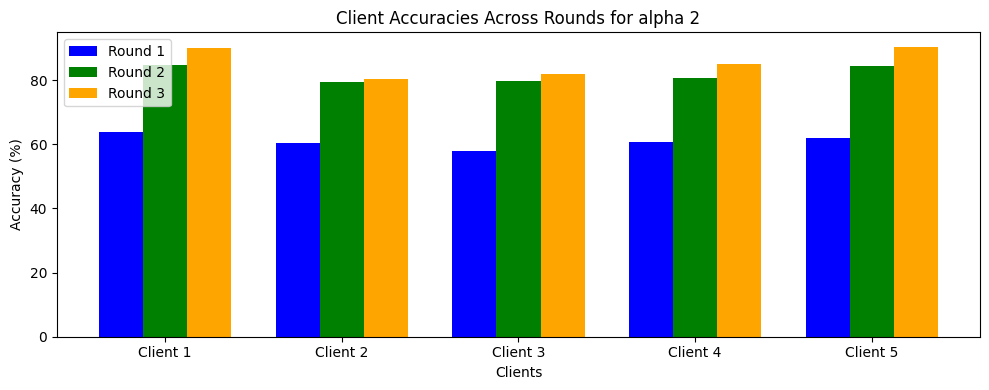

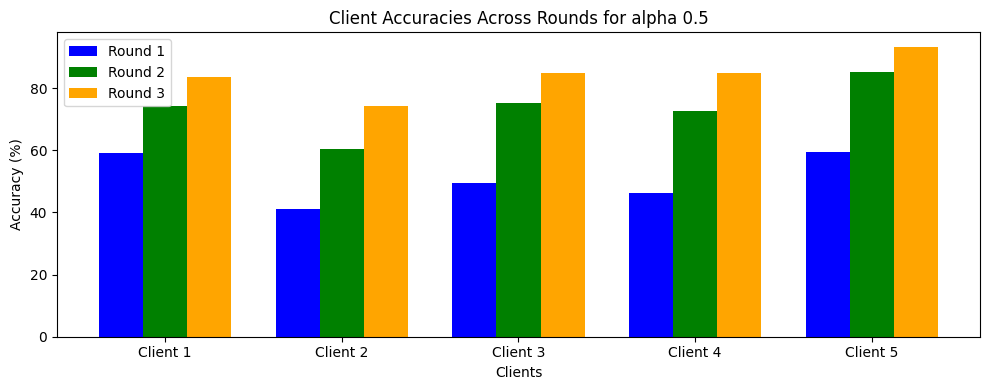

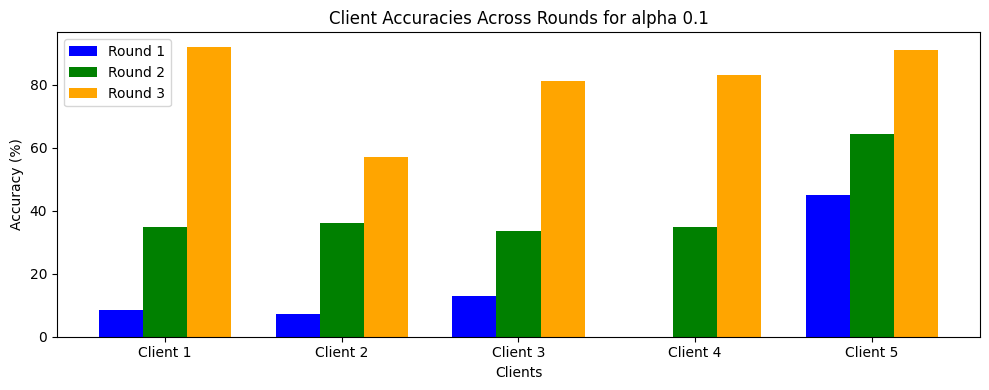

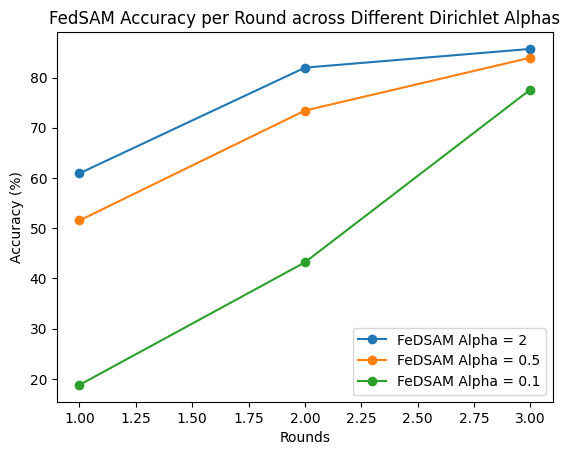

In [ ]:
# print(sam_client_accuracies[0][2])
# Extract the number of clients and rounds
for i in range(len(dirichlet_alphas)):
  num_clients = len(clinet_scaf_acc_per_alpha[i][0])

  rounds = len(clinet_scaf_acc_per_alpha[0])

  # Plotting the bar plots for each round
  x = np.arange(num_clients)  # Client indices
  width = 0.25  # Width of each bar

  fig, ax = plt.subplots(figsize=(10, 4))

  # Colors for each round
  colors = ['blue', 'green', 'orange']

  # Add bars for each round
  for round_idx in range(rounds):
      ax.bar(
          x + round_idx * width - (rounds - 1) * width / 2,  # Offset for bars
          clinet_scaf_acc_per_alpha[i][round_idx],  # Accuracy data for the round
          width,  # Width of the bar
          label=f'Round {round_idx + 1}',
          color=colors[round_idx]
      )

  # Add labels, title, and legend
  ax.set_xlabel("Clients")
  ax.set_ylabel("Accuracy (%)")
  ax.set_title(f"Client Accuracies Across Rounds for alpha {dirichlet_alphas[i]}")
  ax.set_xticks(x)
  ax.set_xticklabels([f"Client {i+1}" for i in range(num_clients)])
  ax.legend()

  # Display the plot
  plt.tight_layout()
  plt.show()

plt.figure()
for idx, alpha in enumerate(dirichlet_alphas):
    plt.plot(range(1, rounds + 1), accuracies_per_alpha[idx], marker='o', label=f'FeDSAM Alpha = {alpha}')

plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('FedSAM Accuracy per Round across Different Dirichlet Alphas')
plt.show()


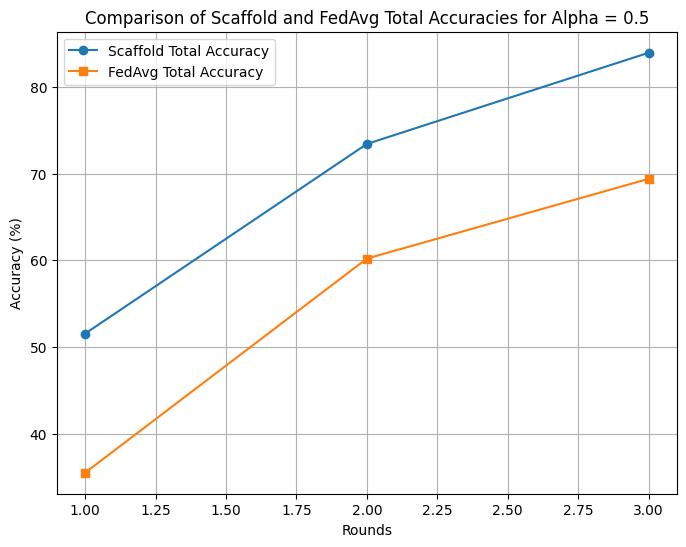

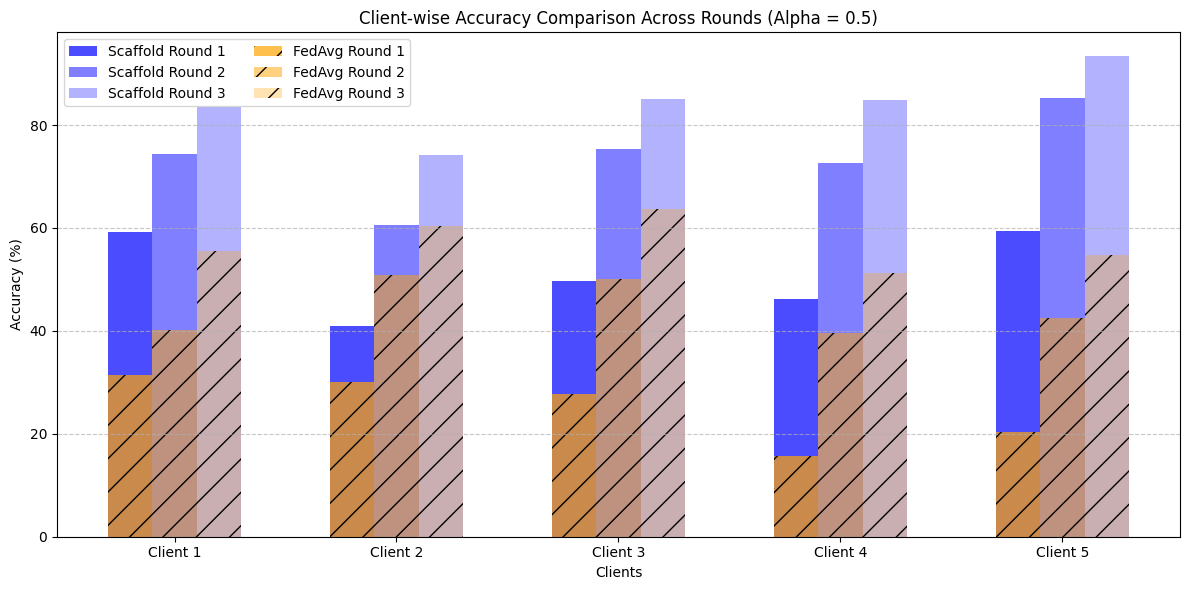

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Placeholder data extracted from the provided images (approximate values)
# FedSAM accuracies
fedsam_round_acc = [51.54, 73.42, 83.94]
fedsam_client_acc = [
    [59.3, 74.35, 83.48],  # Client 1
    [40.98, 60.49, 74.15],  # Client 2
    [49.62, 75.42, 85.02],  # Client 3
    [46.19, 72.65, 84.93],  # Client 4
    [59.40, 85.34, 93.35],  # Client 5
]

# FedAvg accuracies
fedavg_round_acc = [35.5, 60.2, 69.4]
fedavg_client_acc = [
    [31.5, 40.2, 55.6],  # Client 1
    [30.1, 50.8, 60.3],  # Client 2
    [27.8, 50.1, 63.7],  # Client 3
    [15.7, 39.6, 51.2],  # Client 4
    [20.3, 42.5, 54.8],  # Client 5
]

# Comparison of all accuracies for FedSAM and FedAvg
rounds = [1, 2, 3]
plt.figure(figsize=(8, 6))
plt.plot(rounds, fedsam_round_acc, marker='o', label="Scaffold Total Accuracy")
plt.plot(rounds, fedavg_round_acc, marker='s', label="FedAvg Total Accuracy")
plt.xlabel("Rounds")
plt.ylabel("Accuracy (%)")
plt.title("Comparison of Scaffold and FedAvg Total Accuracies for Alpha = 0.5")
plt.legend()
plt.grid(True)
plt.show()

# Combining client-wise accuracy comparisons into a single visualization for all rounds
clients = ['Client 1', 'Client 2', 'Client 3', 'Client 4', 'Client 5']
x = np.arange(len(clients))
width = 0.2  # Width of each bar

# Create a single plot for comparison
plt.figure(figsize=(12, 6))

# Plot FedSAM bars for each round
plt.bar(
    x - width, [fedsam_client_acc[i][0] for i in range(len(clients))], width,
    label="Scaffold Round 1", color='blue', alpha=0.7
)
plt.bar(
    x, [fedsam_client_acc[i][1] for i in range(len(clients))], width,
    label="Scaffold Round 2", color='blue', alpha=0.5
)
plt.bar(
    x + width, [fedsam_client_acc[i][2] for i in range(len(clients))], width,
    label="Scaffold Round 3", color='blue', alpha=0.3
)

# Plot FedAvg bars for each round, overlaid on the same positions
plt.bar(
    x - width, [fedavg_client_acc[i][0] for i in range(len(clients))], width,
    label="FedAvg Round 1", color='orange', alpha=0.7, hatch='/'
)
plt.bar(
    x, [fedavg_client_acc[i][1] for i in range(len(clients))], width,
    label="FedAvg Round 2", color='orange', alpha=0.5, hatch='/'
)
plt.bar(
    x + width, [fedavg_client_acc[i][2] for i in range(len(clients))], width,
    label="FedAvg Round 3", color='orange', alpha=0.3, hatch='/'
)

# Add labels and legend
plt.xlabel("Clients")
plt.ylabel("Accuracy (%)")
plt.title("Client-wise Accuracy Comparison Across Rounds (Alpha = 0.5)")
plt.xticks(x, clients)
plt.legend(ncol=2)  # Display legend in two columns for better clarity
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


# Task 4: Gradient Harmonization

In this task, you will examine how heterogeneity influences the gradient updates sent by each client. Specifically, you will analyze and quantify gradient conflicts at varying levels of heterogeneity.

First, implement the FedAvg code (You can reuse your task 2 implementation) and integrate the provided conflict-counting function at the end of each round to measure the number of conflicts in different heterogeneous settings.

Next, implement the Gradient Harmonization algorithm to harmonize conflicting gradients.

Finally, evaluate the performance of the harmonized gradients under a 0.1 Dirichlet scenario, and compare the number of conflicts before and after harmonization.

In [ ]:
import builtins
sum = builtins.sum

def cosine_similarity(vec1, vec2):
    return torch.dot(vec1, vec2) / (torch.norm(vec1) * torch.norm(vec2))

def gradient_conflict_counter(client_updates):
    total_conflicts = 0  # Variable to store the total conflicts across all layers
    num_clients = len(client_updates)

    # Iterate over each layer (key) in the client updates
    for layer_name in client_updates[0].keys():
        # Collect vectors for this layer across all clients
        layer_vectors = [client_update[layer_name].view(-1).cpu() for client_update in client_updates]

        # Check pairwise cosine similarity for this layer and count conflicts
        for i in range(num_clients):
            for j in range(i + 1, num_clients):
                sim = cosine_similarity(layer_vectors[i], layer_vectors[j])
                if sim < 0:
                    total_conflicts += 1

    print(f"Total gradient conflicts detected: {total_conflicts}")
    return total_conflicts

def Federated_gradient_conflict(global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders):
    round_avg_updates = []
    round_accuracies = []
    conflict_counts = []
    # To Do
    return round_avg_updates, round_accuracies, conflict_counts

In [ ]:
# Parameters
num_clients = 5
batch_size = 128
rounds = 3
epochs = 20
lr = 0.001
dirichlet_alphas = [2, 0.5, 0.1]

def run_fedconflict(alpha):
    train_loaders, test_loaders,_,_ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)
    global_model_fedavg = SimpleCNN()
    _, round_accuracies,conflict_counts = Federated_gradient_conflict(global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)
    return round_accuracies, conflict_counts

accuracies_per_alpha = []
conflicts_per_alpha = []

for alpha in dirichlet_alphas:
    round_accuracies, conflict_counts = run_fedconflict(alpha)
    accuracies_per_alpha.append(round_accuracies)
    conflicts_per_alpha.append(conflict_counts)



In [ ]:
plt.figure(figsize=(10, 6))

for i, alpha in enumerate(dirichlet_alphas):
    plt.plot(range(1, rounds + 1), conflicts_per_alpha[i], marker='o', label=f'Alpha = {alpha}')

plt.xlabel("Rounds")
plt.ylabel("Number of Gradient Conflicts")
plt.title("Gradient Conflicts Across Rounds for Different Heterogeneity Levels (Dirichlet Alphas)")
plt.legend(title="Heterogeneity Level (Alpha)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [ ]:
def gradient_harmonization(client_updates):
    # To Do
    return client_updates

def Federated_gradient_harmonization(global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders):
    round_accuracies = []  # List to store total accuracy after each round
    pre_harmonization_conflicts = []  # List to store conflicts before harmonization
    post_harmonization_conflicts = []  # List to store conflicts after harmonization
    # To Do
    return round_accuracies, pre_harmonization_conflicts, post_harmonization_conflicts


In [ ]:
# Parameters
num_clients = 5
batch_size = 128
rounds = 3
epochs = 20
lr = 0.001
alpha = 0.1

# Run federated gradient harmonization
train_loaders, test_loaders, _, _ = partition_data(
    train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size
)
global_model_fedavg = SimpleCNN()
round_accuracies, pre_harmonization_conflicts, post_harmonization_conflicts = Federated_gradient_harmonization(
    global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders
)

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, rounds + 1), pre_harmonization_conflicts, marker='o', linestyle='-', label='Conflicts Before Harmonization')
plt.plot(range(1, rounds + 1), post_harmonization_conflicts, marker='x', linestyle='--', label='Conflicts After Harmonization')
plt.xlabel("Rounds")
plt.ylabel("Number of Gradient Conflicts")
plt.title("Gradient Conflicts Across Rounds (Alpha = 0.1)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.subplot(1, 2, 2)
plt.plot(range(1, rounds + 1), round_accuracies, marker='s', color='b')
plt.xlabel("Rounds")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Across Rounds (Alpha = 0.1)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


# Task 5: FedSam

In this task, you will explore Sharpness-Aware Minimization (SAM) in a federated learning setting by implementing the FedSAM algorithm. As with previous tasks, evaluate its performance in a 0.1 Dirichlet heterogeneous scenario.

In [7]:
# def apply_sam_perturbation(local_model, criterion, x_train, y_train, rho):
#     # To Do
#     pass
def apply_sam_perturbation(local_model, criterion, x_train, y_train, rho):
    local_model.train()
    x_train, y_train = x_train.to(device), y_train.to(device)

    # Forward pass to calculate loss
    outputs = local_model(x_train)
    loss = criterion(outputs, y_train)

    # Compute gradients
    loss.backward()
    gradients = {name: param.grad for name, param in local_model.named_parameters() if param.grad is not None}

    # Calculate perturbation and apply it
    with torch.no_grad():
        for name, param in local_model.named_parameters():
            if param.grad is not None:
                grad = gradients[name]
                norm = torch.norm(grad)
                if norm != 0:
                    perturbation = rho * grad / norm
                    param.add_(perturbation)  # Apply the perturbation

    return loss  # Return the original loss for tracking


# def local_train_sam(model, train_loader, epochs, lr, rho=0.0001):
#     overall_update = {name: torch.zeros_like(param) for name, param in model.state_dict().items()}
#     # To do
#     return overall_update
def local_train_sam(model, train_loader, epochs, lr, rho=0.0001):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    overall_update = {name: torch.zeros_like(param, device=device) for name, param in model.state_dict().items()}

    for epoch in range(epochs):
        epoch_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for x_train, y_train in progress_bar:
            # Move data to the appropriate device
            x_train, y_train = x_train.to(device), y_train.to(device)

            # Apply SAM perturbation and calculate loss
            optimizer.zero_grad()
            apply_sam_perturbation(model, criterion, x_train, y_train, rho)

            # Forward pass with the perturbed model
            outputs = model(x_train)
            loss = criterion(outputs, y_train)

            # Backward pass and SGD update
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            progress_bar.set_postfix({"Loss": epoch_loss / len(train_loader)})

        print(f"Client Training: Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

    # Compute the overall model update
    for name, param in model.state_dict().items():
        overall_update[name] = param.clone()

    return overall_update


# def federated_training_sam(global_model, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr):
#     round_accuracies = []
#     # To Do
#     return round_accuracies
def federated_training_sam(global_model, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr, rho=0.0001):
    global_model.to(device)
    round_accuracies = []
    sam_client_accuracies = []

    for round_num in range(rounds):
        print(f"\n--- Federated Round {round_num + 1}/{rounds} ---")
        client_updates = []
        client_sample_counts = []

        for client_id in range(num_clients):
            print(f"Client {client_id + 1}/{num_clients}")
            client_model = SimpleCNN().to(device)
            client_model.load_state_dict(global_model.state_dict())
            train_loader = train_loaders[client_id]

            # Count samples for the client
            num_samples = len(train_loader.dataset)
            client_sample_counts.append(num_samples)

            # Local training with SAM
            update = local_train_sam(client_model, train_loader, epochs, local_lr, rho)
            client_updates.append(update)

        # Compute weights for aggregation
        total_samples = sum(client_sample_counts)
        client_weights = [count / total_samples for count in client_sample_counts]

        # Aggregate updates with weights
        aggregated_update = {name: torch.zeros_like(param, device=device) for name, param in global_model.state_dict().items()}
        for client_id, update in enumerate(client_updates):
            for name in aggregated_update:
                # aggregated_update[name] += client_weights[client_id] * update[name]
                aggregated_update[name] += update[name]/num_clients

        # Update global model
        global_model_state = global_model.state_dict()
        for name in global_model_state:
            global_model_state[name] += aggregated_update[name]

        global_model.load_state_dict(global_model_state)

        # Evaluate global model
        samclientacc, accuracy = evaluate_model(global_model, test_loaders)
        round_accuracies.append(accuracy)
        sam_client_accuracies.append(samclientacc)
        print(f"Round {round_num + 1} Accuracy: {accuracy:.2f}%")

    return round_accuracies, sam_client_accuracies


In [ ]:
# Run the FedSAM experiment
num_clients = 5
rounds = 3
epochs = 20
lr = 0.01
batch_size = 128
dirichlet_alphas = [2,0.5,0.1]

def run_fedsam(alpha):
    # Partition data with a Dirichlet alpha of 0.1
    train_loaders, test_loaders, _, _ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)
    global_model_sam = SimpleCNN()
    round_accuracies, client_nsam_acc = federated_training_sam(global_model_sam, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr=lr)
    return round_accuracies, client_nsam_acc

# Run FedSAM and get accuracy per round
sam_accuracies = []
client_nsam_acc = []
for alpha in dirichlet_alphas:
    round_accuracies, acc = run_fedsam(alpha)
    sam_accuracies.append(round_accuracies)
    client_nsam_acc.append(acc)
# sam_accuracies = run_fedsam()




--- Federated Round 1/3 ---
Client 1/5


Client Training: Epoch 1/20, Loss: 1.4397


Client Training: Epoch 2/20, Loss: 1.3861


Client Training: Epoch 3/20, Loss: 1.0768


Client Training: Epoch 4/20, Loss: 0.8474


Client Training: Epoch 5/20, Loss: 0.6699


Client Training: Epoch 6/20, Loss: 0.5556


Client Training: Epoch 7/20, Loss: 0.4874


Client Training: Epoch 8/20, Loss: 0.4428


Client Training: Epoch 9/20, Loss: 0.4122


Client Training: Epoch 10/20, Loss: 0.3890


Client Training: Epoch 11/20, Loss: 0.3665


Client Training: Epoch 12/20, Loss: 0.3516


Client Training: Epoch 13/20, Loss: 0.3407


Client Training: Epoch 14/20, Loss: 0.3327


Client Training: Epoch 15/20, Loss: 0.3266


Client Training: Epoch 16/20, Loss: 0.3170


Client Training: Epoch 17/20, Loss: 0.3052


Client Training: Epoch 18/20, Loss: 0.2984


Client Training: Epoch 19/20, Loss: 0.2904


Client Training: Epoch 20/20, Loss: 0.2818
Client 2/5


Client Training: Epoch 1/20, Loss: 1.6942


Client Training: Epoch 2/20, Loss: 1.7980


Client Training: Epoch 3/20, Loss: 1.5716


Client Training: Epoch 4/20, Loss: 1.2771


Client Training: Epoch 5/20, Loss: 0.9897


Client Training: Epoch 6/20, Loss: 0.7543


Client Training: Epoch 7/20, Loss: 0.6072


Client Training: Epoch 8/20, Loss: 0.5157


Client Training: Epoch 9/20, Loss: 0.4572


Client Training: Epoch 10/20, Loss: 0.4224


Client Training: Epoch 11/20, Loss: 0.4007


Client Training: Epoch 12/20, Loss: 0.3850


Client Training: Epoch 13/20, Loss: 0.3761


Client Training: Epoch 14/20, Loss: 0.3771


Client Training: Epoch 15/20, Loss: 0.3639


Client Training: Epoch 16/20, Loss: 0.3592


Client Training: Epoch 17/20, Loss: 0.3519


Client Training: Epoch 18/20, Loss: 0.3506


Client Training: Epoch 19/20, Loss: 0.3399


Client Training: Epoch 20/20, Loss: 0.3283
Client 3/5


Client Training: Epoch 1/20, Loss: 1.9537


Client Training: Epoch 2/20, Loss: 1.9980


Client Training: Epoch 3/20, Loss: 1.8327


Client Training: Epoch 4/20, Loss: 1.5700


Client Training: Epoch 5/20, Loss: 1.2708


Client Training: Epoch 6/20, Loss: 1.0287


Client Training: Epoch 7/20, Loss: 0.8653


Client Training: Epoch 8/20, Loss: 0.7586


Client Training: Epoch 9/20, Loss: 0.6907


Client Training: Epoch 10/20, Loss: 0.6437


Client Training: Epoch 11/20, Loss: 0.6139


Client Training: Epoch 12/20, Loss: 0.5919


Client Training: Epoch 13/20, Loss: 0.5778


Client Training: Epoch 14/20, Loss: 0.5617


Client Training: Epoch 15/20, Loss: 0.5425


Client Training: Epoch 16/20, Loss: 0.5200


Client Training: Epoch 17/20, Loss: 0.4972


Client Training: Epoch 18/20, Loss: 0.4755


Client Training: Epoch 19/20, Loss: 0.4556


Client Training: Epoch 20/20, Loss: 0.4355
Client 4/5


Client Training: Epoch 1/20, Loss: 1.8481


Client Training: Epoch 2/20, Loss: 1.9754


Client Training: Epoch 3/20, Loss: 1.7635


Client Training: Epoch 4/20, Loss: 1.4341


Client Training: Epoch 5/20, Loss: 1.1213


Client Training: Epoch 6/20, Loss: 0.8631


Client Training: Epoch 7/20, Loss: 0.7026


Client Training: Epoch 8/20, Loss: 0.6150


Client Training: Epoch 9/20, Loss: 0.5677


Client Training: Epoch 10/20, Loss: 0.5327


Client Training: Epoch 11/20, Loss: 0.4989


Client Training: Epoch 12/20, Loss: 0.4771


Client Training: Epoch 13/20, Loss: 0.4569


Client Training: Epoch 14/20, Loss: 0.4481


Client Training: Epoch 15/20, Loss: 0.4450


Client Training: Epoch 16/20, Loss: 0.4372


Client Training: Epoch 17/20, Loss: 0.4269


Client Training: Epoch 18/20, Loss: 0.4179


Client Training: Epoch 19/20, Loss: 0.4015


Client Training: Epoch 20/20, Loss: 0.3816
Client 5/5


Client Training: Epoch 1/20, Loss: 1.5167


Client Training: Epoch 2/20, Loss: 1.4330


Client Training: Epoch 3/20, Loss: 1.1224


Client Training: Epoch 4/20, Loss: 0.8706


Client Training: Epoch 5/20, Loss: 0.6794


Client Training: Epoch 6/20, Loss: 0.5525


Client Training: Epoch 7/20, Loss: 0.4685


Client Training: Epoch 8/20, Loss: 0.4117


Client Training: Epoch 9/20, Loss: 0.3739


Client Training: Epoch 10/20, Loss: 0.3466


Client Training: Epoch 11/20, Loss: 0.3313


Client Training: Epoch 12/20, Loss: 0.3218


Client Training: Epoch 13/20, Loss: 0.3172


Client Training: Epoch 14/20, Loss: 0.3140


Client Training: Epoch 15/20, Loss: 0.3087


Client Training: Epoch 16/20, Loss: 0.3040


Client Training: Epoch 17/20, Loss: 0.2986


Client Training: Epoch 18/20, Loss: 0.2927


Client Training: Epoch 19/20, Loss: 0.2847


Client Training: Epoch 20/20, Loss: 0.2743

Evaluating Client 0
Client 0 Accuracy: 68.21%

Evaluating Client 1
Client 1 Accuracy: 74.63%

Evaluating Client 2
Client 2 Accuracy: 63.78%

Evaluating Client 3
Client 3 Accuracy: 64.50%

Evaluating Client 4
Client 4 Accuracy: 63.46%
Total Accuracy: 67.12%
Round 1 Accuracy: 67.12%

--- Federated Round 2/3 ---
Client 1/5


Client Training: Epoch 1/20, Loss: 0.2770


Client Training: Epoch 2/20, Loss: 0.2562


Client Training: Epoch 3/20, Loss: 0.2255


Client Training: Epoch 4/20, Loss: 0.2055


Client Training: Epoch 5/20, Loss: 0.1901


Client Training: Epoch 6/20, Loss: 0.1780


Client Training: Epoch 7/20, Loss: 0.1676


Client Training: Epoch 8/20, Loss: 0.1578


Client Training: Epoch 9/20, Loss: 0.1499


Client Training: Epoch 10/20, Loss: 0.1432


Client Training: Epoch 11/20, Loss: 0.1363


Client Training: Epoch 12/20, Loss: 0.1292


Client Training: Epoch 13/20, Loss: 0.1224


Client Training: Epoch 14/20, Loss: 0.1161


Client Training: Epoch 15/20, Loss: 0.1102


Client Training: Epoch 16/20, Loss: 0.1046


Client Training: Epoch 17/20, Loss: 0.0995


Client Training: Epoch 18/20, Loss: 0.0946


Client Training: Epoch 19/20, Loss: 0.0901


Client Training: Epoch 20/20, Loss: 0.0859
Client 2/5


Client Training: Epoch 1/20, Loss: 0.2390


Client Training: Epoch 2/20, Loss: 0.2521


Client Training: Epoch 3/20, Loss: 0.2264


Client Training: Epoch 4/20, Loss: 0.2041


Client Training: Epoch 5/20, Loss: 0.1838


Client Training: Epoch 6/20, Loss: 0.1677


Client Training: Epoch 7/20, Loss: 0.1540


Client Training: Epoch 8/20, Loss: 0.1427


Client Training: Epoch 9/20, Loss: 0.1331


Client Training: Epoch 10/20, Loss: 0.1245


Client Training: Epoch 11/20, Loss: 0.1171


Client Training: Epoch 12/20, Loss: 0.1106


Client Training: Epoch 13/20, Loss: 0.1046


Client Training: Epoch 14/20, Loss: 0.0993


Client Training: Epoch 15/20, Loss: 0.0946


Client Training: Epoch 16/20, Loss: 0.0902


Client Training: Epoch 17/20, Loss: 0.0862


Client Training: Epoch 18/20, Loss: 0.0824


Client Training: Epoch 19/20, Loss: 0.0788


Client Training: Epoch 20/20, Loss: 0.0754
Client 3/5


Client Training: Epoch 1/20, Loss: 0.3692


Client Training: Epoch 2/20, Loss: 0.3367


Client Training: Epoch 3/20, Loss: 0.2899


Client Training: Epoch 4/20, Loss: 0.2533


Client Training: Epoch 5/20, Loss: 0.2255


Client Training: Epoch 6/20, Loss: 0.2031


Client Training: Epoch 7/20, Loss: 0.1849


Client Training: Epoch 8/20, Loss: 0.1695


Client Training: Epoch 9/20, Loss: 0.1567


Client Training: Epoch 10/20, Loss: 0.1457


Client Training: Epoch 11/20, Loss: 0.1364


Client Training: Epoch 12/20, Loss: 0.1281


Client Training: Epoch 13/20, Loss: 0.1205


Client Training: Epoch 14/20, Loss: 0.1140


Client Training: Epoch 15/20, Loss: 0.1080


Client Training: Epoch 16/20, Loss: 0.1026


Client Training: Epoch 17/20, Loss: 0.0975


Client Training: Epoch 18/20, Loss: 0.0929


Client Training: Epoch 19/20, Loss: 0.0886


Client Training: Epoch 20/20, Loss: 0.0846
Client 4/5


Client Training: Epoch 1/20, Loss: 0.3984


Client Training: Epoch 2/20, Loss: 0.3297


Client Training: Epoch 3/20, Loss: 0.2844


Client Training: Epoch 4/20, Loss: 0.2526


Client Training: Epoch 5/20, Loss: 0.2278


Client Training: Epoch 6/20, Loss: 0.2079


Client Training: Epoch 7/20, Loss: 0.1910


Client Training: Epoch 8/20, Loss: 0.1761


Client Training: Epoch 9/20, Loss: 0.1633


Client Training: Epoch 10/20, Loss: 0.1521


Client Training: Epoch 11/20, Loss: 0.1421


Client Training: Epoch 12/20, Loss: 0.1333


Client Training: Epoch 13/20, Loss: 0.1253


Client Training: Epoch 14/20, Loss: 0.1182


Client Training: Epoch 15/20, Loss: 0.1118


Client Training: Epoch 16/20, Loss: 0.1059


Client Training: Epoch 17/20, Loss: 0.1005


Client Training: Epoch 18/20, Loss: 0.0956


Client Training: Epoch 19/20, Loss: 0.0911


Client Training: Epoch 20/20, Loss: 0.0870
Client 5/5


Client Training: Epoch 1/20, Loss: 0.2137


Client Training: Epoch 2/20, Loss: 0.2262


Client Training: Epoch 3/20, Loss: 0.2094


Client Training: Epoch 4/20, Loss: 0.1915


Client Training: Epoch 5/20, Loss: 0.1765


Client Training: Epoch 6/20, Loss: 0.1641


Client Training: Epoch 7/20, Loss: 0.1538


Client Training: Epoch 8/20, Loss: 0.1450


Client Training: Epoch 9/20, Loss: 0.1372


Client Training: Epoch 10/20, Loss: 0.1301


Client Training: Epoch 11/20, Loss: 0.1239


Client Training: Epoch 12/20, Loss: 0.1180


Client Training: Epoch 13/20, Loss: 0.1127


Client Training: Epoch 14/20, Loss: 0.1078


Client Training: Epoch 15/20, Loss: 0.1029


Client Training: Epoch 16/20, Loss: 0.0984


Client Training: Epoch 17/20, Loss: 0.0941


Client Training: Epoch 18/20, Loss: 0.0901


Client Training: Epoch 19/20, Loss: 0.0863


Client Training: Epoch 20/20, Loss: 0.0828

Evaluating Client 0
Client 0 Accuracy: 84.62%

Evaluating Client 1
Client 1 Accuracy: 87.09%

Evaluating Client 2
Client 2 Accuracy: 85.37%

Evaluating Client 3
Client 3 Accuracy: 83.80%

Evaluating Client 4
Client 4 Accuracy: 85.45%
Total Accuracy: 85.27%
Round 2 Accuracy: 85.27%

--- Federated Round 3/3 ---
Client 1/5


Client Training: Epoch 1/20, Loss: 2.6071


Client Training: Epoch 2/20, Loss: 0.6191


Client Training: Epoch 3/20, Loss: 0.3179


Client Training: Epoch 4/20, Loss: 0.2648


Client Training: Epoch 5/20, Loss: 0.2132


Client Training: Epoch 6/20, Loss: 0.1794


Client Training: Epoch 7/20, Loss: 0.1611


Client Training: Epoch 8/20, Loss: 0.1466


Client Training: Epoch 9/20, Loss: 0.1306


Client Training: Epoch 10/20, Loss: 0.1195


Client Training: Epoch 11/20, Loss: 0.1101


Client Training: Epoch 12/20, Loss: 0.0998


Client Training: Epoch 13/20, Loss: 0.0931


Client Training: Epoch 14/20, Loss: 0.0868


Client Training: Epoch 15/20, Loss: 0.0835


Client Training: Epoch 16/20, Loss: 0.0827


Client Training: Epoch 17/20, Loss: 0.0771


Client Training: Epoch 18/20, Loss: 0.0715


Client Training: Epoch 19/20, Loss: 0.0677


Client Training: Epoch 20/20, Loss: 0.0647
Client 2/5


Client Training: Epoch 1/20, Loss: 1.4912


Client Training: Epoch 2/20, Loss: 0.2780


Client Training: Epoch 3/20, Loss: 0.1718


Client Training: Epoch 4/20, Loss: 0.1408


Client Training: Epoch 5/20, Loss: 0.1210


Client Training: Epoch 6/20, Loss: 0.1065


Client Training: Epoch 7/20, Loss: 0.0930


Client Training: Epoch 8/20, Loss: 0.0812


Client Training: Epoch 9/20, Loss: 0.0728


Client Training: Epoch 10/20, Loss: 0.0664


Client Training: Epoch 11/20, Loss: 0.0606


Client Training: Epoch 12/20, Loss: 0.0548


Client Training: Epoch 13/20, Loss: 0.0498


Client Training: Epoch 14/20, Loss: 0.0456


Client Training: Epoch 15/20, Loss: 0.0418


Client Training: Epoch 16/20, Loss: 0.0384


Client Training: Epoch 17/20, Loss: 0.0355


Client Training: Epoch 18/20, Loss: 0.0330


Client Training: Epoch 19/20, Loss: 0.0306


Client Training: Epoch 20/20, Loss: 0.0285
Client 3/5


Client Training: Epoch 1/20, Loss: 1.6824


Client Training: Epoch 2/20, Loss: 0.4621


Client Training: Epoch 3/20, Loss: 0.2148


Client Training: Epoch 4/20, Loss: 0.1550


Client Training: Epoch 5/20, Loss: 0.1195


Client Training: Epoch 6/20, Loss: 0.0961


Client Training: Epoch 7/20, Loss: 0.0786


Client Training: Epoch 8/20, Loss: 0.0654


Client Training: Epoch 9/20, Loss: 0.0552


Client Training: Epoch 10/20, Loss: 0.0472


Client Training: Epoch 11/20, Loss: 0.0409


Client Training: Epoch 12/20, Loss: 0.0357


Client Training: Epoch 13/20, Loss: 0.0315


Client Training: Epoch 14/20, Loss: 0.0278


Client Training: Epoch 15/20, Loss: 0.0247


Client Training: Epoch 16/20, Loss: 0.0219


Client Training: Epoch 17/20, Loss: 0.0195


Client Training: Epoch 18/20, Loss: 0.0174


Client Training: Epoch 19/20, Loss: 0.0155


Client Training: Epoch 20/20, Loss: 0.0139
Client 4/5


Client Training: Epoch 1/20, Loss: 1.1933


Client Training: Epoch 2/20, Loss: 0.3510


Client Training: Epoch 3/20, Loss: 0.2020


Client Training: Epoch 4/20, Loss: 0.1399


Client Training: Epoch 5/20, Loss: 0.1119


Client Training: Epoch 6/20, Loss: 0.0947


Client Training: Epoch 7/20, Loss: 0.0818


Client Training: Epoch 8/20, Loss: 0.0712


Client Training: Epoch 9/20, Loss: 0.0623


Client Training: Epoch 10/20, Loss: 0.0545


Client Training: Epoch 11/20, Loss: 0.0478


Client Training: Epoch 12/20, Loss: 0.0422


Client Training: Epoch 13/20, Loss: 0.0373


Client Training: Epoch 14/20, Loss: 0.0332


Client Training: Epoch 15/20, Loss: 0.0297


Client Training: Epoch 16/20, Loss: 0.0268


Client Training: Epoch 17/20, Loss: 0.0242


Client Training: Epoch 18/20, Loss: 0.0220


Client Training: Epoch 19/20, Loss: 0.0200


Client Training: Epoch 20/20, Loss: 0.0182
Client 5/5


Client Training: Epoch 1/20, Loss: 1.0702


Client Training: Epoch 2/20, Loss: 0.3459


Client Training: Epoch 3/20, Loss: 0.1985


Client Training: Epoch 4/20, Loss: 0.1508


Client Training: Epoch 5/20, Loss: 0.1223


Client Training: Epoch 6/20, Loss: 0.1017


Client Training: Epoch 7/20, Loss: 0.0874


Client Training: Epoch 8/20, Loss: 0.0767


Client Training: Epoch 9/20, Loss: 0.0684


Client Training: Epoch 10/20, Loss: 0.0615


Client Training: Epoch 11/20, Loss: 0.0555


Client Training: Epoch 12/20, Loss: 0.0506


Client Training: Epoch 13/20, Loss: 0.0464


Client Training: Epoch 14/20, Loss: 0.0429


Client Training: Epoch 15/20, Loss: 0.0400


Client Training: Epoch 16/20, Loss: 0.0375


Client Training: Epoch 17/20, Loss: 0.0354


Client Training: Epoch 18/20, Loss: 0.0334


Client Training: Epoch 19/20, Loss: 0.0314


Client Training: Epoch 20/20, Loss: 0.0292

Evaluating Client 0
Client 0 Accuracy: 88.78%

Evaluating Client 1
Client 1 Accuracy: 91.76%

Evaluating Client 2
Client 2 Accuracy: 90.14%

Evaluating Client 3
Client 3 Accuracy: 91.99%

Evaluating Client 4
Client 4 Accuracy: 91.83%
Total Accuracy: 90.88%
Round 3 Accuracy: 90.88%

--- Federated Round 1/3 ---
Client 1/5


Client Training: Epoch 1/20, Loss: 1.1143


Client Training: Epoch 2/20, Loss: 1.0807


Client Training: Epoch 3/20, Loss: 0.9947


Client Training: Epoch 4/20, Loss: 0.8784


Client Training: Epoch 5/20, Loss: 0.7572


Client Training: Epoch 6/20, Loss: 0.6629


Client Training: Epoch 7/20, Loss: 0.6042


Client Training: Epoch 8/20, Loss: 0.5693


Client Training: Epoch 9/20, Loss: 0.5449


Client Training: Epoch 10/20, Loss: 0.5294


Client Training: Epoch 11/20, Loss: 0.5161


Client Training: Epoch 12/20, Loss: 0.4965


Client Training: Epoch 13/20, Loss: 0.4718


Client Training: Epoch 14/20, Loss: 0.4486


Client Training: Epoch 15/20, Loss: 0.4233


Client Training: Epoch 16/20, Loss: 0.3949


Client Training: Epoch 17/20, Loss: 0.3670


Client Training: Epoch 18/20, Loss: 0.3407


Client Training: Epoch 19/20, Loss: 0.3162


Client Training: Epoch 20/20, Loss: 0.2934
Client 2/5


Client Training: Epoch 1/20, Loss: 1.2641


Client Training: Epoch 2/20, Loss: 1.0832


Client Training: Epoch 3/20, Loss: 0.8499


Client Training: Epoch 4/20, Loss: 0.6633


Client Training: Epoch 5/20, Loss: 0.5357


Client Training: Epoch 6/20, Loss: 0.4467


Client Training: Epoch 7/20, Loss: 0.3903


Client Training: Epoch 8/20, Loss: 0.3510


Client Training: Epoch 9/20, Loss: 0.3274


Client Training: Epoch 10/20, Loss: 0.3102


Client Training: Epoch 11/20, Loss: 0.2975


Client Training: Epoch 12/20, Loss: 0.2887


Client Training: Epoch 13/20, Loss: 0.2777


Client Training: Epoch 14/20, Loss: 0.2683


Client Training: Epoch 15/20, Loss: 0.2590


Client Training: Epoch 16/20, Loss: 0.2503


Client Training: Epoch 17/20, Loss: 0.2399


Client Training: Epoch 18/20, Loss: 0.2288


Client Training: Epoch 19/20, Loss: 0.2192


Client Training: Epoch 20/20, Loss: 0.2098
Client 3/5


Client Training: Epoch 1/20, Loss: 1.1122


Client Training: Epoch 2/20, Loss: 1.0433


Client Training: Epoch 3/20, Loss: 0.9429


Client Training: Epoch 4/20, Loss: 0.8229


Client Training: Epoch 5/20, Loss: 0.6940


Client Training: Epoch 6/20, Loss: 0.5789


Client Training: Epoch 7/20, Loss: 0.4945


Client Training: Epoch 8/20, Loss: 0.4482


Client Training: Epoch 9/20, Loss: 0.4268


Client Training: Epoch 10/20, Loss: 0.4164


Client Training: Epoch 11/20, Loss: 0.4113


Client Training: Epoch 12/20, Loss: 0.4069


Client Training: Epoch 13/20, Loss: 0.4031


Client Training: Epoch 14/20, Loss: 0.3945


Client Training: Epoch 15/20, Loss: 0.3836


Client Training: Epoch 16/20, Loss: 0.3697


Client Training: Epoch 17/20, Loss: 0.3548


Client Training: Epoch 18/20, Loss: 0.3386


Client Training: Epoch 19/20, Loss: 0.3210


Client Training: Epoch 20/20, Loss: 0.3028
Client 4/5


Client Training: Epoch 1/20, Loss: 1.0192


Client Training: Epoch 2/20, Loss: 0.9233


Client Training: Epoch 3/20, Loss: 0.7200


Client Training: Epoch 4/20, Loss: 0.5555


Client Training: Epoch 5/20, Loss: 0.4489


Client Training: Epoch 6/20, Loss: 0.3886


Client Training: Epoch 7/20, Loss: 0.3531


Client Training: Epoch 8/20, Loss: 0.3302


Client Training: Epoch 9/20, Loss: 0.3132


Client Training: Epoch 10/20, Loss: 0.2991


Client Training: Epoch 11/20, Loss: 0.2869


Client Training: Epoch 12/20, Loss: 0.2755


Client Training: Epoch 13/20, Loss: 0.2658


Client Training: Epoch 14/20, Loss: 0.2567


Client Training: Epoch 15/20, Loss: 0.2488


Client Training: Epoch 16/20, Loss: 0.2409


Client Training: Epoch 17/20, Loss: 0.2339


Client Training: Epoch 18/20, Loss: 0.2268


Client Training: Epoch 19/20, Loss: 0.2201


Client Training: Epoch 20/20, Loss: 0.2130
Client 5/5


Client Training: Epoch 1/20, Loss: 1.2206


Client Training: Epoch 2/20, Loss: 1.1213


Client Training: Epoch 3/20, Loss: 0.9460


Client Training: Epoch 4/20, Loss: 0.7900


Client Training: Epoch 5/20, Loss: 0.6624


Client Training: Epoch 6/20, Loss: 0.5795


Client Training: Epoch 7/20, Loss: 0.5297


Client Training: Epoch 8/20, Loss: 0.4957


Client Training: Epoch 9/20, Loss: 0.4717


Client Training: Epoch 10/20, Loss: 0.4549


Client Training: Epoch 11/20, Loss: 0.4423


Client Training: Epoch 12/20, Loss: 0.4310


Client Training: Epoch 13/20, Loss: 0.4193


Client Training: Epoch 14/20, Loss: 0.4054


Client Training: Epoch 15/20, Loss: 0.3900


Client Training: Epoch 16/20, Loss: 0.3744


Client Training: Epoch 17/20, Loss: 0.3581


Client Training: Epoch 18/20, Loss: 0.3406


Client Training: Epoch 19/20, Loss: 0.3222


Client Training: Epoch 20/20, Loss: 0.3040

Evaluating Client 0
Client 0 Accuracy: 68.45%

Evaluating Client 1
Client 1 Accuracy: 46.79%

Evaluating Client 2
Client 2 Accuracy: 71.55%

Evaluating Client 3
Client 3 Accuracy: 57.90%

Evaluating Client 4
Client 4 Accuracy: 49.51%
Total Accuracy: 58.07%
Round 1 Accuracy: 58.07%

--- Federated Round 2/3 ---
Client 1/5


Client Training: Epoch 1/20, Loss: 0.3858


Client Training: Epoch 2/20, Loss: 0.2700


Client Training: Epoch 3/20, Loss: 0.2189


Client Training: Epoch 4/20, Loss: 0.1950


Client Training: Epoch 5/20, Loss: 0.1780


Client Training: Epoch 6/20, Loss: 0.1649


Client Training: Epoch 7/20, Loss: 0.1540


Client Training: Epoch 8/20, Loss: 0.1445


Client Training: Epoch 9/20, Loss: 0.1362


Client Training: Epoch 10/20, Loss: 0.1288


Client Training: Epoch 11/20, Loss: 0.1221


Client Training: Epoch 12/20, Loss: 0.1160


Client Training: Epoch 13/20, Loss: 0.1103


Client Training: Epoch 14/20, Loss: 0.1052


Client Training: Epoch 15/20, Loss: 0.1004


Client Training: Epoch 16/20, Loss: 0.0961


Client Training: Epoch 17/20, Loss: 0.0920


Client Training: Epoch 18/20, Loss: 0.0881


Client Training: Epoch 19/20, Loss: 0.0845


Client Training: Epoch 20/20, Loss: 0.0810
Client 2/5


Client Training: Epoch 1/20, Loss: 0.2937


Client Training: Epoch 2/20, Loss: 0.2103


Client Training: Epoch 3/20, Loss: 0.1789


Client Training: Epoch 4/20, Loss: 0.1598


Client Training: Epoch 5/20, Loss: 0.1458


Client Training: Epoch 6/20, Loss: 0.1349


Client Training: Epoch 7/20, Loss: 0.1258


Client Training: Epoch 8/20, Loss: 0.1177


Client Training: Epoch 9/20, Loss: 0.1104


Client Training: Epoch 10/20, Loss: 0.1036


Client Training: Epoch 11/20, Loss: 0.0974


Client Training: Epoch 12/20, Loss: 0.0917


Client Training: Epoch 13/20, Loss: 0.0865


Client Training: Epoch 14/20, Loss: 0.0817


Client Training: Epoch 15/20, Loss: 0.0772


Client Training: Epoch 16/20, Loss: 0.0731


Client Training: Epoch 17/20, Loss: 0.0693


Client Training: Epoch 18/20, Loss: 0.0657


Client Training: Epoch 19/20, Loss: 0.0624


Client Training: Epoch 20/20, Loss: 0.0593
Client 3/5


Client Training: Epoch 1/20, Loss: 0.2824


Client Training: Epoch 2/20, Loss: 0.2262


Client Training: Epoch 3/20, Loss: 0.1959


Client Training: Epoch 4/20, Loss: 0.1746


Client Training: Epoch 5/20, Loss: 0.1582


Client Training: Epoch 6/20, Loss: 0.1449


Client Training: Epoch 7/20, Loss: 0.1337


Client Training: Epoch 8/20, Loss: 0.1244


Client Training: Epoch 9/20, Loss: 0.1162


Client Training: Epoch 10/20, Loss: 0.1091


Client Training: Epoch 11/20, Loss: 0.1025


Client Training: Epoch 12/20, Loss: 0.0965


Client Training: Epoch 13/20, Loss: 0.0911


Client Training: Epoch 14/20, Loss: 0.0861


Client Training: Epoch 15/20, Loss: 0.0814


Client Training: Epoch 16/20, Loss: 0.0771


Client Training: Epoch 17/20, Loss: 0.0732


Client Training: Epoch 18/20, Loss: 0.0695


Client Training: Epoch 19/20, Loss: 0.0661


Client Training: Epoch 20/20, Loss: 0.0629
Client 4/5


Client Training: Epoch 1/20, Loss: 0.2118


Client Training: Epoch 2/20, Loss: 0.1631


Client Training: Epoch 3/20, Loss: 0.1460


Client Training: Epoch 4/20, Loss: 0.1340


Client Training: Epoch 5/20, Loss: 0.1244


Client Training: Epoch 6/20, Loss: 0.1163


Client Training: Epoch 7/20, Loss: 0.1094


Client Training: Epoch 8/20, Loss: 0.1032


Client Training: Epoch 9/20, Loss: 0.0977


Client Training: Epoch 10/20, Loss: 0.0926


Client Training: Epoch 11/20, Loss: 0.0880


Client Training: Epoch 12/20, Loss: 0.0837


Client Training: Epoch 13/20, Loss: 0.0799


Client Training: Epoch 14/20, Loss: 0.0762


Client Training: Epoch 15/20, Loss: 0.0728


Client Training: Epoch 16/20, Loss: 0.0695


Client Training: Epoch 17/20, Loss: 0.0665


Client Training: Epoch 18/20, Loss: 0.0636


Client Training: Epoch 19/20, Loss: 0.0609


Client Training: Epoch 20/20, Loss: 0.0584
Client 5/5


Client Training: Epoch 1/20, Loss: 0.3461


Client Training: Epoch 2/20, Loss: 0.2675


Client Training: Epoch 3/20, Loss: 0.2255


Client Training: Epoch 4/20, Loss: 0.2019


Client Training: Epoch 5/20, Loss: 0.1853


Client Training: Epoch 6/20, Loss: 0.1716


Client Training: Epoch 7/20, Loss: 0.1596


Client Training: Epoch 8/20, Loss: 0.1490


Client Training: Epoch 9/20, Loss: 0.1395


Client Training: Epoch 10/20, Loss: 0.1310


Client Training: Epoch 11/20, Loss: 0.1234


Client Training: Epoch 12/20, Loss: 0.1163


Client Training: Epoch 13/20, Loss: 0.1098


Client Training: Epoch 14/20, Loss: 0.1037


Client Training: Epoch 15/20, Loss: 0.0983


Client Training: Epoch 16/20, Loss: 0.0933


Client Training: Epoch 17/20, Loss: 0.0886


Client Training: Epoch 18/20, Loss: 0.0843


Client Training: Epoch 19/20, Loss: 0.0803


Client Training: Epoch 20/20, Loss: 0.0766

Evaluating Client 0
Client 0 Accuracy: 84.46%

Evaluating Client 1
Client 1 Accuracy: 78.74%

Evaluating Client 2
Client 2 Accuracy: 87.88%

Evaluating Client 3
Client 3 Accuracy: 82.50%

Evaluating Client 4
Client 4 Accuracy: 78.30%
Total Accuracy: 82.13%
Round 2 Accuracy: 82.13%

--- Federated Round 3/3 ---
Client 1/5


Client Training: Epoch 1/20, Loss: 3.5476


Client Training: Epoch 2/20, Loss: 0.9890


Client Training: Epoch 3/20, Loss: 0.7949


Client Training: Epoch 4/20, Loss: 0.5287


Client Training: Epoch 5/20, Loss: 0.4227


Client Training: Epoch 6/20, Loss: 0.3795


Client Training: Epoch 7/20, Loss: 0.3187


Client Training: Epoch 8/20, Loss: 0.3930


Client Training: Epoch 9/20, Loss: 0.2623


Client Training: Epoch 10/20, Loss: 0.2531


Client Training: Epoch 11/20, Loss: 0.2224


Client Training: Epoch 12/20, Loss: 0.1720


Client Training: Epoch 13/20, Loss: 0.1534


Client Training: Epoch 14/20, Loss: 0.1426


Client Training: Epoch 15/20, Loss: 0.1334


Client Training: Epoch 16/20, Loss: 0.1286


Client Training: Epoch 17/20, Loss: 0.1238


Client Training: Epoch 18/20, Loss: 0.1152


Client Training: Epoch 19/20, Loss: 0.1059


Client Training: Epoch 20/20, Loss: 0.0981
Client 2/5


Client Training: Epoch 1/20, Loss: 2.4058


Client Training: Epoch 2/20, Loss: 0.3443


Client Training: Epoch 3/20, Loss: 0.1701


Client Training: Epoch 4/20, Loss: 0.1340


Client Training: Epoch 5/20, Loss: 0.1104


Client Training: Epoch 6/20, Loss: 0.0966


Client Training: Epoch 7/20, Loss: 0.0855


Client Training: Epoch 8/20, Loss: 0.0743


Client Training: Epoch 9/20, Loss: 0.0658


Client Training: Epoch 10/20, Loss: 0.0590


Client Training: Epoch 11/20, Loss: 0.0550


Client Training: Epoch 12/20, Loss: 0.0532


Client Training: Epoch 13/20, Loss: 0.0529


Client Training: Epoch 14/20, Loss: 0.0498


Client Training: Epoch 15/20, Loss: 0.0451


Client Training: Epoch 16/20, Loss: 0.0414


Client Training: Epoch 17/20, Loss: 0.0385


Client Training: Epoch 18/20, Loss: 0.0362


Client Training: Epoch 19/20, Loss: 0.0338


Client Training: Epoch 20/20, Loss: 0.0316
Client 3/5


Client Training: Epoch 1/20, Loss: 2.6760


Client Training: Epoch 2/20, Loss: 0.4885


Client Training: Epoch 3/20, Loss: 0.2118


Client Training: Epoch 4/20, Loss: 0.1582


Client Training: Epoch 5/20, Loss: 0.1435


Client Training: Epoch 6/20, Loss: 0.1290


Client Training: Epoch 7/20, Loss: 0.1174


Client Training: Epoch 8/20, Loss: 0.1063


Client Training: Epoch 9/20, Loss: 0.0986


Client Training: Epoch 10/20, Loss: 0.0914


Client Training: Epoch 11/20, Loss: 0.0855


Client Training: Epoch 12/20, Loss: 0.0787


Client Training: Epoch 13/20, Loss: 0.0728


Client Training: Epoch 14/20, Loss: 0.0673


Client Training: Epoch 15/20, Loss: 0.0627


Client Training: Epoch 16/20, Loss: 0.0585


Client Training: Epoch 17/20, Loss: 0.0542


Client Training: Epoch 18/20, Loss: 0.0503


Client Training: Epoch 19/20, Loss: 0.0465


Client Training: Epoch 20/20, Loss: 0.0429
Client 4/5


Client Training: Epoch 1/20, Loss: 1.5723


Client Training: Epoch 2/20, Loss: 0.3177


Client Training: Epoch 3/20, Loss: 0.2008


Client Training: Epoch 4/20, Loss: 0.1467


Client Training: Epoch 5/20, Loss: 0.1149


Client Training: Epoch 6/20, Loss: 0.0954


Client Training: Epoch 7/20, Loss: 0.0828


Client Training: Epoch 8/20, Loss: 0.0736


Client Training: Epoch 9/20, Loss: 0.0658


Client Training: Epoch 10/20, Loss: 0.0590


Client Training: Epoch 11/20, Loss: 0.0534


Client Training: Epoch 12/20, Loss: 0.0485


Client Training: Epoch 13/20, Loss: 0.0442


Client Training: Epoch 14/20, Loss: 0.0405


Client Training: Epoch 15/20, Loss: 0.0372


Client Training: Epoch 16/20, Loss: 0.0343


Client Training: Epoch 17/20, Loss: 0.0317


Client Training: Epoch 18/20, Loss: 0.0294


Client Training: Epoch 19/20, Loss: 0.0273


Client Training: Epoch 20/20, Loss: 0.0255
Client 5/5


Client Training: Epoch 1/20, Loss: 3.0063


Client Training: Epoch 2/20, Loss: 0.4208


Client Training: Epoch 3/20, Loss: 0.2194


Client Training: Epoch 4/20, Loss: 0.1764


Client Training: Epoch 5/20, Loss: 0.1474


Client Training: Epoch 6/20, Loss: 0.1350


Client Training: Epoch 7/20, Loss: 0.1201


Client Training: Epoch 8/20, Loss: 0.1090


Client Training: Epoch 9/20, Loss: 0.1013


Client Training: Epoch 10/20, Loss: 0.0934


Client Training: Epoch 11/20, Loss: 0.0862


Client Training: Epoch 12/20, Loss: 0.0785


Client Training: Epoch 13/20, Loss: 0.0706


Client Training: Epoch 14/20, Loss: 0.0632


Client Training: Epoch 15/20, Loss: 0.0566


Client Training: Epoch 16/20, Loss: 0.0510


Client Training: Epoch 17/20, Loss: 0.0463


Client Training: Epoch 18/20, Loss: 0.0424


Client Training: Epoch 19/20, Loss: 0.0392


Client Training: Epoch 20/20, Loss: 0.0362

Evaluating Client 0
Client 0 Accuracy: 59.66%

Evaluating Client 1
Client 1 Accuracy: 82.79%

Evaluating Client 2
Client 2 Accuracy: 80.65%

Evaluating Client 3
Client 3 Accuracy: 58.91%

Evaluating Client 4
Client 4 Accuracy: 82.36%
Total Accuracy: 72.74%
Round 3 Accuracy: 72.74%

--- Federated Round 1/3 ---
Client 1/5


Client Training: Epoch 1/20, Loss: 0.6128


Client Training: Epoch 2/20, Loss: 0.2577


Client Training: Epoch 3/20, Loss: 0.2338


Client Training: Epoch 4/20, Loss: 0.2103


Client Training: Epoch 5/20, Loss: 0.1798


Client Training: Epoch 6/20, Loss: 0.1466


Client Training: Epoch 7/20, Loss: 0.1167


Client Training: Epoch 8/20, Loss: 0.0953


Client Training: Epoch 9/20, Loss: 0.0810


Client Training: Epoch 10/20, Loss: 0.0725


Client Training: Epoch 11/20, Loss: 0.0669


Client Training: Epoch 12/20, Loss: 0.0627


Client Training: Epoch 13/20, Loss: 0.0591


Client Training: Epoch 14/20, Loss: 0.0558


Client Training: Epoch 15/20, Loss: 0.0528


Client Training: Epoch 16/20, Loss: 0.0498


Client Training: Epoch 17/20, Loss: 0.0472


Client Training: Epoch 18/20, Loss: 0.0448


Client Training: Epoch 19/20, Loss: 0.0426


Client Training: Epoch 20/20, Loss: 0.0407
Client 2/5


Client Training: Epoch 1/20, Loss: 0.8575


Client Training: Epoch 2/20, Loss: 0.5843


Client Training: Epoch 3/20, Loss: 0.5262


Client Training: Epoch 4/20, Loss: 0.4924


Client Training: Epoch 5/20, Loss: 0.4476


Client Training: Epoch 6/20, Loss: 0.3887


Client Training: Epoch 7/20, Loss: 0.3244


Client Training: Epoch 8/20, Loss: 0.2709


Client Training: Epoch 9/20, Loss: 0.2290


Client Training: Epoch 10/20, Loss: 0.1996


Client Training: Epoch 11/20, Loss: 0.1777


Client Training: Epoch 12/20, Loss: 0.1605


Client Training: Epoch 13/20, Loss: 0.1476


Client Training: Epoch 14/20, Loss: 0.1379


Client Training: Epoch 15/20, Loss: 0.1304


Client Training: Epoch 16/20, Loss: 0.1244


Client Training: Epoch 17/20, Loss: 0.1196


Client Training: Epoch 18/20, Loss: 0.1154


Client Training: Epoch 19/20, Loss: 0.1116


Client Training: Epoch 20/20, Loss: 0.1079
Client 3/5


Client Training: Epoch 1/20, Loss: 2.1713


Client Training: Epoch 2/20, Loss: 1.4901


Client Training: Epoch 3/20, Loss: 1.1238


Client Training: Epoch 4/20, Loss: 1.0748


Client Training: Epoch 5/20, Loss: 1.0383


Client Training: Epoch 6/20, Loss: 1.0012


Client Training: Epoch 7/20, Loss: 0.9601


Client Training: Epoch 8/20, Loss: 0.9150


Client Training: Epoch 9/20, Loss: 0.8639


Client Training: Epoch 10/20, Loss: 0.8113


Client Training: Epoch 11/20, Loss: 0.7570


Client Training: Epoch 12/20, Loss: 0.7050


Client Training: Epoch 13/20, Loss: 0.6572


Client Training: Epoch 14/20, Loss: 0.6135


Client Training: Epoch 15/20, Loss: 0.5744


Client Training: Epoch 16/20, Loss: 0.5389


Client Training: Epoch 17/20, Loss: 0.5071


Client Training: Epoch 18/20, Loss: 0.4779


Client Training: Epoch 19/20, Loss: 0.4507


Client Training: Epoch 20/20, Loss: 0.4249
Client 4/5


Client Training: Epoch 1/20, Loss: 0.5518


Client Training: Epoch 2/20, Loss: 0.4561


Client Training: Epoch 3/20, Loss: 0.4140


Client Training: Epoch 4/20, Loss: 0.3677


Client Training: Epoch 5/20, Loss: 0.3155


Client Training: Epoch 6/20, Loss: 0.2697


Client Training: Epoch 7/20, Loss: 0.2361


Client Training: Epoch 8/20, Loss: 0.2161


Client Training: Epoch 9/20, Loss: 0.2042


Client Training: Epoch 10/20, Loss: 0.1962


Client Training: Epoch 11/20, Loss: 0.1899


Client Training: Epoch 12/20, Loss: 0.1832


Client Training: Epoch 13/20, Loss: 0.1764


Client Training: Epoch 14/20, Loss: 0.1691


Client Training: Epoch 15/20, Loss: 0.1611


Client Training: Epoch 16/20, Loss: 0.1530


Client Training: Epoch 17/20, Loss: 0.1445


Client Training: Epoch 18/20, Loss: 0.1358


Client Training: Epoch 19/20, Loss: 0.1268


Client Training: Epoch 20/20, Loss: 0.1179
Client 5/5


Client Training: Epoch 1/20, Loss: 1.0525


Client Training: Epoch 2/20, Loss: 0.4782


Client Training: Epoch 3/20, Loss: 0.4323


Client Training: Epoch 4/20, Loss: 0.4196


Client Training: Epoch 5/20, Loss: 0.4086


Client Training: Epoch 6/20, Loss: 0.3943


Client Training: Epoch 7/20, Loss: 0.3765


Client Training: Epoch 8/20, Loss: 0.3540


Client Training: Epoch 9/20, Loss: 0.3268


Client Training: Epoch 10/20, Loss: 0.2968


Client Training: Epoch 11/20, Loss: 0.2670


Client Training: Epoch 12/20, Loss: 0.2395


Client Training: Epoch 13/20, Loss: 0.2153


Client Training: Epoch 14/20, Loss: 0.1948


Client Training: Epoch 15/20, Loss: 0.1774


Client Training: Epoch 16/20, Loss: 0.1629


Client Training: Epoch 17/20, Loss: 0.1507


Client Training: Epoch 18/20, Loss: 0.1406


Client Training: Epoch 19/20, Loss: 0.1320


Client Training: Epoch 20/20, Loss: 0.1247

Evaluating Client 0
Client 0 Accuracy: 51.24%

Evaluating Client 1
Client 1 Accuracy: 37.65%

Evaluating Client 2
Client 2 Accuracy: 49.01%

Evaluating Client 3
Client 3 Accuracy: 27.14%

Evaluating Client 4
Client 4 Accuracy: 9.06%
Total Accuracy: 32.72%
Round 1 Accuracy: 32.72%

--- Federated Round 2/3 ---
Client 1/5


Client Training: Epoch 1/20, Loss: 0.0620


Client Training: Epoch 2/20, Loss: 0.1385


Client Training: Epoch 3/20, Loss: 0.0446


Client Training: Epoch 4/20, Loss: 0.0362


Client Training: Epoch 5/20, Loss: 0.0321


Client Training: Epoch 6/20, Loss: 0.0293


Client Training: Epoch 7/20, Loss: 0.0272


Client Training: Epoch 8/20, Loss: 0.0256


Client Training: Epoch 9/20, Loss: 0.0242


Client Training: Epoch 10/20, Loss: 0.0230


Client Training: Epoch 11/20, Loss: 0.0220


Client Training: Epoch 12/20, Loss: 0.0211


Client Training: Epoch 13/20, Loss: 0.0203


Client Training: Epoch 14/20, Loss: 0.0196


Client Training: Epoch 15/20, Loss: 0.0189


Client Training: Epoch 16/20, Loss: 0.0183


Client Training: Epoch 17/20, Loss: 0.0178


Client Training: Epoch 18/20, Loss: 0.0173


Client Training: Epoch 19/20, Loss: 0.0168


Client Training: Epoch 20/20, Loss: 0.0164
Client 2/5


Client Training: Epoch 1/20, Loss: 0.2847


Client Training: Epoch 2/20, Loss: 0.2115


Client Training: Epoch 3/20, Loss: 0.1313


Client Training: Epoch 4/20, Loss: 0.1123


Client Training: Epoch 5/20, Loss: 0.1000


Client Training: Epoch 6/20, Loss: 0.0914


Client Training: Epoch 7/20, Loss: 0.0846


Client Training: Epoch 8/20, Loss: 0.0789


Client Training: Epoch 9/20, Loss: 0.0740


Client Training: Epoch 10/20, Loss: 0.0696


Client Training: Epoch 11/20, Loss: 0.0657


Client Training: Epoch 12/20, Loss: 0.0622


Client Training: Epoch 13/20, Loss: 0.0589


Client Training: Epoch 14/20, Loss: 0.0558


Client Training: Epoch 15/20, Loss: 0.0530


Client Training: Epoch 16/20, Loss: 0.0506


Client Training: Epoch 17/20, Loss: 0.0483


Client Training: Epoch 18/20, Loss: 0.0462


Client Training: Epoch 19/20, Loss: 0.0442


Client Training: Epoch 20/20, Loss: 0.0424
Client 3/5


Client Training: Epoch 1/20, Loss: 1.5816


Client Training: Epoch 2/20, Loss: 0.4397


Client Training: Epoch 3/20, Loss: 0.3045


Client Training: Epoch 4/20, Loss: 0.2282


Client Training: Epoch 5/20, Loss: 0.1829


Client Training: Epoch 6/20, Loss: 0.1532


Client Training: Epoch 7/20, Loss: 0.1305


Client Training: Epoch 8/20, Loss: 0.1127


Client Training: Epoch 9/20, Loss: 0.0988


Client Training: Epoch 10/20, Loss: 0.0880


Client Training: Epoch 11/20, Loss: 0.0794


Client Training: Epoch 12/20, Loss: 0.0724


Client Training: Epoch 13/20, Loss: 0.0667


Client Training: Epoch 14/20, Loss: 0.0620


Client Training: Epoch 15/20, Loss: 0.0580


Client Training: Epoch 16/20, Loss: 0.0544


Client Training: Epoch 17/20, Loss: 0.0514


Client Training: Epoch 18/20, Loss: 0.0486


Client Training: Epoch 19/20, Loss: 0.0462


Client Training: Epoch 20/20, Loss: 0.0439
Client 4/5


Client Training: Epoch 1/20, Loss: 0.2494


Client Training: Epoch 2/20, Loss: 0.1556


Client Training: Epoch 3/20, Loss: 0.1077


Client Training: Epoch 4/20, Loss: 0.0922


Client Training: Epoch 5/20, Loss: 0.0827


Client Training: Epoch 6/20, Loss: 0.0758


Client Training: Epoch 7/20, Loss: 0.0705


Client Training: Epoch 8/20, Loss: 0.0662


Client Training: Epoch 9/20, Loss: 0.0626


Client Training: Epoch 10/20, Loss: 0.0593


Client Training: Epoch 11/20, Loss: 0.0563


Client Training: Epoch 12/20, Loss: 0.0537


Client Training: Epoch 13/20, Loss: 0.0513


Client Training: Epoch 14/20, Loss: 0.0492


Client Training: Epoch 15/20, Loss: 0.0472


Client Training: Epoch 16/20, Loss: 0.0453


Client Training: Epoch 17/20, Loss: 0.0434


Client Training: Epoch 18/20, Loss: 0.0417


Client Training: Epoch 19/20, Loss: 0.0401


Client Training: Epoch 20/20, Loss: 0.0385
Client 5/5


Client Training: Epoch 1/20, Loss: 0.4519


Client Training: Epoch 2/20, Loss: 0.1844


Client Training: Epoch 3/20, Loss: 0.1248


Client Training: Epoch 4/20, Loss: 0.1029


Client Training: Epoch 5/20, Loss: 0.0915


Client Training: Epoch 6/20, Loss: 0.0834


Client Training: Epoch 7/20, Loss: 0.0772


Client Training: Epoch 8/20, Loss: 0.0723


Client Training: Epoch 9/20, Loss: 0.0683


Client Training: Epoch 10/20, Loss: 0.0648


Client Training: Epoch 11/20, Loss: 0.0618


Client Training: Epoch 12/20, Loss: 0.0591


Client Training: Epoch 13/20, Loss: 0.0566


Client Training: Epoch 14/20, Loss: 0.0544


Client Training: Epoch 15/20, Loss: 0.0523


Client Training: Epoch 16/20, Loss: 0.0504


Client Training: Epoch 17/20, Loss: 0.0486


Client Training: Epoch 18/20, Loss: 0.0469


Client Training: Epoch 19/20, Loss: 0.0453


Client Training: Epoch 20/20, Loss: 0.0438

Evaluating Client 0
Client 0 Accuracy: 86.33%

Evaluating Client 1
Client 1 Accuracy: 35.58%

Evaluating Client 2
Client 2 Accuracy: 72.91%

Evaluating Client 3
Client 3 Accuracy: 49.44%

Evaluating Client 4
Client 4 Accuracy: 38.77%
Total Accuracy: 53.87%
Round 2 Accuracy: 53.87%

--- Federated Round 3/3 ---
Client 1/5


Client Training: Epoch 1/20, Loss: 0.1923


Client Training: Epoch 2/20, Loss: 0.2369


Client Training: Epoch 3/20, Loss: 1.2609


Client Training: Epoch 4/20, Loss: 0.2254


Client Training: Epoch 5/20, Loss: 0.0283


Client Training: Epoch 6/20, Loss: 0.0239


Client Training: Epoch 7/20, Loss: 0.0210


Client Training: Epoch 8/20, Loss: 0.0189


Client Training: Epoch 9/20, Loss: 0.0172


Client Training: Epoch 10/20, Loss: 0.0157


Client Training: Epoch 11/20, Loss: 0.0145


Client Training: Epoch 12/20, Loss: 0.0134


Client Training: Epoch 13/20, Loss: 0.0125


Client Training: Epoch 14/20, Loss: 0.0116


Client Training: Epoch 15/20, Loss: 0.0109


Client Training: Epoch 16/20, Loss: 0.0103


Client Training: Epoch 17/20, Loss: 0.0097


Client Training: Epoch 18/20, Loss: 0.0092


Client Training: Epoch 19/20, Loss: 0.0087


Client Training: Epoch 20/20, Loss: 0.0083
Client 2/5


Client Training: Epoch 1/20, Loss: 2.5213


Client Training: Epoch 2/20, Loss: 0.3530


Client Training: Epoch 3/20, Loss: 0.1654


Client Training: Epoch 4/20, Loss: 0.1071


Client Training: Epoch 5/20, Loss: 0.0821


Client Training: Epoch 6/20, Loss: 0.0686


Client Training: Epoch 7/20, Loss: 0.0596


Client Training: Epoch 8/20, Loss: 0.0529


Client Training: Epoch 9/20, Loss: 0.0477


Client Training: Epoch 10/20, Loss: 0.0435


Client Training: Epoch 11/20, Loss: 0.0400


Client Training: Epoch 12/20, Loss: 0.0370


Client Training: Epoch 13/20, Loss: 0.0344


Client Training: Epoch 14/20, Loss: 0.0321


Client Training: Epoch 15/20, Loss: 0.0300


Client Training: Epoch 16/20, Loss: 0.0282


Client Training: Epoch 17/20, Loss: 0.0265


Client Training: Epoch 18/20, Loss: 0.0250


Client Training: Epoch 19/20, Loss: 0.0236


Client Training: Epoch 20/20, Loss: 0.0224
Client 3/5


Client Training: Epoch 1/20, Loss: 13.7507


Client Training: Epoch 2/20, Loss: 2.5302


Client Training: Epoch 3/20, Loss: 0.3617


Client Training: Epoch 4/20, Loss: 0.2315


Client Training: Epoch 5/20, Loss: 0.1639


Client Training: Epoch 6/20, Loss: 0.1260


Client Training: Epoch 7/20, Loss: 0.1032


Client Training: Epoch 8/20, Loss: 0.0875


Client Training: Epoch 9/20, Loss: 0.0761


Client Training: Epoch 10/20, Loss: 0.0674


Client Training: Epoch 11/20, Loss: 0.0604


Client Training: Epoch 12/20, Loss: 0.0546


Client Training: Epoch 13/20, Loss: 0.0498


Client Training: Epoch 14/20, Loss: 0.0457


Client Training: Epoch 15/20, Loss: 0.0421


Client Training: Epoch 16/20, Loss: 0.0389


Client Training: Epoch 17/20, Loss: 0.0362


Client Training: Epoch 18/20, Loss: 0.0337


Client Training: Epoch 19/20, Loss: 0.0315


Client Training: Epoch 20/20, Loss: 0.0295
Client 4/5


Client Training: Epoch 1/20, Loss: 1.3562


Client Training: Epoch 2/20, Loss: 0.2448


Client Training: Epoch 3/20, Loss: 0.0920


Client Training: Epoch 4/20, Loss: 0.0713


Client Training: Epoch 5/20, Loss: 0.0580


Client Training: Epoch 6/20, Loss: 0.0506


Client Training: Epoch 7/20, Loss: 0.0456


Client Training: Epoch 8/20, Loss: 0.0418


Client Training: Epoch 9/20, Loss: 0.0388


Client Training: Epoch 10/20, Loss: 0.0361


Client Training: Epoch 11/20, Loss: 0.0336


Client Training: Epoch 12/20, Loss: 0.0315


Client Training: Epoch 13/20, Loss: 0.0296


Client Training: Epoch 14/20, Loss: 0.0279


Client Training: Epoch 15/20, Loss: 0.0263


Client Training: Epoch 16/20, Loss: 0.0248


Client Training: Epoch 17/20, Loss: 0.0234


Client Training: Epoch 18/20, Loss: 0.0222


Client Training: Epoch 19/20, Loss: 0.0210


Client Training: Epoch 20/20, Loss: 0.0199
Client 5/5


Client Training: Epoch 1/20, Loss: 13.8339


Client Training: Epoch 2/20, Loss: 0.8183


Client Training: Epoch 3/20, Loss: 0.2752


Client Training: Epoch 4/20, Loss: 0.2101


Client Training: Epoch 5/20, Loss: 0.1680


Client Training: Epoch 6/20, Loss: 0.1396


Client Training: Epoch 7/20, Loss: 0.1195


Client Training: Epoch 8/20, Loss: 0.1052


Client Training: Epoch 9/20, Loss: 0.0943


Client Training: Epoch 10/20, Loss: 0.0857


Client Training: Epoch 11/20, Loss: 0.0786


Client Training: Epoch 12/20, Loss: 0.0727


Client Training: Epoch 13/20, Loss: 0.0676


Client Training: Epoch 14/20, Loss: 0.0632


Client Training: Epoch 15/20, Loss: 0.0593


Client Training: Epoch 16/20, Loss: 0.0558


Client Training: Epoch 17/20, Loss: 0.0526


Client Training: Epoch 18/20, Loss: 0.0498


Client Training: Epoch 19/20, Loss: 0.0473


Client Training: Epoch 20/20, Loss: 0.0450

Evaluating Client 0
Client 0 Accuracy: 88.40%

Evaluating Client 1
Client 1 Accuracy: 48.32%

Evaluating Client 2
Client 2 Accuracy: 54.68%

Evaluating Client 3
Client 3 Accuracy: 60.40%

Evaluating Client 4
Client 4 Accuracy: 20.66%
Total Accuracy: 59.15%
Round 3 Accuracy: 59.15%


[64.54, 83.65, 87.88]
[[[68.21282401091405, 74.6311475409836, 63.77903327055869, 64.49704142011834, 63.46018322762509], [84.61800818553888, 87.09016393442623, 85.37350910232266, 83.7960855712335, 85.44749823819592], [88.77899045020465, 91.76229508196721, 90.1443816698054, 91.98907601274465, 91.82522903453136]], [[81.84523809523809, 79.03354632587859, 76.71159029649596, 45.750595710881655, 54.90759753593429], [89.21130952380952, 90.01597444089457, 88.40970350404312, 78.3558379666402, 80.98562628336755], [89.32291666666666, 92.93130990415335, 91.42857142857143, 83.83637807783956, 88.37782340862424]], [[51.23864574731627, 37.65432098765432, 49.01477832512315, 27.13721264367816, 9.056886227544911], [86.33360858794384, 35.58201058201058, 72.9064039408867, 49.44324712643678, 38.772455089820355], [88.39801816680429, 48.32451499118166, 54.679802955665025, 60.39870689655172, 20.65868263473054]]]
3


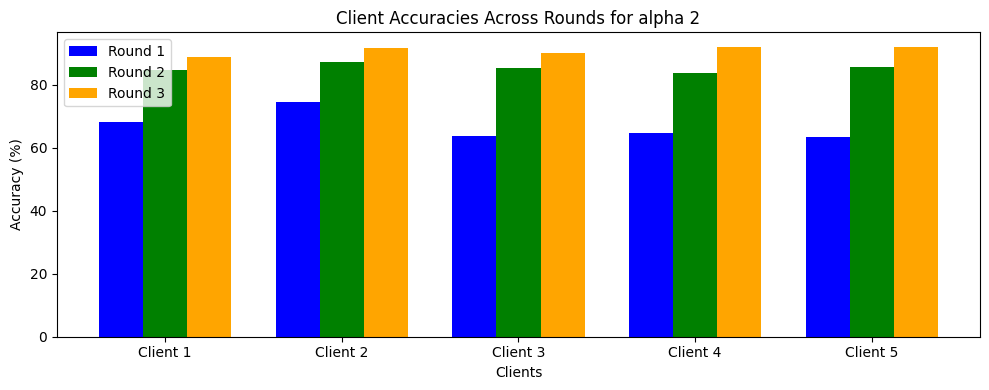

3


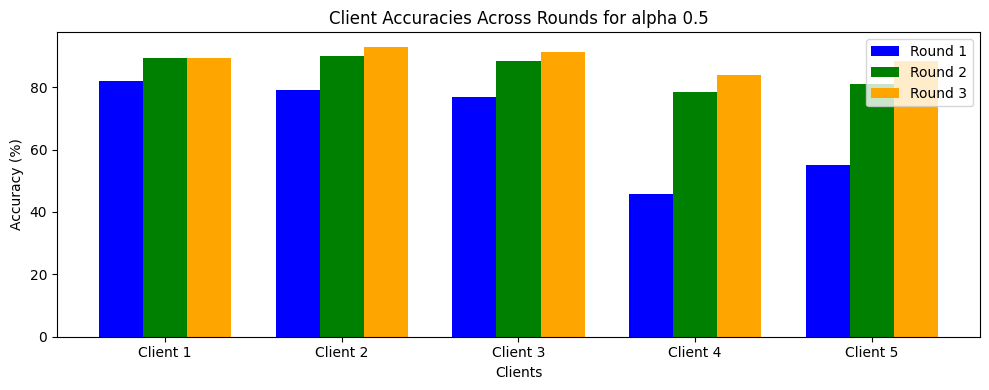

3


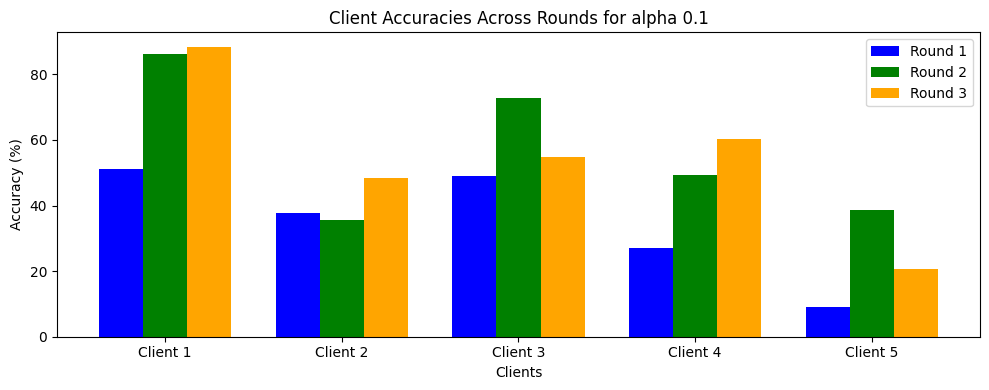

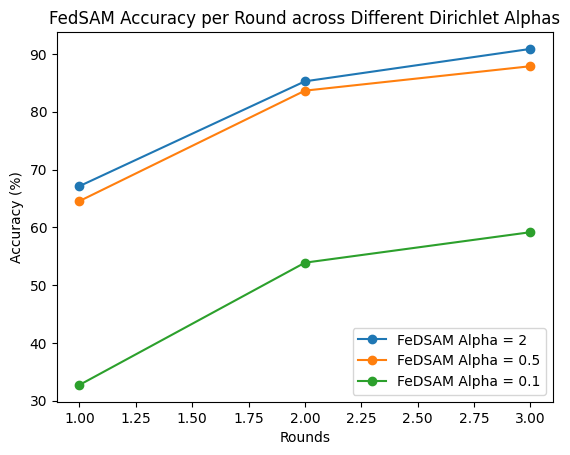

In [ ]:
# print(sam_client_accuracies[0][2])
# Extract the number of clients and rounds
print(sam_accuracies[1])
print(client_nsam_acc)
for i in range(3):
  num_clients = len(client_nsam_acc[i][0])

  rounds = len(client_nsam_acc[0])
  print(rounds)
  # Plotting the bar plots for each round
  x = np.arange(num_clients)  # Client indices
  width = 0.25  # Width of each bar

  fig, ax = plt.subplots(figsize=(10, 4))

  # Colors for each round
  colors = ['blue', 'green', 'orange']

  # Add bars for each round
  for round_idx in range(rounds):
      ax.bar(
          x + round_idx * width - (rounds - 1) * width / 2,  # Offset for bars
          client_nsam_acc[i][round_idx],  # Accuracy data for the round
          width,  # Width of the bar
          label=f'Round {round_idx + 1}',
          color=colors[round_idx]
      )

  # Add labels, title, and legend
  ax.set_xlabel("Clients")
  ax.set_ylabel("Accuracy (%)")
  ax.set_title(f"Client Accuracies Across Rounds for alpha {dirichlet_alphas[i]}")
  ax.set_xticks(x)
  ax.set_xticklabels([f"Client {i+1}" for i in range(num_clients)])
  ax.legend()

  # Display the plot
  plt.tight_layout()
  plt.show()

plt.figure()
for idx, alpha in enumerate(dirichlet_alphas):
    plt.plot(range(1, rounds + 1), sam_accuracies[idx], marker='o', label=f'FeDSAM Alpha = {alpha}')

plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('FedSAM Accuracy per Round across Different Dirichlet Alphas')
plt.show()


In [10]:
# Run the FedSAM experiment
num_clients = 5
rounds = 3
epochs = 20
lr = 0.01
batch_size = 128
dirichlet_alphas = [2,0.5,0.1]
diff_rhos = [0.1, 0.01, 0.001]
def run_fedsam(rhos):
    # Partition data with a Dirichlet alpha of 0.1
    train_loaders, test_loaders, _, _ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, 0.1, batch_size)
    global_model_sam = SimpleCNN()
    round_accuracies, client_nsam_acc = federated_training_sam(global_model_sam, train_loaders, test_loaders, num_clients, rounds, epochs, lr, rhos)
    return round_accuracies, client_nsam_acc

# Run FedSAM and get accuracy per round
sam_accuracies = []
client_nsam_acc = []
for alpha in diff_rhos:
    round_accuracies, acc = run_fedsam(alpha)
    sam_accuracies.append(round_accuracies)
    client_nsam_acc.append(acc)
# sam_accuracies = run_fedsam()




--- Federated Round 1/3 ---
Client 1/5


Client Training: Epoch 1/20, Loss: 4.4212


Client Training: Epoch 2/20, Loss: 8.9026


Client Training: Epoch 3/20, Loss: 9.3634


Client Training: Epoch 4/20, Loss: 12.3663


Client Training: Epoch 5/20, Loss: 16.7678


Client Training: Epoch 6/20, Loss: 21.0354


Client Training: Epoch 7/20, Loss: 25.7488


Client Training: Epoch 8/20, Loss: 30.5601


Client Training: Epoch 9/20, Loss: 35.2753


Client Training: Epoch 10/20, Loss: 39.7949


Client Training: Epoch 11/20, Loss: 44.4574


Client Training: Epoch 12/20, Loss: 49.0260


Client Training: Epoch 13/20, Loss: 53.8771


Client Training: Epoch 14/20, Loss: 57.8606


Client Training: Epoch 15/20, Loss: 62.5304


Client Training: Epoch 16/20, Loss: 66.3967


Client Training: Epoch 17/20, Loss: 71.6738


Client Training: Epoch 18/20, Loss: 76.2408


Client Training: Epoch 19/20, Loss: 80.8174


Client Training: Epoch 20/20, Loss: 83.5271
Client 2/5


Client Training: Epoch 1/20, Loss: 5.4716


Client Training: Epoch 2/20, Loss: 7.4006


Client Training: Epoch 3/20, Loss: 7.6816


Client Training: Epoch 4/20, Loss: 13.1128


Client Training: Epoch 5/20, Loss: 17.1221


Client Training: Epoch 6/20, Loss: 22.4744


Client Training: Epoch 7/20, Loss: 26.8379


Client Training: Epoch 8/20, Loss: 32.0797


Client Training: Epoch 9/20, Loss: 37.4326


Client Training: Epoch 10/20, Loss: 42.7855


Client Training: Epoch 11/20, Loss: 48.1384


Client Training: Epoch 12/20, Loss: 53.4912


Client Training: Epoch 13/20, Loss: 58.8440


Client Training: Epoch 14/20, Loss: 64.1968


Client Training: Epoch 15/20, Loss: 69.5495


Client Training: Epoch 16/20, Loss: 74.9023


Client Training: Epoch 17/20, Loss: 80.2551


Client Training: Epoch 18/20, Loss: 85.6079


Client Training: Epoch 19/20, Loss: 90.9608


Client Training: Epoch 20/20, Loss: 96.3138
Client 3/5


Client Training: Epoch 1/20, Loss: 4.3768


Client Training: Epoch 2/20, Loss: 7.8321


Client Training: Epoch 3/20, Loss: 8.0637


Client Training: Epoch 4/20, Loss: 10.7053


Client Training: Epoch 5/20, Loss: 14.5102


Client Training: Epoch 6/20, Loss: 18.9651


Client Training: Epoch 7/20, Loss: 23.6884


Client Training: Epoch 8/20, Loss: 28.5489


Client Training: Epoch 9/20, Loss: 32.9419


Client Training: Epoch 10/20, Loss: 37.5790


Client Training: Epoch 11/20, Loss: 42.5107


Client Training: Epoch 12/20, Loss: 47.4284


Client Training: Epoch 13/20, Loss: 52.4577


Client Training: Epoch 14/20, Loss: 57.1376


Client Training: Epoch 15/20, Loss: 61.5300


Client Training: Epoch 16/20, Loss: 66.0640


Client Training: Epoch 17/20, Loss: 51.0582


Client Training: Epoch 18/20, Loss: 4.4226


Client Training: Epoch 19/20, Loss: 2.5295


Client Training: Epoch 20/20, Loss: 3.7589
Client 4/5


Client Training: Epoch 1/20, Loss: 5.1899


Client Training: Epoch 2/20, Loss: 9.0076


Client Training: Epoch 3/20, Loss: 10.0300


Client Training: Epoch 4/20, Loss: 13.1481


Client Training: Epoch 5/20, Loss: 13.1541


Client Training: Epoch 6/20, Loss: 16.4458


Client Training: Epoch 7/20, Loss: 21.9696


Client Training: Epoch 8/20, Loss: 29.5254


Client Training: Epoch 9/20, Loss: 25.1031


Client Training: Epoch 10/20, Loss: 36.5148


Client Training: Epoch 11/20, Loss: 4.9241


Client Training: Epoch 12/20, Loss: 3.7622


Client Training: Epoch 13/20, Loss: 4.3874


Client Training: Epoch 14/20, Loss: 5.3495


Client Training: Epoch 15/20, Loss: 6.9276


Client Training: Epoch 16/20, Loss: 36.8980


Client Training: Epoch 17/20, Loss: 89.4542


Client Training: Epoch 18/20, Loss: 95.2996


Client Training: Epoch 19/20, Loss: 100.9939


Client Training: Epoch 20/20, Loss: 106.6723
Client 5/5


Client Training: Epoch 1/20, Loss: 5.0835


Client Training: Epoch 2/20, Loss: 7.8637


Client Training: Epoch 3/20, Loss: 10.3848


Client Training: Epoch 4/20, Loss: 14.0515


Client Training: Epoch 5/20, Loss: 20.0338


Client Training: Epoch 6/20, Loss: 26.7262


Client Training: Epoch 7/20, Loss: 33.1335


Client Training: Epoch 8/20, Loss: 39.5591


Client Training: Epoch 9/20, Loss: 45.7984


Client Training: Epoch 10/20, Loss: 51.8838


Client Training: Epoch 11/20, Loss: 57.9835


Client Training: Epoch 12/20, Loss: 64.3021


Client Training: Epoch 13/20, Loss: 68.5150


Client Training: Epoch 14/20, Loss: 74.3445


Client Training: Epoch 15/20, Loss: 74.1647


Client Training: Epoch 16/20, Loss: 81.2446


Client Training: Epoch 17/20, Loss: 89.4690


Client Training: Epoch 18/20, Loss: 95.2244


Client Training: Epoch 19/20, Loss: 101.7644


Client Training: Epoch 20/20, Loss: 106.0967

Evaluating Client 0
Client 0 Accuracy: 47.07%

Evaluating Client 1
Client 1 Accuracy: 10.98%

Evaluating Client 2
Client 2 Accuracy: 0.50%

Evaluating Client 3
Client 3 Accuracy: 0.00%

Evaluating Client 4
Client 4 Accuracy: 0.04%
Total Accuracy: 9.98%
Round 1 Accuracy: 9.98%

--- Federated Round 2/3 ---
Client 1/5


Client Training: Epoch 1/20, Loss: 32.5731


Client Training: Epoch 2/20, Loss: 13.9112


Client Training: Epoch 3/20, Loss: 15.1928


Client Training: Epoch 4/20, Loss: 15.0483


Client Training: Epoch 5/20, Loss: 19.5113


Client Training: Epoch 6/20, Loss: 20.9423


Client Training: Epoch 7/20, Loss: 21.5708


Client Training: Epoch 8/20, Loss: 22.1823


Client Training: Epoch 9/20, Loss: 22.3053


Client Training: Epoch 10/20, Loss: 23.2273


Client Training: Epoch 11/20, Loss: 26.1786


Client Training: Epoch 12/20, Loss: 30.5146


Client Training: Epoch 13/20, Loss: 34.0886


Client Training: Epoch 14/20, Loss: 38.2250


Client Training: Epoch 15/20, Loss: 41.6444


Client Training: Epoch 16/20, Loss: 46.5938


Client Training: Epoch 17/20, Loss: 50.7339


Client Training: Epoch 18/20, Loss: 56.0017


Client Training: Epoch 19/20, Loss: 60.3289


Client Training: Epoch 20/20, Loss: 63.9957
Client 2/5


Client Training: Epoch 1/20, Loss: 33.3443


Client Training: Epoch 2/20, Loss: 32.1493


Client Training: Epoch 3/20, Loss: 40.7265


Client Training: Epoch 4/20, Loss: 42.7763


Client Training: Epoch 5/20, Loss: 46.5408


Client Training: Epoch 6/20, Loss: 52.4252


Client Training: Epoch 7/20, Loss: 57.5204


Client Training: Epoch 8/20, Loss: 62.2581


Client Training: Epoch 9/20, Loss: 67.3778


Client Training: Epoch 10/20, Loss: 72.1463


Client Training: Epoch 11/20, Loss: 75.9936


Client Training: Epoch 12/20, Loss: 80.6150


Client Training: Epoch 13/20, Loss: 84.5271


Client Training: Epoch 14/20, Loss: 88.3570


Client Training: Epoch 15/20, Loss: 94.9791


Client Training: Epoch 16/20, Loss: 95.3075


Client Training: Epoch 17/20, Loss: 99.5222


Client Training: Epoch 18/20, Loss: 100.1928


Client Training: Epoch 19/20, Loss: 109.1102


Client Training: Epoch 20/20, Loss: 113.1210
Client 3/5


Client Training: Epoch 1/20, Loss: 28.7596


Client Training: Epoch 2/20, Loss: 21.9538


Client Training: Epoch 3/20, Loss: 16.1327


Client Training: Epoch 4/20, Loss: 14.2004


Client Training: Epoch 5/20, Loss: 18.2825


Client Training: Epoch 6/20, Loss: 17.3478


Client Training: Epoch 7/20, Loss: 15.2366


Client Training: Epoch 8/20, Loss: 17.2425


Client Training: Epoch 9/20, Loss: 20.5363


Client Training: Epoch 10/20, Loss: 18.5003


Client Training: Epoch 11/20, Loss: 22.9767


Client Training: Epoch 12/20, Loss: 24.0030


Client Training: Epoch 13/20, Loss: 20.6267


Client Training: Epoch 14/20, Loss: 24.5895


Client Training: Epoch 15/20, Loss: 25.0761


Client Training: Epoch 16/20, Loss: 22.8481


Client Training: Epoch 17/20, Loss: 26.7393


Client Training: Epoch 18/20, Loss: 32.4333


Client Training: Epoch 19/20, Loss: 29.2856


Client Training: Epoch 20/20, Loss: 24.4204
Client 4/5


Client Training: Epoch 1/20, Loss: 20.4025


Client Training: Epoch 2/20, Loss: 30.6518


Client Training: Epoch 3/20, Loss: 38.3964


Client Training: Epoch 4/20, Loss: 45.0102


Client Training: Epoch 5/20, Loss: 51.0840


Client Training: Epoch 6/20, Loss: 56.5126


Client Training: Epoch 7/20, Loss: 62.1964


Client Training: Epoch 8/20, Loss: 67.8342


Client Training: Epoch 9/20, Loss: 73.6222


Client Training: Epoch 10/20, Loss: 79.6331


Client Training: Epoch 11/20, Loss: 85.6275


Client Training: Epoch 12/20, Loss: 91.2565


Client Training: Epoch 13/20, Loss: 96.7182


Client Training: Epoch 14/20, Loss: 102.4757


Client Training: Epoch 15/20, Loss: 108.1639


Client Training: Epoch 16/20, Loss: 114.2266


Client Training: Epoch 17/20, Loss: 118.0816


Client Training: Epoch 18/20, Loss: 123.3307


Client Training: Epoch 19/20, Loss: 129.5524


Client Training: Epoch 20/20, Loss: 135.2883
Client 5/5


Client Training: Epoch 1/20, Loss: 28.8451


Client Training: Epoch 2/20, Loss: 31.5865


Client Training: Epoch 3/20, Loss: 39.1383


Client Training: Epoch 4/20, Loss: 46.7066


Client Training: Epoch 5/20, Loss: 52.8194


Client Training: Epoch 6/20, Loss: 59.0840


Client Training: Epoch 7/20, Loss: 63.3510


Client Training: Epoch 8/20, Loss: 67.3330


Client Training: Epoch 9/20, Loss: 72.5024


Client Training: Epoch 10/20, Loss: 79.0327


Client Training: Epoch 11/20, Loss: 84.0970


Client Training: Epoch 12/20, Loss: 88.8367


Client Training: Epoch 13/20, Loss: 94.8533


Client Training: Epoch 14/20, Loss: 100.2911


Client Training: Epoch 15/20, Loss: 105.9004


Client Training: Epoch 16/20, Loss: 110.0177


Client Training: Epoch 17/20, Loss: 115.3259


Client Training: Epoch 18/20, Loss: 121.5185


Client Training: Epoch 19/20, Loss: 126.8563


Client Training: Epoch 20/20, Loss: 132.2089

Evaluating Client 0
Client 0 Accuracy: 47.02%

Evaluating Client 1
Client 1 Accuracy: 10.98%

Evaluating Client 2
Client 2 Accuracy: 0.50%

Evaluating Client 3
Client 3 Accuracy: 0.00%

Evaluating Client 4
Client 4 Accuracy: 0.04%
Total Accuracy: 9.97%
Round 2 Accuracy: 9.97%

--- Federated Round 3/3 ---
Client 1/5


Client Training: Epoch 1/20, Loss: 64.7480


Client Training: Epoch 2/20, Loss: 65.0016


Client Training: Epoch 3/20, Loss: 66.6825


Client Training: Epoch 4/20, Loss: 70.4342


Client Training: Epoch 5/20, Loss: 72.2654


Client Training: Epoch 6/20, Loss: 74.3137


Client Training: Epoch 7/20, Loss: 75.3258


Client Training: Epoch 8/20, Loss: 76.5343


Client Training: Epoch 9/20, Loss: 77.3774


Client Training: Epoch 10/20, Loss: 78.7312


Client Training: Epoch 11/20, Loss: 79.7311


Client Training: Epoch 12/20, Loss: 81.1103


Client Training: Epoch 13/20, Loss: 82.5293


Client Training: Epoch 14/20, Loss: 83.8088


Client Training: Epoch 15/20, Loss: 85.1837


Client Training: Epoch 16/20, Loss: 86.7145


Client Training: Epoch 17/20, Loss: 88.4587


Client Training: Epoch 18/20, Loss: 89.0574


Client Training: Epoch 19/20, Loss: 89.4431


Client Training: Epoch 20/20, Loss: 90.5753
Client 2/5


Client Training: Epoch 1/20, Loss: 118.1795


Client Training: Epoch 2/20, Loss: 121.4876


Client Training: Epoch 3/20, Loss: 132.0180


Client Training: Epoch 4/20, Loss: 136.6039


Client Training: Epoch 5/20, Loss: 140.7354


Client Training: Epoch 6/20, Loss: 142.6709


Client Training: Epoch 7/20, Loss: 148.3143


Client Training: Epoch 8/20, Loss: 149.7786


Client Training: Epoch 9/20, Loss: 156.6981


Client Training: Epoch 10/20, Loss: 160.0032


Client Training: Epoch 11/20, Loss: 160.8070


Client Training: Epoch 12/20, Loss: 166.5908


Client Training: Epoch 13/20, Loss: 170.6572


Client Training: Epoch 14/20, Loss: 175.0323


Client Training: Epoch 15/20, Loss: 179.3532


Client Training: Epoch 16/20, Loss: 183.4031


Client Training: Epoch 17/20, Loss: 187.9160


Client Training: Epoch 18/20, Loss: 191.7936


Client Training: Epoch 19/20, Loss: 196.1186


Client Training: Epoch 20/20, Loss: 200.5576
Client 3/5


Client Training: Epoch 1/20, Loss: 106.3867


Client Training: Epoch 2/20, Loss: 123.6722


Client Training: Epoch 3/20, Loss: 130.3876


Client Training: Epoch 4/20, Loss: 141.1566


Client Training: Epoch 5/20, Loss: 147.1097


Client Training: Epoch 6/20, Loss: 151.9057


Client Training: Epoch 7/20, Loss: 157.2518


Client Training: Epoch 8/20, Loss: 162.2383


Client Training: Epoch 9/20, Loss: 166.5180


Client Training: Epoch 10/20, Loss: 172.1916


Client Training: Epoch 11/20, Loss: 175.7947


Client Training: Epoch 12/20, Loss: 179.7904


Client Training: Epoch 13/20, Loss: 184.0647


Client Training: Epoch 14/20, Loss: 189.5122


Client Training: Epoch 15/20, Loss: 194.6509


Client Training: Epoch 16/20, Loss: 199.4702


Client Training: Epoch 17/20, Loss: 300.4966


Client Training: Epoch 18/20, Loss: 208.1715


Client Training: Epoch 19/20, Loss: 211.8171


Client Training: Epoch 20/20, Loss: 214.3074
Client 4/5


Client Training: Epoch 1/20, Loss: 84.8003


Client Training: Epoch 2/20, Loss: 65.5503


Client Training: Epoch 3/20, Loss: 99.8254


Client Training: Epoch 4/20, Loss: 105.0592


Client Training: Epoch 5/20, Loss: 133.1881


Client Training: Epoch 6/20, Loss: 140.0814


Client Training: Epoch 7/20, Loss: 147.2117


Client Training: Epoch 8/20, Loss: 152.3704


Client Training: Epoch 9/20, Loss: 159.8011


Client Training: Epoch 10/20, Loss: 164.9492


Client Training: Epoch 11/20, Loss: 170.8649


Client Training: Epoch 12/20, Loss: 176.3932


Client Training: Epoch 13/20, Loss: 181.8062


Client Training: Epoch 14/20, Loss: 187.7724


Client Training: Epoch 15/20, Loss: 192.6411


Client Training: Epoch 16/20, Loss: 198.5882


Client Training: Epoch 17/20, Loss: 204.5010


Client Training: Epoch 18/20, Loss: 209.9415


Client Training: Epoch 19/20, Loss: 214.4300


Client Training: Epoch 20/20, Loss: 219.6224
Client 5/5


Client Training: Epoch 1/20, Loss: 119.5485


Client Training: Epoch 2/20, Loss: 125.8039


Client Training: Epoch 3/20, Loss: 153.2768


Client Training: Epoch 4/20, Loss: 131.9460


Client Training: Epoch 5/20, Loss: 139.3241


Client Training: Epoch 6/20, Loss: 144.1722


Client Training: Epoch 7/20, Loss: 149.0885


Client Training: Epoch 8/20, Loss: 154.7780


Client Training: Epoch 9/20, Loss: 160.1282


Client Training: Epoch 10/20, Loss: 165.1682


Client Training: Epoch 11/20, Loss: 170.7867


Client Training: Epoch 12/20, Loss: 176.0134


Client Training: Epoch 13/20, Loss: 181.4272


Client Training: Epoch 14/20, Loss: 186.7960


Client Training: Epoch 15/20, Loss: 192.1307


Client Training: Epoch 16/20, Loss: 202.2478


Client Training: Epoch 17/20, Loss: 203.1824


Client Training: Epoch 18/20, Loss: 208.0006


Client Training: Epoch 19/20, Loss: 214.5904


Client Training: Epoch 20/20, Loss: 219.6312

Evaluating Client 0
Client 0 Accuracy: 47.07%

Evaluating Client 1
Client 1 Accuracy: 10.98%

Evaluating Client 2
Client 2 Accuracy: 0.46%

Evaluating Client 3
Client 3 Accuracy: 0.00%

Evaluating Client 4
Client 4 Accuracy: 0.04%
Total Accuracy: 9.97%
Round 3 Accuracy: 9.97%

--- Federated Round 1/3 ---
Client 1/5


Client Training: Epoch 1/20, Loss: 1.8694


Client Training: Epoch 2/20, Loss: 0.9478


Client Training: Epoch 3/20, Loss: 0.9125


Client Training: Epoch 4/20, Loss: 0.8674


Client Training: Epoch 5/20, Loss: 0.8236


Client Training: Epoch 6/20, Loss: 0.7784


Client Training: Epoch 7/20, Loss: 0.7330


Client Training: Epoch 8/20, Loss: 0.6886


Client Training: Epoch 9/20, Loss: 0.6483


Client Training: Epoch 10/20, Loss: 0.6155


Client Training: Epoch 11/20, Loss: 0.5846


Client Training: Epoch 12/20, Loss: 0.5591


Client Training: Epoch 13/20, Loss: 0.5391


Client Training: Epoch 14/20, Loss: 0.5218


Client Training: Epoch 15/20, Loss: 0.5063


Client Training: Epoch 16/20, Loss: 0.4922


Client Training: Epoch 17/20, Loss: 0.4782


Client Training: Epoch 18/20, Loss: 0.4643


Client Training: Epoch 19/20, Loss: 0.4505


Client Training: Epoch 20/20, Loss: 0.4366
Client 2/5


Client Training: Epoch 1/20, Loss: 2.3103


Client Training: Epoch 2/20, Loss: 2.2314


Client Training: Epoch 3/20, Loss: 2.1943


Client Training: Epoch 4/20, Loss: 2.1769


Client Training: Epoch 5/20, Loss: 2.1724


Client Training: Epoch 6/20, Loss: 2.1785


Client Training: Epoch 7/20, Loss: 2.1924


Client Training: Epoch 8/20, Loss: 2.2004


Client Training: Epoch 9/20, Loss: 2.1984


Client Training: Epoch 10/20, Loss: 2.1964


Client Training: Epoch 11/20, Loss: 2.1858


Client Training: Epoch 12/20, Loss: 2.1647


Client Training: Epoch 13/20, Loss: 2.1482


Client Training: Epoch 14/20, Loss: 2.1368


Client Training: Epoch 15/20, Loss: 2.1282


Client Training: Epoch 16/20, Loss: 2.1203


Client Training: Epoch 17/20, Loss: 2.1113


Client Training: Epoch 18/20, Loss: 2.1007


Client Training: Epoch 19/20, Loss: 2.0894


Client Training: Epoch 20/20, Loss: 2.0778
Client 3/5


Client Training: Epoch 1/20, Loss: 0.9071


Client Training: Epoch 2/20, Loss: 0.6840


Client Training: Epoch 3/20, Loss: 0.6453


Client Training: Epoch 4/20, Loss: 0.5085


Client Training: Epoch 5/20, Loss: 0.3904


Client Training: Epoch 6/20, Loss: 0.3132


Client Training: Epoch 7/20, Loss: 0.2680


Client Training: Epoch 8/20, Loss: 0.2418


Client Training: Epoch 9/20, Loss: 0.2271


Client Training: Epoch 10/20, Loss: 0.2204


Client Training: Epoch 11/20, Loss: 0.2199


Client Training: Epoch 12/20, Loss: 0.2249


Client Training: Epoch 13/20, Loss: 0.2341


Client Training: Epoch 14/20, Loss: 0.2454


Client Training: Epoch 15/20, Loss: 0.2583


Client Training: Epoch 16/20, Loss: 0.2730


Client Training: Epoch 17/20, Loss: 0.2895


Client Training: Epoch 18/20, Loss: 0.3078


Client Training: Epoch 19/20, Loss: 0.3281


Client Training: Epoch 20/20, Loss: 0.3486
Client 4/5


Client Training: Epoch 1/20, Loss: 1.1224


Client Training: Epoch 2/20, Loss: 0.8049


Client Training: Epoch 3/20, Loss: 0.6429


Client Training: Epoch 4/20, Loss: 0.5274


Client Training: Epoch 5/20, Loss: 0.4518


Client Training: Epoch 6/20, Loss: 0.4041


Client Training: Epoch 7/20, Loss: 0.3693


Client Training: Epoch 8/20, Loss: 0.3429


Client Training: Epoch 9/20, Loss: 0.3233


Client Training: Epoch 10/20, Loss: 0.3090


Client Training: Epoch 11/20, Loss: 0.2990


Client Training: Epoch 12/20, Loss: 0.2923


Client Training: Epoch 13/20, Loss: 0.2861


Client Training: Epoch 14/20, Loss: 0.2847


Client Training: Epoch 15/20, Loss: 0.2865


Client Training: Epoch 16/20, Loss: 0.2895


Client Training: Epoch 17/20, Loss: 0.2935


Client Training: Epoch 18/20, Loss: 0.2982


Client Training: Epoch 19/20, Loss: 0.3035


Client Training: Epoch 20/20, Loss: 0.3093
Client 5/5


Client Training: Epoch 1/20, Loss: 1.1483


Client Training: Epoch 2/20, Loss: 0.9297


Client Training: Epoch 3/20, Loss: 0.6025


Client Training: Epoch 4/20, Loss: 0.3956


Client Training: Epoch 5/20, Loss: 0.3327


Client Training: Epoch 6/20, Loss: 0.3265


Client Training: Epoch 7/20, Loss: 0.3383


Client Training: Epoch 8/20, Loss: 0.3591


Client Training: Epoch 9/20, Loss: 0.3851


Client Training: Epoch 10/20, Loss: 0.4136


Client Training: Epoch 11/20, Loss: 0.4422


Client Training: Epoch 12/20, Loss: 0.4575


Client Training: Epoch 13/20, Loss: 0.4652


Client Training: Epoch 14/20, Loss: 0.4734


Client Training: Epoch 15/20, Loss: 0.4900


Client Training: Epoch 16/20, Loss: 0.5078


Client Training: Epoch 17/20, Loss: 0.5217


Client Training: Epoch 18/20, Loss: 0.5405


Client Training: Epoch 19/20, Loss: 0.5557


Client Training: Epoch 20/20, Loss: 0.5735

Evaluating Client 0
Client 0 Accuracy: 85.33%

Evaluating Client 1
Client 1 Accuracy: 53.45%

Evaluating Client 2
Client 2 Accuracy: 31.81%

Evaluating Client 3
Client 3 Accuracy: 60.77%

Evaluating Client 4
Client 4 Accuracy: 28.81%
Total Accuracy: 40.68%
Round 1 Accuracy: 40.68%

--- Federated Round 2/3 ---
Client 1/5


Client Training: Epoch 1/20, Loss: 0.4039


Client Training: Epoch 2/20, Loss: 0.7347


Client Training: Epoch 3/20, Loss: 0.4091


Client Training: Epoch 4/20, Loss: 0.3588


Client Training: Epoch 5/20, Loss: 0.3361


Client Training: Epoch 6/20, Loss: 0.3244


Client Training: Epoch 7/20, Loss: 0.3193


Client Training: Epoch 8/20, Loss: 0.3175


Client Training: Epoch 9/20, Loss: 0.3185


Client Training: Epoch 10/20, Loss: 0.3189


Client Training: Epoch 11/20, Loss: 0.3199


Client Training: Epoch 12/20, Loss: 0.3208


Client Training: Epoch 13/20, Loss: 0.3218


Client Training: Epoch 14/20, Loss: 0.3232


Client Training: Epoch 15/20, Loss: 0.3248


Client Training: Epoch 16/20, Loss: 0.3263


Client Training: Epoch 17/20, Loss: 0.3279


Client Training: Epoch 18/20, Loss: 0.3294


Client Training: Epoch 19/20, Loss: 0.3307


Client Training: Epoch 20/20, Loss: 0.3322
Client 2/5


Client Training: Epoch 1/20, Loss: 0.6984


Client Training: Epoch 2/20, Loss: 2.2541


Client Training: Epoch 3/20, Loss: 0.4667


Client Training: Epoch 4/20, Loss: 0.3854


Client Training: Epoch 5/20, Loss: 0.3567


Client Training: Epoch 6/20, Loss: 0.3428


Client Training: Epoch 7/20, Loss: 0.3348


Client Training: Epoch 8/20, Loss: 0.3297


Client Training: Epoch 9/20, Loss: 0.3260


Client Training: Epoch 10/20, Loss: 0.3234


Client Training: Epoch 11/20, Loss: 0.3214


Client Training: Epoch 12/20, Loss: 0.3197


Client Training: Epoch 13/20, Loss: 0.3182


Client Training: Epoch 14/20, Loss: 0.3169


Client Training: Epoch 15/20, Loss: 0.3156


Client Training: Epoch 16/20, Loss: 0.3145


Client Training: Epoch 17/20, Loss: 0.3135


Client Training: Epoch 18/20, Loss: 0.3123


Client Training: Epoch 19/20, Loss: 0.3114


Client Training: Epoch 20/20, Loss: 0.3105
Client 3/5


Client Training: Epoch 1/20, Loss: 0.2831


Client Training: Epoch 2/20, Loss: 0.3128


Client Training: Epoch 3/20, Loss: 0.2808


Client Training: Epoch 4/20, Loss: 0.2877


Client Training: Epoch 5/20, Loss: 0.2959


Client Training: Epoch 6/20, Loss: 0.3054


Client Training: Epoch 7/20, Loss: 0.3162


Client Training: Epoch 8/20, Loss: 0.3280


Client Training: Epoch 9/20, Loss: 0.3407


Client Training: Epoch 10/20, Loss: 0.3537


Client Training: Epoch 11/20, Loss: 0.3671


Client Training: Epoch 12/20, Loss: 0.3789


Client Training: Epoch 13/20, Loss: 0.3908


Client Training: Epoch 14/20, Loss: 0.4015


Client Training: Epoch 15/20, Loss: 0.4120


Client Training: Epoch 16/20, Loss: 0.4197


Client Training: Epoch 17/20, Loss: 0.4244


Client Training: Epoch 18/20, Loss: 0.4287


Client Training: Epoch 19/20, Loss: 0.4333


Client Training: Epoch 20/20, Loss: 0.4357
Client 4/5


Client Training: Epoch 1/20, Loss: 0.2832


Client Training: Epoch 2/20, Loss: 0.3628


Client Training: Epoch 3/20, Loss: 0.3346


Client Training: Epoch 4/20, Loss: 0.3191


Client Training: Epoch 5/20, Loss: 0.3101


Client Training: Epoch 6/20, Loss: 0.3071


Client Training: Epoch 7/20, Loss: 0.3072


Client Training: Epoch 8/20, Loss: 0.3087


Client Training: Epoch 9/20, Loss: 0.3114


Client Training: Epoch 10/20, Loss: 0.3146


Client Training: Epoch 11/20, Loss: 0.3180


Client Training: Epoch 12/20, Loss: 0.3218


Client Training: Epoch 13/20, Loss: 0.3260


Client Training: Epoch 14/20, Loss: 0.3302


Client Training: Epoch 15/20, Loss: 0.3351


Client Training: Epoch 16/20, Loss: 0.3403


Client Training: Epoch 17/20, Loss: 0.3460


Client Training: Epoch 18/20, Loss: 0.3517


Client Training: Epoch 19/20, Loss: 0.3578


Client Training: Epoch 20/20, Loss: 0.3636
Client 5/5


Client Training: Epoch 1/20, Loss: 0.4199


Client Training: Epoch 2/20, Loss: 0.3865


Client Training: Epoch 3/20, Loss: 0.3550


Client Training: Epoch 4/20, Loss: 0.3592


Client Training: Epoch 5/20, Loss: 0.3706


Client Training: Epoch 6/20, Loss: 0.3832


Client Training: Epoch 7/20, Loss: 0.3953


Client Training: Epoch 8/20, Loss: 0.4086


Client Training: Epoch 9/20, Loss: 0.4225


Client Training: Epoch 10/20, Loss: 0.4381


Client Training: Epoch 11/20, Loss: 0.4542


Client Training: Epoch 12/20, Loss: 0.4719


Client Training: Epoch 13/20, Loss: 0.4898


Client Training: Epoch 14/20, Loss: 0.5055


Client Training: Epoch 15/20, Loss: 0.5204


Client Training: Epoch 16/20, Loss: 0.5342


Client Training: Epoch 17/20, Loss: 0.5490


Client Training: Epoch 18/20, Loss: 0.5604


Client Training: Epoch 19/20, Loss: 0.5759


Client Training: Epoch 20/20, Loss: 0.5892

Evaluating Client 0
Client 0 Accuracy: 64.79%

Evaluating Client 1
Client 1 Accuracy: 90.18%

Evaluating Client 2
Client 2 Accuracy: 88.40%

Evaluating Client 3
Client 3 Accuracy: 81.75%

Evaluating Client 4
Client 4 Accuracy: 28.60%
Total Accuracy: 56.81%
Round 2 Accuracy: 56.81%

--- Federated Round 3/3 ---
Client 1/5


Client Training: Epoch 1/20, Loss: 5.6460


Client Training: Epoch 2/20, Loss: 6.3662


Client Training: Epoch 3/20, Loss: 0.9114


Client Training: Epoch 4/20, Loss: 0.6626


Client Training: Epoch 5/20, Loss: 0.4552


Client Training: Epoch 6/20, Loss: 0.3435


Client Training: Epoch 7/20, Loss: 0.2729


Client Training: Epoch 8/20, Loss: 0.2341


Client Training: Epoch 9/20, Loss: 0.2078


Client Training: Epoch 10/20, Loss: 0.1891


Client Training: Epoch 11/20, Loss: 0.1748


Client Training: Epoch 12/20, Loss: 0.1635


Client Training: Epoch 13/20, Loss: 0.1545


Client Training: Epoch 14/20, Loss: 0.1470


Client Training: Epoch 15/20, Loss: 0.1408


Client Training: Epoch 16/20, Loss: 0.1361


Client Training: Epoch 17/20, Loss: 0.1320


Client Training: Epoch 18/20, Loss: 0.1288


Client Training: Epoch 19/20, Loss: 0.1262


Client Training: Epoch 20/20, Loss: 0.1241
Client 2/5


Client Training: Epoch 1/20, Loss: 61.0750


Client Training: Epoch 2/20, Loss: 8.8161


Client Training: Epoch 3/20, Loss: 2.3824


Client Training: Epoch 4/20, Loss: 0.5617


Client Training: Epoch 5/20, Loss: 0.4806


Client Training: Epoch 6/20, Loss: 0.4324


Client Training: Epoch 7/20, Loss: 0.4025


Client Training: Epoch 8/20, Loss: 0.3802


Client Training: Epoch 9/20, Loss: 0.3618


Client Training: Epoch 10/20, Loss: 0.3472


Client Training: Epoch 11/20, Loss: 0.3358


Client Training: Epoch 12/20, Loss: 0.3271


Client Training: Epoch 13/20, Loss: 0.3207


Client Training: Epoch 14/20, Loss: 0.3157


Client Training: Epoch 15/20, Loss: 0.3119


Client Training: Epoch 16/20, Loss: 0.3091


Client Training: Epoch 17/20, Loss: 0.3070


Client Training: Epoch 18/20, Loss: 0.3053


Client Training: Epoch 19/20, Loss: 0.3043


Client Training: Epoch 20/20, Loss: 0.3031
Client 3/5


Client Training: Epoch 1/20, Loss: 5.9733


Client Training: Epoch 2/20, Loss: 0.7275


Client Training: Epoch 3/20, Loss: 0.3218


Client Training: Epoch 4/20, Loss: 0.3044


Client Training: Epoch 5/20, Loss: 0.2978


Client Training: Epoch 6/20, Loss: 0.3021


Client Training: Epoch 7/20, Loss: 0.3144


Client Training: Epoch 8/20, Loss: 0.3307


Client Training: Epoch 9/20, Loss: 0.3642


Client Training: Epoch 10/20, Loss: 0.4696


Client Training: Epoch 11/20, Loss: 0.3914


Client Training: Epoch 12/20, Loss: 0.3611


Client Training: Epoch 13/20, Loss: 0.3673


Client Training: Epoch 14/20, Loss: 0.3762


Client Training: Epoch 15/20, Loss: 0.3853


Client Training: Epoch 16/20, Loss: 0.3950


Client Training: Epoch 17/20, Loss: 0.4051


Client Training: Epoch 18/20, Loss: 0.4229


Client Training: Epoch 19/20, Loss: 0.9983


Client Training: Epoch 20/20, Loss: 0.4926
Client 4/5


Client Training: Epoch 1/20, Loss: 5.6148


Client Training: Epoch 2/20, Loss: 1.1571


Client Training: Epoch 3/20, Loss: 0.3886


Client Training: Epoch 4/20, Loss: 0.3309


Client Training: Epoch 5/20, Loss: 0.2995


Client Training: Epoch 6/20, Loss: 0.2794


Client Training: Epoch 7/20, Loss: 0.2641


Client Training: Epoch 8/20, Loss: 0.2554


Client Training: Epoch 9/20, Loss: 0.2509


Client Training: Epoch 10/20, Loss: 0.2487


Client Training: Epoch 11/20, Loss: 0.2476


Client Training: Epoch 12/20, Loss: 0.2478


Client Training: Epoch 13/20, Loss: 0.2490


Client Training: Epoch 14/20, Loss: 0.2504


Client Training: Epoch 15/20, Loss: 0.2521


Client Training: Epoch 16/20, Loss: 0.2541


Client Training: Epoch 17/20, Loss: 0.2561


Client Training: Epoch 18/20, Loss: 0.2587


Client Training: Epoch 19/20, Loss: 0.2617


Client Training: Epoch 20/20, Loss: 0.2647
Client 5/5


Client Training: Epoch 1/20, Loss: 13.0674


Client Training: Epoch 2/20, Loss: 0.4504


Client Training: Epoch 3/20, Loss: 0.3198


Client Training: Epoch 4/20, Loss: 0.3259


Client Training: Epoch 5/20, Loss: 0.3063


Client Training: Epoch 6/20, Loss: 0.3337


Client Training: Epoch 7/20, Loss: 0.3346


Client Training: Epoch 8/20, Loss: 0.3523


Client Training: Epoch 9/20, Loss: 0.3511


Client Training: Epoch 10/20, Loss: 0.3490


Client Training: Epoch 11/20, Loss: 0.3471


Client Training: Epoch 12/20, Loss: 0.3496


Client Training: Epoch 13/20, Loss: 0.3528


Client Training: Epoch 14/20, Loss: 0.3553


Client Training: Epoch 15/20, Loss: 0.3644


Client Training: Epoch 16/20, Loss: 0.3674


Client Training: Epoch 17/20, Loss: 0.3685


Client Training: Epoch 18/20, Loss: 0.3740


Client Training: Epoch 19/20, Loss: 0.3806


Client Training: Epoch 20/20, Loss: 0.3875

Evaluating Client 0
Client 0 Accuracy: 28.85%

Evaluating Client 1
Client 1 Accuracy: 66.55%

Evaluating Client 2
Client 2 Accuracy: 18.87%

Evaluating Client 3
Client 3 Accuracy: 15.27%

Evaluating Client 4
Client 4 Accuracy: 29.04%
Total Accuracy: 24.74%
Round 3 Accuracy: 24.74%

--- Federated Round 1/3 ---
Client 1/5


Client Training: Epoch 1/20, Loss: 1.0043


Client Training: Epoch 2/20, Loss: 0.6009


Client Training: Epoch 3/20, Loss: 0.5702


Client Training: Epoch 4/20, Loss: 0.5556


Client Training: Epoch 5/20, Loss: 0.5473


Client Training: Epoch 6/20, Loss: 0.5418


Client Training: Epoch 7/20, Loss: 0.5375


Client Training: Epoch 8/20, Loss: 0.5337


Client Training: Epoch 9/20, Loss: 0.5300


Client Training: Epoch 10/20, Loss: 0.5263


Client Training: Epoch 11/20, Loss: 0.5225


Client Training: Epoch 12/20, Loss: 0.5185


Client Training: Epoch 13/20, Loss: 0.5142


Client Training: Epoch 14/20, Loss: 0.5094


Client Training: Epoch 15/20, Loss: 0.5041


Client Training: Epoch 16/20, Loss: 0.4984


Client Training: Epoch 17/20, Loss: 0.4917


Client Training: Epoch 18/20, Loss: 0.4840


Client Training: Epoch 19/20, Loss: 0.4748


Client Training: Epoch 20/20, Loss: 0.4641
Client 2/5


Client Training: Epoch 1/20, Loss: 0.8419


Client Training: Epoch 2/20, Loss: 0.4704


Client Training: Epoch 3/20, Loss: 0.4633


Client Training: Epoch 4/20, Loss: 0.4566


Client Training: Epoch 5/20, Loss: 0.4539


Client Training: Epoch 6/20, Loss: 0.4497


Client Training: Epoch 7/20, Loss: 0.4406


Client Training: Epoch 8/20, Loss: 0.4245


Client Training: Epoch 9/20, Loss: 0.4004


Client Training: Epoch 10/20, Loss: 0.3653


Client Training: Epoch 11/20, Loss: 0.3193


Client Training: Epoch 12/20, Loss: 0.2688


Client Training: Epoch 13/20, Loss: 0.2221


Client Training: Epoch 14/20, Loss: 0.1870


Client Training: Epoch 15/20, Loss: 0.1614


Client Training: Epoch 16/20, Loss: 0.1431


Client Training: Epoch 17/20, Loss: 0.1302


Client Training: Epoch 18/20, Loss: 0.1206


Client Training: Epoch 19/20, Loss: 0.1135


Client Training: Epoch 20/20, Loss: 0.1080
Client 3/5


Client Training: Epoch 1/20, Loss: 0.5837


Client Training: Epoch 2/20, Loss: 0.6237


Client Training: Epoch 3/20, Loss: 0.6527


Client Training: Epoch 4/20, Loss: 0.6745


Client Training: Epoch 5/20, Loss: 0.6586


Client Training: Epoch 6/20, Loss: 0.6252


Client Training: Epoch 7/20, Loss: 0.5399


Client Training: Epoch 8/20, Loss: 0.3905


Client Training: Epoch 9/20, Loss: 0.2852


Client Training: Epoch 10/20, Loss: 0.2297


Client Training: Epoch 11/20, Loss: 0.2033


Client Training: Epoch 12/20, Loss: 0.1918


Client Training: Epoch 13/20, Loss: 0.1851


Client Training: Epoch 14/20, Loss: 0.1775


Client Training: Epoch 15/20, Loss: 0.1676


Client Training: Epoch 16/20, Loss: 0.1570


Client Training: Epoch 17/20, Loss: 0.1467


Client Training: Epoch 18/20, Loss: 0.1371


Client Training: Epoch 19/20, Loss: 0.1281


Client Training: Epoch 20/20, Loss: 0.1199
Client 4/5


Client Training: Epoch 1/20, Loss: 0.9838


Client Training: Epoch 2/20, Loss: 0.4229


Client Training: Epoch 3/20, Loss: 0.4058


Client Training: Epoch 4/20, Loss: 0.3979


Client Training: Epoch 5/20, Loss: 0.3912


Client Training: Epoch 6/20, Loss: 0.3848


Client Training: Epoch 7/20, Loss: 0.3782


Client Training: Epoch 8/20, Loss: 0.3711


Client Training: Epoch 9/20, Loss: 0.3632


Client Training: Epoch 10/20, Loss: 0.3543


Client Training: Epoch 11/20, Loss: 0.3442


Client Training: Epoch 12/20, Loss: 0.3328


Client Training: Epoch 13/20, Loss: 0.3203


Client Training: Epoch 14/20, Loss: 0.3070


Client Training: Epoch 15/20, Loss: 0.2930


Client Training: Epoch 16/20, Loss: 0.2791


Client Training: Epoch 17/20, Loss: 0.2659


Client Training: Epoch 18/20, Loss: 0.2538


Client Training: Epoch 19/20, Loss: 0.2431


Client Training: Epoch 20/20, Loss: 0.2337
Client 5/5


Client Training: Epoch 1/20, Loss: 0.5631


Client Training: Epoch 2/20, Loss: 0.3701


Client Training: Epoch 3/20, Loss: 0.3792


Client Training: Epoch 4/20, Loss: 0.3962


Client Training: Epoch 5/20, Loss: 0.4108


Client Training: Epoch 6/20, Loss: 0.4215


Client Training: Epoch 7/20, Loss: 0.4294


Client Training: Epoch 8/20, Loss: 0.4338


Client Training: Epoch 9/20, Loss: 0.4321


Client Training: Epoch 10/20, Loss: 0.4189


Client Training: Epoch 11/20, Loss: 0.3878


Client Training: Epoch 12/20, Loss: 0.3335


Client Training: Epoch 13/20, Loss: 0.2691


Client Training: Epoch 14/20, Loss: 0.2242


Client Training: Epoch 15/20, Loss: 0.1972


Client Training: Epoch 16/20, Loss: 0.1786


Client Training: Epoch 17/20, Loss: 0.1657


Client Training: Epoch 18/20, Loss: 0.1558


Client Training: Epoch 19/20, Loss: 0.1473


Client Training: Epoch 20/20, Loss: 0.1397

Evaluating Client 0
Client 0 Accuracy: 1.18%

Evaluating Client 1
Client 1 Accuracy: 18.33%

Evaluating Client 2
Client 2 Accuracy: 9.02%

Evaluating Client 3
Client 3 Accuracy: 0.51%

Evaluating Client 4
Client 4 Accuracy: 13.07%
Total Accuracy: 9.56%
Round 1 Accuracy: 9.56%

--- Federated Round 2/3 ---
Client 1/5


Client Training: Epoch 1/20, Loss: 0.7649


Client Training: Epoch 2/20, Loss: 0.3660


Client Training: Epoch 3/20, Loss: 0.2725


Client Training: Epoch 4/20, Loss: 0.2279


Client Training: Epoch 5/20, Loss: 0.1951


Client Training: Epoch 6/20, Loss: 0.1692


Client Training: Epoch 7/20, Loss: 0.1506


Client Training: Epoch 8/20, Loss: 0.1371


Client Training: Epoch 9/20, Loss: 0.1265


Client Training: Epoch 10/20, Loss: 0.1179


Client Training: Epoch 11/20, Loss: 0.1107


Client Training: Epoch 12/20, Loss: 0.1042


Client Training: Epoch 13/20, Loss: 0.0985


Client Training: Epoch 14/20, Loss: 0.0935


Client Training: Epoch 15/20, Loss: 0.0889


Client Training: Epoch 16/20, Loss: 0.0847


Client Training: Epoch 17/20, Loss: 0.0809


Client Training: Epoch 18/20, Loss: 0.0775


Client Training: Epoch 19/20, Loss: 0.0744


Client Training: Epoch 20/20, Loss: 0.0716
Client 2/5


Client Training: Epoch 1/20, Loss: 0.3029


Client Training: Epoch 2/20, Loss: 0.1333


Client Training: Epoch 3/20, Loss: 0.1018


Client Training: Epoch 4/20, Loss: 0.0881


Client Training: Epoch 5/20, Loss: 0.0802


Client Training: Epoch 6/20, Loss: 0.0750


Client Training: Epoch 7/20, Loss: 0.0712


Client Training: Epoch 8/20, Loss: 0.0681


Client Training: Epoch 9/20, Loss: 0.0656


Client Training: Epoch 10/20, Loss: 0.0634


Client Training: Epoch 11/20, Loss: 0.0615


Client Training: Epoch 12/20, Loss: 0.0597


Client Training: Epoch 13/20, Loss: 0.0581


Client Training: Epoch 14/20, Loss: 0.0566


Client Training: Epoch 15/20, Loss: 0.0552


Client Training: Epoch 16/20, Loss: 0.0540


Client Training: Epoch 17/20, Loss: 0.0527


Client Training: Epoch 18/20, Loss: 0.0516


Client Training: Epoch 19/20, Loss: 0.0505


Client Training: Epoch 20/20, Loss: 0.0495
Client 3/5


Client Training: Epoch 1/20, Loss: 0.2487


Client Training: Epoch 2/20, Loss: 0.1802


Client Training: Epoch 3/20, Loss: 0.1455


Client Training: Epoch 4/20, Loss: 0.1284


Client Training: Epoch 5/20, Loss: 0.1168


Client Training: Epoch 6/20, Loss: 0.1077


Client Training: Epoch 7/20, Loss: 0.1000


Client Training: Epoch 8/20, Loss: 0.0934


Client Training: Epoch 9/20, Loss: 0.0878


Client Training: Epoch 10/20, Loss: 0.0828


Client Training: Epoch 11/20, Loss: 0.0786


Client Training: Epoch 12/20, Loss: 0.0750


Client Training: Epoch 13/20, Loss: 0.0717


Client Training: Epoch 14/20, Loss: 0.0688


Client Training: Epoch 15/20, Loss: 0.0660


Client Training: Epoch 16/20, Loss: 0.0635


Client Training: Epoch 17/20, Loss: 0.0613


Client Training: Epoch 18/20, Loss: 0.0593


Client Training: Epoch 19/20, Loss: 0.0574


Client Training: Epoch 20/20, Loss: 0.0556
Client 4/5


Client Training: Epoch 1/20, Loss: 0.4607


Client Training: Epoch 2/20, Loss: 0.2374


Client Training: Epoch 3/20, Loss: 0.2069


Client Training: Epoch 4/20, Loss: 0.1836


Client Training: Epoch 5/20, Loss: 0.1652


Client Training: Epoch 6/20, Loss: 0.1500


Client Training: Epoch 7/20, Loss: 0.1373


Client Training: Epoch 8/20, Loss: 0.1264


Client Training: Epoch 9/20, Loss: 0.1171


Client Training: Epoch 10/20, Loss: 0.1090


Client Training: Epoch 11/20, Loss: 0.1019


Client Training: Epoch 12/20, Loss: 0.0955


Client Training: Epoch 13/20, Loss: 0.0898


Client Training: Epoch 14/20, Loss: 0.0848


Client Training: Epoch 15/20, Loss: 0.0802


Client Training: Epoch 16/20, Loss: 0.0762


Client Training: Epoch 17/20, Loss: 0.0726


Client Training: Epoch 18/20, Loss: 0.0694


Client Training: Epoch 19/20, Loss: 0.0664


Client Training: Epoch 20/20, Loss: 0.0637
Client 5/5


Client Training: Epoch 1/20, Loss: 0.1858


Client Training: Epoch 2/20, Loss: 0.1432


Client Training: Epoch 3/20, Loss: 0.1246


Client Training: Epoch 4/20, Loss: 0.1140


Client Training: Epoch 5/20, Loss: 0.1054


Client Training: Epoch 6/20, Loss: 0.0975


Client Training: Epoch 7/20, Loss: 0.0902


Client Training: Epoch 8/20, Loss: 0.0828


Client Training: Epoch 9/20, Loss: 0.0763


Client Training: Epoch 10/20, Loss: 0.0705


Client Training: Epoch 11/20, Loss: 0.0654


Client Training: Epoch 12/20, Loss: 0.0611


Client Training: Epoch 13/20, Loss: 0.0574


Client Training: Epoch 14/20, Loss: 0.0542


Client Training: Epoch 15/20, Loss: 0.0516


Client Training: Epoch 16/20, Loss: 0.0493


Client Training: Epoch 17/20, Loss: 0.0474


Client Training: Epoch 18/20, Loss: 0.0456


Client Training: Epoch 19/20, Loss: 0.0441


Client Training: Epoch 20/20, Loss: 0.0427

Evaluating Client 0
Client 0 Accuracy: 10.84%

Evaluating Client 1
Client 1 Accuracy: 66.55%

Evaluating Client 2
Client 2 Accuracy: 14.97%

Evaluating Client 3
Client 3 Accuracy: 86.05%

Evaluating Client 4
Client 4 Accuracy: 52.37%
Total Accuracy: 35.36%
Round 2 Accuracy: 35.36%

--- Federated Round 3/3 ---
Client 1/5


Client Training: Epoch 1/20, Loss: 2.6530


Client Training: Epoch 2/20, Loss: 1.2538


Client Training: Epoch 3/20, Loss: 0.1856


Client Training: Epoch 4/20, Loss: 0.1421


Client Training: Epoch 5/20, Loss: 0.1156


Client Training: Epoch 6/20, Loss: 0.0979


Client Training: Epoch 7/20, Loss: 0.0862


Client Training: Epoch 8/20, Loss: 0.0763


Client Training: Epoch 9/20, Loss: 0.0686


Client Training: Epoch 10/20, Loss: 0.0624


Client Training: Epoch 11/20, Loss: 0.0571


Client Training: Epoch 12/20, Loss: 0.0527


Client Training: Epoch 13/20, Loss: 0.0490


Client Training: Epoch 14/20, Loss: 0.0458


Client Training: Epoch 15/20, Loss: 0.0430


Client Training: Epoch 16/20, Loss: 0.0405


Client Training: Epoch 17/20, Loss: 0.0382


Client Training: Epoch 18/20, Loss: 0.0363


Client Training: Epoch 19/20, Loss: 0.0345


Client Training: Epoch 20/20, Loss: 0.0330
Client 2/5


Client Training: Epoch 1/20, Loss: 1.3022


Client Training: Epoch 2/20, Loss: 1.4610


Client Training: Epoch 3/20, Loss: 0.0786


Client Training: Epoch 4/20, Loss: 0.0687


Client Training: Epoch 5/20, Loss: 0.0609


Client Training: Epoch 6/20, Loss: 0.0546


Client Training: Epoch 7/20, Loss: 0.0493


Client Training: Epoch 8/20, Loss: 0.0449


Client Training: Epoch 9/20, Loss: 0.0412


Client Training: Epoch 10/20, Loss: 0.0381


Client Training: Epoch 11/20, Loss: 0.0355


Client Training: Epoch 12/20, Loss: 0.0332


Client Training: Epoch 13/20, Loss: 0.0312


Client Training: Epoch 14/20, Loss: 0.0293


Client Training: Epoch 15/20, Loss: 0.0277


Client Training: Epoch 16/20, Loss: 0.0262


Client Training: Epoch 17/20, Loss: 0.0248


Client Training: Epoch 18/20, Loss: 0.0237


Client Training: Epoch 19/20, Loss: 0.0226


Client Training: Epoch 20/20, Loss: 0.0216
Client 3/5


Client Training: Epoch 1/20, Loss: 0.5940


Client Training: Epoch 2/20, Loss: 0.1552


Client Training: Epoch 3/20, Loss: 0.0885


Client Training: Epoch 4/20, Loss: 0.0727


Client Training: Epoch 5/20, Loss: 0.0636


Client Training: Epoch 6/20, Loss: 0.0571


Client Training: Epoch 7/20, Loss: 0.0519


Client Training: Epoch 8/20, Loss: 0.0478


Client Training: Epoch 9/20, Loss: 0.0445


Client Training: Epoch 10/20, Loss: 0.0416


Client Training: Epoch 11/20, Loss: 0.0393


Client Training: Epoch 12/20, Loss: 0.0374


Client Training: Epoch 13/20, Loss: 0.0356


Client Training: Epoch 14/20, Loss: 0.0340


Client Training: Epoch 15/20, Loss: 0.0326


Client Training: Epoch 16/20, Loss: 0.0314


Client Training: Epoch 17/20, Loss: 0.0302


Client Training: Epoch 18/20, Loss: 0.0291


Client Training: Epoch 19/20, Loss: 0.0281


Client Training: Epoch 20/20, Loss: 0.0271
Client 4/5


Client Training: Epoch 1/20, Loss: 4.0258


Client Training: Epoch 2/20, Loss: 0.8711


Client Training: Epoch 3/20, Loss: 0.1141


Client Training: Epoch 4/20, Loss: 0.0901


Client Training: Epoch 5/20, Loss: 0.0744


Client Training: Epoch 6/20, Loss: 0.0631


Client Training: Epoch 7/20, Loss: 0.0547


Client Training: Epoch 8/20, Loss: 0.0483


Client Training: Epoch 9/20, Loss: 0.0433


Client Training: Epoch 10/20, Loss: 0.0393


Client Training: Epoch 11/20, Loss: 0.0360


Client Training: Epoch 12/20, Loss: 0.0332


Client Training: Epoch 13/20, Loss: 0.0309


Client Training: Epoch 14/20, Loss: 0.0289


Client Training: Epoch 15/20, Loss: 0.0271


Client Training: Epoch 16/20, Loss: 0.0256


Client Training: Epoch 17/20, Loss: 0.0242


Client Training: Epoch 18/20, Loss: 0.0230


Client Training: Epoch 19/20, Loss: 0.0219


Client Training: Epoch 20/20, Loss: 0.0209
Client 5/5


Client Training: Epoch 1/20, Loss: 1.2078


Client Training: Epoch 2/20, Loss: 0.2765


Client Training: Epoch 3/20, Loss: 0.0774


Client Training: Epoch 4/20, Loss: 0.0623


Client Training: Epoch 5/20, Loss: 0.0540


Client Training: Epoch 6/20, Loss: 0.0485


Client Training: Epoch 7/20, Loss: 0.0444


Client Training: Epoch 8/20, Loss: 0.0412


Client Training: Epoch 9/20, Loss: 0.0385


Client Training: Epoch 10/20, Loss: 0.0363


Client Training: Epoch 11/20, Loss: 0.0344


Client Training: Epoch 12/20, Loss: 0.0327


Client Training: Epoch 13/20, Loss: 0.0312


Client Training: Epoch 14/20, Loss: 0.0300


Client Training: Epoch 15/20, Loss: 0.0288


Client Training: Epoch 16/20, Loss: 0.0277


Client Training: Epoch 17/20, Loss: 0.0268


Client Training: Epoch 18/20, Loss: 0.0259


Client Training: Epoch 19/20, Loss: 0.0251


Client Training: Epoch 20/20, Loss: 0.0244

Evaluating Client 0
Client 0 Accuracy: 12.02%

Evaluating Client 1
Client 1 Accuracy: 96.17%

Evaluating Client 2
Client 2 Accuracy: 42.19%

Evaluating Client 3
Client 3 Accuracy: 85.95%

Evaluating Client 4
Client 4 Accuracy: 55.42%
Total Accuracy: 52.24%
Round 3 Accuracy: 52.24%


[[9.975000000000001, 9.966666666666667, 9.966666666666667], [40.68333333333333, 56.80833333333334, 24.741666666666667], [9.558333333333334, 35.358333333333334, 52.24166666666667]]


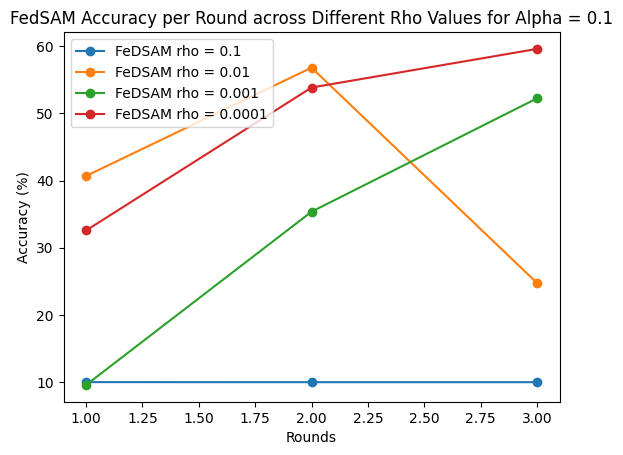

In [13]:
print(sam_accuracies)
samacc1 = [32.56, 53.85, 59.6]
sam_accuracies.append(samacc1)
diff_rhos.append(0.0001)
plt.figure()
for idx, alpha in enumerate(diff_rhos):
    plt.plot(range(1, rounds + 1), sam_accuracies[idx], marker='o', label=f'FeDSAM rho = {alpha}')

plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('FedSAM Accuracy per Round across Different Rho Values for Alpha = 0.1')
plt.show()

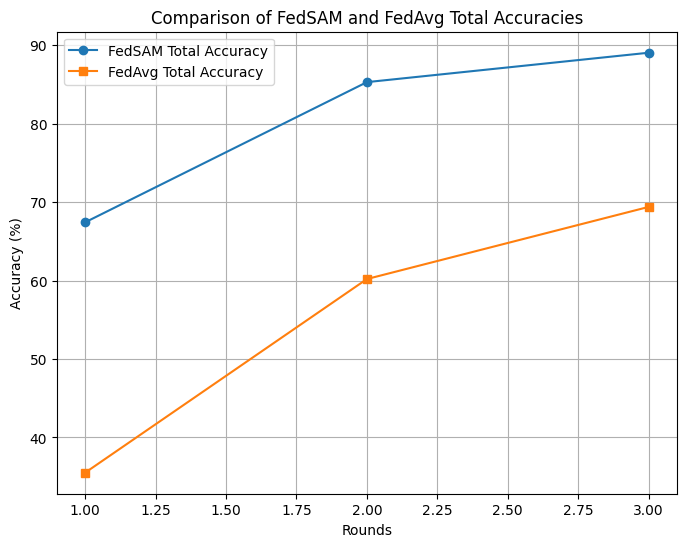

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Placeholder data extracted from the provided images (approximate values)
# FedSAM accuracies
fedsam_round_acc = [67.43, 85.31, 89.06]
fedsam_client_acc = [
    [81.85, 89.21, 89.32],  # Client 1
    [79.03, 90.02, 92.93],  # Client 2
    [76.71, 88.41, 91.43],  # Client 3
    [45.75, 78.36, 83.84],  # Client 4
    [54.91, 80.99, 88.38],  # Client 5
]

# FedAvg accuracies
fedavg_round_acc = [35.5, 60.2, 69.4]
fedavg_client_acc = [
    [31.5, 40.2, 55.6],  # Client 1
    [30.1, 50.8, 60.3],  # Client 2
    [27.8, 50.1, 63.7],  # Client 3
    [15.7, 39.6, 51.2],  # Client 4
    [20.3, 42.5, 54.8],  # Client 5
]

# Comparison of all accuracies for FedSAM and FedAvg
rounds = [1, 2, 3]
plt.figure(figsize=(8, 6))
plt.plot(rounds, fedsam_round_acc, marker='o', label="FedSAM Total Accuracy")
plt.plot(rounds, fedavg_round_acc, marker='s', label="FedAvg Total Accuracy")
plt.xlabel("Rounds")
plt.ylabel("Accuracy (%)")
plt.title("Comparison of FedSAM and FedAvg Total Accuracies")
plt.legend()
plt.grid(True)
plt.show()

# # Overlayed plot for client-wise accuracies
# clients = ['Client 1', 'Client 2', 'Client 3', 'Client 4', 'Client 5']
# x = np.arange(len(clients))
# width = 0.35

# for round_num, round_label in enumerate(["Round 1", "Round 2", "Round 3"]):
#     plt.figure(figsize=(10, 6))
#     plt.bar(
#         x - width / 2,
#         [fedsam_client_acc[i][round_num] for i in range(len(clients))],
#         width,
#         label=f"FedSAM {round_label}",
#     )
#     plt.bar(
#         x + width / 2,
#         [fedavg_client_acc[i][round_num] for i in range(len(clients))],
#         width,
#         label=f"FedAvg {round_label}",
#     )
#     plt.xlabel("Clients")
#     plt.ylabel("Accuracy (%)")
#     plt.title(f"Client-wise Accuracy Comparison for {round_label}")
#     plt.xticks(x, clients)
#     plt.legend()
#     plt.grid(axis="y")
#     plt.show()


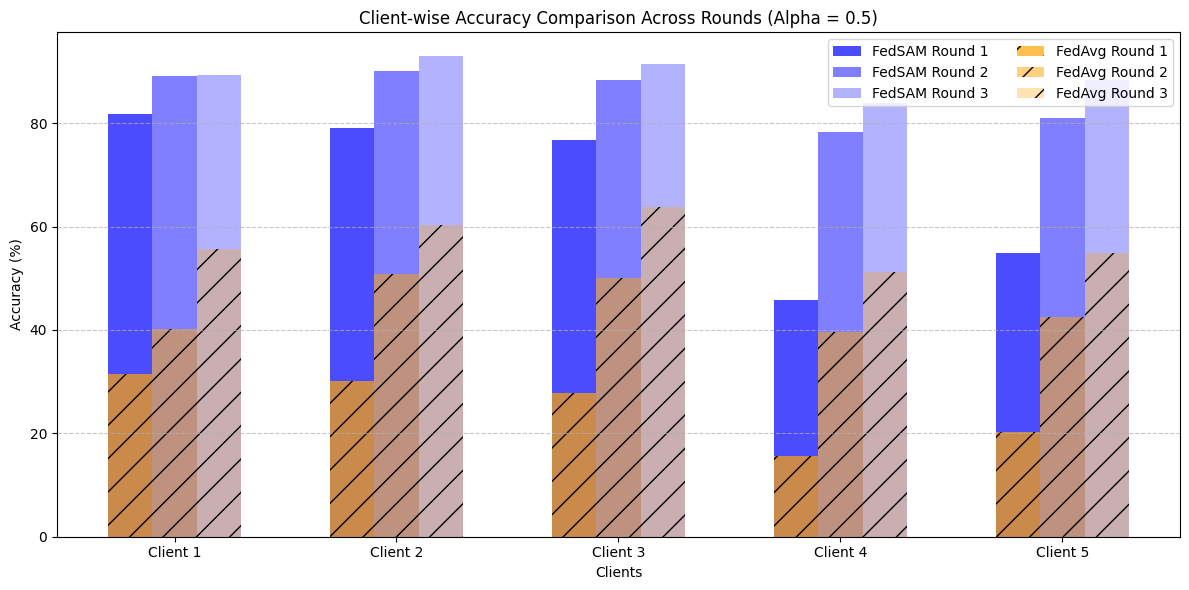

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Correcting the missing data initialization from the provided input code snippet
fedsam_client_acc = [
    [81.85, 89.21, 89.32],  # Client 1
    [79.03, 90.02, 92.93],  # Client 2
    [76.71, 88.41, 91.43],  # Client 3
    [45.75, 78.36, 83.84],  # Client 4
    [54.91, 80.99, 88.38],  # Client 5
]
fedavg_client_acc = [
    [31.5, 40.2, 55.6],  # Client 1
    [30.1, 50.8, 60.3],  # Client 2
    [27.8, 50.1, 63.7],  # Client 3
    [15.7, 39.6, 51.2],  # Client 4
    [20.3, 42.5, 54.8],  # Client 5
]

# Combining client-wise accuracy comparisons into a single visualization for all rounds
clients = ['Client 1', 'Client 2', 'Client 3', 'Client 4', 'Client 5']
x = np.arange(len(clients))
width = 0.2  # Width of each bar

# Create a single plot for comparison
plt.figure(figsize=(12, 6))

# Plot FedSAM bars for each round
plt.bar(
    x - width, [fedsam_client_acc[i][0] for i in range(len(clients))], width,
    label="FedSAM Round 1", color='blue', alpha=0.7
)
plt.bar(
    x, [fedsam_client_acc[i][1] for i in range(len(clients))], width,
    label="FedSAM Round 2", color='blue', alpha=0.5
)
plt.bar(
    x + width, [fedsam_client_acc[i][2] for i in range(len(clients))], width,
    label="FedSAM Round 3", color='blue', alpha=0.3
)

# Plot FedAvg bars for each round, overlaid on the same positions
plt.bar(
    x - width, [fedavg_client_acc[i][0] for i in range(len(clients))], width,
    label="FedAvg Round 1", color='orange', alpha=0.7, hatch='/'
)
plt.bar(
    x, [fedavg_client_acc[i][1] for i in range(len(clients))], width,
    label="FedAvg Round 2", color='orange', alpha=0.5, hatch='/'
)
plt.bar(
    x + width, [fedavg_client_acc[i][2] for i in range(len(clients))], width,
    label="FedAvg Round 3", color='orange', alpha=0.3, hatch='/'
)

# Add labels and legend
plt.xlabel("Clients")
plt.ylabel("Accuracy (%)")
plt.title("Client-wise Accuracy Comparison Across Rounds (Alpha = 0.5)")
plt.xticks(x, clients)
plt.legend(ncol=2)  # Display legend in two columns for better clarity
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# Run the FedSAM experiment
num_clients = 5
rounds = 3
epochs = 20
lr = 0.01
batch_size = 128
dirichlet_alphas = [ 0.5]

def run_fedsam(alpha):
    # Partition data with a Dirichlet alpha of 0.1
    train_loaders, test_loaders, _, _ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)
    global_model_sam = SimpleCNN()
    round_accuracies, client_nsam_acc = federated_training_sam(global_model_sam, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr=lr)
    return round_accuracies, client_nsam_acc

# Run FedSAM and get accuracy per round
sam_accuracies_05 = []
client_nsam_acc_05 = []
for alpha in dirichlet_alphas:
    round_accuracies, acc = run_fedsam(alpha)
    sam_accuracies_05.append(round_accuracies)
    client_nsam_acc_05.append(acc)
# sam_accuracies = run_fedsam()




--- Federated Round 1/3 ---
Client 1/5


Client Training: Epoch 1/20, Loss: 0.9109


Client Training: Epoch 2/20, Loss: 1.0262


Client Training: Epoch 3/20, Loss: 1.0123


Client Training: Epoch 4/20, Loss: 1.0036


Client Training: Epoch 5/20, Loss: 0.9711


Client Training: Epoch 6/20, Loss: 0.9125


Client Training: Epoch 7/20, Loss: 0.8023


Client Training: Epoch 8/20, Loss: 0.6572


Client Training: Epoch 9/20, Loss: 0.5480


Client Training: Epoch 10/20, Loss: 0.4782


Client Training: Epoch 11/20, Loss: 0.4376


Client Training: Epoch 12/20, Loss: 0.4195


Client Training: Epoch 13/20, Loss: 0.4084


Client Training: Epoch 14/20, Loss: 0.3989


Client Training: Epoch 15/20, Loss: 0.3857


Client Training: Epoch 16/20, Loss: 0.3682


Client Training: Epoch 17/20, Loss: 0.3479


Client Training: Epoch 18/20, Loss: 0.3291


Client Training: Epoch 19/20, Loss: 0.3089


Client Training: Epoch 20/20, Loss: 0.2882
Client 2/5


Client Training: Epoch 1/20, Loss: 1.0704


Client Training: Epoch 2/20, Loss: 1.0077


Client Training: Epoch 3/20, Loss: 0.9603


Client Training: Epoch 4/20, Loss: 0.8859


Client Training: Epoch 5/20, Loss: 0.7695


Client Training: Epoch 6/20, Loss: 0.6360


Client Training: Epoch 7/20, Loss: 0.5301


Client Training: Epoch 8/20, Loss: 0.4529


Client Training: Epoch 9/20, Loss: 0.4028


Client Training: Epoch 10/20, Loss: 0.3703


Client Training: Epoch 11/20, Loss: 0.3464


Client Training: Epoch 12/20, Loss: 0.3252


Client Training: Epoch 13/20, Loss: 0.3080


Client Training: Epoch 14/20, Loss: 0.2918


Client Training: Epoch 15/20, Loss: 0.2786


Client Training: Epoch 16/20, Loss: 0.2650


Client Training: Epoch 17/20, Loss: 0.2531


Client Training: Epoch 18/20, Loss: 0.2414


Client Training: Epoch 19/20, Loss: 0.2313


Client Training: Epoch 20/20, Loss: 0.2206
Client 3/5


Client Training: Epoch 1/20, Loss: 1.5702


Client Training: Epoch 2/20, Loss: 1.6066


Client Training: Epoch 3/20, Loss: 1.4300


Client Training: Epoch 4/20, Loss: 1.2424


Client Training: Epoch 5/20, Loss: 1.0312


Client Training: Epoch 6/20, Loss: 0.8681


Client Training: Epoch 7/20, Loss: 0.7584


Client Training: Epoch 8/20, Loss: 0.6835


Client Training: Epoch 9/20, Loss: 0.6306


Client Training: Epoch 10/20, Loss: 0.5885


Client Training: Epoch 11/20, Loss: 0.5509


Client Training: Epoch 12/20, Loss: 0.5130


Client Training: Epoch 13/20, Loss: 0.4767


Client Training: Epoch 14/20, Loss: 0.4443


Client Training: Epoch 15/20, Loss: 0.4143


Client Training: Epoch 16/20, Loss: 0.3882


Client Training: Epoch 17/20, Loss: 0.3667


Client Training: Epoch 18/20, Loss: 0.3475


Client Training: Epoch 19/20, Loss: 0.3311


Client Training: Epoch 20/20, Loss: 0.3149
Client 4/5


Client Training: Epoch 1/20, Loss: 1.1224


Client Training: Epoch 2/20, Loss: 1.3006


Client Training: Epoch 3/20, Loss: 1.2637


Client Training: Epoch 4/20, Loss: 1.2184


Client Training: Epoch 5/20, Loss: 1.0761


Client Training: Epoch 6/20, Loss: 0.8902


Client Training: Epoch 7/20, Loss: 0.7443


Client Training: Epoch 8/20, Loss: 0.6318


Client Training: Epoch 9/20, Loss: 0.5548


Client Training: Epoch 10/20, Loss: 0.5079


Client Training: Epoch 11/20, Loss: 0.4774


Client Training: Epoch 12/20, Loss: 0.4621


Client Training: Epoch 13/20, Loss: 0.4480


Client Training: Epoch 14/20, Loss: 0.4366


Client Training: Epoch 15/20, Loss: 0.4239


Client Training: Epoch 16/20, Loss: 0.4108


Client Training: Epoch 17/20, Loss: 0.3952


Client Training: Epoch 18/20, Loss: 0.3733


Client Training: Epoch 19/20, Loss: 0.3483


Client Training: Epoch 20/20, Loss: 0.3232
Client 5/5


Client Training: Epoch 1/20, Loss: 1.2231


Client Training: Epoch 2/20, Loss: 1.3147


Client Training: Epoch 3/20, Loss: 1.2969


Client Training: Epoch 4/20, Loss: 1.2620


Client Training: Epoch 5/20, Loss: 1.2746


Client Training: Epoch 6/20, Loss: 1.2180


Client Training: Epoch 7/20, Loss: 1.1007


Client Training: Epoch 8/20, Loss: 0.8971


Client Training: Epoch 9/20, Loss: 0.7106


Client Training: Epoch 10/20, Loss: 0.5897


Client Training: Epoch 11/20, Loss: 0.5174


Client Training: Epoch 12/20, Loss: 0.4773


Client Training: Epoch 13/20, Loss: 0.4538


Client Training: Epoch 14/20, Loss: 0.4356


Client Training: Epoch 15/20, Loss: 0.4169


Client Training: Epoch 16/20, Loss: 0.3992


Client Training: Epoch 17/20, Loss: 0.3832


Client Training: Epoch 18/20, Loss: 0.3682


Client Training: Epoch 19/20, Loss: 0.3539


Client Training: Epoch 20/20, Loss: 0.3386

Evaluating Client 0
Client 0 Accuracy: 81.85%

Evaluating Client 1
Client 1 Accuracy: 79.03%

Evaluating Client 2
Client 2 Accuracy: 76.71%

Evaluating Client 3
Client 3 Accuracy: 45.75%

Evaluating Client 4
Client 4 Accuracy: 54.91%
Total Accuracy: 67.42%
Round 1 Accuracy: 67.42%

--- Federated Round 2/3 ---
Client 1/5


Client Training: Epoch 1/20, Loss: 0.2775


Client Training: Epoch 2/20, Loss: 0.2442


Client Training: Epoch 3/20, Loss: 0.1930


Client Training: Epoch 4/20, Loss: 0.1784


Client Training: Epoch 5/20, Loss: 0.1667


Client Training: Epoch 6/20, Loss: 0.1589


Client Training: Epoch 7/20, Loss: 0.1510


Client Training: Epoch 8/20, Loss: 0.1407


Client Training: Epoch 9/20, Loss: 0.1308


Client Training: Epoch 10/20, Loss: 0.1230


Client Training: Epoch 11/20, Loss: 0.1154


Client Training: Epoch 12/20, Loss: 0.1084


Client Training: Epoch 13/20, Loss: 0.1020


Client Training: Epoch 14/20, Loss: 0.0966


Client Training: Epoch 15/20, Loss: 0.0916


Client Training: Epoch 16/20, Loss: 0.0870


Client Training: Epoch 17/20, Loss: 0.0826


Client Training: Epoch 18/20, Loss: 0.0786


Client Training: Epoch 19/20, Loss: 0.0749


Client Training: Epoch 20/20, Loss: 0.0714
Client 2/5


Client Training: Epoch 1/20, Loss: 0.2323


Client Training: Epoch 2/20, Loss: 0.2465


Client Training: Epoch 3/20, Loss: 0.1775


Client Training: Epoch 4/20, Loss: 0.1571


Client Training: Epoch 5/20, Loss: 0.1410


Client Training: Epoch 6/20, Loss: 0.1292


Client Training: Epoch 7/20, Loss: 0.1196


Client Training: Epoch 8/20, Loss: 0.1115


Client Training: Epoch 9/20, Loss: 0.1045


Client Training: Epoch 10/20, Loss: 0.0981


Client Training: Epoch 11/20, Loss: 0.0926


Client Training: Epoch 12/20, Loss: 0.0874


Client Training: Epoch 13/20, Loss: 0.0828


Client Training: Epoch 14/20, Loss: 0.0785


Client Training: Epoch 15/20, Loss: 0.0746


Client Training: Epoch 16/20, Loss: 0.0710


Client Training: Epoch 17/20, Loss: 0.0677


Client Training: Epoch 18/20, Loss: 0.0646


Client Training: Epoch 19/20, Loss: 0.0616


Client Training: Epoch 20/20, Loss: 0.0589
Client 3/5


Client Training: Epoch 1/20, Loss: 0.3804


Client Training: Epoch 2/20, Loss: 0.3564


Client Training: Epoch 3/20, Loss: 0.2759


Client Training: Epoch 4/20, Loss: 0.2466


Client Training: Epoch 5/20, Loss: 0.2268


Client Training: Epoch 6/20, Loss: 0.2101


Client Training: Epoch 7/20, Loss: 0.1962


Client Training: Epoch 8/20, Loss: 0.1847


Client Training: Epoch 9/20, Loss: 0.1748


Client Training: Epoch 10/20, Loss: 0.1659


Client Training: Epoch 11/20, Loss: 0.1572


Client Training: Epoch 12/20, Loss: 0.1492


Client Training: Epoch 13/20, Loss: 0.1415


Client Training: Epoch 14/20, Loss: 0.1341


Client Training: Epoch 15/20, Loss: 0.1273


Client Training: Epoch 16/20, Loss: 0.1209


Client Training: Epoch 17/20, Loss: 0.1147


Client Training: Epoch 18/20, Loss: 0.1089


Client Training: Epoch 19/20, Loss: 0.1035


Client Training: Epoch 20/20, Loss: 0.0984
Client 4/5


Client Training: Epoch 1/20, Loss: 0.2787


Client Training: Epoch 2/20, Loss: 0.2964


Client Training: Epoch 3/20, Loss: 0.2449


Client Training: Epoch 4/20, Loss: 0.2150


Client Training: Epoch 5/20, Loss: 0.1934


Client Training: Epoch 6/20, Loss: 0.1786


Client Training: Epoch 7/20, Loss: 0.1686


Client Training: Epoch 8/20, Loss: 0.1606


Client Training: Epoch 9/20, Loss: 0.1525


Client Training: Epoch 10/20, Loss: 0.1443


Client Training: Epoch 11/20, Loss: 0.1365


Client Training: Epoch 12/20, Loss: 0.1288


Client Training: Epoch 13/20, Loss: 0.1213


Client Training: Epoch 14/20, Loss: 0.1139


Client Training: Epoch 15/20, Loss: 0.1070


Client Training: Epoch 16/20, Loss: 0.1006


Client Training: Epoch 17/20, Loss: 0.0949


Client Training: Epoch 18/20, Loss: 0.0898


Client Training: Epoch 19/20, Loss: 0.0851


Client Training: Epoch 20/20, Loss: 0.0807
Client 5/5


Client Training: Epoch 1/20, Loss: 0.2716


Client Training: Epoch 2/20, Loss: 0.2638


Client Training: Epoch 3/20, Loss: 0.2181


Client Training: Epoch 4/20, Loss: 0.1945


Client Training: Epoch 5/20, Loss: 0.1798


Client Training: Epoch 6/20, Loss: 0.1693


Client Training: Epoch 7/20, Loss: 0.1601


Client Training: Epoch 8/20, Loss: 0.1521


Client Training: Epoch 9/20, Loss: 0.1440


Client Training: Epoch 10/20, Loss: 0.1363


Client Training: Epoch 11/20, Loss: 0.1287


Client Training: Epoch 12/20, Loss: 0.1216


Client Training: Epoch 13/20, Loss: 0.1149


Client Training: Epoch 14/20, Loss: 0.1085


Client Training: Epoch 15/20, Loss: 0.1027


Client Training: Epoch 16/20, Loss: 0.0971


Client Training: Epoch 17/20, Loss: 0.0921


Client Training: Epoch 18/20, Loss: 0.0876


Client Training: Epoch 19/20, Loss: 0.0834


Client Training: Epoch 20/20, Loss: 0.0795

Evaluating Client 0
Client 0 Accuracy: 89.21%

Evaluating Client 1
Client 1 Accuracy: 90.02%

Evaluating Client 2
Client 2 Accuracy: 88.41%

Evaluating Client 3
Client 3 Accuracy: 78.36%

Evaluating Client 4
Client 4 Accuracy: 80.99%
Total Accuracy: 85.31%
Round 2 Accuracy: 85.31%

--- Federated Round 3/3 ---
Client 1/5


Client Training: Epoch 1/20, Loss: 1.3819


Client Training: Epoch 2/20, Loss: 0.5603


Client Training: Epoch 3/20, Loss: 0.2104


Client Training: Epoch 4/20, Loss: 0.2397


Client Training: Epoch 5/20, Loss: 0.2090


Client Training: Epoch 6/20, Loss: 0.1549


Client Training: Epoch 7/20, Loss: 0.1308


Client Training: Epoch 8/20, Loss: 0.1086


Client Training: Epoch 9/20, Loss: 0.0929


Client Training: Epoch 10/20, Loss: 0.0831


Client Training: Epoch 11/20, Loss: 0.0790


Client Training: Epoch 12/20, Loss: 0.0752


Client Training: Epoch 13/20, Loss: 0.0703


Client Training: Epoch 14/20, Loss: 0.0641


Client Training: Epoch 15/20, Loss: 0.0574


Client Training: Epoch 16/20, Loss: 0.0519


Client Training: Epoch 17/20, Loss: 0.0475


Client Training: Epoch 18/20, Loss: 0.0441


Client Training: Epoch 19/20, Loss: 0.0412


Client Training: Epoch 20/20, Loss: 0.0386
Client 2/5


Client Training: Epoch 1/20, Loss: 1.5718


Client Training: Epoch 2/20, Loss: 0.7445


Client Training: Epoch 3/20, Loss: 0.2937


Client Training: Epoch 4/20, Loss: 0.1992


Client Training: Epoch 5/20, Loss: 0.1509


Client Training: Epoch 6/20, Loss: 0.1178


Client Training: Epoch 7/20, Loss: 0.0986


Client Training: Epoch 8/20, Loss: 0.0812


Client Training: Epoch 9/20, Loss: 0.0693


Client Training: Epoch 10/20, Loss: 0.0611


Client Training: Epoch 11/20, Loss: 0.0548


Client Training: Epoch 12/20, Loss: 0.0496


Client Training: Epoch 13/20, Loss: 0.0453


Client Training: Epoch 14/20, Loss: 0.0415


Client Training: Epoch 15/20, Loss: 0.0383


Client Training: Epoch 16/20, Loss: 0.0355


Client Training: Epoch 17/20, Loss: 0.0330


Client Training: Epoch 18/20, Loss: 0.0307


Client Training: Epoch 19/20, Loss: 0.0287


Client Training: Epoch 20/20, Loss: 0.0268
Client 3/5


Client Training: Epoch 1/20, Loss: 1.4896


Client Training: Epoch 2/20, Loss: 0.6829


Client Training: Epoch 3/20, Loss: 0.2816


Client Training: Epoch 4/20, Loss: 0.1891


Client Training: Epoch 5/20, Loss: 0.1577


Client Training: Epoch 6/20, Loss: 0.1314


Client Training: Epoch 7/20, Loss: 0.1154


Client Training: Epoch 8/20, Loss: 0.1072


Client Training: Epoch 9/20, Loss: 0.0938


Client Training: Epoch 10/20, Loss: 0.0813


Client Training: Epoch 11/20, Loss: 0.0720


Client Training: Epoch 12/20, Loss: 0.0644


Client Training: Epoch 13/20, Loss: 0.0578


Client Training: Epoch 14/20, Loss: 0.0520


Client Training: Epoch 15/20, Loss: 0.0469


Client Training: Epoch 16/20, Loss: 0.0426


Client Training: Epoch 17/20, Loss: 0.0387


Client Training: Epoch 18/20, Loss: 0.0353


Client Training: Epoch 19/20, Loss: 0.0323


Client Training: Epoch 20/20, Loss: 0.0297
Client 4/5


Client Training: Epoch 1/20, Loss: 1.3860


Client Training: Epoch 2/20, Loss: 0.3273


Client Training: Epoch 3/20, Loss: 0.1924


Client Training: Epoch 4/20, Loss: 0.1528


Client Training: Epoch 5/20, Loss: 0.1330


Client Training: Epoch 6/20, Loss: 0.1158


Client Training: Epoch 7/20, Loss: 0.1054


Client Training: Epoch 8/20, Loss: 0.0934


Client Training: Epoch 9/20, Loss: 0.0812


Client Training: Epoch 10/20, Loss: 0.0717


Client Training: Epoch 11/20, Loss: 0.0649


Client Training: Epoch 12/20, Loss: 0.0592


Client Training: Epoch 13/20, Loss: 0.0541


Client Training: Epoch 14/20, Loss: 0.0500


Client Training: Epoch 15/20, Loss: 0.0458


Client Training: Epoch 16/20, Loss: 0.0419


Client Training: Epoch 17/20, Loss: 0.0383


Client Training: Epoch 18/20, Loss: 0.0350


Client Training: Epoch 19/20, Loss: 0.0320


Client Training: Epoch 20/20, Loss: 0.0293
Client 5/5


Client Training: Epoch 1/20, Loss: 1.5744


Client Training: Epoch 2/20, Loss: 0.2757


Client Training: Epoch 3/20, Loss: 0.1660


Client Training: Epoch 4/20, Loss: 0.1284


Client Training: Epoch 5/20, Loss: 0.1056


Client Training: Epoch 6/20, Loss: 0.0898


Client Training: Epoch 7/20, Loss: 0.0776


Client Training: Epoch 8/20, Loss: 0.0678


Client Training: Epoch 9/20, Loss: 0.0603


Client Training: Epoch 10/20, Loss: 0.0541


Client Training: Epoch 11/20, Loss: 0.0488


Client Training: Epoch 12/20, Loss: 0.0442


Client Training: Epoch 13/20, Loss: 0.0404


Client Training: Epoch 14/20, Loss: 0.0371


Client Training: Epoch 15/20, Loss: 0.0344


Client Training: Epoch 16/20, Loss: 0.0318


Client Training: Epoch 17/20, Loss: 0.0296


Client Training: Epoch 18/20, Loss: 0.0276


Client Training: Epoch 19/20, Loss: 0.0256


Client Training: Epoch 20/20, Loss: 0.0239

Evaluating Client 0
Client 0 Accuracy: 89.32%

Evaluating Client 1
Client 1 Accuracy: 92.93%

Evaluating Client 2
Client 2 Accuracy: 91.43%

Evaluating Client 3
Client 3 Accuracy: 83.84%

Evaluating Client 4
Client 4 Accuracy: 88.38%
Total Accuracy: 89.06%
Round 3 Accuracy: 89.06%


In [ ]:
def apply_noise_based_perturbation(local_model, criterion, x_train, y_train, rho):
    """
    Applies noise-based perturbation to model parameters and measures sharpness.
    """
    local_model.train()
    x_train, y_train = x_train.to(device), y_train.to(device)

    # Forward pass without perturbation
    outputs = local_model(x_train)
    original_loss = criterion(outputs, y_train)

    # Generate Gaussian noise perturbation
    noise = {name: torch.randn_like(param) * rho for name, param in local_model.named_parameters()}

    # Apply noise perturbation
    with torch.no_grad():
        for name, param in local_model.named_parameters():
            if name in noise:
                param.add_(noise[name])

    # Forward pass with perturbed weights
    perturbed_outputs = local_model(x_train)
    perturbed_loss = criterion(perturbed_outputs, y_train)

    # Revert perturbation
    with torch.no_grad():
        for name, param in local_model.named_parameters():
            if name in noise:
                param.sub_(noise[name])

    # Measure sharpness as the increase in loss
    sharpness = (perturbed_loss - original_loss).item()
    return sharpness, original_loss
def local_train_with_noise_sharpness(model, train_loader, epochs, lr, rho=0.0001):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    overall_update = {name: torch.zeros_like(param, device=device) for name, param in model.state_dict().items()}
    epoch_sharpness = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        epoch_sharpness = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for x_train, y_train in progress_bar:
            x_train, y_train = x_train.to(device), y_train.to(device)

            # Apply noise-based perturbation and calculate sharpness
            sharpness, loss = apply_noise_based_perturbation(model, criterion, x_train, y_train, rho)
            epoch_sharpness += sharpness

            # Forward pass with original parameters
            optimizer.zero_grad()
            outputs = model(x_train)
            loss = criterion(outputs, y_train)

            # Backward pass and SGD update
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            progress_bar.set_postfix({"Loss": epoch_loss / len(train_loader), "Sharpness": sharpness})

        epoch_sharpness /= len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Avg Sharpness: {epoch_sharpness:.4f}")

    # Compute the overall model update
    for name, param in model.state_dict().items():
        overall_update[name] = param.clone()

    return overall_update, epoch_sharpness

def federated_training_sam(global_model, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr, rho=0.005):
    global_model.to(device)
    round_accuracies = []
    sam_client_accuracies = []

    for round_num in range(rounds):
        print(f"\n--- Federated Round {round_num + 1}/{rounds} ---")
        client_updates = []
        client_sample_counts = []  # To track the number of samples per client

        # Distribute global model to all clients and collect updates
        for client_id in range(num_clients):
            print(f"Client {client_id + 1}/{num_clients}")
            client_model = SimpleCNN().to(device)  # Initialize local model
            client_model.load_state_dict(global_model.state_dict())  # Load global model
            train_loader = train_loaders[client_id]

            # Count samples for the client
            num_samples = len(train_loader.dataset)
            client_sample_counts.append(num_samples)

            # Local training with SAM
            update, sharpness = local_train_with_noise_sharpness(client_model, train_loader, epochs, local_lr, rho)
            client_updates.append(update)

        # Compute weights for aggregation
        total_samples = sum(client_sample_counts)
        client_weights = [count / total_samples for count in client_sample_counts]

        # Aggregate updates with weights
        aggregated_update = {name: torch.zeros_like(param, device=device) for name, param in global_model.state_dict().items()}
        for client_id, update in enumerate(client_updates):
            for name in aggregated_update:
                aggregated_update[name] += client_weights[client_id] * update[name]

        # Update global model
        global_model_state = global_model.state_dict()
        for name in global_model_state:
            global_model_state[name] += aggregated_update[name]

        global_model.load_state_dict(global_model_state)

        # Evaluate global model
        samclientacc, accuracy = evaluate_model(global_model, test_loaders)
        round_accuracies.append(accuracy)
        sam_client_accuracies.append(samclientacc)
        print(f"Round {round_num + 1} Accuracy: {accuracy:.2f}%")

    return round_accuracies, sam_client_accuracies


# Run the FedSAM experiment
num_clients = 5
rounds = 3
epochs = 20
lr = 0.01
batch_size = 128
dirichlet_alphas = [2]

def run_fedsam_noise(alpha):
    # Partition data with a Dirichlet alpha of 0.1
    train_loaders, test_loaders, _, _ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)
    global_model_sam = SimpleCNN()
    round_accuracies, sam_client_accuracies = federated_training_sam(global_model_sam, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr=lr)
    return round_accuracies, sam_client_accuracies

# Run FedSAM and get accuracy per round
noise_sam_accuracies = []
sam_client_accuracies = []
for alpha in dirichlet_alphas:
    round_accuracies, client_accuracies = run_fedsam_noise(alpha)
    noise_sam_accuracies.append(round_accuracies)
    sam_client_accuracies.append(client_accuracies)
# sam_accuracies = run_fedsam()





--- Federated Round 1/3 ---
Client 1/5


Epoch 1/20, Loss: 1.6988, Avg Sharpness: 0.0100


Epoch 2/20, Loss: 1.6621, Avg Sharpness: 0.0120


Epoch 3/20, Loss: 1.3820, Avg Sharpness: 0.0104


Epoch 4/20, Loss: 1.0827, Avg Sharpness: 0.0096


Epoch 5/20, Loss: 0.8201, Avg Sharpness: 0.0201


Epoch 6/20, Loss: 0.6444, Avg Sharpness: 0.0075


Epoch 7/20, Loss: 0.5355, Avg Sharpness: 0.0124


Epoch 8/20, Loss: 0.4670, Avg Sharpness: 0.0170


Epoch 9/20, Loss: 0.4239, Avg Sharpness: 0.0090


Epoch 10/20, Loss: 0.3965, Avg Sharpness: 0.0222


Epoch 11/20, Loss: 0.3786, Avg Sharpness: 0.0236


Epoch 12/20, Loss: 0.3670, Avg Sharpness: 0.0139


Epoch 13/20, Loss: 0.3578, Avg Sharpness: 0.0129


Epoch 14/20, Loss: 0.3497, Avg Sharpness: 0.0047


Epoch 15/20, Loss: 0.3418, Avg Sharpness: 0.0208


Epoch 16/20, Loss: 0.3349, Avg Sharpness: 0.0192


Epoch 17/20, Loss: 0.3279, Avg Sharpness: 0.0197


Epoch 18/20, Loss: 0.3216, Avg Sharpness: 0.0051


Epoch 19/20, Loss: 0.3153, Avg Sharpness: 0.0147


Epoch 20/20, Loss: 0.3084, Avg Sharpness: 0.0194
Client 2/5


Epoch 1/20, Loss: 2.0547, Avg Sharpness: 0.0032


Epoch 2/20, Loss: 1.9534, Avg Sharpness: 0.0064


Epoch 3/20, Loss: 1.5778, Avg Sharpness: 0.0128


Epoch 4/20, Loss: 1.1966, Avg Sharpness: 0.0234


Epoch 5/20, Loss: 0.9068, Avg Sharpness: 0.0223


Epoch 6/20, Loss: 0.7113, Avg Sharpness: 0.0147


Epoch 7/20, Loss: 0.5844, Avg Sharpness: 0.0181


Epoch 8/20, Loss: 0.5046, Avg Sharpness: 0.0167


Epoch 9/20, Loss: 0.4532, Avg Sharpness: 0.0308


Epoch 10/20, Loss: 0.4200, Avg Sharpness: 0.0223


Epoch 11/20, Loss: 0.3973, Avg Sharpness: 0.0262


Epoch 12/20, Loss: 0.3808, Avg Sharpness: 0.0153


Epoch 13/20, Loss: 0.3669, Avg Sharpness: 0.0100


Epoch 14/20, Loss: 0.3558, Avg Sharpness: 0.0148


Epoch 15/20, Loss: 0.3464, Avg Sharpness: 0.0181


Epoch 16/20, Loss: 0.3382, Avg Sharpness: 0.0119


Epoch 17/20, Loss: 0.3316, Avg Sharpness: 0.0162


Epoch 18/20, Loss: 0.3259, Avg Sharpness: 0.0096


Epoch 19/20, Loss: 0.3208, Avg Sharpness: 0.0131


Epoch 20/20, Loss: 0.3166, Avg Sharpness: 0.0213
Client 3/5


Epoch 1/20, Loss: 2.0939, Avg Sharpness: 0.0024


Epoch 2/20, Loss: 1.9370, Avg Sharpness: 0.0129


Epoch 3/20, Loss: 1.8024, Avg Sharpness: 0.0138


Epoch 4/20, Loss: 1.6115, Avg Sharpness: 0.0198


Epoch 5/20, Loss: 1.3559, Avg Sharpness: 0.0093


Epoch 6/20, Loss: 1.1107, Avg Sharpness: 0.0357


Epoch 7/20, Loss: 0.9305, Avg Sharpness: 0.0211


Epoch 8/20, Loss: 0.8065, Avg Sharpness: 0.0219


Epoch 9/20, Loss: 0.7215, Avg Sharpness: 0.0383


Epoch 10/20, Loss: 0.6612, Avg Sharpness: 0.0254


Epoch 11/20, Loss: 0.6164, Avg Sharpness: 0.0157


Epoch 12/20, Loss: 0.5829, Avg Sharpness: 0.0323


Epoch 13/20, Loss: 0.5576, Avg Sharpness: 0.0123


Epoch 14/20, Loss: 0.5382, Avg Sharpness: 0.0112


Epoch 15/20, Loss: 0.5226, Avg Sharpness: 0.0273


Epoch 16/20, Loss: 0.5091, Avg Sharpness: 0.0196


Epoch 17/20, Loss: 0.4970, Avg Sharpness: 0.0253


Epoch 18/20, Loss: 0.4864, Avg Sharpness: 0.0098


Epoch 19/20, Loss: 0.4767, Avg Sharpness: 0.0153


Epoch 20/20, Loss: 0.4667, Avg Sharpness: 0.0193
Client 4/5


Epoch 1/20, Loss: 2.1690, Avg Sharpness: 0.0073


Epoch 2/20, Loss: 2.0473, Avg Sharpness: 0.0085


Epoch 3/20, Loss: 1.9511, Avg Sharpness: -0.0023


Epoch 4/20, Loss: 1.7918, Avg Sharpness: 0.0111


Epoch 5/20, Loss: 1.5641, Avg Sharpness: 0.0300


Epoch 6/20, Loss: 1.3112, Avg Sharpness: 0.0219


Epoch 7/20, Loss: 1.0909, Avg Sharpness: 0.0268


Epoch 8/20, Loss: 0.9169, Avg Sharpness: 0.0110


Epoch 9/20, Loss: 0.7916, Avg Sharpness: 0.0369


Epoch 10/20, Loss: 0.7066, Avg Sharpness: 0.0233


Epoch 11/20, Loss: 0.6504, Avg Sharpness: 0.0070


Epoch 12/20, Loss: 0.6125, Avg Sharpness: 0.0177


Epoch 13/20, Loss: 0.5841, Avg Sharpness: 0.0212


Epoch 14/20, Loss: 0.5635, Avg Sharpness: 0.0029


Epoch 15/20, Loss: 0.5481, Avg Sharpness: 0.0167


Epoch 16/20, Loss: 0.5371, Avg Sharpness: 0.0293


Epoch 17/20, Loss: 0.5278, Avg Sharpness: 0.0357


Epoch 18/20, Loss: 0.5196, Avg Sharpness: 0.0179


Epoch 19/20, Loss: 0.5120, Avg Sharpness: 0.0215


Epoch 20/20, Loss: 0.5035, Avg Sharpness: 0.0195
Client 5/5


Epoch 1/20, Loss: 2.1114, Avg Sharpness: 0.0087


Epoch 2/20, Loss: 1.9917, Avg Sharpness: 0.0080


Epoch 3/20, Loss: 1.8171, Avg Sharpness: 0.0057


Epoch 4/20, Loss: 1.5079, Avg Sharpness: 0.0326


Epoch 5/20, Loss: 1.1676, Avg Sharpness: 0.0235


Epoch 6/20, Loss: 0.9197, Avg Sharpness: 0.0176


Epoch 7/20, Loss: 0.7686, Avg Sharpness: 0.0241


Epoch 8/20, Loss: 0.6750, Avg Sharpness: 0.0343


Epoch 9/20, Loss: 0.6122, Avg Sharpness: 0.0270


Epoch 10/20, Loss: 0.5657, Avg Sharpness: 0.0154


Epoch 11/20, Loss: 0.5292, Avg Sharpness: 0.0289


Epoch 12/20, Loss: 0.5005, Avg Sharpness: 0.0263


Epoch 13/20, Loss: 0.4777, Avg Sharpness: 0.0274


Epoch 14/20, Loss: 0.4612, Avg Sharpness: 0.0299


Epoch 15/20, Loss: 0.4479, Avg Sharpness: 0.0029


Epoch 16/20, Loss: 0.4359, Avg Sharpness: 0.0209


Epoch 17/20, Loss: 0.4241, Avg Sharpness: 0.0279


Epoch 18/20, Loss: 0.4133, Avg Sharpness: 0.0152


Epoch 19/20, Loss: 0.4025, Avg Sharpness: 0.0262


Epoch 20/20, Loss: 0.3917, Avg Sharpness: 0.0272

Evaluating Client 0
Client 0 Accuracy: 57.46%

Evaluating Client 1
Client 1 Accuracy: 68.21%

Evaluating Client 2
Client 2 Accuracy: 65.13%

Evaluating Client 3
Client 3 Accuracy: 62.54%

Evaluating Client 4
Client 4 Accuracy: 71.25%
Total Accuracy: 64.41%
Round 1 Accuracy: 64.41%

--- Federated Round 2/3 ---
Client 1/5


Epoch 1/20, Loss: 0.2096, Avg Sharpness: 0.0017


Epoch 2/20, Loss: 0.2095, Avg Sharpness: 0.0118


Epoch 3/20, Loss: 0.2061, Avg Sharpness: 0.0155


Epoch 4/20, Loss: 0.1983, Avg Sharpness: 0.0194


Epoch 5/20, Loss: 0.1898, Avg Sharpness: 0.0118


Epoch 6/20, Loss: 0.1824, Avg Sharpness: 0.0118


Epoch 7/20, Loss: 0.1755, Avg Sharpness: 0.0051


Epoch 8/20, Loss: 0.1685, Avg Sharpness: 0.0124


Epoch 9/20, Loss: 0.1621, Avg Sharpness: 0.0101


Epoch 10/20, Loss: 0.1564, Avg Sharpness: 0.0151


Epoch 11/20, Loss: 0.1513, Avg Sharpness: 0.0084


Epoch 12/20, Loss: 0.1463, Avg Sharpness: 0.0147


Epoch 13/20, Loss: 0.1415, Avg Sharpness: 0.0170


Epoch 14/20, Loss: 0.1371, Avg Sharpness: 0.0143


Epoch 15/20, Loss: 0.1329, Avg Sharpness: 0.0142


Epoch 16/20, Loss: 0.1287, Avg Sharpness: 0.0135


Epoch 17/20, Loss: 0.1247, Avg Sharpness: 0.0136


Epoch 18/20, Loss: 0.1208, Avg Sharpness: 0.0149


Epoch 19/20, Loss: 0.1173, Avg Sharpness: 0.0136


Epoch 20/20, Loss: 0.1139, Avg Sharpness: 0.0074
Client 2/5


Epoch 1/20, Loss: 0.3384, Avg Sharpness: 0.0112


Epoch 2/20, Loss: 0.2633, Avg Sharpness: 0.0084


Epoch 3/20, Loss: 0.2421, Avg Sharpness: 0.0048


Epoch 4/20, Loss: 0.2275, Avg Sharpness: 0.0267


Epoch 5/20, Loss: 0.2159, Avg Sharpness: 0.0225


Epoch 6/20, Loss: 0.2063, Avg Sharpness: 0.0214


Epoch 7/20, Loss: 0.1975, Avg Sharpness: 0.0182


Epoch 8/20, Loss: 0.1896, Avg Sharpness: 0.0102


Epoch 9/20, Loss: 0.1821, Avg Sharpness: 0.0223


Epoch 10/20, Loss: 0.1755, Avg Sharpness: 0.0122


Epoch 11/20, Loss: 0.1691, Avg Sharpness: 0.0224


Epoch 12/20, Loss: 0.1635, Avg Sharpness: 0.0123


Epoch 13/20, Loss: 0.1579, Avg Sharpness: 0.0227


Epoch 14/20, Loss: 0.1528, Avg Sharpness: 0.0203


Epoch 15/20, Loss: 0.1480, Avg Sharpness: 0.0119


Epoch 16/20, Loss: 0.1435, Avg Sharpness: 0.0149


Epoch 17/20, Loss: 0.1389, Avg Sharpness: 0.0082


Epoch 18/20, Loss: 0.1345, Avg Sharpness: 0.0131


Epoch 19/20, Loss: 0.1302, Avg Sharpness: 0.0165


Epoch 20/20, Loss: 0.1261, Avg Sharpness: 0.0105
Client 3/5


Epoch 1/20, Loss: 0.3895, Avg Sharpness: 0.0027


Epoch 2/20, Loss: 0.3412, Avg Sharpness: 0.0074


Epoch 3/20, Loss: 0.3005, Avg Sharpness: 0.0109


Epoch 4/20, Loss: 0.2802, Avg Sharpness: 0.0084


Epoch 5/20, Loss: 0.2628, Avg Sharpness: 0.0214


Epoch 6/20, Loss: 0.2492, Avg Sharpness: 0.0079


Epoch 7/20, Loss: 0.2365, Avg Sharpness: 0.0191


Epoch 8/20, Loss: 0.2257, Avg Sharpness: 0.0073


Epoch 9/20, Loss: 0.2161, Avg Sharpness: 0.0188


Epoch 10/20, Loss: 0.2075, Avg Sharpness: 0.0177


Epoch 11/20, Loss: 0.1995, Avg Sharpness: 0.0129


Epoch 12/20, Loss: 0.1915, Avg Sharpness: 0.0109


Epoch 13/20, Loss: 0.1839, Avg Sharpness: 0.0104


Epoch 14/20, Loss: 0.1767, Avg Sharpness: 0.0141


Epoch 15/20, Loss: 0.1696, Avg Sharpness: 0.0118


Epoch 16/20, Loss: 0.1631, Avg Sharpness: 0.0231


Epoch 17/20, Loss: 0.1568, Avg Sharpness: 0.0203


Epoch 18/20, Loss: 0.1507, Avg Sharpness: 0.0154


Epoch 19/20, Loss: 0.1452, Avg Sharpness: 0.0146


Epoch 20/20, Loss: 0.1397, Avg Sharpness: 0.0240
Client 4/5


Epoch 1/20, Loss: 0.5823, Avg Sharpness: 0.0215


Epoch 2/20, Loss: 0.3853, Avg Sharpness: 0.0246


Epoch 3/20, Loss: 0.3520, Avg Sharpness: 0.0138


Epoch 4/20, Loss: 0.3261, Avg Sharpness: 0.0135


Epoch 5/20, Loss: 0.3056, Avg Sharpness: 0.0156


Epoch 6/20, Loss: 0.2883, Avg Sharpness: 0.0260


Epoch 7/20, Loss: 0.2734, Avg Sharpness: 0.0223


Epoch 8/20, Loss: 0.2598, Avg Sharpness: 0.0180


Epoch 9/20, Loss: 0.2480, Avg Sharpness: 0.0215


Epoch 10/20, Loss: 0.2368, Avg Sharpness: 0.0153


Epoch 11/20, Loss: 0.2268, Avg Sharpness: 0.0164


Epoch 12/20, Loss: 0.2173, Avg Sharpness: 0.0103


Epoch 13/20, Loss: 0.2083, Avg Sharpness: 0.0214


Epoch 14/20, Loss: 0.1999, Avg Sharpness: 0.0173


Epoch 15/20, Loss: 0.1923, Avg Sharpness: 0.0142


Epoch 16/20, Loss: 0.1851, Avg Sharpness: 0.0020


Epoch 17/20, Loss: 0.1782, Avg Sharpness: 0.0132


Epoch 18/20, Loss: 0.1717, Avg Sharpness: 0.0159


Epoch 19/20, Loss: 0.1657, Avg Sharpness: 0.0160


Epoch 20/20, Loss: 0.1601, Avg Sharpness: 0.0131
Client 5/5


Epoch 1/20, Loss: 0.4180, Avg Sharpness: -0.0018


Epoch 2/20, Loss: 0.3204, Avg Sharpness: 0.0027


Epoch 3/20, Loss: 0.2869, Avg Sharpness: 0.0161


Epoch 4/20, Loss: 0.2655, Avg Sharpness: 0.0202


Epoch 5/20, Loss: 0.2481, Avg Sharpness: 0.0141


Epoch 6/20, Loss: 0.2330, Avg Sharpness: 0.0166


Epoch 7/20, Loss: 0.2199, Avg Sharpness: 0.0180


Epoch 8/20, Loss: 0.2086, Avg Sharpness: 0.0215


Epoch 9/20, Loss: 0.1981, Avg Sharpness: 0.0176


Epoch 10/20, Loss: 0.1887, Avg Sharpness: 0.0166


Epoch 11/20, Loss: 0.1802, Avg Sharpness: 0.0194


Epoch 12/20, Loss: 0.1723, Avg Sharpness: 0.0161


Epoch 13/20, Loss: 0.1652, Avg Sharpness: 0.0076


Epoch 14/20, Loss: 0.1586, Avg Sharpness: 0.0024


Epoch 15/20, Loss: 0.1524, Avg Sharpness: 0.0084


Epoch 16/20, Loss: 0.1467, Avg Sharpness: 0.0075


Epoch 17/20, Loss: 0.1416, Avg Sharpness: 0.0065


Epoch 18/20, Loss: 0.1368, Avg Sharpness: 0.0152


Epoch 19/20, Loss: 0.1323, Avg Sharpness: 0.0172


Epoch 20/20, Loss: 0.1281, Avg Sharpness: 0.0086

Evaluating Client 0
Client 0 Accuracy: 79.22%

Evaluating Client 1
Client 1 Accuracy: 83.54%

Evaluating Client 2
Client 2 Accuracy: 83.89%

Evaluating Client 3
Client 3 Accuracy: 85.16%

Evaluating Client 4
Client 4 Accuracy: 88.17%
Total Accuracy: 83.46%
Round 2 Accuracy: 83.46%

--- Federated Round 3/3 ---
Client 1/5


Epoch 1/20, Loss: 1.3328, Avg Sharpness: 0.0440


Epoch 2/20, Loss: 0.4072, Avg Sharpness: 0.0105


Epoch 3/20, Loss: 0.1979, Avg Sharpness: 0.0119


Epoch 4/20, Loss: 0.1346, Avg Sharpness: 0.0161


Epoch 5/20, Loss: 0.1078, Avg Sharpness: 0.0119


Epoch 6/20, Loss: 0.0916, Avg Sharpness: 0.0138


Epoch 7/20, Loss: 0.0804, Avg Sharpness: 0.0135


Epoch 8/20, Loss: 0.0718, Avg Sharpness: 0.0159


Epoch 9/20, Loss: 0.0648, Avg Sharpness: 0.0223


Epoch 10/20, Loss: 0.0591, Avg Sharpness: 0.0171


Epoch 11/20, Loss: 0.0541, Avg Sharpness: 0.0174


Epoch 12/20, Loss: 0.0498, Avg Sharpness: 0.0150


Epoch 13/20, Loss: 0.0460, Avg Sharpness: 0.0154


Epoch 14/20, Loss: 0.0426, Avg Sharpness: 0.0144


Epoch 15/20, Loss: 0.0398, Avg Sharpness: 0.0146


Epoch 16/20, Loss: 0.0372, Avg Sharpness: 0.0195


Epoch 17/20, Loss: 0.0348, Avg Sharpness: 0.0154


Epoch 18/20, Loss: 0.0325, Avg Sharpness: 0.0148


Epoch 19/20, Loss: 0.0306, Avg Sharpness: 0.0152


Epoch 20/20, Loss: 0.0288, Avg Sharpness: 0.0162
Client 2/5


Epoch 1/20, Loss: 3.3353, Avg Sharpness: 0.1186


Epoch 2/20, Loss: 0.4331, Avg Sharpness: 0.0157


Epoch 3/20, Loss: 0.2281, Avg Sharpness: 0.0129


Epoch 4/20, Loss: 0.1848, Avg Sharpness: 0.0058


Epoch 5/20, Loss: 0.1579, Avg Sharpness: 0.0100


Epoch 6/20, Loss: 0.1389, Avg Sharpness: 0.0114


Epoch 7/20, Loss: 0.1244, Avg Sharpness: 0.0069


Epoch 8/20, Loss: 0.1124, Avg Sharpness: 0.0063


Epoch 9/20, Loss: 0.1024, Avg Sharpness: 0.0126


Epoch 10/20, Loss: 0.0936, Avg Sharpness: 0.0101


Epoch 11/20, Loss: 0.0860, Avg Sharpness: 0.0092


Epoch 12/20, Loss: 0.0793, Avg Sharpness: 0.0159


Epoch 13/20, Loss: 0.0734, Avg Sharpness: 0.0128


Epoch 14/20, Loss: 0.0682, Avg Sharpness: 0.0109


Epoch 15/20, Loss: 0.0635, Avg Sharpness: 0.0121


Epoch 16/20, Loss: 0.0593, Avg Sharpness: 0.0108


Epoch 17/20, Loss: 0.0554, Avg Sharpness: 0.0092


Epoch 18/20, Loss: 0.0519, Avg Sharpness: 0.0116


Epoch 19/20, Loss: 0.0486, Avg Sharpness: 0.0109


Epoch 20/20, Loss: 0.0457, Avg Sharpness: 0.0151
Client 3/5


Epoch 1/20, Loss: 3.4283, Avg Sharpness: 0.1973


Epoch 2/20, Loss: 0.5290, Avg Sharpness: 0.0177


Epoch 3/20, Loss: 0.2770, Avg Sharpness: 0.0233


Epoch 4/20, Loss: 0.1780, Avg Sharpness: 0.0087


Epoch 5/20, Loss: 0.1379, Avg Sharpness: 0.0129


Epoch 6/20, Loss: 0.1136, Avg Sharpness: 0.0131


Epoch 7/20, Loss: 0.0966, Avg Sharpness: 0.0160


Epoch 8/20, Loss: 0.0839, Avg Sharpness: 0.0169


Epoch 9/20, Loss: 0.0741, Avg Sharpness: 0.0129


Epoch 10/20, Loss: 0.0661, Avg Sharpness: 0.0120


Epoch 11/20, Loss: 0.0596, Avg Sharpness: 0.0154


Epoch 12/20, Loss: 0.0542, Avg Sharpness: 0.0142


Epoch 13/20, Loss: 0.0496, Avg Sharpness: 0.0179


Epoch 14/20, Loss: 0.0455, Avg Sharpness: 0.0123


Epoch 15/20, Loss: 0.0419, Avg Sharpness: 0.0157


Epoch 16/20, Loss: 0.0387, Avg Sharpness: 0.0114


Epoch 17/20, Loss: 0.0358, Avg Sharpness: 0.0138


Epoch 18/20, Loss: 0.0331, Avg Sharpness: 0.0158


Epoch 19/20, Loss: 0.0307, Avg Sharpness: 0.0149


Epoch 20/20, Loss: 0.0284, Avg Sharpness: 0.0165
Client 4/5


Epoch 1/20, Loss: 7.0636, Avg Sharpness: 0.2066


Epoch 2/20, Loss: 0.4945, Avg Sharpness: -0.0055


Epoch 3/20, Loss: 0.3080, Avg Sharpness: 0.0066


Epoch 4/20, Loss: 0.2507, Avg Sharpness: 0.0109


Epoch 5/20, Loss: 0.2139, Avg Sharpness: 0.0199


Epoch 6/20, Loss: 0.1880, Avg Sharpness: 0.0072


Epoch 7/20, Loss: 0.1687, Avg Sharpness: 0.0095


Epoch 8/20, Loss: 0.1534, Avg Sharpness: 0.0185


Epoch 9/20, Loss: 0.1408, Avg Sharpness: 0.0145


Epoch 10/20, Loss: 0.1295, Avg Sharpness: 0.0124


Epoch 11/20, Loss: 0.1199, Avg Sharpness: 0.0121


Epoch 12/20, Loss: 0.1117, Avg Sharpness: 0.0108


Epoch 13/20, Loss: 0.1041, Avg Sharpness: 0.0152


Epoch 14/20, Loss: 0.0972, Avg Sharpness: 0.0113


Epoch 15/20, Loss: 0.0911, Avg Sharpness: 0.0168


Epoch 16/20, Loss: 0.0853, Avg Sharpness: 0.0186


Epoch 17/20, Loss: 0.0800, Avg Sharpness: 0.0154


Epoch 18/20, Loss: 0.0751, Avg Sharpness: 0.0120


Epoch 19/20, Loss: 0.0707, Avg Sharpness: 0.0128


Epoch 20/20, Loss: 0.0664, Avg Sharpness: 0.0199
Client 5/5


Epoch 1/20, Loss: 4.1401, Avg Sharpness: 0.0353


Epoch 2/20, Loss: 0.4602, Avg Sharpness: 0.0154


Epoch 3/20, Loss: 0.2583, Avg Sharpness: 0.0072


Epoch 4/20, Loss: 0.1920, Avg Sharpness: 0.0123


Epoch 5/20, Loss: 0.1625, Avg Sharpness: 0.0084


Epoch 6/20, Loss: 0.1427, Avg Sharpness: 0.0127


Epoch 7/20, Loss: 0.1283, Avg Sharpness: 0.0079


Epoch 8/20, Loss: 0.1163, Avg Sharpness: 0.0085


Epoch 9/20, Loss: 0.1066, Avg Sharpness: 0.0125


Epoch 10/20, Loss: 0.0982, Avg Sharpness: 0.0136


Epoch 11/20, Loss: 0.0910, Avg Sharpness: 0.0111


Epoch 12/20, Loss: 0.0847, Avg Sharpness: 0.0065


Epoch 13/20, Loss: 0.0790, Avg Sharpness: 0.0122


Epoch 14/20, Loss: 0.0737, Avg Sharpness: 0.0117


Epoch 15/20, Loss: 0.0691, Avg Sharpness: 0.0098


Epoch 16/20, Loss: 0.0649, Avg Sharpness: 0.0109


Epoch 17/20, Loss: 0.0610, Avg Sharpness: 0.0152


Epoch 18/20, Loss: 0.0573, Avg Sharpness: 0.0087


Epoch 19/20, Loss: 0.0539, Avg Sharpness: 0.0145


Epoch 20/20, Loss: 0.0508, Avg Sharpness: 0.0138

Evaluating Client 0
Client 0 Accuracy: 85.05%

Evaluating Client 1
Client 1 Accuracy: 90.00%

Evaluating Client 2
Client 2 Accuracy: 92.05%

Evaluating Client 3
Client 3 Accuracy: 88.46%

Evaluating Client 4
Client 4 Accuracy: 93.68%
Total Accuracy: 89.37%
Round 3 Accuracy: 89.37%


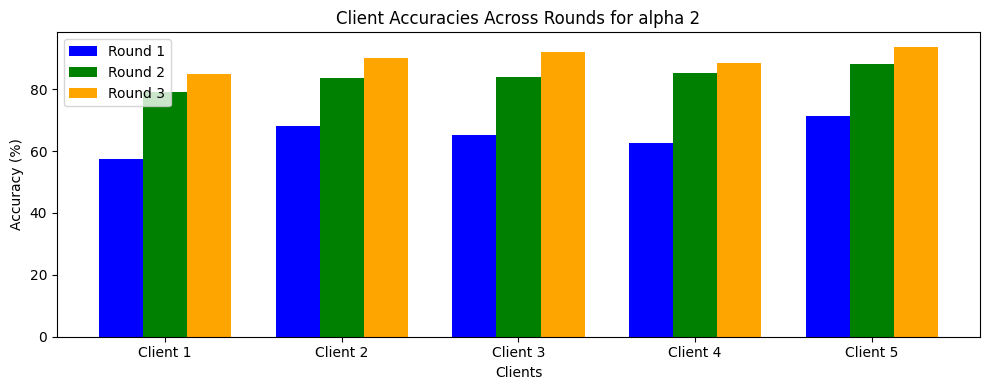

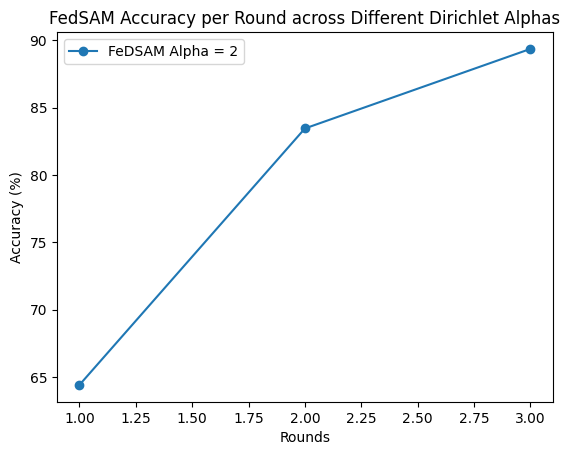

In [ ]:
# print(sam_client_accuracies[0][2])
# Extract the number of clients and rounds
for i in range(len(dirichlet_alphas)):
  num_clients = len(sam_client_accuracies[i][0])

  rounds = len(sam_client_accuracies[0])

  # Plotting the bar plots for each round
  x = np.arange(num_clients)  # Client indices
  width = 0.25  # Width of each bar

  fig, ax = plt.subplots(figsize=(10, 4))

  # Colors for each round
  colors = ['blue', 'green', 'orange']

  # Add bars for each round
  for round_idx in range(rounds):
      ax.bar(
          x + round_idx * width - (rounds - 1) * width / 2,  # Offset for bars
          sam_client_accuracies[i][round_idx],  # Accuracy data for the round
          width,  # Width of the bar
          label=f'Round {round_idx + 1}',
          color=colors[round_idx]
      )

  # Add labels, title, and legend
  ax.set_xlabel("Clients")
  ax.set_ylabel("Accuracy (%)")
  ax.set_title(f"Client Accuracies Across Rounds for alpha {dirichlet_alphas[i]}")
  ax.set_xticks(x)
  ax.set_xticklabels([f"Client {i+1}" for i in range(num_clients)])
  ax.legend()

  # Display the plot
  plt.tight_layout()
  plt.show()

plt.figure()
for idx, alpha in enumerate(dirichlet_alphas):
    plt.plot(range(1, rounds + 1), noise_sam_accuracies[idx], marker='o', label=f'FeDSAM Alpha = {alpha}')

plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('FedSAM Accuracy per Round across Different Dirichlet Alphas')
plt.show()


In [21]:
def apply_noise_based_perturbation(local_model, criterion, x_train, y_train, rho):
    """
    Applies noise-based perturbation to model parameters and measures sharpness.
    """
    local_model.train()
    x_train, y_train = x_train.to(device), y_train.to(device)

    # Forward pass without perturbation
    outputs = local_model(x_train)
    original_loss = criterion(outputs, y_train)

    # Generate Gaussian noise perturbation
    noise = {name: torch.randn_like(param) * rho for name, param in local_model.named_parameters()}

    # Apply noise perturbation
    with torch.no_grad():
        for name, param in local_model.named_parameters():
            if name in noise:
                param.add_(noise[name])

    # Forward pass with perturbed weights
    perturbed_outputs = local_model(x_train)
    perturbed_loss = criterion(perturbed_outputs, y_train)

    # Revert perturbation
    with torch.no_grad():
        for name, param in local_model.named_parameters():
            if name in noise:
                param.sub_(noise[name])

    # Measure sharpness as the increase in loss
    sharpness = (perturbed_loss - original_loss).item()
    return sharpness, original_loss


def local_train_with_noise_sharpness(model, train_loader, epochs, lr, rho=0.0001):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    overall_update = {name: torch.zeros_like(param, device=device) for name, param in model.state_dict().items()}
    epoch_sharpness_log = []  # To log sharpness for each epoch

    for epoch in range(epochs):
        epoch_loss = 0.0
        epoch_sharpness = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for x_train, y_train in progress_bar:
            x_train, y_train = x_train.to(device), y_train.to(device)

            # Apply noise-based perturbation and calculate sharpness
            sharpness, loss = apply_noise_based_perturbation(model, criterion, x_train, y_train, rho)
            epoch_sharpness += sharpness

            # Forward pass with original parameters
            optimizer.zero_grad()
            outputs = model(x_train)
            loss = criterion(outputs, y_train)

            # Backward pass and SGD update
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            progress_bar.set_postfix({"Loss": epoch_loss / len(train_loader), "Sharpness": sharpness})

        epoch_sharpness /= len(train_loader)  # Average sharpness for the epoch
        epoch_sharpness_log.append(epoch_sharpness)  # Log the average sharpness
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Avg Sharpness: {epoch_sharpness:.4f}")

    # Compute the overall model update
    for name, param in model.state_dict().items():
        overall_update[name] = param.clone()

    return overall_update, epoch_sharpness_log


def federated_training_sam(global_model, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr, rho=0.001):
    global_model.to(device)
    round_accuracies = []
    sam_client_accuracies = []
    sharpness_logs = []  # To track sharpness logs for each round

    for round_num in range(rounds):
        print(f"\n--- Federated Round {round_num + 1}/{rounds} ---")
        client_updates = []
        client_sample_counts = []  # To track the number of samples per client
        round_sharpness_log = []  # To track sharpness logs for this round

        # Distribute global model to all clients and collect updates
        for client_id in range(num_clients):
            print(f"Client {client_id + 1}/{num_clients}")
            client_model = SimpleCNN().to(device)  # Initialize local model
            client_model.load_state_dict(global_model.state_dict())  # Load global model
            train_loader = train_loaders[client_id]

            # Count samples for the client
            num_samples = len(train_loader.dataset)
            client_sample_counts.append(num_samples)

            # Local training with SAM
            update, client_sharpness_log = local_train_with_noise_sharpness(client_model, train_loader, epochs, local_lr, rho)
            client_updates.append(update)
            round_sharpness_log.append(client_sharpness_log)  # Collect client sharpness logs

        sharpness_logs.append(round_sharpness_log)  # Append round sharpness log

        # Compute weights for aggregation
        total_samples = sum(client_sample_counts)
        client_weights = [count / total_samples for count in client_sample_counts]

        # Aggregate updates with weights
        aggregated_update = {name: torch.zeros_like(param, device=device) for name, param in global_model.state_dict().items()}
        for client_id, update in enumerate(client_updates):
            for name in aggregated_update:
                aggregated_update[name] += client_weights[client_id] * update[name]

        # Update global model
        global_model_state = global_model.state_dict()
        for name in global_model_state:
            global_model_state[name] += aggregated_update[name]

        global_model.load_state_dict(global_model_state)

        # Evaluate global model
        samclientacc, accuracy = evaluate_model(global_model, test_loaders)
        round_accuracies.append(accuracy)
        sam_client_accuracies.append(samclientacc)
        print(f"Round {round_num + 1} Accuracy: {accuracy:.2f}%")

    return round_accuracies, sam_client_accuracies, sharpness_logs


# Run the FedSAM experiment
num_clients = 5
rounds = 3
epochs = 20
lr = 0.01
batch_size = 128
dirichlet_alphas = [2]

def run_fedsam_noise(alpha):
    # Partition data with a Dirichlet alpha of 0.1
    train_loaders, test_loaders, _, _ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)
    global_model_sam = SimpleCNN()
    round_accuracies, sam_client_accuracies, sharpness_logs = federated_training_sam(global_model_sam, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr=lr)
    return round_accuracies, sam_client_accuracies, sharpness_logs

# # Run FedSAM and get accuracy per round
# noise_sam_accuracies = []
# sam_client_accuracies = []
# sharpness_logs = []
# for alpha in dirichlet_alphas:
#     round_accuracies, client_accuracies, sharpness_log = run_fedsam_noise(alpha)
#     noise_sam_accuracies.append(round_accuracies)
#     sam_client_accuracies.append(client_accuracies)
#     sharpness_logs.append(sharpness_log)


In [22]:
def apply_sam_perturbation(local_model, criterion, x_train, y_train, rho):
    """
    Apply SAM perturbation to model weights and return the loss.
    """
    local_model.train()
    x_train, y_train = x_train.to(device), y_train.to(device)

    # Forward pass to calculate loss
    outputs = local_model(x_train)
    loss = criterion(outputs, y_train)

    # Compute gradients
    loss.backward()
    gradients = {name: param.grad for name, param in local_model.named_parameters() if param.grad is not None}

    # Calculate perturbation and apply it
    with torch.no_grad():
        for name, param in local_model.named_parameters():
            if param.grad is not None:
                grad = gradients[name]
                norm = torch.norm(grad)
                if norm != 0:
                    perturbation = rho * grad / norm
                    param.add_(perturbation)  # Apply the perturbation

    return loss  # Return the original loss for tracking


def local_train_sam(model, train_loader, epochs, lr, rho=0.0001):
    """
    Perform local training using SAM and log sharpness.
    """
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    overall_update = {name: torch.zeros_like(param, device=device) for name, param in model.state_dict().items()}
    sharpness_logs = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        epoch_sharpness = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for x_train, y_train in progress_bar:
            # Move data to the appropriate device
            x_train, y_train = x_train.to(device), y_train.to(device)

            # Apply SAM perturbation and calculate sharpness
            optimizer.zero_grad()
            original_loss = apply_sam_perturbation(model, criterion, x_train, y_train, rho)

            # Forward pass with perturbed weights
            outputs = model(x_train)
            perturbed_loss = criterion(outputs, y_train)
            sharpness = (perturbed_loss - original_loss).item()
            epoch_sharpness += sharpness

            # Backward pass and SGD update
            perturbed_loss.backward()
            optimizer.step()
            epoch_loss += perturbed_loss.item()
            progress_bar.set_postfix({"Loss": epoch_loss / len(train_loader), "Sharpness": sharpness})

        # Log sharpness for this epoch
        epoch_sharpness /= len(train_loader)
        sharpness_logs.append(epoch_sharpness)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Avg Sharpness: {epoch_sharpness:.4f}")

    # Compute the overall model update
    for name, param in model.state_dict().items():
        overall_update[name] = param.clone()

    return overall_update, sharpness_logs


def federated_training_sam(global_model, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr, rho=0.001):
    """
    Perform federated training using SAM and return sharpness logs.
    """
    global_model.to(device)
    round_accuracies = []
    sam_client_accuracies = []
    sharpness_logs = []  # To store sharpness logs for all rounds

    for round_num in range(rounds):
        print(f"\n--- Federated Round {round_num + 1}/{rounds} ---")
        client_updates = []
        client_sample_counts = []
        round_sharpness_log = []  # To store sharpness logs for this round

        for client_id in range(num_clients):
            print(f"Client {client_id + 1}/{num_clients}")
            client_model = SimpleCNN().to(device)
            client_model.load_state_dict(global_model.state_dict())
            train_loader = train_loaders[client_id]

            # Count samples for the client
            num_samples = len(train_loader.dataset)
            client_sample_counts.append(num_samples)

            # Local training with SAM
            update, client_sharpness_log = local_train_sam(client_model, train_loader, epochs, local_lr, rho)
            client_updates.append(update)
            round_sharpness_log.append(client_sharpness_log)  # Log sharpness for this client

        sharpness_logs.append(round_sharpness_log)  # Append round sharpness log

        # Compute weights for aggregation
        total_samples = sum(client_sample_counts)
        client_weights = [count / total_samples for count in client_sample_counts]

        # Aggregate updates with weights
        aggregated_update = {name: torch.zeros_like(param, device=device) for name, param in global_model.state_dict().items()}
        for client_id, update in enumerate(client_updates):
            for name in aggregated_update:
                aggregated_update[name] += client_weights[client_id] * update[name]

        # Update global model
        global_model_state = global_model.state_dict()
        for name in global_model_state:
            global_model_state[name] += aggregated_update[name]

        global_model.load_state_dict(global_model_state)

        # Evaluate global model
        samclientacc, accuracy = evaluate_model(global_model, test_loaders)
        round_accuracies.append(accuracy)
        sam_client_accuracies.append(samclientacc)
        print(f"Round {round_num + 1} Accuracy: {accuracy:.2f}%")

    return round_accuracies, sam_client_accuracies, sharpness_logs


# Run the FedSAM experiment
num_clients = 5
rounds = 3
epochs = 20
lr = 0.01
batch_size = 128
dirichlet_alphas = [2, 0.5, 0.1]

def run_fedsam(alpha):
    """
    Run the FedSAM experiment with a given Dirichlet alpha.
    """
    train_loaders, test_loaders, _, _ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)
    global_model_sam = SimpleCNN()
    round_accuracies, client_nsam_acc, sharpness_logs = federated_training_sam(global_model_sam, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr=lr)
    return round_accuracies, client_nsam_acc, sharpness_logs

# Run FedSAM and get accuracy per round
sam_accuracies = []
client_nsam_acc = []
sharpness_logs = []

# for alpha in dirichlet_alphas:
#     round_accuracies, acc, sharpness_log = run_fedsam(alpha)
#     sam_accuracies.append(round_accuracies)
#     client_nsam_acc.append(acc)
#     sharpness_logs.append(sharpness_log)



--- Federated Round 1/3 ---
Client 1/5


Epoch 1/20, Loss: 1.5448, Avg Sharpness: 0.0100


Epoch 2/20, Loss: 1.6675, Avg Sharpness: 0.0098


Epoch 3/20, Loss: 1.5453, Avg Sharpness: 0.0101


Epoch 4/20, Loss: 1.3162, Avg Sharpness: 0.0102


Epoch 5/20, Loss: 1.1128, Avg Sharpness: 0.0098


Epoch 6/20, Loss: 0.8691, Avg Sharpness: 0.0087


Epoch 7/20, Loss: 0.7031, Avg Sharpness: 0.0077


Epoch 8/20, Loss: 0.6075, Avg Sharpness: 0.0070


Epoch 9/20, Loss: 0.5560, Avg Sharpness: 0.0066


Epoch 10/20, Loss: 0.5243, Avg Sharpness: 0.0063


Epoch 11/20, Loss: 0.5033, Avg Sharpness: 0.0060


Epoch 12/20, Loss: 0.4850, Avg Sharpness: 0.0058


Epoch 13/20, Loss: 0.4663, Avg Sharpness: 0.0057


Epoch 14/20, Loss: 0.4516, Avg Sharpness: 0.0056


Epoch 15/20, Loss: 0.4393, Avg Sharpness: 0.0055


Epoch 16/20, Loss: 0.4269, Avg Sharpness: 0.0054


Epoch 17/20, Loss: 0.4154, Avg Sharpness: 0.0053


Epoch 18/20, Loss: 0.4013, Avg Sharpness: 0.0052


Epoch 19/20, Loss: 0.3860, Avg Sharpness: 0.0051


Epoch 20/20, Loss: 0.3700, Avg Sharpness: 0.0049
Client 2/5


Epoch 1/20, Loss: 1.5879, Avg Sharpness: 0.0075


Epoch 2/20, Loss: 1.7548, Avg Sharpness: 0.0066


Epoch 3/20, Loss: 1.7166, Avg Sharpness: 0.0069


Epoch 4/20, Loss: 1.4649, Avg Sharpness: 0.0085


Epoch 5/20, Loss: 1.2695, Avg Sharpness: 0.0087


Epoch 6/20, Loss: 1.0592, Avg Sharpness: 0.0085


Epoch 7/20, Loss: 0.8983, Avg Sharpness: 0.0081


Epoch 8/20, Loss: 0.7840, Avg Sharpness: 0.0077


Epoch 9/20, Loss: 0.7087, Avg Sharpness: 0.0074


Epoch 10/20, Loss: 0.6576, Avg Sharpness: 0.0071


Epoch 11/20, Loss: 0.6168, Avg Sharpness: 0.0068


Epoch 12/20, Loss: 0.5824, Avg Sharpness: 0.0066


Epoch 13/20, Loss: 0.5517, Avg Sharpness: 0.0064


Epoch 14/20, Loss: 0.5278, Avg Sharpness: 0.0062


Epoch 15/20, Loss: 0.5059, Avg Sharpness: 0.0060


Epoch 16/20, Loss: 0.4888, Avg Sharpness: 0.0059


Epoch 17/20, Loss: 0.4704, Avg Sharpness: 0.0058


Epoch 18/20, Loss: 0.4525, Avg Sharpness: 0.0056


Epoch 19/20, Loss: 0.4340, Avg Sharpness: 0.0055


Epoch 20/20, Loss: 0.4157, Avg Sharpness: 0.0054
Client 3/5


Epoch 1/20, Loss: 1.5810, Avg Sharpness: 0.0089


Epoch 2/20, Loss: 1.6314, Avg Sharpness: 0.0089


Epoch 3/20, Loss: 1.5467, Avg Sharpness: 0.0095


Epoch 4/20, Loss: 1.3259, Avg Sharpness: 0.0096


Epoch 5/20, Loss: 1.0624, Avg Sharpness: 0.0093


Epoch 6/20, Loss: 0.8449, Avg Sharpness: 0.0086


Epoch 7/20, Loss: 0.6378, Avg Sharpness: 0.0075


Epoch 8/20, Loss: 0.5382, Avg Sharpness: 0.0068


Epoch 9/20, Loss: 0.4971, Avg Sharpness: 0.0064


Epoch 10/20, Loss: 0.4621, Avg Sharpness: 0.0061


Epoch 11/20, Loss: 0.4367, Avg Sharpness: 0.0059


Epoch 12/20, Loss: 0.4254, Avg Sharpness: 0.0057


Epoch 13/20, Loss: 0.4124, Avg Sharpness: 0.0056


Epoch 14/20, Loss: 0.3957, Avg Sharpness: 0.0054


Epoch 15/20, Loss: 0.3874, Avg Sharpness: 0.0054


Epoch 16/20, Loss: 0.3834, Avg Sharpness: 0.0053


Epoch 17/20, Loss: 0.3756, Avg Sharpness: 0.0052


Epoch 18/20, Loss: 0.3682, Avg Sharpness: 0.0051


Epoch 19/20, Loss: 0.3603, Avg Sharpness: 0.0051


Epoch 20/20, Loss: 0.3504, Avg Sharpness: 0.0050
Client 4/5


Epoch 1/20, Loss: 1.2550, Avg Sharpness: 0.0084


Epoch 2/20, Loss: 1.2493, Avg Sharpness: 0.0089


Epoch 3/20, Loss: 1.0671, Avg Sharpness: 0.0085


Epoch 4/20, Loss: 0.9075, Avg Sharpness: 0.0081


Epoch 5/20, Loss: 0.7367, Avg Sharpness: 0.0073


Epoch 6/20, Loss: 0.6061, Avg Sharpness: 0.0065


Epoch 7/20, Loss: 0.5095, Avg Sharpness: 0.0058


Epoch 8/20, Loss: 0.4590, Avg Sharpness: 0.0054


Epoch 9/20, Loss: 0.4257, Avg Sharpness: 0.0051


Epoch 10/20, Loss: 0.3988, Avg Sharpness: 0.0049


Epoch 11/20, Loss: 0.3794, Avg Sharpness: 0.0048


Epoch 12/20, Loss: 0.3633, Avg Sharpness: 0.0046


Epoch 13/20, Loss: 0.3479, Avg Sharpness: 0.0045


Epoch 14/20, Loss: 0.3356, Avg Sharpness: 0.0044


Epoch 15/20, Loss: 0.3257, Avg Sharpness: 0.0043


Epoch 16/20, Loss: 0.3170, Avg Sharpness: 0.0043


Epoch 17/20, Loss: 0.3086, Avg Sharpness: 0.0042


Epoch 18/20, Loss: 0.2994, Avg Sharpness: 0.0041


Epoch 19/20, Loss: 0.2894, Avg Sharpness: 0.0040


Epoch 20/20, Loss: 0.2784, Avg Sharpness: 0.0040
Client 5/5


Epoch 1/20, Loss: 1.5776, Avg Sharpness: 0.0083


Epoch 2/20, Loss: 1.6377, Avg Sharpness: 0.0091


Epoch 3/20, Loss: 1.3706, Avg Sharpness: 0.0093


Epoch 4/20, Loss: 1.0916, Avg Sharpness: 0.0090


Epoch 5/20, Loss: 0.8736, Avg Sharpness: 0.0082


Epoch 6/20, Loss: 0.7393, Avg Sharpness: 0.0075


Epoch 7/20, Loss: 0.6375, Avg Sharpness: 0.0069


Epoch 8/20, Loss: 0.5674, Avg Sharpness: 0.0064


Epoch 9/20, Loss: 0.5157, Avg Sharpness: 0.0061


Epoch 10/20, Loss: 0.4777, Avg Sharpness: 0.0058


Epoch 11/20, Loss: 0.4504, Avg Sharpness: 0.0055


Epoch 12/20, Loss: 0.4345, Avg Sharpness: 0.0054


Epoch 13/20, Loss: 0.4255, Avg Sharpness: 0.0053


Epoch 14/20, Loss: 0.4178, Avg Sharpness: 0.0052


Epoch 15/20, Loss: 0.4079, Avg Sharpness: 0.0051


Epoch 16/20, Loss: 0.3976, Avg Sharpness: 0.0050


Epoch 17/20, Loss: 0.3886, Avg Sharpness: 0.0049


Epoch 18/20, Loss: 0.3779, Avg Sharpness: 0.0048


Epoch 19/20, Loss: 0.3675, Avg Sharpness: 0.0047


Epoch 20/20, Loss: 0.3564, Avg Sharpness: 0.0046

Evaluating Client 0
Client 0 Accuracy: 59.09%

Evaluating Client 1
Client 1 Accuracy: 77.01%

Evaluating Client 2
Client 2 Accuracy: 59.56%

Evaluating Client 3
Client 3 Accuracy: 64.91%

Evaluating Client 4
Client 4 Accuracy: 73.26%
Total Accuracy: 65.97%
Round 1 Accuracy: 65.97%

--- Federated Round 2/3 ---
Client 1/5


Epoch 1/20, Loss: 0.3730, Avg Sharpness: 0.0054


Epoch 2/20, Loss: 0.3085, Avg Sharpness: 0.0046


Epoch 3/20, Loss: 0.2725, Avg Sharpness: 0.0043


Epoch 4/20, Loss: 0.2477, Avg Sharpness: 0.0041


Epoch 5/20, Loss: 0.2296, Avg Sharpness: 0.0039


Epoch 6/20, Loss: 0.2146, Avg Sharpness: 0.0038


Epoch 7/20, Loss: 0.2020, Avg Sharpness: 0.0037


Epoch 8/20, Loss: 0.1909, Avg Sharpness: 0.0036


Epoch 9/20, Loss: 0.1807, Avg Sharpness: 0.0035


Epoch 10/20, Loss: 0.1718, Avg Sharpness: 0.0034


Epoch 11/20, Loss: 0.1637, Avg Sharpness: 0.0033


Epoch 12/20, Loss: 0.1561, Avg Sharpness: 0.0033


Epoch 13/20, Loss: 0.1491, Avg Sharpness: 0.0032


Epoch 14/20, Loss: 0.1425, Avg Sharpness: 0.0031


Epoch 15/20, Loss: 0.1363, Avg Sharpness: 0.0030


Epoch 16/20, Loss: 0.1305, Avg Sharpness: 0.0030


Epoch 17/20, Loss: 0.1251, Avg Sharpness: 0.0029


Epoch 18/20, Loss: 0.1202, Avg Sharpness: 0.0029


Epoch 19/20, Loss: 0.1154, Avg Sharpness: 0.0028


Epoch 20/20, Loss: 0.1108, Avg Sharpness: 0.0027
Client 2/5


Epoch 1/20, Loss: 0.3939, Avg Sharpness: 0.0063


Epoch 2/20, Loss: 0.3197, Avg Sharpness: 0.0049


Epoch 3/20, Loss: 0.2851, Avg Sharpness: 0.0046


Epoch 4/20, Loss: 0.2630, Avg Sharpness: 0.0044


Epoch 5/20, Loss: 0.2451, Avg Sharpness: 0.0042


Epoch 6/20, Loss: 0.2300, Avg Sharpness: 0.0041


Epoch 7/20, Loss: 0.2166, Avg Sharpness: 0.0040


Epoch 8/20, Loss: 0.2048, Avg Sharpness: 0.0039


Epoch 9/20, Loss: 0.1939, Avg Sharpness: 0.0038


Epoch 10/20, Loss: 0.1840, Avg Sharpness: 0.0037


Epoch 11/20, Loss: 0.1749, Avg Sharpness: 0.0036


Epoch 12/20, Loss: 0.1669, Avg Sharpness: 0.0036


Epoch 13/20, Loss: 0.1595, Avg Sharpness: 0.0035


Epoch 14/20, Loss: 0.1524, Avg Sharpness: 0.0034


Epoch 15/20, Loss: 0.1460, Avg Sharpness: 0.0033


Epoch 16/20, Loss: 0.1398, Avg Sharpness: 0.0033


Epoch 17/20, Loss: 0.1341, Avg Sharpness: 0.0032


Epoch 18/20, Loss: 0.1289, Avg Sharpness: 0.0031


Epoch 19/20, Loss: 0.1239, Avg Sharpness: 0.0031


Epoch 20/20, Loss: 0.1192, Avg Sharpness: 0.0030
Client 3/5


Epoch 1/20, Loss: 0.3439, Avg Sharpness: 0.0052


Epoch 2/20, Loss: 0.2945, Avg Sharpness: 0.0046


Epoch 3/20, Loss: 0.2697, Avg Sharpness: 0.0044


Epoch 4/20, Loss: 0.2454, Avg Sharpness: 0.0042


Epoch 5/20, Loss: 0.2264, Avg Sharpness: 0.0040


Epoch 6/20, Loss: 0.2105, Avg Sharpness: 0.0039


Epoch 7/20, Loss: 0.1972, Avg Sharpness: 0.0038


Epoch 8/20, Loss: 0.1854, Avg Sharpness: 0.0037


Epoch 9/20, Loss: 0.1751, Avg Sharpness: 0.0036


Epoch 10/20, Loss: 0.1656, Avg Sharpness: 0.0035


Epoch 11/20, Loss: 0.1568, Avg Sharpness: 0.0034


Epoch 12/20, Loss: 0.1485, Avg Sharpness: 0.0033


Epoch 13/20, Loss: 0.1410, Avg Sharpness: 0.0032


Epoch 14/20, Loss: 0.1340, Avg Sharpness: 0.0031


Epoch 15/20, Loss: 0.1275, Avg Sharpness: 0.0031


Epoch 16/20, Loss: 0.1216, Avg Sharpness: 0.0030


Epoch 17/20, Loss: 0.1161, Avg Sharpness: 0.0029


Epoch 18/20, Loss: 0.1110, Avg Sharpness: 0.0029


Epoch 19/20, Loss: 0.1061, Avg Sharpness: 0.0028


Epoch 20/20, Loss: 0.1017, Avg Sharpness: 0.0028
Client 4/5


Epoch 1/20, Loss: 0.2755, Avg Sharpness: 0.0042


Epoch 2/20, Loss: 0.2439, Avg Sharpness: 0.0037


Epoch 3/20, Loss: 0.2192, Avg Sharpness: 0.0035


Epoch 4/20, Loss: 0.2006, Avg Sharpness: 0.0034


Epoch 5/20, Loss: 0.1854, Avg Sharpness: 0.0033


Epoch 6/20, Loss: 0.1739, Avg Sharpness: 0.0032


Epoch 7/20, Loss: 0.1655, Avg Sharpness: 0.0031


Epoch 8/20, Loss: 0.1586, Avg Sharpness: 0.0031


Epoch 9/20, Loss: 0.1517, Avg Sharpness: 0.0030


Epoch 10/20, Loss: 0.1455, Avg Sharpness: 0.0029


Epoch 11/20, Loss: 0.1396, Avg Sharpness: 0.0029


Epoch 12/20, Loss: 0.1341, Avg Sharpness: 0.0028


Epoch 13/20, Loss: 0.1288, Avg Sharpness: 0.0028


Epoch 14/20, Loss: 0.1240, Avg Sharpness: 0.0027


Epoch 15/20, Loss: 0.1194, Avg Sharpness: 0.0027


Epoch 16/20, Loss: 0.1150, Avg Sharpness: 0.0026


Epoch 17/20, Loss: 0.1108, Avg Sharpness: 0.0025


Epoch 18/20, Loss: 0.1067, Avg Sharpness: 0.0025


Epoch 19/20, Loss: 0.1029, Avg Sharpness: 0.0024


Epoch 20/20, Loss: 0.0992, Avg Sharpness: 0.0024
Client 5/5


Epoch 1/20, Loss: 0.4265, Avg Sharpness: 0.0058


Epoch 2/20, Loss: 0.3196, Avg Sharpness: 0.0045


Epoch 3/20, Loss: 0.2859, Avg Sharpness: 0.0041


Epoch 4/20, Loss: 0.2612, Avg Sharpness: 0.0039


Epoch 5/20, Loss: 0.2418, Avg Sharpness: 0.0038


Epoch 6/20, Loss: 0.2256, Avg Sharpness: 0.0036


Epoch 7/20, Loss: 0.2126, Avg Sharpness: 0.0035


Epoch 8/20, Loss: 0.2011, Avg Sharpness: 0.0034


Epoch 9/20, Loss: 0.1909, Avg Sharpness: 0.0033


Epoch 10/20, Loss: 0.1816, Avg Sharpness: 0.0033


Epoch 11/20, Loss: 0.1729, Avg Sharpness: 0.0032


Epoch 12/20, Loss: 0.1647, Avg Sharpness: 0.0031


Epoch 13/20, Loss: 0.1573, Avg Sharpness: 0.0031


Epoch 14/20, Loss: 0.1502, Avg Sharpness: 0.0030


Epoch 15/20, Loss: 0.1438, Avg Sharpness: 0.0029


Epoch 16/20, Loss: 0.1376, Avg Sharpness: 0.0029


Epoch 17/20, Loss: 0.1319, Avg Sharpness: 0.0028


Epoch 18/20, Loss: 0.1266, Avg Sharpness: 0.0028


Epoch 19/20, Loss: 0.1216, Avg Sharpness: 0.0027


Epoch 20/20, Loss: 0.1170, Avg Sharpness: 0.0027

Evaluating Client 0
Client 0 Accuracy: 79.21%

Evaluating Client 1
Client 1 Accuracy: 88.62%

Evaluating Client 2
Client 2 Accuracy: 82.68%

Evaluating Client 3
Client 3 Accuracy: 83.83%

Evaluating Client 4
Client 4 Accuracy: 89.86%
Total Accuracy: 84.47%
Round 2 Accuracy: 84.47%

--- Federated Round 3/3 ---
Client 1/5


Epoch 1/20, Loss: 2.9362, Avg Sharpness: 0.0177


Epoch 2/20, Loss: 0.4314, Avg Sharpness: 0.0066


Epoch 3/20, Loss: 0.2799, Avg Sharpness: 0.0049


Epoch 4/20, Loss: 0.2358, Avg Sharpness: 0.0045


Epoch 5/20, Loss: 0.2008, Avg Sharpness: 0.0041


Epoch 6/20, Loss: 0.1810, Avg Sharpness: 0.0038


Epoch 7/20, Loss: 0.1654, Avg Sharpness: 0.0037


Epoch 8/20, Loss: 0.1536, Avg Sharpness: 0.0036


Epoch 9/20, Loss: 0.1447, Avg Sharpness: 0.0034


Epoch 10/20, Loss: 0.1344, Avg Sharpness: 0.0032


Epoch 11/20, Loss: 0.1222, Avg Sharpness: 0.0031


Epoch 12/20, Loss: 0.1109, Avg Sharpness: 0.0029


Epoch 13/20, Loss: 0.1017, Avg Sharpness: 0.0028


Epoch 14/20, Loss: 0.0941, Avg Sharpness: 0.0027


Epoch 15/20, Loss: 0.0877, Avg Sharpness: 0.0026


Epoch 16/20, Loss: 0.0822, Avg Sharpness: 0.0025


Epoch 17/20, Loss: 0.0778, Avg Sharpness: 0.0025


Epoch 18/20, Loss: 0.0738, Avg Sharpness: 0.0024


Epoch 19/20, Loss: 0.0706, Avg Sharpness: 0.0024


Epoch 20/20, Loss: 0.0676, Avg Sharpness: 0.0023
Client 2/5


Epoch 1/20, Loss: 2.6709, Avg Sharpness: 0.0201


Epoch 2/20, Loss: 0.6040, Avg Sharpness: 0.0081


Epoch 3/20, Loss: 0.2983, Avg Sharpness: 0.0058


Epoch 4/20, Loss: 0.2233, Avg Sharpness: 0.0050


Epoch 5/20, Loss: 0.1849, Avg Sharpness: 0.0045


Epoch 6/20, Loss: 0.1619, Avg Sharpness: 0.0042


Epoch 7/20, Loss: 0.1482, Avg Sharpness: 0.0040


Epoch 8/20, Loss: 0.1381, Avg Sharpness: 0.0039


Epoch 9/20, Loss: 0.1306, Avg Sharpness: 0.0038


Epoch 10/20, Loss: 0.1226, Avg Sharpness: 0.0036


Epoch 11/20, Loss: 0.1147, Avg Sharpness: 0.0035


Epoch 12/20, Loss: 0.1077, Avg Sharpness: 0.0033


Epoch 13/20, Loss: 0.1011, Avg Sharpness: 0.0032


Epoch 14/20, Loss: 0.0945, Avg Sharpness: 0.0031


Epoch 15/20, Loss: 0.0880, Avg Sharpness: 0.0029


Epoch 16/20, Loss: 0.0818, Avg Sharpness: 0.0028


Epoch 17/20, Loss: 0.0764, Avg Sharpness: 0.0027


Epoch 18/20, Loss: 0.0715, Avg Sharpness: 0.0026


Epoch 19/20, Loss: 0.0671, Avg Sharpness: 0.0025


Epoch 20/20, Loss: 0.0631, Avg Sharpness: 0.0025
Client 3/5


Epoch 1/20, Loss: 3.0859, Avg Sharpness: 0.0181


Epoch 2/20, Loss: 0.3697, Avg Sharpness: 0.0060


Epoch 3/20, Loss: 0.2553, Avg Sharpness: 0.0048


Epoch 4/20, Loss: 0.2079, Avg Sharpness: 0.0043


Epoch 5/20, Loss: 0.1788, Avg Sharpness: 0.0040


Epoch 6/20, Loss: 0.1599, Avg Sharpness: 0.0038


Epoch 7/20, Loss: 0.1435, Avg Sharpness: 0.0036


Epoch 8/20, Loss: 0.1280, Avg Sharpness: 0.0034


Epoch 9/20, Loss: 0.1170, Avg Sharpness: 0.0033


Epoch 10/20, Loss: 0.1072, Avg Sharpness: 0.0031


Epoch 11/20, Loss: 0.0988, Avg Sharpness: 0.0030


Epoch 12/20, Loss: 0.0925, Avg Sharpness: 0.0029


Epoch 13/20, Loss: 0.0871, Avg Sharpness: 0.0028


Epoch 14/20, Loss: 0.0823, Avg Sharpness: 0.0028


Epoch 15/20, Loss: 0.0782, Avg Sharpness: 0.0027


Epoch 16/20, Loss: 0.0743, Avg Sharpness: 0.0027


Epoch 17/20, Loss: 0.0704, Avg Sharpness: 0.0026


Epoch 18/20, Loss: 0.0667, Avg Sharpness: 0.0025


Epoch 19/20, Loss: 0.0631, Avg Sharpness: 0.0025


Epoch 20/20, Loss: 0.0595, Avg Sharpness: 0.0024
Client 4/5


Epoch 1/20, Loss: 2.0223, Avg Sharpness: 0.0137


Epoch 2/20, Loss: 0.5322, Avg Sharpness: 0.0071


Epoch 3/20, Loss: 0.3070, Avg Sharpness: 0.0049


Epoch 4/20, Loss: 0.2163, Avg Sharpness: 0.0041


Epoch 5/20, Loss: 0.1798, Avg Sharpness: 0.0038


Epoch 6/20, Loss: 0.1749, Avg Sharpness: 0.0037


Epoch 7/20, Loss: 0.1650, Avg Sharpness: 0.0035


Epoch 8/20, Loss: 0.1425, Avg Sharpness: 0.0033


Epoch 9/20, Loss: 0.1341, Avg Sharpness: 0.0032


Epoch 10/20, Loss: 0.1183, Avg Sharpness: 0.0030


Epoch 11/20, Loss: 0.1114, Avg Sharpness: 0.0029


Epoch 12/20, Loss: 0.1095, Avg Sharpness: 0.0029


Epoch 13/20, Loss: 0.1069, Avg Sharpness: 0.0028


Epoch 14/20, Loss: 0.1039, Avg Sharpness: 0.0028


Epoch 15/20, Loss: 0.1011, Avg Sharpness: 0.0027


Epoch 16/20, Loss: 0.0968, Avg Sharpness: 0.0026


Epoch 17/20, Loss: 0.0921, Avg Sharpness: 0.0026


Epoch 18/20, Loss: 0.0865, Avg Sharpness: 0.0025


Epoch 19/20, Loss: 0.0806, Avg Sharpness: 0.0024


Epoch 20/20, Loss: 0.0749, Avg Sharpness: 0.0023
Client 5/5


Epoch 1/20, Loss: 3.3216, Avg Sharpness: 0.0181


Epoch 2/20, Loss: 0.4660, Avg Sharpness: 0.0072


Epoch 3/20, Loss: 0.4282, Avg Sharpness: 0.0064


Epoch 4/20, Loss: 0.2758, Avg Sharpness: 0.0047


Epoch 5/20, Loss: 0.2211, Avg Sharpness: 0.0041


Epoch 6/20, Loss: 0.1958, Avg Sharpness: 0.0039


Epoch 7/20, Loss: 0.1747, Avg Sharpness: 0.0036


Epoch 8/20, Loss: 0.1563, Avg Sharpness: 0.0035


Epoch 9/20, Loss: 0.1414, Avg Sharpness: 0.0033


Epoch 10/20, Loss: 0.1285, Avg Sharpness: 0.0032


Epoch 11/20, Loss: 0.1179, Avg Sharpness: 0.0030


Epoch 12/20, Loss: 0.1087, Avg Sharpness: 0.0029


Epoch 13/20, Loss: 0.1016, Avg Sharpness: 0.0028


Epoch 14/20, Loss: 0.0957, Avg Sharpness: 0.0027


Epoch 15/20, Loss: 0.0908, Avg Sharpness: 0.0026


Epoch 16/20, Loss: 0.0862, Avg Sharpness: 0.0026


Epoch 17/20, Loss: 0.0818, Avg Sharpness: 0.0025


Epoch 18/20, Loss: 0.0776, Avg Sharpness: 0.0024


Epoch 19/20, Loss: 0.0735, Avg Sharpness: 0.0024


Epoch 20/20, Loss: 0.0697, Avg Sharpness: 0.0023

Evaluating Client 0
Client 0 Accuracy: 74.87%

Evaluating Client 1
Client 1 Accuracy: 87.89%

Evaluating Client 2
Client 2 Accuracy: 86.33%

Evaluating Client 3
Client 3 Accuracy: 83.70%

Evaluating Client 4
Client 4 Accuracy: 90.00%
Total Accuracy: 84.24%
Round 3 Accuracy: 84.24%

--- Federated Round 1/3 ---
Client 1/5


Epoch 1/20, Loss: 1.7821, Avg Sharpness: 0.0093


Epoch 2/20, Loss: 1.9894, Avg Sharpness: 0.0076


Epoch 3/20, Loss: 1.9736, Avg Sharpness: 0.0071


Epoch 4/20, Loss: 1.7694, Avg Sharpness: 0.0089


Epoch 5/20, Loss: 1.5156, Avg Sharpness: 0.0098


Epoch 6/20, Loss: 1.1666, Avg Sharpness: 0.0095


Epoch 7/20, Loss: 0.8497, Avg Sharpness: 0.0085


Epoch 8/20, Loss: 0.6510, Avg Sharpness: 0.0074


Epoch 9/20, Loss: 0.5493, Avg Sharpness: 0.0066


Epoch 10/20, Loss: 0.5025, Avg Sharpness: 0.0062


Epoch 11/20, Loss: 0.4752, Avg Sharpness: 0.0060


Epoch 12/20, Loss: 0.4575, Avg Sharpness: 0.0058


Epoch 13/20, Loss: 0.4409, Avg Sharpness: 0.0057


Epoch 14/20, Loss: 0.4289, Avg Sharpness: 0.0056


Epoch 15/20, Loss: 0.4144, Avg Sharpness: 0.0054


Epoch 16/20, Loss: 0.4009, Avg Sharpness: 0.0053


Epoch 17/20, Loss: 0.3894, Avg Sharpness: 0.0052


Epoch 18/20, Loss: 0.3768, Avg Sharpness: 0.0051


Epoch 19/20, Loss: 0.3633, Avg Sharpness: 0.0050


Epoch 20/20, Loss: 0.3484, Avg Sharpness: 0.0048
Client 2/5


Epoch 1/20, Loss: 1.6654, Avg Sharpness: 0.0091


Epoch 2/20, Loss: 1.6969, Avg Sharpness: 0.0093


Epoch 3/20, Loss: 1.4145, Avg Sharpness: 0.0094


Epoch 4/20, Loss: 1.1576, Avg Sharpness: 0.0090


Epoch 5/20, Loss: 0.8810, Avg Sharpness: 0.0082


Epoch 6/20, Loss: 0.6805, Avg Sharpness: 0.0072


Epoch 7/20, Loss: 0.5616, Avg Sharpness: 0.0064


Epoch 8/20, Loss: 0.4931, Avg Sharpness: 0.0059


Epoch 9/20, Loss: 0.4469, Avg Sharpness: 0.0056


Epoch 10/20, Loss: 0.4148, Avg Sharpness: 0.0053


Epoch 11/20, Loss: 0.3915, Avg Sharpness: 0.0051


Epoch 12/20, Loss: 0.3765, Avg Sharpness: 0.0050


Epoch 13/20, Loss: 0.3649, Avg Sharpness: 0.0049


Epoch 14/20, Loss: 0.3574, Avg Sharpness: 0.0048


Epoch 15/20, Loss: 0.3529, Avg Sharpness: 0.0048


Epoch 16/20, Loss: 0.3488, Avg Sharpness: 0.0048


Epoch 17/20, Loss: 0.3434, Avg Sharpness: 0.0047


Epoch 18/20, Loss: 0.3354, Avg Sharpness: 0.0046


Epoch 19/20, Loss: 0.3242, Avg Sharpness: 0.0045


Epoch 20/20, Loss: 0.3101, Avg Sharpness: 0.0044
Client 3/5


Epoch 1/20, Loss: 1.8708, Avg Sharpness: 0.0092


Epoch 2/20, Loss: 1.8491, Avg Sharpness: 0.0098


Epoch 3/20, Loss: 1.5901, Avg Sharpness: 0.0101


Epoch 4/20, Loss: 1.2273, Avg Sharpness: 0.0096


Epoch 5/20, Loss: 0.9901, Avg Sharpness: 0.0087


Epoch 6/20, Loss: 0.8188, Avg Sharpness: 0.0080


Epoch 7/20, Loss: 0.6922, Avg Sharpness: 0.0073


Epoch 8/20, Loss: 0.5967, Avg Sharpness: 0.0068


Epoch 9/20, Loss: 0.5329, Avg Sharpness: 0.0064


Epoch 10/20, Loss: 0.4914, Avg Sharpness: 0.0061


Epoch 11/20, Loss: 0.4656, Avg Sharpness: 0.0058


Epoch 12/20, Loss: 0.4493, Avg Sharpness: 0.0057


Epoch 13/20, Loss: 0.4351, Avg Sharpness: 0.0055


Epoch 14/20, Loss: 0.4227, Avg Sharpness: 0.0054


Epoch 15/20, Loss: 0.4095, Avg Sharpness: 0.0053


Epoch 16/20, Loss: 0.3971, Avg Sharpness: 0.0052


Epoch 17/20, Loss: 0.3848, Avg Sharpness: 0.0050


Epoch 18/20, Loss: 0.3707, Avg Sharpness: 0.0049


Epoch 19/20, Loss: 0.3560, Avg Sharpness: 0.0048


Epoch 20/20, Loss: 0.3413, Avg Sharpness: 0.0047
Client 4/5


Epoch 1/20, Loss: 1.9703, Avg Sharpness: 0.0076


Epoch 2/20, Loss: 2.0104, Avg Sharpness: 0.0075


Epoch 3/20, Loss: 1.7244, Avg Sharpness: 0.0093


Epoch 4/20, Loss: 1.3699, Avg Sharpness: 0.0097


Epoch 5/20, Loss: 1.1006, Avg Sharpness: 0.0094


Epoch 6/20, Loss: 0.8628, Avg Sharpness: 0.0084


Epoch 7/20, Loss: 0.6977, Avg Sharpness: 0.0074


Epoch 8/20, Loss: 0.6014, Avg Sharpness: 0.0068


Epoch 9/20, Loss: 0.5482, Avg Sharpness: 0.0064


Epoch 10/20, Loss: 0.5201, Avg Sharpness: 0.0062


Epoch 11/20, Loss: 0.5011, Avg Sharpness: 0.0060


Epoch 12/20, Loss: 0.4897, Avg Sharpness: 0.0059


Epoch 13/20, Loss: 0.4791, Avg Sharpness: 0.0058


Epoch 14/20, Loss: 0.4692, Avg Sharpness: 0.0057


Epoch 15/20, Loss: 0.4603, Avg Sharpness: 0.0056


Epoch 16/20, Loss: 0.4527, Avg Sharpness: 0.0056


Epoch 17/20, Loss: 0.4431, Avg Sharpness: 0.0055


Epoch 18/20, Loss: 0.4331, Avg Sharpness: 0.0054


Epoch 19/20, Loss: 0.4160, Avg Sharpness: 0.0053


Epoch 20/20, Loss: 0.3969, Avg Sharpness: 0.0052
Client 5/5


Epoch 1/20, Loss: 1.9038, Avg Sharpness: 0.0086


Epoch 2/20, Loss: 2.0411, Avg Sharpness: 0.0081


Epoch 3/20, Loss: 1.7962, Avg Sharpness: 0.0090


Epoch 4/20, Loss: 1.5413, Avg Sharpness: 0.0098


Epoch 5/20, Loss: 1.2643, Avg Sharpness: 0.0099


Epoch 6/20, Loss: 0.9720, Avg Sharpness: 0.0091


Epoch 7/20, Loss: 0.7757, Avg Sharpness: 0.0081


Epoch 8/20, Loss: 0.6468, Avg Sharpness: 0.0073


Epoch 9/20, Loss: 0.5647, Avg Sharpness: 0.0067


Epoch 10/20, Loss: 0.5142, Avg Sharpness: 0.0063


Epoch 11/20, Loss: 0.4794, Avg Sharpness: 0.0060


Epoch 12/20, Loss: 0.4545, Avg Sharpness: 0.0058


Epoch 13/20, Loss: 0.4365, Avg Sharpness: 0.0056


Epoch 14/20, Loss: 0.4256, Avg Sharpness: 0.0055


Epoch 15/20, Loss: 0.4208, Avg Sharpness: 0.0055


Epoch 16/20, Loss: 0.4176, Avg Sharpness: 0.0054


Epoch 17/20, Loss: 0.4117, Avg Sharpness: 0.0053


Epoch 18/20, Loss: 0.4039, Avg Sharpness: 0.0053


Epoch 19/20, Loss: 0.3927, Avg Sharpness: 0.0051


Epoch 20/20, Loss: 0.3797, Avg Sharpness: 0.0050

Evaluating Client 0
Client 0 Accuracy: 49.90%

Evaluating Client 1
Client 1 Accuracy: 62.50%

Evaluating Client 2
Client 2 Accuracy: 62.04%

Evaluating Client 3
Client 3 Accuracy: 57.47%

Evaluating Client 4
Client 4 Accuracy: 61.94%
Total Accuracy: 58.87%
Round 1 Accuracy: 58.87%

--- Federated Round 2/3 ---
Client 1/5


Epoch 1/20, Loss: 0.3284, Avg Sharpness: 0.0050


Epoch 2/20, Loss: 0.2993, Avg Sharpness: 0.0045


Epoch 3/20, Loss: 0.2669, Avg Sharpness: 0.0042


Epoch 4/20, Loss: 0.2429, Avg Sharpness: 0.0040


Epoch 5/20, Loss: 0.2240, Avg Sharpness: 0.0038


Epoch 6/20, Loss: 0.2091, Avg Sharpness: 0.0037


Epoch 7/20, Loss: 0.1962, Avg Sharpness: 0.0035


Epoch 8/20, Loss: 0.1847, Avg Sharpness: 0.0034


Epoch 9/20, Loss: 0.1745, Avg Sharpness: 0.0033


Epoch 10/20, Loss: 0.1653, Avg Sharpness: 0.0032


Epoch 11/20, Loss: 0.1570, Avg Sharpness: 0.0031


Epoch 12/20, Loss: 0.1494, Avg Sharpness: 0.0031


Epoch 13/20, Loss: 0.1424, Avg Sharpness: 0.0030


Epoch 14/20, Loss: 0.1360, Avg Sharpness: 0.0029


Epoch 15/20, Loss: 0.1302, Avg Sharpness: 0.0029


Epoch 16/20, Loss: 0.1247, Avg Sharpness: 0.0028


Epoch 17/20, Loss: 0.1197, Avg Sharpness: 0.0027


Epoch 18/20, Loss: 0.1150, Avg Sharpness: 0.0027


Epoch 19/20, Loss: 0.1106, Avg Sharpness: 0.0026


Epoch 20/20, Loss: 0.1065, Avg Sharpness: 0.0026
Client 2/5


Epoch 1/20, Loss: 0.2603, Avg Sharpness: 0.0043


Epoch 2/20, Loss: 0.2494, Avg Sharpness: 0.0040


Epoch 3/20, Loss: 0.2301, Avg Sharpness: 0.0039


Epoch 4/20, Loss: 0.2109, Avg Sharpness: 0.0037


Epoch 5/20, Loss: 0.1950, Avg Sharpness: 0.0036


Epoch 6/20, Loss: 0.1817, Avg Sharpness: 0.0034


Epoch 7/20, Loss: 0.1703, Avg Sharpness: 0.0033


Epoch 8/20, Loss: 0.1603, Avg Sharpness: 0.0032


Epoch 9/20, Loss: 0.1517, Avg Sharpness: 0.0031


Epoch 10/20, Loss: 0.1440, Avg Sharpness: 0.0031


Epoch 11/20, Loss: 0.1371, Avg Sharpness: 0.0030


Epoch 12/20, Loss: 0.1307, Avg Sharpness: 0.0029


Epoch 13/20, Loss: 0.1249, Avg Sharpness: 0.0029


Epoch 14/20, Loss: 0.1193, Avg Sharpness: 0.0028


Epoch 15/20, Loss: 0.1142, Avg Sharpness: 0.0027


Epoch 16/20, Loss: 0.1094, Avg Sharpness: 0.0027


Epoch 17/20, Loss: 0.1049, Avg Sharpness: 0.0026


Epoch 18/20, Loss: 0.1007, Avg Sharpness: 0.0026


Epoch 19/20, Loss: 0.0967, Avg Sharpness: 0.0025


Epoch 20/20, Loss: 0.0930, Avg Sharpness: 0.0025
Client 3/5


Epoch 1/20, Loss: 0.3080, Avg Sharpness: 0.0048


Epoch 2/20, Loss: 0.3126, Avg Sharpness: 0.0046


Epoch 3/20, Loss: 0.2828, Avg Sharpness: 0.0044


Epoch 4/20, Loss: 0.2600, Avg Sharpness: 0.0042


Epoch 5/20, Loss: 0.2413, Avg Sharpness: 0.0040


Epoch 6/20, Loss: 0.2254, Avg Sharpness: 0.0039


Epoch 7/20, Loss: 0.2111, Avg Sharpness: 0.0037


Epoch 8/20, Loss: 0.1985, Avg Sharpness: 0.0036


Epoch 9/20, Loss: 0.1871, Avg Sharpness: 0.0035


Epoch 10/20, Loss: 0.1766, Avg Sharpness: 0.0034


Epoch 11/20, Loss: 0.1672, Avg Sharpness: 0.0033


Epoch 12/20, Loss: 0.1586, Avg Sharpness: 0.0032


Epoch 13/20, Loss: 0.1508, Avg Sharpness: 0.0031


Epoch 14/20, Loss: 0.1435, Avg Sharpness: 0.0030


Epoch 15/20, Loss: 0.1367, Avg Sharpness: 0.0030


Epoch 16/20, Loss: 0.1305, Avg Sharpness: 0.0029


Epoch 17/20, Loss: 0.1248, Avg Sharpness: 0.0028


Epoch 18/20, Loss: 0.1195, Avg Sharpness: 0.0028


Epoch 19/20, Loss: 0.1146, Avg Sharpness: 0.0027


Epoch 20/20, Loss: 0.1100, Avg Sharpness: 0.0026
Client 4/5


Epoch 1/20, Loss: 0.3328, Avg Sharpness: 0.0052


Epoch 2/20, Loss: 0.3186, Avg Sharpness: 0.0047


Epoch 3/20, Loss: 0.2884, Avg Sharpness: 0.0045


Epoch 4/20, Loss: 0.2630, Avg Sharpness: 0.0043


Epoch 5/20, Loss: 0.2423, Avg Sharpness: 0.0041


Epoch 6/20, Loss: 0.2250, Avg Sharpness: 0.0040


Epoch 7/20, Loss: 0.2099, Avg Sharpness: 0.0038


Epoch 8/20, Loss: 0.1964, Avg Sharpness: 0.0037


Epoch 9/20, Loss: 0.1845, Avg Sharpness: 0.0036


Epoch 10/20, Loss: 0.1740, Avg Sharpness: 0.0035


Epoch 11/20, Loss: 0.1647, Avg Sharpness: 0.0034


Epoch 12/20, Loss: 0.1563, Avg Sharpness: 0.0033


Epoch 13/20, Loss: 0.1487, Avg Sharpness: 0.0032


Epoch 14/20, Loss: 0.1419, Avg Sharpness: 0.0032


Epoch 15/20, Loss: 0.1355, Avg Sharpness: 0.0031


Epoch 16/20, Loss: 0.1299, Avg Sharpness: 0.0030


Epoch 17/20, Loss: 0.1246, Avg Sharpness: 0.0030


Epoch 18/20, Loss: 0.1198, Avg Sharpness: 0.0029


Epoch 19/20, Loss: 0.1153, Avg Sharpness: 0.0029


Epoch 20/20, Loss: 0.1112, Avg Sharpness: 0.0028
Client 5/5


Epoch 1/20, Loss: 0.2958, Avg Sharpness: 0.0049


Epoch 2/20, Loss: 0.3008, Avg Sharpness: 0.0046


Epoch 3/20, Loss: 0.2772, Avg Sharpness: 0.0044


Epoch 4/20, Loss: 0.2558, Avg Sharpness: 0.0042


Epoch 5/20, Loss: 0.2374, Avg Sharpness: 0.0040


Epoch 6/20, Loss: 0.2223, Avg Sharpness: 0.0039


Epoch 7/20, Loss: 0.2088, Avg Sharpness: 0.0038


Epoch 8/20, Loss: 0.1972, Avg Sharpness: 0.0037


Epoch 9/20, Loss: 0.1869, Avg Sharpness: 0.0036


Epoch 10/20, Loss: 0.1774, Avg Sharpness: 0.0035


Epoch 11/20, Loss: 0.1687, Avg Sharpness: 0.0034


Epoch 12/20, Loss: 0.1609, Avg Sharpness: 0.0033


Epoch 13/20, Loss: 0.1536, Avg Sharpness: 0.0032


Epoch 14/20, Loss: 0.1469, Avg Sharpness: 0.0031


Epoch 15/20, Loss: 0.1408, Avg Sharpness: 0.0031


Epoch 16/20, Loss: 0.1351, Avg Sharpness: 0.0030


Epoch 17/20, Loss: 0.1298, Avg Sharpness: 0.0030


Epoch 18/20, Loss: 0.1249, Avg Sharpness: 0.0029


Epoch 19/20, Loss: 0.1203, Avg Sharpness: 0.0028


Epoch 20/20, Loss: 0.1160, Avg Sharpness: 0.0028

Evaluating Client 0
Client 0 Accuracy: 78.22%

Evaluating Client 1
Client 1 Accuracy: 84.67%

Evaluating Client 2
Client 2 Accuracy: 83.79%

Evaluating Client 3
Client 3 Accuracy: 81.77%

Evaluating Client 4
Client 4 Accuracy: 86.22%
Total Accuracy: 82.97%
Round 2 Accuracy: 82.97%

--- Federated Round 3/3 ---
Client 1/5


Epoch 1/20, Loss: 1.3918, Avg Sharpness: 0.0131


Epoch 2/20, Loss: 0.5205, Avg Sharpness: 0.0066


Epoch 3/20, Loss: 0.1896, Avg Sharpness: 0.0039


Epoch 4/20, Loss: 0.1549, Avg Sharpness: 0.0034


Epoch 5/20, Loss: 0.1322, Avg Sharpness: 0.0031


Epoch 6/20, Loss: 0.1160, Avg Sharpness: 0.0029


Epoch 7/20, Loss: 0.1038, Avg Sharpness: 0.0028


Epoch 8/20, Loss: 0.0939, Avg Sharpness: 0.0026


Epoch 9/20, Loss: 0.0857, Avg Sharpness: 0.0025


Epoch 10/20, Loss: 0.0785, Avg Sharpness: 0.0024


Epoch 11/20, Loss: 0.0722, Avg Sharpness: 0.0023


Epoch 12/20, Loss: 0.0666, Avg Sharpness: 0.0022


Epoch 13/20, Loss: 0.0616, Avg Sharpness: 0.0021


Epoch 14/20, Loss: 0.0571, Avg Sharpness: 0.0020


Epoch 15/20, Loss: 0.0530, Avg Sharpness: 0.0020


Epoch 16/20, Loss: 0.0493, Avg Sharpness: 0.0019


Epoch 17/20, Loss: 0.0458, Avg Sharpness: 0.0018


Epoch 18/20, Loss: 0.0428, Avg Sharpness: 0.0018


Epoch 19/20, Loss: 0.0400, Avg Sharpness: 0.0017


Epoch 20/20, Loss: 0.0374, Avg Sharpness: 0.0017
Client 2/5


Epoch 1/20, Loss: 1.2593, Avg Sharpness: 0.0122


Epoch 2/20, Loss: 0.2598, Avg Sharpness: 0.0047


Epoch 3/20, Loss: 0.1569, Avg Sharpness: 0.0035


Epoch 4/20, Loss: 0.1243, Avg Sharpness: 0.0031


Epoch 5/20, Loss: 0.1054, Avg Sharpness: 0.0028


Epoch 6/20, Loss: 0.0923, Avg Sharpness: 0.0026


Epoch 7/20, Loss: 0.0819, Avg Sharpness: 0.0025


Epoch 8/20, Loss: 0.0738, Avg Sharpness: 0.0024


Epoch 9/20, Loss: 0.0669, Avg Sharpness: 0.0023


Epoch 10/20, Loss: 0.0610, Avg Sharpness: 0.0022


Epoch 11/20, Loss: 0.0559, Avg Sharpness: 0.0021


Epoch 12/20, Loss: 0.0514, Avg Sharpness: 0.0020


Epoch 13/20, Loss: 0.0476, Avg Sharpness: 0.0019


Epoch 14/20, Loss: 0.0442, Avg Sharpness: 0.0018


Epoch 15/20, Loss: 0.0411, Avg Sharpness: 0.0018


Epoch 16/20, Loss: 0.0383, Avg Sharpness: 0.0017


Epoch 17/20, Loss: 0.0358, Avg Sharpness: 0.0017


Epoch 18/20, Loss: 0.0336, Avg Sharpness: 0.0016


Epoch 19/20, Loss: 0.0316, Avg Sharpness: 0.0015


Epoch 20/20, Loss: 0.0298, Avg Sharpness: 0.0015
Client 3/5


Epoch 1/20, Loss: 1.3848, Avg Sharpness: 0.0144


Epoch 2/20, Loss: 0.4955, Avg Sharpness: 0.0068


Epoch 3/20, Loss: 0.1927, Avg Sharpness: 0.0039


Epoch 4/20, Loss: 0.1496, Avg Sharpness: 0.0033


Epoch 5/20, Loss: 0.1253, Avg Sharpness: 0.0030


Epoch 6/20, Loss: 0.1078, Avg Sharpness: 0.0028


Epoch 7/20, Loss: 0.0944, Avg Sharpness: 0.0026


Epoch 8/20, Loss: 0.0837, Avg Sharpness: 0.0025


Epoch 9/20, Loss: 0.0750, Avg Sharpness: 0.0023


Epoch 10/20, Loss: 0.0677, Avg Sharpness: 0.0022


Epoch 11/20, Loss: 0.0616, Avg Sharpness: 0.0021


Epoch 12/20, Loss: 0.0564, Avg Sharpness: 0.0020


Epoch 13/20, Loss: 0.0518, Avg Sharpness: 0.0019


Epoch 14/20, Loss: 0.0478, Avg Sharpness: 0.0018


Epoch 15/20, Loss: 0.0441, Avg Sharpness: 0.0018


Epoch 16/20, Loss: 0.0409, Avg Sharpness: 0.0017


Epoch 17/20, Loss: 0.0379, Avg Sharpness: 0.0016


Epoch 18/20, Loss: 0.0352, Avg Sharpness: 0.0016


Epoch 19/20, Loss: 0.0327, Avg Sharpness: 0.0015


Epoch 20/20, Loss: 0.0304, Avg Sharpness: 0.0015
Client 4/5


Epoch 1/20, Loss: 2.2554, Avg Sharpness: 0.0195


Epoch 2/20, Loss: 0.3264, Avg Sharpness: 0.0059


Epoch 3/20, Loss: 0.2324, Avg Sharpness: 0.0047


Epoch 4/20, Loss: 0.1967, Avg Sharpness: 0.0043


Epoch 5/20, Loss: 0.1702, Avg Sharpness: 0.0039


Epoch 6/20, Loss: 0.1509, Avg Sharpness: 0.0036


Epoch 7/20, Loss: 0.1363, Avg Sharpness: 0.0034


Epoch 8/20, Loss: 0.1241, Avg Sharpness: 0.0033


Epoch 9/20, Loss: 0.1138, Avg Sharpness: 0.0031


Epoch 10/20, Loss: 0.1046, Avg Sharpness: 0.0030


Epoch 11/20, Loss: 0.0967, Avg Sharpness: 0.0029


Epoch 12/20, Loss: 0.0893, Avg Sharpness: 0.0028


Epoch 13/20, Loss: 0.0831, Avg Sharpness: 0.0027


Epoch 14/20, Loss: 0.0775, Avg Sharpness: 0.0026


Epoch 15/20, Loss: 0.0725, Avg Sharpness: 0.0025


Epoch 16/20, Loss: 0.0678, Avg Sharpness: 0.0024


Epoch 17/20, Loss: 0.0635, Avg Sharpness: 0.0024


Epoch 18/20, Loss: 0.0597, Avg Sharpness: 0.0023


Epoch 19/20, Loss: 0.0561, Avg Sharpness: 0.0022


Epoch 20/20, Loss: 0.0529, Avg Sharpness: 0.0022
Client 5/5


Epoch 1/20, Loss: 1.4012, Avg Sharpness: 0.0137


Epoch 2/20, Loss: 0.5880, Avg Sharpness: 0.0078


Epoch 3/20, Loss: 0.2092, Avg Sharpness: 0.0040


Epoch 4/20, Loss: 0.1719, Avg Sharpness: 0.0036


Epoch 5/20, Loss: 0.1476, Avg Sharpness: 0.0033


Epoch 6/20, Loss: 0.1292, Avg Sharpness: 0.0031


Epoch 7/20, Loss: 0.1157, Avg Sharpness: 0.0029


Epoch 8/20, Loss: 0.1049, Avg Sharpness: 0.0027


Epoch 9/20, Loss: 0.0959, Avg Sharpness: 0.0026


Epoch 10/20, Loss: 0.0881, Avg Sharpness: 0.0025


Epoch 11/20, Loss: 0.0811, Avg Sharpness: 0.0024


Epoch 12/20, Loss: 0.0750, Avg Sharpness: 0.0023


Epoch 13/20, Loss: 0.0694, Avg Sharpness: 0.0022


Epoch 14/20, Loss: 0.0644, Avg Sharpness: 0.0021


Epoch 15/20, Loss: 0.0600, Avg Sharpness: 0.0021


Epoch 16/20, Loss: 0.0560, Avg Sharpness: 0.0020


Epoch 17/20, Loss: 0.0523, Avg Sharpness: 0.0019


Epoch 18/20, Loss: 0.0490, Avg Sharpness: 0.0019


Epoch 19/20, Loss: 0.0461, Avg Sharpness: 0.0018


Epoch 20/20, Loss: 0.0433, Avg Sharpness: 0.0017

Evaluating Client 0
Client 0 Accuracy: 90.71%

Evaluating Client 1
Client 1 Accuracy: 91.15%

Evaluating Client 2
Client 2 Accuracy: 92.04%

Evaluating Client 3
Client 3 Accuracy: 92.64%

Evaluating Client 4
Client 4 Accuracy: 95.98%
Total Accuracy: 92.42%
Round 3 Accuracy: 92.42%


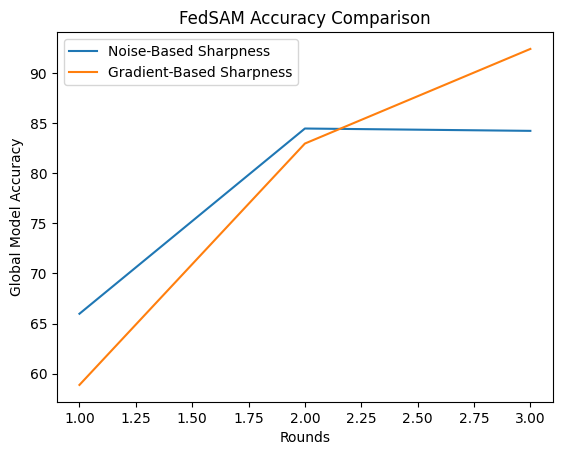

ValueError: x and y can be no greater than 2D, but have shapes (3,) and (3, 5, 20)

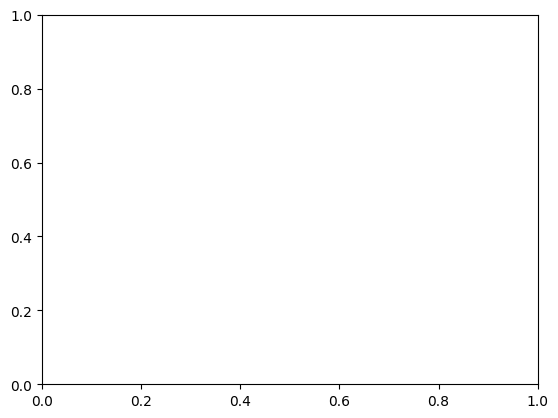

In [23]:
def compare_sharpness_measures():
    # Run noise-based perturbation FedSAM
    noise_sam_accuracies, noise_client_accuracies, noise_sharpness_log = run_fedsam_noise(alpha=2)

    # Run basic gradient-based FedSAM
    basic_sam_accuracies, basic_client_accuracies, basic_sharpness_log = run_fedsam(alpha=2)

    return noise_sam_accuracies, basic_sam_accuracies, noise_sharpness_log, basic_sharpness_log

noise_sam_accuracies, basic_sam_accuracies, noise_sharpness_log, basic_sharpness_log = compare_sharpness_measures()

# Compare global accuracies
plt.plot(range(1, rounds + 1), noise_sam_accuracies, label="Noise-Based Sharpness")
plt.plot(range(1, rounds + 1), basic_sam_accuracies, label="Gradient-Based Sharpness")
plt.xlabel("Rounds")
plt.ylabel("Global Model Accuracy")
plt.legend()
plt.title("FedSAM Accuracy Comparison")
plt.show()

# Compare sharpness values
# Assume sharpness logs are available
plt.plot(noise_sharpness_log, label="Noise-Based Sharpness")
plt.plot(basic_sharpness_log, label="Gradient-Based Sharpness")
plt.xlabel("Epochs")
plt.ylabel("Sharpness")
plt.legend()
plt.title("Sharpness Comparison Across Epochs")
plt.show()


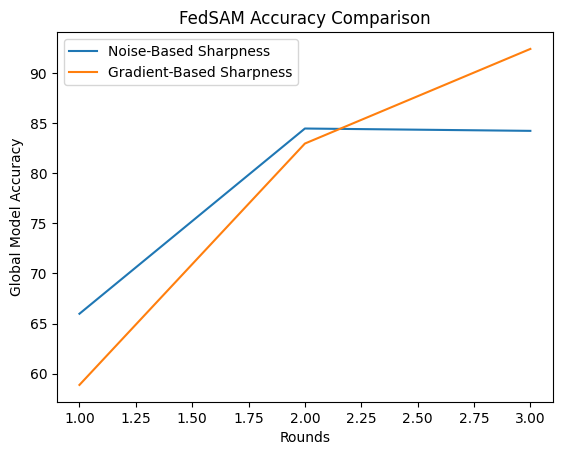

[[[0.010019250868542775, 0.009757866680219367, 0.010128784219960909, 0.010178500031297272, 0.009755351605850298, 0.008736431246271005, 0.007740242003991797, 0.00699799062331786, 0.006559424857432778, 0.006250051051579617, 0.006020779520071842, 0.005832071869155845, 0.005677430689133503, 0.005575861958031719, 0.005485625836897541, 0.0053949776684512965, 0.0053044472997253005, 0.00518698718499493, 0.005066646766420957, 0.004945174740577066], [0.007548721899327479, 0.006570753886511451, 0.006870429505381668, 0.008508059735360899, 0.008685993716904991, 0.00849510873096031, 0.008066668322211817, 0.007679734281019161, 0.007363281000340194, 0.007078846949234344, 0.006824651291888011, 0.006589518565880625, 0.006373768149499307, 0.006207936917219246, 0.00604129525457035, 0.005896271500540407, 0.00575120663760524, 0.005610564086390169, 0.005484323164350108, 0.005359504976424209], [0.008851229017110248, 0.008881053029510536, 0.009494070404846417, 0.00957509247880233, 0.009336717867929684, 0.00863

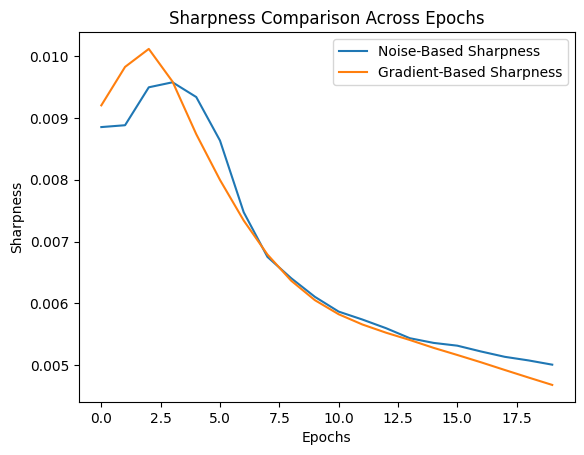

In [29]:
# Compare global accuracies
plt.plot(range(1, rounds + 1), noise_sam_accuracies, label="Noise-Based Sharpness")
plt.plot(range(1, rounds + 1), basic_sam_accuracies, label="Gradient-Based Sharpness")
plt.xlabel("Rounds")
plt.ylabel("Global Model Accuracy")
plt.legend()
plt.title("FedSAM Accuracy Comparison")
plt.show()
print(noise_sharpness_log)
print(basic_sharpness_log)
# Compare sharpness values
# Assume sharpness logs are available
plt.plot(noise_sharpness_log[0][2], label="Noise-Based Sharpness")
plt.plot(basic_sharpness_log[0][2], label="Gradient-Based Sharpness")
plt.xlabel("Epochs")
plt.ylabel("Sharpness")
plt.legend()
plt.title("Sharpness Comparison Across Epochs")
plt.show()